In [2]:
print("Backprop")

Backprop


In [3]:
import wandb
wandb.login()  # This will prompt you to enter your API key


wandb: Currently logged in as: da24m016 (da24m016-indian-institute-of-technology-madras). Use `wandb login --relogin` to force relogin


True

In [4]:
import wandb

# # Initialize a wandb run
# wandb.init(project="my-awesome-project")


In [16]:
# Cell 2: Define Model Functions and NeuralNetwork Class
import numpy as np

# Activation functions and their derivatives
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def dsigmoid(x):
    s = sigmoid(x)
    return s * (1 - s)

def tanh(x):
    return np.tanh(x)

def dtanh(x):
    return 1 - np.tanh(x)**2

def relu(x):
    return np.maximum(0, x)

def drelu(x):
    return (x > 0).astype(float)

def identity(x):
    return x

def didentity(x):
    return np.ones_like(x)

def softmax(x):
    exp_shifted = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_shifted / np.sum(exp_shifted, axis=1, keepdims=True)


# defining the loss functions here..
def cross_entropy_loss(y_pred, y_true):
    eps = 1e-12
    y_pred = np.clip(y_pred, eps, 1 - eps)
    loss = -np.sum(y_true * np.log(y_pred)) / y_pred.shape[0]
    return loss

def mse_loss(y_pred, y_true):
    loss = np.mean(np.square(y_true - y_pred))
    return loss

# Neural Network Class
class NeuralNetwork:
    def __init__(self, input_size, hidden_sizes, output_size, activation, weight_init, loss_func):
        
        # Selecting the activation function
        self.activation_str = activation.lower()
        if self.activation_str == 'sigmoid':
            self.activation = sigmoid
            self.activation_deriv = dsigmoid
            
        elif self.activation_str == 'tanh':
            self.activation = tanh
            self.activation_deriv = dtanh
            
        elif self.activation_str == 'relu':
            self.activation = relu
            self.activation_deriv = drelu
            
        elif self.activation_str == 'identity':
            self.activation = identity
            self.activation_deriv = didentity
            
        else:
            raise ValueError("Unknown activation function.")
        
        # Selecting the loss function
        self.loss_func_name = loss_func.lower()
        if self.loss_func_name == 'cross_entropy':
            self.loss_func = cross_entropy_loss
            
        elif self.loss_func_name == 'mean_squared_error':
            self.loss_func = mse_loss
        else:
            raise ValueError("Unknown loss function.")
        
        
        # Defining the layer sizes: input -> hidden layers -> output here
        self.layer_sizes = [input_size] + hidden_sizes + [output_size]
        self.num_layers = len(self.layer_sizes) - 1
        
        # Initializing the weights and biases
        self.params = {}
        
        for i in range(1, len(self.layer_sizes)):
            # xavier weight initialization method
            if weight_init.lower() == 'xavier':
                limit = np.sqrt(6 / (self.layer_sizes[i-1] + self.layer_sizes[i]))
                self.params['W' + str(i)] = np.random.uniform(-limit, limit, (self.layer_sizes[i-1], self.layer_sizes[i]))
            # random weight initialization method
            else:  
                self.params['W' + str(i)] = np.random.randn(self.layer_sizes[i-1], self.layer_sizes[i]) * 0.01
            self.params['b' + str(i)] = np.zeros((1, self.layer_sizes[i]))
    
    def forward(self, X):
        cache = {}
        A = X
        cache['A0'] = A
        
        # Hidden layers weighted sum and activation..
        for i in range(1, self.num_layers):
            Z = np.dot(A, self.params['W' + str(i)]) + self.params['b' + str(i)]
            cache['Z' + str(i)] = Z
            A = self.activation(Z)
            cache['A' + str(i)] = A
            
        # Output layer with softmax activation..
        Z = np.dot(A, self.params['W' + str(self.num_layers)]) + self.params['b' + str(self.num_layers)]
        cache['Z' + str(self.num_layers)] = Z
        A = softmax(Z)
        cache['A' + str(self.num_layers)] = A
        return A, cache
    
    
    def compute_loss(self, y_pred, y_true):
        return self.loss_func(y_pred, y_true)
    
    def backward(self, X, y_true, cache):
        grads = {}
        m = X.shape[0]
        A_final = cache['A' + str(self.num_layers)]
        
        if self.loss_func_name == 'cross_entropy':
            dZ = (A_final - y_true)
        else:
            dZ = (2 / m) * (A_final - y_true)
        
        # Output layer gradients
        A_prev = cache['A' + str(self.num_layers - 1)]
        grads['dW' + str(self.num_layers)] = np.dot(A_prev.T, dZ)
        grads['db' + str(self.num_layers)] = np.sum(dZ, axis=0, keepdims=True)
        
        # Backpropagation through hidden layers
        for i in range(self.num_layers - 1, 0, -1):
            dA = np.dot(dZ, self.params['W' + str(i + 1)].T)
            Z = cache['Z' + str(i)]
            dZ = dA * self.activation_deriv(Z)
            A_prev = cache['A' + str(i - 1)]
            grads['dW' + str(i)] = np.dot(A_prev.T, dZ)
            grads['db' + str(i)] = np.sum(dZ, axis=0, keepdims=True)
        
        return grads



In [17]:
# Cell 3: Define the Optimizer Class
class Optimizer:
    def __init__(self, params, optimizer_name, learning_rate, momentum=0.5,
                 beta=0.5, beta1=0.5, beta2=0.5, epsilon=1e-6, weight_decay=0.0):
        
        self.optimizer_name = optimizer_name.lower()
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.beta = beta
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.weight_decay = weight_decay
        
        # timestep for Adam/Nadam
        self.t = 0  
        
        # Initialize optimizer states
        self.v = {}  # For momentum or Adam's first moment
        self.s = {}  # For RMSProp or Adam's second moment
        
        for key, val in params.items():
            self.v[key] = np.zeros_like(val)
            self.s[key] = np.zeros_like(val)
        self.param_keys = list(params.keys())
    
    def update(self, params, grads):
        self.t += 1
        
        for key in self.param_keys:
            grad = grads['d' + key]
            
            # Applying weight decay to weights only
            if key.startswith('W'):
                grad += self.weight_decay * params[key]
            
            if self.optimizer_name == 'sgd':
                params[key] -= self.learning_rate * grad
                
            elif self.optimizer_name == 'momentum':
                self.v[key] = self.momentum * self.v[key] - self.learning_rate * grad
                params[key] += self.v[key]
                
            
            elif self.optimizer_name in ['nag', 'nesterov']:
                v_prev = self.v[key].copy()
                self.v[key] = self.momentum * self.v[key] - self.learning_rate * grad
                params[key] += -self.momentum * v_prev + (1 + self.momentum) * self.v[key]
                
            
            elif self.optimizer_name == 'rmsprop':
                self.s[key] = self.beta * self.s[key] + (1 - self.beta) * (grad ** 2)
                params[key] -= self.learning_rate * grad / (np.sqrt(self.s[key]) + self.epsilon)
                
            
            elif self.optimizer_name == 'adam':
                self.v[key] = self.beta1 * self.v[key] + (1 - self.beta1) * grad
                self.s[key] = self.beta2 * self.s[key] + (1 - self.beta2) * (grad ** 2)
                v_corr = self.v[key] / (1 - self.beta1 ** self.t)
                s_corr = self.s[key] / (1 - self.beta2 ** self.t)
                params[key] -= self.learning_rate * v_corr / (np.sqrt(s_corr) + self.epsilon)
                
            
            elif self.optimizer_name == 'nadam':
                self.v[key] = self.beta1 * self.v[key] + (1 - self.beta1) * grad
                self.s[key] = self.beta2 * self.s[key] + (1 - self.beta2) * (grad ** 2)
                v_corr = self.v[key] / (1 - self.beta1 ** self.t)
                s_corr = self.s[key] / (1 - self.beta2 ** self.t)
                params[key] -= self.learning_rate * (self.beta1 * v_corr + (1 - self.beta1) * grad) / (np.sqrt(s_corr) + self.epsilon)
                
            else:
                raise ValueError("Unknown optimizer: " + self.optimizer_name)


In [18]:
# Cell 4: Utility Functions
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.datasets import fashion_mnist

from sklearn.model_selection import train_test_split

def load_data(dataset="fashion_mnist"):
    if dataset == "fashion_mnist":
        (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    elif dataset == "mnist":
        from keras.datasets import mnist
        (X_train, y_train), (X_test, y_test) = mnist.load_data()
    else:
        raise ValueError("Unknown dataset.")
    
    # Normalize and reshape data
    X_train = X_train.reshape(X_train.shape[0], -1) / 255.0
    X_test = X_test.reshape(X_test.shape[0], -1) / 255.0
    
    num_classes = 10
    y_train = np.eye(num_classes)[y_train]
    y_test = np.eye(num_classes)[y_test]
    
    # Use train_test_split to create a 10% validation split
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.1, random_state=42, shuffle=True
    )
    
    return X_train, y_train, X_val, y_val, X_test, y_test


def train_model(network, optimizer, X_train, y_train, X_val, y_val, epochs, batch_size):
    num_samples = X_train.shape[0]
    steps_per_epoch = num_samples // batch_size
    for epoch in range(epochs):
        # Shuffle training data
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        X_train = X_train[indices]
        y_train = y_train[indices]
        epoch_loss = 0
        epoch_acc = 0
        
        for step in range(steps_per_epoch):
            start = step * batch_size
            end = start + batch_size
            
            X_batch = X_train[start:end]
            y_batch = y_train[start:end]
            
            # Forward pass
            y_pred, cache = network.forward(X_batch)
            loss = network.compute_loss(y_pred, y_batch)
            epoch_loss += loss
            
            # Accuracy calculation
            predictions = np.argmax(y_pred, axis=1)
            true_labels = np.argmax(y_batch, axis=1)
            acc = np.mean(predictions == true_labels)
            epoch_acc += acc
            
            # Backward pass and update
            grads = network.backward(X_batch, y_batch, cache)
            optimizer.update(network.params, grads)
        
        epoch_loss /= steps_per_epoch
        epoch_acc /= steps_per_epoch
        
        # Evaluate on validation data
        y_val_pred, _ = network.forward(X_val)
        val_loss = network.compute_loss(y_val_pred, y_val)
        predictions_val = np.argmax(y_val_pred, axis=1)
        true_labels_val = np.argmax(y_val, axis=1)
        val_acc = np.mean(predictions_val == true_labels_val)
        
        print(f"Epoch {epoch+1}/{epochs}: Loss={epoch_loss:.4f}, Acc={epoch_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")
        wandb.log({
            "epoch": epoch + 1,
            "loss": epoch_loss,
            "accuracy": epoch_acc,
            "val_loss": val_loss,
            "val_accuracy": val_acc
        })
    
    return network

def evaluate_model(network, X_test, y_test):
    y_pred, _ = network.forward(X_test)
    predictions = np.argmax(y_pred, axis=1)
    true_labels = np.argmax(y_test, axis=1)
    test_acc = np.mean(predictions == true_labels)
    print(f"Test Accuracy: {test_acc:.4f}")
    return predictions, true_labels, test_acc

def plot_conf_matrix(true_labels, predictions, classes, title="Confusion Matrix"):
    cm = confusion_matrix(true_labels, predictions)
    fig, ax = plt.subplots(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=classes, yticklabels=classes, ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(title)
    plt.tight_layout()
    
    wandb.log({"Confusion Matrix": wandb.Image(fig)})
    
    plt.show()
    plt.close(fig)

# def plot_conf_matrix(true_labels, predictions, class_names, title="Confusion Matrix"):
#     cm = confusion_matrix(true_labels, predictions)
    
#     # Log confusion matrix directly to WandB
#     wandb.log({"Confusion Matrix": wandb.plot.confusion_matrix(
#         probs=None,
#         y_true=true_labels,
#         preds=predictions,
#         class_names=class_names
#     )})

Starting run: mnist_nadam_tanh_3_128_64
11501568/11490434 [==============================] - 3s 0us/step
Epoch 1/10: Loss=0.2757, Acc=0.9176, Val Loss=0.1654, Val Acc=0.9502
Epoch 2/10: Loss=0.1278, Acc=0.9614, Val Loss=0.1109, Val Acc=0.9638
Epoch 3/10: Loss=0.0874, Acc=0.9730, Val Loss=0.1015, Val Acc=0.9687
Epoch 4/10: Loss=0.0648, Acc=0.9791, Val Loss=0.0794, Val Acc=0.9767
Epoch 5/10: Loss=0.0498, Acc=0.9838, Val Loss=0.0799, Val Acc=0.9755
Epoch 6/10: Loss=0.0396, Acc=0.9873, Val Loss=0.0815, Val Acc=0.9760
Epoch 7/10: Loss=0.0314, Acc=0.9897, Val Loss=0.0803, Val Acc=0.9760
Epoch 8/10: Loss=0.0259, Acc=0.9913, Val Loss=0.0722, Val Acc=0.9783
Epoch 9/10: Loss=0.0213, Acc=0.9930, Val Loss=0.0876, Val Acc=0.9750
Epoch 10/10: Loss=0.0191, Acc=0.9937, Val Loss=0.0805, Val Acc=0.9783
Test Accuracy: 0.9747
Test Accuracy for mnist_nadam_tanh_3_128_64: 97.47%


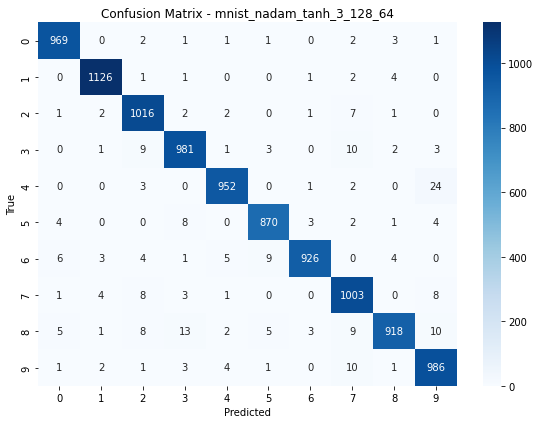

Starting run: mnist_nadam_relu_3_128_64
Epoch 1/10: Loss=0.2646, Acc=0.9211, Val Loss=0.1181, Val Acc=0.9655
Epoch 2/10: Loss=0.1085, Acc=0.9670, Val Loss=0.0867, Val Acc=0.9740
Epoch 3/10: Loss=0.0759, Acc=0.9767, Val Loss=0.0946, Val Acc=0.9735
Epoch 4/10: Loss=0.0576, Acc=0.9816, Val Loss=0.0862, Val Acc=0.9725
Epoch 5/10: Loss=0.0455, Acc=0.9852, Val Loss=0.0751, Val Acc=0.9785
Epoch 6/10: Loss=0.0373, Acc=0.9875, Val Loss=0.0796, Val Acc=0.9770
Epoch 7/10: Loss=0.0328, Acc=0.9894, Val Loss=0.0864, Val Acc=0.9763
Epoch 8/10: Loss=0.0275, Acc=0.9906, Val Loss=0.0933, Val Acc=0.9767
Epoch 9/10: Loss=0.0260, Acc=0.9916, Val Loss=0.0834, Val Acc=0.9783
Epoch 10/10: Loss=0.0231, Acc=0.9922, Val Loss=0.0893, Val Acc=0.9795
Test Accuracy: 0.9785
Test Accuracy for mnist_nadam_relu_3_128_64: 97.85%


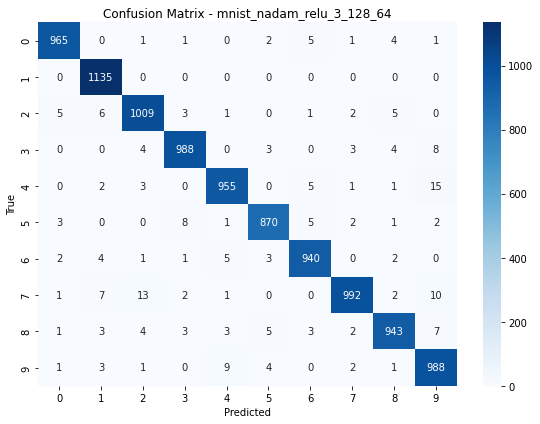

Starting run: mnist_adam_relu_5_128_64
Epoch 1/10: Loss=0.2783, Acc=0.9153, Val Loss=0.1459, Val Acc=0.9552
Epoch 2/10: Loss=0.1160, Acc=0.9649, Val Loss=0.1271, Val Acc=0.9615
Epoch 3/10: Loss=0.0835, Acc=0.9747, Val Loss=0.0991, Val Acc=0.9700
Epoch 4/10: Loss=0.0679, Acc=0.9796, Val Loss=0.0918, Val Acc=0.9732
Epoch 5/10: Loss=0.0592, Acc=0.9810, Val Loss=0.0968, Val Acc=0.9730
Epoch 6/10: Loss=0.0465, Acc=0.9857, Val Loss=0.0973, Val Acc=0.9738
Epoch 7/10: Loss=0.0392, Acc=0.9877, Val Loss=0.1054, Val Acc=0.9722
Epoch 8/10: Loss=0.0384, Acc=0.9877, Val Loss=0.1021, Val Acc=0.9740
Epoch 9/10: Loss=0.0313, Acc=0.9899, Val Loss=0.0929, Val Acc=0.9777
Epoch 10/10: Loss=0.0317, Acc=0.9900, Val Loss=0.0899, Val Acc=0.9758
Test Accuracy: 0.9775
Test Accuracy for mnist_adam_relu_5_128_64: 97.75%


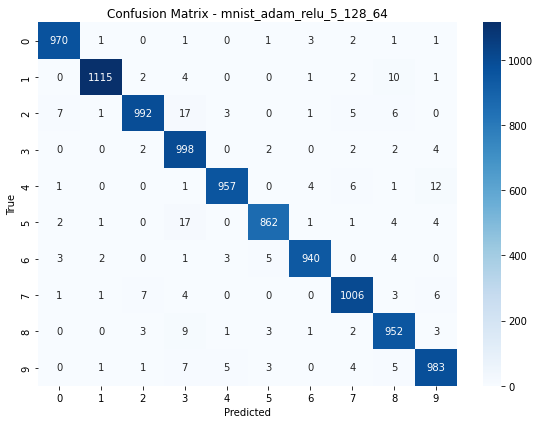

In [23]:
import wandb

# Define the top 3 configurations for MNIST
top_config_list = [
    {"run_name": "mnist_nadam_tanh_3_128_64", "optimizer": "nadam", "activation": "tanh", "num_layers": 3, "hidden_size": 128, "batch_size": 64},
    {"run_name": "mnist_nadam_relu_3_128_64", "optimizer": "nadam", "activation": "relu", "num_layers": 3, "hidden_size": 128, "batch_size": 64},
    {"run_name": "mnist_adam_relu_5_128_64",  "optimizer": "adam",  "activation": "relu", "num_layers": 5, "hidden_size": 128, "batch_size": 64}
]

# Define common hyperparameters (default values)
common_params = {
    "epochs": 10,
    "learning_rate": 0.001,
    "weight_decay": 0.0005,
    "weight_init": "xavier",
    "loss": "cross_entropy",
    "momentum": 0.9,
    "beta": 0.9,
    "beta1": 0.9,
    "beta2": 0.999,
    "epsilon": 1e-8
}

# Loop through each configuration and run the experiment on MNIST
for cfg in top_config_list:
    run_name = cfg["run_name"]
    wandb.init(project="DL_Assignment_01", name=run_name)
    config = wandb.config
    
    # Set common hyperparameters
    config.epochs = common_params["epochs"]
    config.learning_rate = common_params["learning_rate"]
    config.weight_decay = common_params["weight_decay"]
    config.weight_init = common_params["weight_init"]
    config.loss = common_params["loss"]
    config.momentum = common_params["momentum"]
    config.beta = common_params["beta"]
    config.beta1 = common_params["beta1"]
    config.beta2 = common_params["beta2"]
    config.epsilon = common_params["epsilon"]
    
    # Set configuration-specific hyperparameters
    config.batch_size = cfg["batch_size"]
    config.num_layers = cfg["num_layers"]
    config.hidden_size = cfg["hidden_size"]
    config.activation = cfg["activation"]
    config.optimizer = cfg["optimizer"]
    
    print("Starting run:", run_name)
    
    # Load MNIST data instead of Fashion-MNIST
    X_train, y_train, X_val, y_val, X_test, y_test = load_data("mnist")
    input_size = X_train.shape[1]  # 28*28 = 784
    output_size = 10               # 10 classes
    hidden_sizes = [config.hidden_size] * config.num_layers
    
    # Initialize the Neural Network and Optimizer
    network = NeuralNetwork(input_size, hidden_sizes, output_size, 
                            activation=config.activation, 
                            weight_init=config.weight_init, 
                            loss_func=config.loss)
    optimizer = Optimizer(network.params, config.optimizer, config.learning_rate,
                          momentum=config.momentum, beta=config.beta,
                          beta1=config.beta1, beta2=config.beta2,
                          epsilon=config.epsilon, weight_decay=config.weight_decay)
    
    # Train the model (training and validation metrics are logged via wandb.log inside train_model)
    network = train_model(network, optimizer, X_train, y_train, X_val, y_val, 
                          config.epochs, config.batch_size)
    
    # Evaluate the model on the test set
    predictions, true_labels, test_acc = evaluate_model(network, X_test, y_test)
    print("Test Accuracy for {}: {:.2f}%".format(run_name, test_acc * 100))
    
    # Plot and log the confusion matrix
    classes = [str(i) for i in range(10)]
    plot_conf_matrix(true_labels, predictions, classes, title="Confusion Matrix - " + run_name)
    
    wandb.finish()


4431872/4422102 [==============================] - 1s 0us/step
Epoch 1/5: Loss=0.5225, Acc=0.8129, Val Loss=0.4337, Val Acc=0.8410
Epoch 2/5: Loss=0.3862, Acc=0.8597, Val Loss=0.3725, Val Acc=0.8660
Epoch 3/5: Loss=0.3447, Acc=0.8743, Val Loss=0.3380, Val Acc=0.8752
Epoch 4/5: Loss=0.3256, Acc=0.8800, Val Loss=0.3471, Val Acc=0.8682
Epoch 5/5: Loss=0.3100, Acc=0.8853, Val Loss=0.3504, Val Acc=0.8748
Test Accuracy: 0.8663


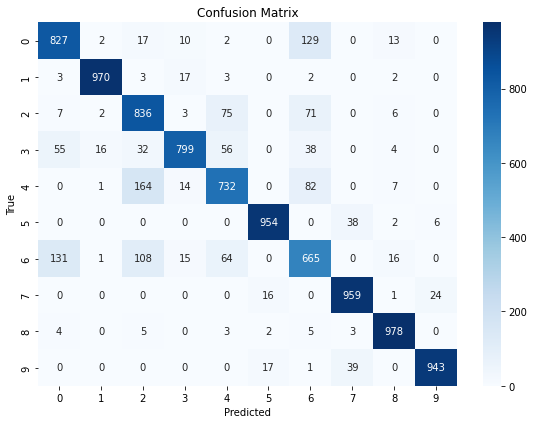

wandb: ERROR Control-C detected -- Run data was not synced


In [13]:
# Cell 5: Main Training Loop & Wandb Initialization
import wandb

# Initialize a new Wandb run
wandb.init(project="DL_Assignment_01")
config = wandb.config
config.learning_rate = 0.001
config.batch_size = 32
config.epochs = 5
config.num_layers = 2      # Example: 2 hidden layers
config.hidden_size = 64    # Example: 64 neurons per hidden layer
config.activation = "relu"
config.weight_init = "xavier"
config.loss = "cross_entropy"
config.optimizer = "adam"  # Options: sgd, momentum, nag, rmsprop, adam, nadam
config.momentum = 0.9
config.beta = 0.9
config.beta1 = 0.9
config.beta2 = 0.999
config.epsilon = 1e-8
config.weight_decay = 0.0001

# Load and preprocess data
X_train, y_train, X_val, y_val, X_test, y_test = load_data("fashion_mnist")
input_size = X_train.shape[1]
output_size = 10  # 10 classes
hidden_sizes = [config.hidden_size] * config.num_layers

# Initialize the Neural Network and Optimizer
network = NeuralNetwork(input_size, hidden_sizes, output_size, config.activation, config.weight_init, config.loss)
optimizer = Optimizer(network.params, config.optimizer, config.learning_rate,
                      momentum=config.momentum, beta=config.beta,
                      beta1=config.beta1, beta2=config.beta2,
                      epsilon=config.epsilon, weight_decay=config.weight_decay)

# Train the model
network = train_model(network, optimizer, X_train, y_train, X_val, y_val, config.epochs, config.batch_size)

# Evaluate the model on the test set
predictions, true_labels, test_acc = evaluate_model(network, X_test, y_test)

# Plot the confusion matrix
classes = [str(i) for i in range(10)]
plot_conf_matrix(true_labels, predictions, classes)

# Finish the Wandb run
wandb.finish()


In [1]:
import wandb
wandb.login()  # This will prompt you to enter your API key

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: da24m016 (da24m016-indian-institute-of-technology-madras). Use `wandb login --relogin` to force relogin


True

In [20]:
import wandb

settings = wandb.update()
settings._timeout = 120  # Increase timeout to 120 seconds

wandb.init(project="DL_Assignment_01", name="corr_plot_nadam_tanh_3_128_64", settings=settings)


AttributeError: module 'wandb' has no attribute 'update'

optimizer = momentum
activation_function = tanh
Initialization = xavier
hiddenLayers = 4
batchSize = 64 
sizeOfHiddenLayers = 128
learningRate = 0.001
weightDecay = 0.0005
epochs = 10

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_init' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).


Epoch 1/10: Loss=0.4795, Acc=0.8264, Val Loss=0.3878, Val Acc=0.8588
Epoch 2/10: Loss=0.3680, Acc=0.8651, Val Loss=0.3626, Val Acc=0.8662
Epoch 3/10: Loss=0.3370, Acc=0.8761, Val Loss=0.3596, Val Acc=0.8700
Epoch 4/10: Loss=0.3168, Acc=0.8818, Val Loss=0.3432, Val Acc=0.8830
Epoch 5/10: Loss=0.2996, Acc=0.8873, Val Loss=0.3337, Val Acc=0.8803
Epoch 6/10: Loss=0.2871, Acc=0.8942, Val Loss=0.3343, Val Acc=0.8815
Epoch 7/10: Loss=0.2757, Acc=0.8974, Val Loss=0.3274, Val Acc=0.8870
Epoch 8/10: Loss=0.2656, Acc=0.8990, Val Loss=0.3265, Val Acc=0.8850
Epoch 9/10: Loss=0.2602, Acc=0.9033, Val Loss=0.3336, Val Acc=0.8843
Epoch 10/10: Loss=0.2523, Acc=0.9051, Val Loss=0.3392, Val Acc=0.8853
Test Accuracy: 0.8825
Test Accuracy: 88.25%


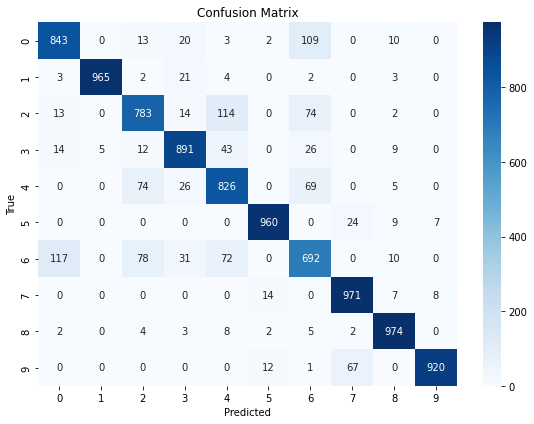

In [11]:
import wandb

# Initialize a new Wandb run with a custom name
wandb.init(project="DL_Assignment_01", name="corr_plot_nadam_tanh_3_128_64")
config = wandb.config
config.learning_rate = 0.001
config.batch_size = 64
config.epochs = 10
config.num_layers = 3         
config.hidden_size = 128     
config.activation = "tanh"
config.weight_init = "xavier"
config.loss = "cross_entropy"
config.optimizer = "nadam"
config.momentum = 0.9
config.beta = 0.9
config.beta1 = 0.9
config.beta2 = 0.999
config.epsilon = 1e-8
config.weight_decay = 0.0005

# Load and preprocess data
X_train, y_train, X_val, y_val, X_test, y_test = load_data("fashion_mnist")
input_size = X_train.shape[1]
output_size = 10  # for 10 classes
hidden_sizes = [config.hidden_size] * config.num_layers

# Initialize the Neural Network and Optimizer
network = NeuralNetwork(input_size, hidden_sizes, output_size, 
                        activation=config.activation, 
                        weight_init=config.weight_init, 
                        loss_func=config.loss)
optimizer = Optimizer(network.params, config.optimizer, config.learning_rate,
                      momentum=config.momentum, beta=config.beta,
                      beta1=config.beta1, beta2=config.beta2,
                      epsilon=config.epsilon, weight_decay=config.weight_decay)

# Train the model
network = train_model(network, optimizer, X_train, y_train, X_val, y_val, config.epochs, config.batch_size)

# Evaluate the model on the test set and plot the confusion matrix
predictions, true_labels, test_acc = evaluate_model(network, X_test, y_test)
print("Test Accuracy: {:.2f}%".format(test_acc * 100))
classes = [str(i) for i in range(10)]
plot_conf_matrix(true_labels, predictions, classes)

# Finish the Wandb run
wandb.finish()


In [ ]:
import wandb

# Initialize a new Wandb run with a custom name
wandb.init(project="DL_Assignment_01", name="test1_corr_plot_nadam_tanh_3_128_64")
config = wandb.config
config.learning_rate = 0.001
config.batch_size = 64
config.epochs = 10
config.num_layers = 3         
config.hidden_size = 128     
config.activation = "tanh"
config.weight_init = "xavier"
config.loss = "cross_entropy"
config.optimizer = "nadam"
config.momentum = 0.9
config.beta = 0.9
config.beta1 = 0.9
config.beta2 = 0.999
config.epsilon = 1e-8
config.weight_decay = 0.0005

# Load and preprocess data
X_train, y_train, X_val, y_val, X_test, y_test = load_data("fashion_mnist")
input_size = X_train.shape[1]
output_size = 10  # for 10 classes
hidden_sizes = [config.hidden_size] * config.num_layers

# Initialize the Neural Network and Optimizer
network = NeuralNetwork(input_size, hidden_sizes, output_size, 
                        activation=config.activation, 
                        weight_init=config.weight_init, 
                        loss_func=config.loss)
optimizer = Optimizer(network.params, config.optimizer, config.learning_rate,
                      momentum=config.momentum, beta=config.beta,
                      beta1=config.beta1, beta2=config.beta2,
                      epsilon=config.epsilon, weight_decay=config.weight_decay)

# Train the model
network = train_model(network, optimizer, X_train, y_train, X_val, y_val, config.epochs, config.batch_size)

# Evaluate the model on the test set and plot the confusion matrix
predictions, true_labels, test_acc = evaluate_model(network, X_test, y_test)
print("Test Accuracy: {:.2f}%".format(test_acc * 100))
classes = [str(i) for i in range(10)]
plot_conf_matrix(true_labels, predictions, classes)

# Finish the Wandb run
wandb.finish()


In [8]:
import wandb

# Initialize a new Wandb run with a custom name
wandb.init(project="DL_Assignment_01", name="new_corr_plot_nadam_tanh_3_128_64")
config = wandb.config
config.learning_rate = 0.001
config.batch_size = 64
config.epochs = 10
config.num_layers = 3         
config.hidden_size = 128     
config.activation = "tanh"
config.weight_init = "xavier"
config.loss = "cross_entropy"
config.optimizer = "nadam"
config.momentum = 0.9
config.beta = 0.9
config.beta1 = 0.9
config.beta2 = 0.999
config.epsilon = 1e-8
config.weight_decay = 0.0005

# Load and preprocess data
X_train, y_train, X_val, y_val, X_test, y_test = load_data("fashion_mnist")
input_size = X_train.shape[1]
output_size = 10  # for 10 classes
hidden_sizes = [config.hidden_size] * config.num_layers

# Initialize the Neural Network and Optimizer
network = NeuralNetwork(input_size, hidden_sizes, output_size, 
                        activation=config.activation, 
                        weight_init=config.weight_init, 
                        loss_func=config.loss)
optimizer = Optimizer(network.params, config.optimizer, config.learning_rate,
                      momentum=config.momentum, beta=config.beta,
                      beta1=config.beta1, beta2=config.beta2,
                      epsilon=config.epsilon, weight_decay=config.weight_decay)

# Train the model
network = train_model(network, optimizer, X_train, y_train, X_val, y_val, config.epochs, config.batch_size)

# Evaluate the model on the test set and plot the confusion matrix
predictions, true_labels, test_acc = evaluate_model(network, X_test, y_test)
print("Test Accuracy: {:.2f}%".format(test_acc * 100))
classes = [str(i) for i in range(10)]
plot_conf_matrix(true_labels, predictions, classes)

# Finish the Wandb run
wandb.finish()


Epoch 1/10: Loss=0.4708, Acc=0.8307, Val Loss=0.3796, Val Acc=0.8603
Epoch 2/10: Loss=0.3684, Acc=0.8663, Val Loss=0.3749, Val Acc=0.8612
Epoch 3/10: Loss=0.3438, Acc=0.8736, Val Loss=0.3695, Val Acc=0.8682
Epoch 4/10: Loss=0.3269, Acc=0.8803, Val Loss=0.3338, Val Acc=0.8797
Epoch 5/10: Loss=0.3142, Acc=0.8839, Val Loss=0.3627, Val Acc=0.8690
Epoch 6/10: Loss=0.3053, Acc=0.8868, Val Loss=0.3285, Val Acc=0.8767
Epoch 7/10: Loss=0.2996, Acc=0.8897, Val Loss=0.3195, Val Acc=0.8855
Epoch 8/10: Loss=0.2918, Acc=0.8915, Val Loss=0.3410, Val Acc=0.8745
Epoch 9/10: Loss=0.2863, Acc=0.8933, Val Loss=0.3363, Val Acc=0.8768
Epoch 10/10: Loss=0.2812, Acc=0.8950, Val Loss=0.3590, Val Acc=0.8672
Test Accuracy: 0.8618
Test Accuracy: 86.18%


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_init' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).


Epoch 1/10: Loss=0.4813, Acc=0.8270, Val Loss=0.4094, Val Acc=0.8498
Epoch 2/10: Loss=0.3719, Acc=0.8640, Val Loss=0.3795, Val Acc=0.8657
Epoch 3/10: Loss=0.3365, Acc=0.8774, Val Loss=0.3776, Val Acc=0.8642
Epoch 4/10: Loss=0.3152, Acc=0.8822, Val Loss=0.3400, Val Acc=0.8785
Epoch 5/10: Loss=0.2989, Acc=0.8889, Val Loss=0.3373, Val Acc=0.8787
Epoch 6/10: Loss=0.2857, Acc=0.8940, Val Loss=0.3330, Val Acc=0.8873
Epoch 7/10: Loss=0.2757, Acc=0.8968, Val Loss=0.3297, Val Acc=0.8818
Epoch 8/10: Loss=0.2660, Acc=0.8998, Val Loss=0.3327, Val Acc=0.8823
Epoch 9/10: Loss=0.2588, Acc=0.9029, Val Loss=0.3103, Val Acc=0.8912
Epoch 10/10: Loss=0.2513, Acc=0.9052, Val Loss=0.3283, Val Acc=0.8868
Test Accuracy: 0.8773
Test Accuracy: 87.73%


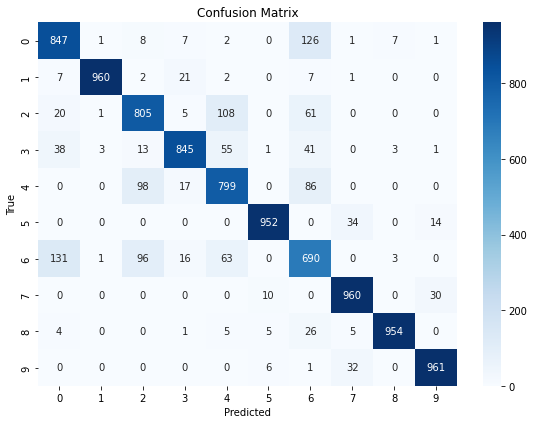

In [12]:
import wandb

# Initialize a new Wandb run with a custom name
wandb.init(project="DL_Assignment_01", name="corr_plot_nadam_tanh_3_128_64")
config = wandb.config
config.learning_rate = 0.0001
config.batch_size = 64
config.epochs = 10
config.num_layers = 3         
config.hidden_size = 128     
config.activation = "tanh"
config.weight_init = "xavier"
config.loss = "cross_entropy"
config.optimizer = "nadam"
config.momentum = 0.9
config.beta = 0.9
config.beta1 = 0.9
config.beta2 = 0.999
config.epsilon = 1e-8
config.weight_decay = 0.0005

# Load and preprocess data
X_train, y_train, X_val, y_val, X_test, y_test = load_data("fashion_mnist")
input_size = X_train.shape[1]
output_size = 10  # for 10 classes
hidden_sizes = [config.hidden_size] * config.num_layers

# Initialize the Neural Network and Optimizer
network = NeuralNetwork(input_size, hidden_sizes, output_size, 
                        activation=config.activation, 
                        weight_init=config.weight_init, 
                        loss_func=config.loss)
optimizer = Optimizer(network.params, config.optimizer, config.learning_rate,
                      momentum=config.momentum, beta=config.beta,
                      beta1=config.beta1, beta2=config.beta2,
                      epsilon=config.epsilon, weight_decay=config.weight_decay)

# Train the model
network = train_model(network, optimizer, X_train, y_train, X_val, y_val, config.epochs, config.batch_size)

# Evaluate the model on the test set and plot the confusion matrix
predictions, true_labels, test_acc = evaluate_model(network, X_test, y_test)
print("Test Accuracy: {:.2f}%".format(test_acc * 100))
classes = [str(i) for i in range(10)]
plot_conf_matrix(true_labels, predictions, classes)

# Finish the Wandb run
wandb.finish()


Epoch 1/5: Loss=0.4697, Acc=0.8322, Val Loss=0.3858, Val Acc=0.8625
Epoch 2/5: Loss=0.3561, Acc=0.8693, Val Loss=0.3422, Val Acc=0.8765
Epoch 3/5: Loss=0.3221, Acc=0.8822, Val Loss=0.3413, Val Acc=0.8747
Epoch 4/5: Loss=0.2999, Acc=0.8893, Val Loss=0.3529, Val Acc=0.8748
Epoch 5/5: Loss=0.2827, Acc=0.8945, Val Loss=0.3203, Val Acc=0.8855
Test Accuracy: 0.8760
Test Accuracy: 87.60%


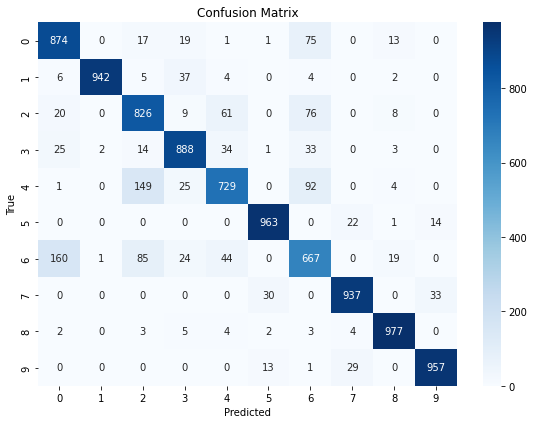

In [21]:
import wandb

# Initialize a new Wandb run with a custom name
wandb.init(project="DL_Assignment_01", name="cross_entropy_nadam_tanh_3_128_64_run")
config = wandb.config
config.learning_rate = 0.001
config.batch_size = 64
config.epochs = 5
config.num_layers = 3         
config.hidden_size = 128     
config.activation = "tanh"
config.weight_init = "xavier"
config.loss = "cross_entropy"
config.optimizer = "nadam"
config.momentum = 0.9
config.beta = 0.9
config.beta1 = 0.9
config.beta2 = 0.999
config.epsilon = 1e-8
config.weight_decay = 0.0005
config.loss = "cross_entropy"

# Load and preprocess data
X_train, y_train, X_val, y_val, X_test, y_test = load_data("fashion_mnist")
input_size = X_train.shape[1]
output_size = 10  # for 10 classes
hidden_sizes = [config.hidden_size] * config.num_layers

# Initialize the Neural Network and Optimizer
network = NeuralNetwork(input_size, hidden_sizes, output_size, 
                        activation=config.activation, 
                        weight_init=config.weight_init, 
                        loss_func=config.loss)
optimizer = Optimizer(network.params, config.optimizer, config.learning_rate,
                      momentum=config.momentum, beta=config.beta,
                      beta1=config.beta1, beta2=config.beta2,
                      epsilon=config.epsilon, weight_decay=config.weight_decay)

# Train the model
network = train_model(network, optimizer, X_train, y_train, X_val, y_val, config.epochs, config.batch_size)

# Evaluate the model on the test set and plot the confusion matrix
predictions, true_labels, test_acc = evaluate_model(network, X_test, y_test)
print("Test Accuracy: {:.2f}%".format(test_acc * 100))
classes = [str(i) for i in range(10)]
plot_conf_matrix(true_labels, predictions, classes)

# Finish the Wandb run
wandb.finish()


Epoch 1/5: Loss=0.0240, Acc=0.8303, Val Loss=0.0200, Val Acc=0.8577
Epoch 2/5: Loss=0.0189, Acc=0.8666, Val Loss=0.0187, Val Acc=0.8668
Epoch 3/5: Loss=0.0174, Acc=0.8779, Val Loss=0.0177, Val Acc=0.8753
Epoch 4/5: Loss=0.0166, Acc=0.8833, Val Loss=0.0170, Val Acc=0.8837
Epoch 5/5: Loss=0.0158, Acc=0.8882, Val Loss=0.0171, Val Acc=0.8805
Test Accuracy: 0.8685
Test Accuracy: 86.85%


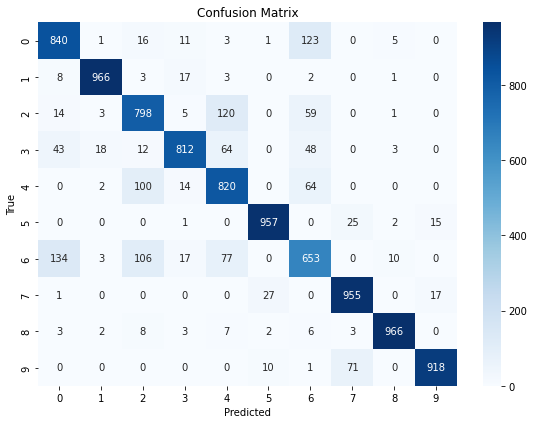

In [22]:
import wandb

# Initialize a new Wandb run with a custom name
wandb.init(project="DL_Assignment_01", name="mse_nadam_tanh_3_128_64_run")
config = wandb.config
config.learning_rate = 0.001
config.batch_size = 64
config.epochs = 5
config.num_layers = 3         
config.hidden_size = 128     
config.activation = "tanh"
config.weight_init = "xavier"
config.loss = "cross_entropy"
config.optimizer = "nadam"
config.momentum = 0.9
config.beta = 0.9
config.beta1 = 0.9
config.beta2 = 0.999
config.epsilon = 1e-8
config.weight_decay = 0.0005
config.loss = "mean_squared_error"

# Load and preprocess data
X_train, y_train, X_val, y_val, X_test, y_test = load_data("fashion_mnist")
input_size = X_train.shape[1]
output_size = 10  # for 10 classes
hidden_sizes = [config.hidden_size] * config.num_layers

# Initialize the Neural Network and Optimizer
network = NeuralNetwork(input_size, hidden_sizes, output_size, 
                        activation=config.activation, 
                        weight_init=config.weight_init, 
                        loss_func=config.loss)
optimizer = Optimizer(network.params, config.optimizer, config.learning_rate,
                      momentum=config.momentum, beta=config.beta,
                      beta1=config.beta1, beta2=config.beta2,
                      epsilon=config.epsilon, weight_decay=config.weight_decay)

# Train the model
network = train_model(network, optimizer, X_train, y_train, X_val, y_val, config.epochs, config.batch_size)

# Evaluate the model on the test set and plot the confusion matrix
predictions, true_labels, test_acc = evaluate_model(network, X_test, y_test)
print("Test Accuracy: {:.2f}%".format(test_acc * 100))
classes = [str(i) for i in range(10)]
plot_conf_matrix(true_labels, predictions, classes)

# Finish the Wandb run
wandb.finish()


Starting run: corr_nadam_tanh_3_128_64
Epoch 1/10: Loss=0.4685, Acc=0.8326, Val Loss=0.3831, Val Acc=0.8607
Epoch 2/10: Loss=0.3678, Acc=0.8661, Val Loss=0.3750, Val Acc=0.8645
Epoch 3/10: Loss=0.3407, Acc=0.8746, Val Loss=0.3413, Val Acc=0.8697
Epoch 4/10: Loss=0.3259, Acc=0.8802, Val Loss=0.3510, Val Acc=0.8693
Epoch 5/10: Loss=0.3131, Acc=0.8852, Val Loss=0.3481, Val Acc=0.8712
Epoch 6/10: Loss=0.3048, Acc=0.8877, Val Loss=0.3361, Val Acc=0.8783
Epoch 7/10: Loss=0.2984, Acc=0.8903, Val Loss=0.3233, Val Acc=0.8803
Epoch 8/10: Loss=0.2913, Acc=0.8926, Val Loss=0.3358, Val Acc=0.8770
Epoch 9/10: Loss=0.2865, Acc=0.8937, Val Loss=0.3294, Val Acc=0.8812
Epoch 10/10: Loss=0.2832, Acc=0.8942, Val Loss=0.3263, Val Acc=0.8800
Test Accuracy: 0.8736
Test Accuracy for corr_nadam_tanh_3_128_64: 87.36%


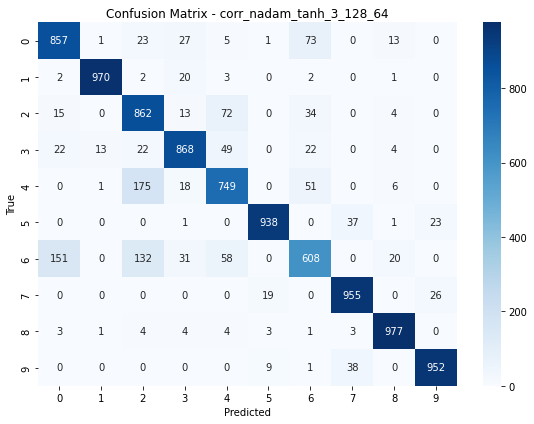

Starting run: corr_nadam_tanh_4_64_64
Epoch 1/10: Loss=0.4991, Acc=0.8245, Val Loss=0.3787, Val Acc=0.8643
Epoch 2/10: Loss=0.3715, Acc=0.8648, Val Loss=0.3598, Val Acc=0.8697
Epoch 3/10: Loss=0.3431, Acc=0.8748, Val Loss=0.3605, Val Acc=0.8665
Epoch 4/10: Loss=0.3248, Acc=0.8811, Val Loss=0.3381, Val Acc=0.8758
Epoch 5/10: Loss=0.3130, Acc=0.8856, Val Loss=0.3515, Val Acc=0.8693
Epoch 6/10: Loss=0.3018, Acc=0.8899, Val Loss=0.3238, Val Acc=0.8797
Epoch 7/10: Loss=0.2938, Acc=0.8915, Val Loss=0.3494, Val Acc=0.8743
Epoch 8/10: Loss=0.2874, Acc=0.8941, Val Loss=0.3313, Val Acc=0.8792
Epoch 9/10: Loss=0.2813, Acc=0.8953, Val Loss=0.3534, Val Acc=0.8728
Epoch 10/10: Loss=0.2770, Acc=0.8986, Val Loss=0.3176, Val Acc=0.8827
Test Accuracy: 0.8795
Test Accuracy for corr_nadam_tanh_4_64_64: 87.95%


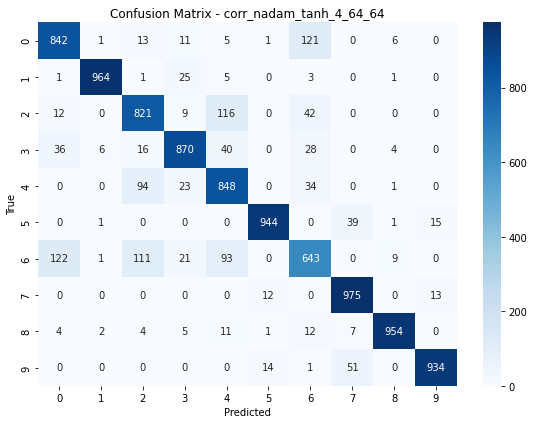

Starting run: corr_nadam_tanh_4_128_64
Epoch 1/10: Loss=0.4734, Acc=0.8292, Val Loss=0.3808, Val Acc=0.8640
Epoch 2/10: Loss=0.3704, Acc=0.8635, Val Loss=0.3734, Val Acc=0.8627
Epoch 3/10: Loss=0.3445, Acc=0.8739, Val Loss=0.3376, Val Acc=0.8742
Epoch 4/10: Loss=0.3293, Acc=0.8781, Val Loss=0.3601, Val Acc=0.8680
Epoch 5/10: Loss=0.3162, Acc=0.8838, Val Loss=0.3421, Val Acc=0.8770
Epoch 6/10: Loss=0.3080, Acc=0.8860, Val Loss=0.3499, Val Acc=0.8755
Epoch 7/10: Loss=0.3005, Acc=0.8893, Val Loss=0.3333, Val Acc=0.8785
Epoch 8/10: Loss=0.2945, Acc=0.8906, Val Loss=0.3484, Val Acc=0.8740
Epoch 9/10: Loss=0.2915, Acc=0.8920, Val Loss=0.3564, Val Acc=0.8718
Epoch 10/10: Loss=0.2868, Acc=0.8927, Val Loss=0.3275, Val Acc=0.8783
Test Accuracy: 0.8774
Test Accuracy for corr_nadam_tanh_4_128_64: 87.74%


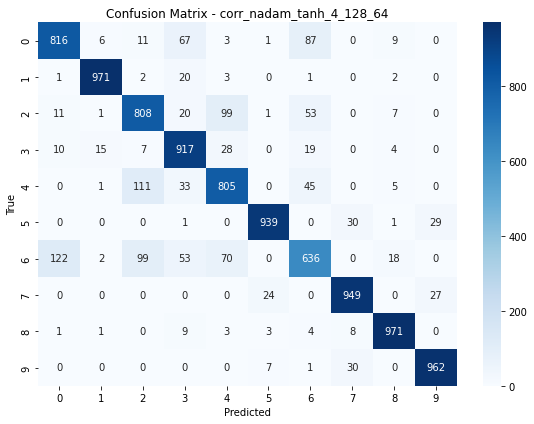

Starting run: corr_nadam_tanh_3_64_32
Epoch 1/10: Loss=0.4829, Acc=0.8277, Val Loss=0.4056, Val Acc=0.8513
Epoch 2/10: Loss=0.3738, Acc=0.8641, Val Loss=0.3718, Val Acc=0.8640
Epoch 3/10: Loss=0.3481, Acc=0.8731, Val Loss=0.3514, Val Acc=0.8672
Epoch 4/10: Loss=0.3332, Acc=0.8783, Val Loss=0.3491, Val Acc=0.8738
Epoch 5/10: Loss=0.3207, Acc=0.8831, Val Loss=0.3562, Val Acc=0.8680
Epoch 6/10: Loss=0.3127, Acc=0.8861, Val Loss=0.3270, Val Acc=0.8752
Epoch 7/10: Loss=0.3060, Acc=0.8870, Val Loss=0.3621, Val Acc=0.8645
Epoch 8/10: Loss=0.2986, Acc=0.8905, Val Loss=0.3269, Val Acc=0.8805
Epoch 9/10: Loss=0.2965, Acc=0.8916, Val Loss=0.3248, Val Acc=0.8802
Epoch 10/10: Loss=0.2934, Acc=0.8914, Val Loss=0.3293, Val Acc=0.8773
Test Accuracy: 0.8697
Test Accuracy for corr_nadam_tanh_3_64_32: 86.97%


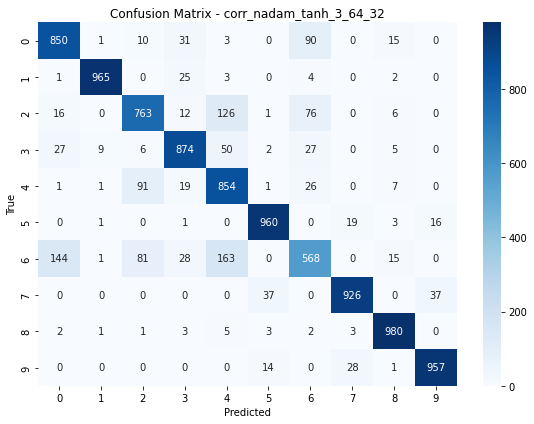

Starting run: corr_adam_relu_5_64_64
Epoch 1/10: Loss=0.5808, Acc=0.7937, Val Loss=0.4220, Val Acc=0.8520
Epoch 2/10: Loss=0.3998, Acc=0.8561, Val Loss=0.3952, Val Acc=0.8580
Epoch 3/10: Loss=0.3676, Acc=0.8663, Val Loss=0.3896, Val Acc=0.8555
Epoch 4/10: Loss=0.3457, Acc=0.8739, Val Loss=0.3744, Val Acc=0.8635
Epoch 5/10: Loss=0.3349, Acc=0.8774, Val Loss=0.3488, Val Acc=0.8680
Epoch 6/10: Loss=0.3222, Acc=0.8829, Val Loss=0.3599, Val Acc=0.8692
Epoch 7/10: Loss=0.3119, Acc=0.8855, Val Loss=0.3430, Val Acc=0.8770
Epoch 8/10: Loss=0.3054, Acc=0.8871, Val Loss=0.3336, Val Acc=0.8728
Epoch 9/10: Loss=0.2986, Acc=0.8890, Val Loss=0.3538, Val Acc=0.8703
Epoch 10/10: Loss=0.2936, Acc=0.8911, Val Loss=0.3193, Val Acc=0.8833
Test Accuracy: 0.8772
Test Accuracy for corr_adam_relu_5_64_64: 87.72%


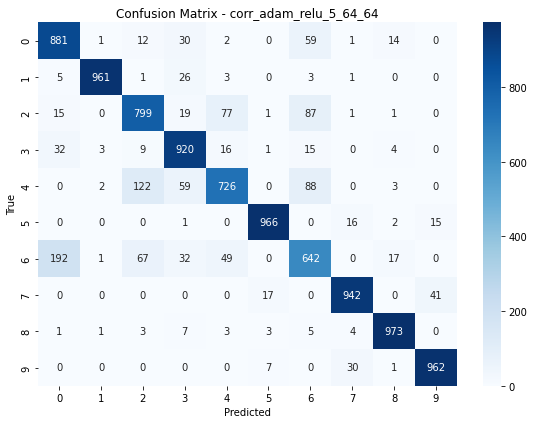

Starting run: corr_nadam_tanh_4_128_16
Epoch 1/10: Loss=0.4925, Acc=0.8188, Val Loss=0.4979, Val Acc=0.8158
Epoch 2/10: Loss=0.4103, Acc=0.8505, Val Loss=0.4736, Val Acc=0.8272
Epoch 3/10: Loss=0.3927, Acc=0.8562, Val Loss=0.3772, Val Acc=0.8540
Epoch 4/10: Loss=0.3805, Acc=0.8596, Val Loss=0.3865, Val Acc=0.8563
Epoch 5/10: Loss=0.3702, Acc=0.8639, Val Loss=0.3576, Val Acc=0.8698
Epoch 6/10: Loss=0.3635, Acc=0.8674, Val Loss=0.3914, Val Acc=0.8583
Epoch 7/10: Loss=0.3552, Acc=0.8716, Val Loss=0.4008, Val Acc=0.8547
Epoch 8/10: Loss=0.3549, Acc=0.8707, Val Loss=0.4392, Val Acc=0.8353
Epoch 9/10: Loss=0.3481, Acc=0.8731, Val Loss=0.3477, Val Acc=0.8720
Epoch 10/10: Loss=0.3429, Acc=0.8751, Val Loss=0.3564, Val Acc=0.8682
Test Accuracy: 0.8629
Test Accuracy for corr_nadam_tanh_4_128_16: 86.29%


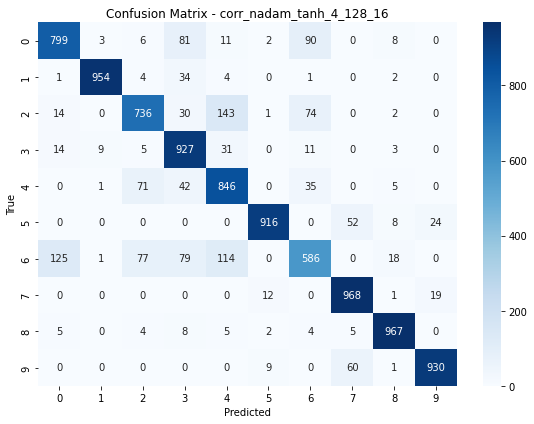

Starting run: corr_adam_tanh_3_128_32
Epoch 1/10: Loss=0.4860, Acc=0.8234, Val Loss=0.4235, Val Acc=0.8433
Epoch 2/10: Loss=0.3954, Acc=0.8542, Val Loss=0.3870, Val Acc=0.8587
Epoch 3/10: Loss=0.3669, Acc=0.8639, Val Loss=0.3736, Val Acc=0.8555
Epoch 4/10: Loss=0.3528, Acc=0.8695, Val Loss=0.3662, Val Acc=0.8638
Epoch 5/10: Loss=0.3437, Acc=0.8728, Val Loss=0.3638, Val Acc=0.8658
Epoch 6/10: Loss=0.3393, Acc=0.8738, Val Loss=0.3685, Val Acc=0.8643
Epoch 7/10: Loss=0.3294, Acc=0.8792, Val Loss=0.3507, Val Acc=0.8723
Epoch 8/10: Loss=0.3244, Acc=0.8784, Val Loss=0.3383, Val Acc=0.8738
Epoch 9/10: Loss=0.3218, Acc=0.8808, Val Loss=0.3587, Val Acc=0.8678
Epoch 10/10: Loss=0.3182, Acc=0.8826, Val Loss=0.3512, Val Acc=0.8737
Test Accuracy: 0.8650
Test Accuracy for corr_adam_tanh_3_128_32: 86.50%


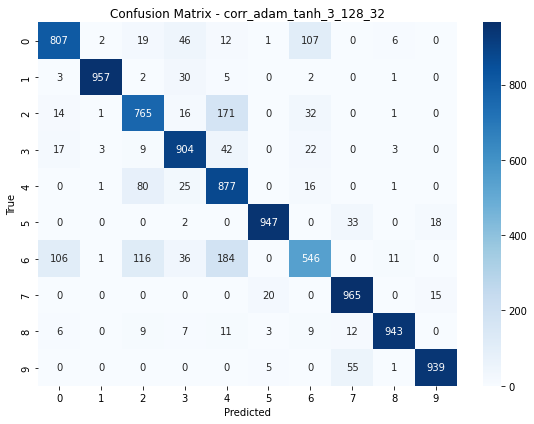

Starting run: corr_nadam_tanh_4_32_32
Epoch 1/10: Loss=0.5374, Acc=0.8157, Val Loss=0.4069, Val Acc=0.8532
Epoch 2/10: Loss=0.3859, Acc=0.8606, Val Loss=0.3776, Val Acc=0.8665
Epoch 3/10: Loss=0.3576, Acc=0.8704, Val Loss=0.3715, Val Acc=0.8627
Epoch 4/10: Loss=0.3425, Acc=0.8749, Val Loss=0.3452, Val Acc=0.8767
Epoch 5/10: Loss=0.3288, Acc=0.8806, Val Loss=0.3494, Val Acc=0.8718
Epoch 6/10: Loss=0.3208, Acc=0.8840, Val Loss=0.3382, Val Acc=0.8702
Epoch 7/10: Loss=0.3132, Acc=0.8859, Val Loss=0.3312, Val Acc=0.8788
Epoch 8/10: Loss=0.3053, Acc=0.8892, Val Loss=0.3577, Val Acc=0.8697
Epoch 9/10: Loss=0.3019, Acc=0.8900, Val Loss=0.3292, Val Acc=0.8788
Epoch 10/10: Loss=0.2977, Acc=0.8906, Val Loss=0.3453, Val Acc=0.8728
Test Accuracy: 0.8673
Test Accuracy for corr_nadam_tanh_4_32_32: 86.73%


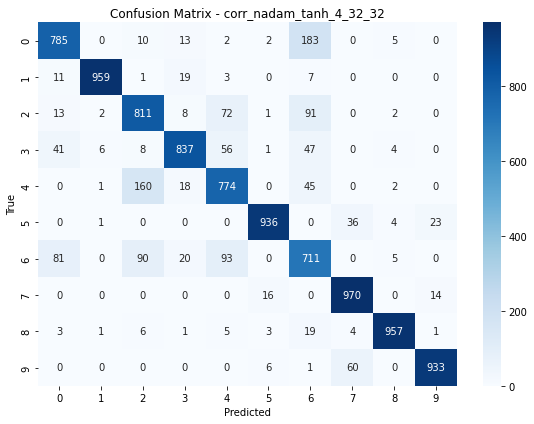

Starting run: corr_nadam_relu_5_64_32
Epoch 1/10: Loss=0.5274, Acc=0.8113, Val Loss=0.4245, Val Acc=0.8433
Epoch 2/10: Loss=0.3891, Acc=0.8576, Val Loss=0.4497, Val Acc=0.8378
Epoch 3/10: Loss=0.3607, Acc=0.8691, Val Loss=0.3731, Val Acc=0.8643
Epoch 4/10: Loss=0.3425, Acc=0.8772, Val Loss=0.3567, Val Acc=0.8695
Epoch 5/10: Loss=0.3282, Acc=0.8801, Val Loss=0.3637, Val Acc=0.8685
Epoch 6/10: Loss=0.3203, Acc=0.8822, Val Loss=0.3518, Val Acc=0.8705
Epoch 7/10: Loss=0.3126, Acc=0.8860, Val Loss=0.3600, Val Acc=0.8715
Epoch 8/10: Loss=0.3059, Acc=0.8866, Val Loss=0.3351, Val Acc=0.8782
Epoch 9/10: Loss=0.3022, Acc=0.8887, Val Loss=0.3632, Val Acc=0.8653
Epoch 10/10: Loss=0.2958, Acc=0.8897, Val Loss=0.3573, Val Acc=0.8710
Test Accuracy: 0.8599
Test Accuracy for corr_nadam_relu_5_64_32: 85.99%


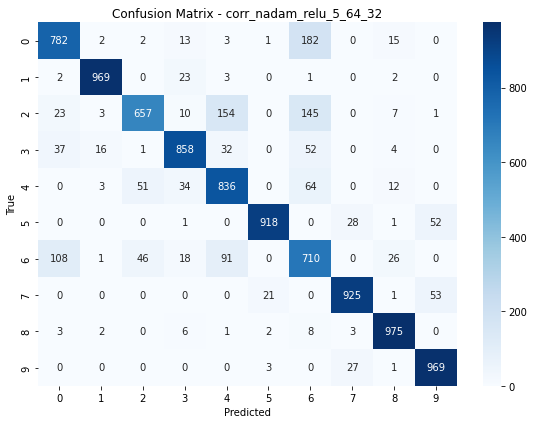

Starting run: corr_nadam_tanh_4_64_64
Epoch 1/10: Loss=0.4988, Acc=0.8257, Val Loss=0.3950, Val Acc=0.8583
Epoch 2/10: Loss=0.3739, Acc=0.8645, Val Loss=0.3771, Val Acc=0.8578
Epoch 3/10: Loss=0.3436, Acc=0.8755, Val Loss=0.3479, Val Acc=0.8700
Epoch 4/10: Loss=0.3265, Acc=0.8794, Val Loss=0.3753, Val Acc=0.8632
Epoch 5/10: Loss=0.3125, Acc=0.8862, Val Loss=0.3482, Val Acc=0.8717
Epoch 6/10: Loss=0.3033, Acc=0.8880, Val Loss=0.3253, Val Acc=0.8807
Epoch 7/10: Loss=0.2932, Acc=0.8918, Val Loss=0.3337, Val Acc=0.8757
Epoch 8/10: Loss=0.2881, Acc=0.8941, Val Loss=0.3421, Val Acc=0.8762
Epoch 9/10: Loss=0.2824, Acc=0.8961, Val Loss=0.3285, Val Acc=0.8783
Epoch 10/10: Loss=0.2760, Acc=0.8976, Val Loss=0.3203, Val Acc=0.8802
Test Accuracy: 0.8755
Test Accuracy for corr_nadam_tanh_4_64_64: 87.55%


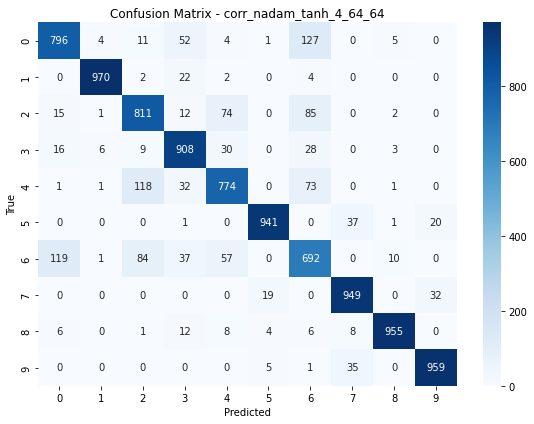

In [9]:
import wandb

# List of configurations you want to try
config_list = [
    {"run_name": "corr_nadam_tanh_3_128_64", "optimizer": "nadam", "activation": "tanh", "num_layers": 3, "hidden_size": 128, "batch_size": 64},
    {"run_name": "corr_nadam_tanh_4_64_64",   "optimizer": "nadam", "activation": "tanh", "num_layers": 4, "hidden_size": 64,  "batch_size": 64},
    {"run_name": "corr_nadam_tanh_4_128_64",  "optimizer": "nadam", "activation": "tanh", "num_layers": 4, "hidden_size": 128, "batch_size": 64},
    {"run_name": "corr_nadam_tanh_3_64_32",   "optimizer": "nadam", "activation": "tanh", "num_layers": 3, "hidden_size": 64,  "batch_size": 32},
    {"run_name": "corr_adam_relu_5_64_64",    "optimizer": "adam",  "activation": "relu", "num_layers": 5, "hidden_size": 64,  "batch_size": 64},
    {"run_name": "corr_nadam_tanh_4_128_16",  "optimizer": "nadam", "activation": "tanh", "num_layers": 4, "hidden_size": 128, "batch_size": 16},
    {"run_name": "corr_adam_tanh_3_128_32",   "optimizer": "adam",  "activation": "tanh", "num_layers": 3, "hidden_size": 128, "batch_size": 32},
    {"run_name": "corr_nadam_tanh_4_32_32",   "optimizer": "nadam", "activation": "tanh", "num_layers": 4, "hidden_size": 32,  "batch_size": 32},
    {"run_name": "corr_nadam_relu_5_64_32",   "optimizer": "nadam", "activation": "relu", "num_layers": 5, "hidden_size": 64,  "batch_size": 32},
    {"run_name": "corr_nadam_tanh_4_64_64",   "optimizer": "nadam", "activation": "tanh", "num_layers": 4, "hidden_size": 64,  "batch_size": 64}
]

# Common hyperparameters (you can adjust these as needed)
common_params = {
    "epochs": 10,
    "learning_rate": 0.001,
    "weight_decay": 0.0005,
    "weight_init": "xavier",
    "loss": "cross_entropy",
    "momentum": 0.9,
    "beta": 0.9,
    "beta1": 0.9,
    "beta2": 0.999,
    "epsilon": 1e-8
}

# Loop through each configuration and run training, evaluation, and logging.
for cfg in config_list:
    # Initialize a new Wandb run with the custom run name.
    run_name = cfg["run_name"]
    wandb.init(project="DL_Assignment_01", name=run_name)
    config = wandb.config
    
    # Set common parameters
    config.epochs = common_params["epochs"]
    config.learning_rate = common_params["learning_rate"]
    config.weight_decay = common_params["weight_decay"]
    config.weight_init = common_params["weight_init"]
    config.loss = common_params["loss"]
    config.momentum = common_params["momentum"]
    config.beta = common_params["beta"]
    config.beta1 = common_params["beta1"]
    config.beta2 = common_params["beta2"]
    config.epsilon = common_params["epsilon"]
    
    # Set configuration-specific parameters
    config.batch_size = cfg["batch_size"]
    config.num_layers = cfg["num_layers"]
    config.hidden_size = cfg["hidden_size"]
    config.activation = cfg["activation"]
    config.optimizer = cfg["optimizer"]
    
    print("Starting run:", run_name)
    
    # Load and preprocess data
    X_train, y_train, X_val, y_val, X_test, y_test = load_data("fashion_mnist")
    input_size = X_train.shape[1]  # 784 for 28x28 images
    output_size = 10               # 10 classes
    hidden_sizes = [config.hidden_size] * config.num_layers
    
    # Initialize the Neural Network and Optimizer
    network = NeuralNetwork(input_size, hidden_sizes, output_size, 
                            activation=config.activation, 
                            weight_init=config.weight_init, 
                            loss_func=config.loss)
    optimizer = Optimizer(network.params, config.optimizer, config.learning_rate,
                          momentum=config.momentum, beta=config.beta,
                          beta1=config.beta1, beta2=config.beta2,
                          epsilon=config.epsilon, weight_decay=config.weight_decay)
    
    # Train the model and log training/validation metrics to Wandb
    network = train_model(network, optimizer, X_train, y_train, X_val, y_val, 
                          config.epochs, config.batch_size)
    
    # Evaluate the model on the test set
    predictions, true_labels, test_acc = evaluate_model(network, X_test, y_test)
    print("Test Accuracy for {}: {:.2f}%".format(run_name, test_acc * 100))
    
    # Plot and log the confusion matrix
    classes = [str(i) for i in range(10)]
    plot_conf_matrix(true_labels, predictions, classes, title="Confusion Matrix - " + run_name)
    
    wandb.finish()


Starting run: new_corr_nadam_tanh_3_128_64
Epoch 1/10: Loss=0.4736, Acc=0.8311, Val Loss=0.3858, Val Acc=0.8510
Epoch 2/10: Loss=0.3724, Acc=0.8657, Val Loss=0.3560, Val Acc=0.8672
Epoch 3/10: Loss=0.3458, Acc=0.8731, Val Loss=0.3525, Val Acc=0.8692
Epoch 4/10: Loss=0.3289, Acc=0.8793, Val Loss=0.3574, Val Acc=0.8720
Epoch 5/10: Loss=0.3152, Acc=0.8833, Val Loss=0.3450, Val Acc=0.8765
Epoch 6/10: Loss=0.3054, Acc=0.8870, Val Loss=0.3466, Val Acc=0.8727
Epoch 7/10: Loss=0.2996, Acc=0.8885, Val Loss=0.3332, Val Acc=0.8813
Epoch 8/10: Loss=0.2952, Acc=0.8905, Val Loss=0.3556, Val Acc=0.8680
Epoch 9/10: Loss=0.2871, Acc=0.8922, Val Loss=0.3280, Val Acc=0.8795
Epoch 10/10: Loss=0.2841, Acc=0.8953, Val Loss=0.3206, Val Acc=0.8838
Test Accuracy: 0.8750
Test Accuracy for new_corr_nadam_tanh_3_128_64: 87.50%


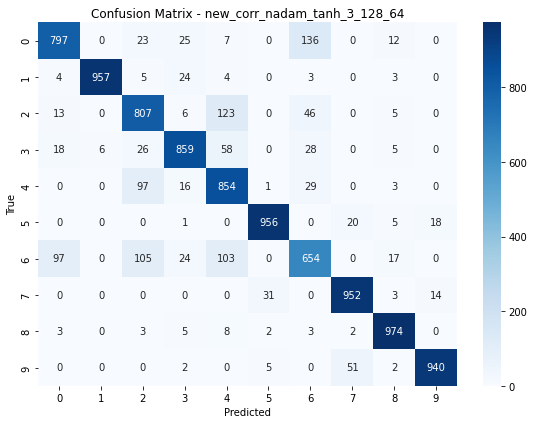

Starting run: new_corr_nadam_tanh_4_64_64
Epoch 1/10: Loss=0.4982, Acc=0.8230, Val Loss=0.3924, Val Acc=0.8520
Epoch 2/10: Loss=0.3726, Acc=0.8646, Val Loss=0.3717, Val Acc=0.8658
Epoch 3/10: Loss=0.3418, Acc=0.8759, Val Loss=0.3493, Val Acc=0.8723
Epoch 4/10: Loss=0.3255, Acc=0.8806, Val Loss=0.3294, Val Acc=0.8785
Epoch 5/10: Loss=0.3158, Acc=0.8853, Val Loss=0.3337, Val Acc=0.8792
Epoch 6/10: Loss=0.3041, Acc=0.8886, Val Loss=0.3455, Val Acc=0.8713
Epoch 7/10: Loss=0.2969, Acc=0.8907, Val Loss=0.3417, Val Acc=0.8748
Epoch 8/10: Loss=0.2883, Acc=0.8932, Val Loss=0.3246, Val Acc=0.8817
Epoch 9/10: Loss=0.2851, Acc=0.8948, Val Loss=0.3289, Val Acc=0.8770
Epoch 10/10: Loss=0.2789, Acc=0.8976, Val Loss=0.3170, Val Acc=0.8862
Test Accuracy: 0.8755
Test Accuracy for new_corr_nadam_tanh_4_64_64: 87.55%


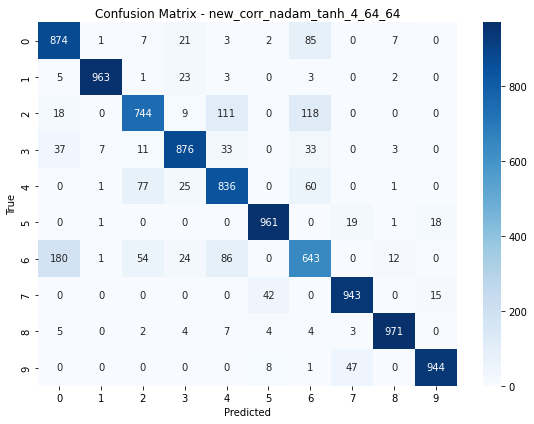

Starting run: new_corr_nadam_tanh_4_128_64
Epoch 1/10: Loss=0.4699, Acc=0.8299, Val Loss=0.3944, Val Acc=0.8547
Epoch 2/10: Loss=0.3713, Acc=0.8650, Val Loss=0.3740, Val Acc=0.8670
Epoch 3/10: Loss=0.3479, Acc=0.8732, Val Loss=0.3622, Val Acc=0.8727
Epoch 4/10: Loss=0.3323, Acc=0.8772, Val Loss=0.3687, Val Acc=0.8663
Epoch 5/10: Loss=0.3200, Acc=0.8821, Val Loss=0.3500, Val Acc=0.8715
Epoch 6/10: Loss=0.3122, Acc=0.8847, Val Loss=0.3267, Val Acc=0.8778
Epoch 7/10: Loss=0.3050, Acc=0.8861, Val Loss=0.3270, Val Acc=0.8833
Epoch 8/10: Loss=0.2986, Acc=0.8893, Val Loss=0.3145, Val Acc=0.8893
Epoch 9/10: Loss=0.2932, Acc=0.8919, Val Loss=0.3282, Val Acc=0.8827
Epoch 10/10: Loss=0.2894, Acc=0.8930, Val Loss=0.3225, Val Acc=0.8818
Test Accuracy: 0.8717
Test Accuracy for new_corr_nadam_tanh_4_128_64: 87.17%


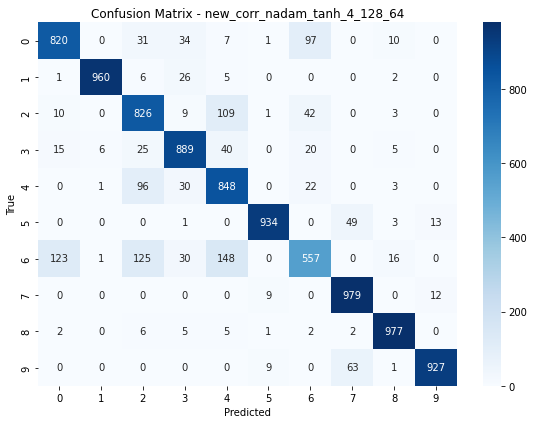

Starting run: new_corr_nadam_tanh_3_64_32
Epoch 1/10: Loss=0.4803, Acc=0.8279, Val Loss=0.3937, Val Acc=0.8552
Epoch 2/10: Loss=0.3755, Acc=0.8626, Val Loss=0.3693, Val Acc=0.8652
Epoch 3/10: Loss=0.3507, Acc=0.8716, Val Loss=0.4087, Val Acc=0.8463
Epoch 4/10: Loss=0.3376, Acc=0.8756, Val Loss=0.3620, Val Acc=0.8638
Epoch 5/10: Loss=0.3217, Acc=0.8819, Val Loss=0.3801, Val Acc=0.8643
Epoch 6/10: Loss=0.3171, Acc=0.8824, Val Loss=0.3782, Val Acc=0.8583
Epoch 7/10: Loss=0.3087, Acc=0.8862, Val Loss=0.3343, Val Acc=0.8760
Epoch 8/10: Loss=0.3031, Acc=0.8889, Val Loss=0.3564, Val Acc=0.8725
Epoch 9/10: Loss=0.2989, Acc=0.8902, Val Loss=0.3258, Val Acc=0.8813
Epoch 10/10: Loss=0.2933, Acc=0.8915, Val Loss=0.3252, Val Acc=0.8815
Test Accuracy: 0.8716
Test Accuracy for new_corr_nadam_tanh_3_64_32: 87.16%


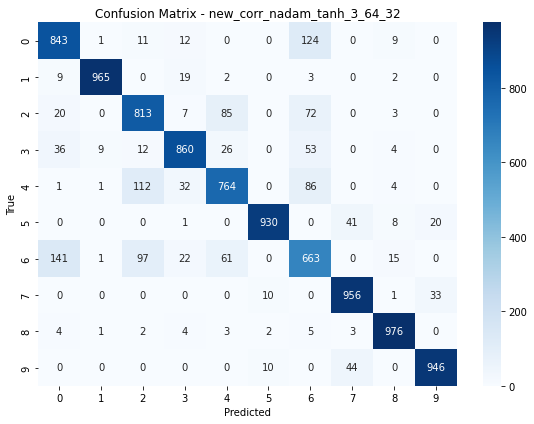

In [11]:
import wandb

# List of configurations you want to try
config_list = [
    {"run_name": "new_corr_nadam_tanh_3_128_64", "optimizer": "nadam", "activation": "tanh", "num_layers": 3, "hidden_size": 128, "batch_size": 64},
    {"run_name": "new_corr_nadam_tanh_4_64_64",   "optimizer": "nadam", "activation": "tanh", "num_layers": 4, "hidden_size": 64,  "batch_size": 64},
    {"run_name": "new_corr_nadam_tanh_4_128_64",  "optimizer": "nadam", "activation": "tanh", "num_layers": 4, "hidden_size": 128, "batch_size": 64},
    {"run_name": "new_corr_nadam_tanh_3_64_32",   "optimizer": "nadam", "activation": "tanh", "num_layers": 3, "hidden_size": 64,  "batch_size": 32},
    # {"run_name": "new_corr_adam_relu_5_64_64",    "optimizer": "adam",  "activation": "relu", "num_layers": 5, "hidden_size": 64,  "batch_size": 64},
    # {"run_name": "new_corr_nadam_tanh_4_128_16",  "optimizer": "nadam", "activation": "tanh", "num_layers": 4, "hidden_size": 128, "batch_size": 16},
    # {"run_name": "new_corr_adam_tanh_3_128_32",   "optimizer": "adam",  "activation": "tanh", "num_layers": 3, "hidden_size": 128, "batch_size": 32},
    # {"run_name": "new_corr_nadam_tanh_4_32_32",   "optimizer": "nadam", "activation": "tanh", "num_layers": 4, "hidden_size": 32,  "batch_size": 32},
    # {"run_name": "new_corr_nadam_relu_5_64_32",   "optimizer": "nadam", "activation": "relu", "num_layers": 5, "hidden_size": 64,  "batch_size": 32},
    # {"run_name": "new_corr_nadam_tanh_4_64_64",   "optimizer": "nadam", "activation": "tanh", "num_layers": 4, "hidden_size": 64,  "batch_size": 64}
]

# Common hyperparameters (you can adjust these as needed)
common_params = {
    "epochs": 10,
    "learning_rate": 0.001,
    "weight_decay": 0.0005,
    "weight_init": "xavier",
    "loss": "cross_entropy",
    "momentum": 0.9,
    "beta": 0.9,
    "beta1": 0.9,
    "beta2": 0.999,
    "epsilon": 1e-8
}

# Loop through each configuration and run training, evaluation, and logging.
for cfg in config_list:
    # Initialize a new Wandb run with the custom run name.
    run_name = cfg["run_name"]
    wandb.init(project="DL_Assignment_01", name=run_name)
    config = wandb.config
    
    # Set common parameters
    config.epochs = common_params["epochs"]
    config.learning_rate = common_params["learning_rate"]
    config.weight_decay = common_params["weight_decay"]
    config.weight_init = common_params["weight_init"]
    config.loss = common_params["loss"]
    config.momentum = common_params["momentum"]
    config.beta = common_params["beta"]
    config.beta1 = common_params["beta1"]
    config.beta2 = common_params["beta2"]
    config.epsilon = common_params["epsilon"]
    
    # Set configuration-specific parameters
    config.batch_size = cfg["batch_size"]
    config.num_layers = cfg["num_layers"]
    config.hidden_size = cfg["hidden_size"]
    config.activation = cfg["activation"]
    config.optimizer = cfg["optimizer"]
    
    print("Starting run:", run_name)
    
    # Load and preprocess data
    X_train, y_train, X_val, y_val, X_test, y_test = load_data("fashion_mnist")
    input_size = X_train.shape[1]  # 784 for 28x28 images
    output_size = 10               # 10 classes
    hidden_sizes = [config.hidden_size] * config.num_layers
    
    # Initialize the Neural Network and Optimizer
    network = NeuralNetwork(input_size, hidden_sizes, output_size, 
                            activation=config.activation, 
                            weight_init=config.weight_init, 
                            loss_func=config.loss)
    optimizer = Optimizer(network.params, config.optimizer, config.learning_rate,
                          momentum=config.momentum, beta=config.beta,
                          beta1=config.beta1, beta2=config.beta2,
                          epsilon=config.epsilon, weight_decay=config.weight_decay)
    
    # Train the model and log training/validation metrics to Wandb
    network = train_model(network, optimizer, X_train, y_train, X_val, y_val, 
                          config.epochs, config.batch_size)
    
    # Evaluate the model on the test set
    predictions, true_labels, test_acc = evaluate_model(network, X_test, y_test)
    print("Test Accuracy for {}: {:.2f}%".format(run_name, test_acc * 100))
    
    # Plot and log the confusion matrix
    classes = [str(i) for i in range(10)]
    plot_conf_matrix(true_labels, predictions, classes, title="Confusion Matrix - " + run_name)
    
    wandb.finish()


Starting run: new_corr_nadam_tanh_3_128_64_full
Epoch 1/10: Loss=0.4629, Acc=0.8329
Epoch 2/10: Loss=0.3656, Acc=0.8662
Epoch 3/10: Loss=0.3395, Acc=0.8756
Epoch 4/10: Loss=0.3223, Acc=0.8810
Epoch 5/10: Loss=0.3119, Acc=0.8839
Epoch 6/10: Loss=0.3033, Acc=0.8881
Epoch 7/10: Loss=0.2975, Acc=0.8894
Epoch 8/10: Loss=0.2903, Acc=0.8929
Epoch 9/10: Loss=0.2885, Acc=0.8918
Epoch 10/10: Loss=0.2828, Acc=0.8958
Test Accuracy: 0.8683
Test Accuracy for new_corr_nadam_tanh_3_128_64_full: 86.83%


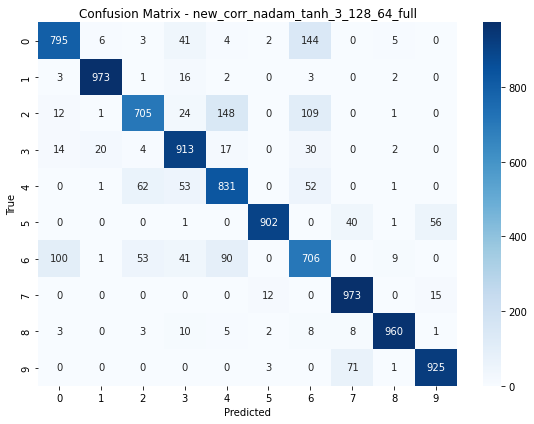

Starting run: new_corr_nadam_tanh_4_64_64_full
Epoch 1/10: Loss=0.4847, Acc=0.8290
Epoch 2/10: Loss=0.3685, Acc=0.8653
Epoch 3/10: Loss=0.3411, Acc=0.8762
Epoch 4/10: Loss=0.3246, Acc=0.8824
Epoch 5/10: Loss=0.3129, Acc=0.8850
Epoch 6/10: Loss=0.3041, Acc=0.8875
Epoch 7/10: Loss=0.2955, Acc=0.8918
Epoch 8/10: Loss=0.2902, Acc=0.8927
Epoch 9/10: Loss=0.2841, Acc=0.8960
Epoch 10/10: Loss=0.2795, Acc=0.8977
Test Accuracy: 0.8715
Test Accuracy for new_corr_nadam_tanh_4_64_64_full: 87.15%


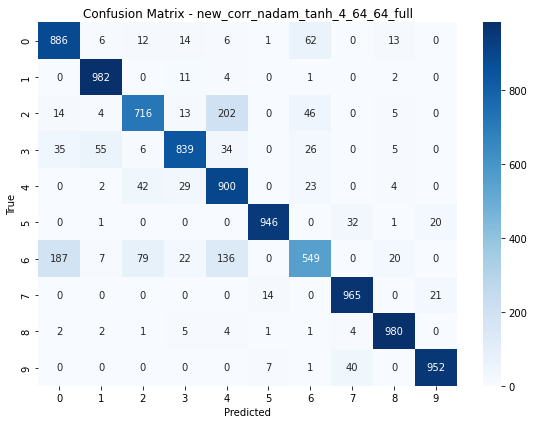

Starting run: new_corr_nadam_tanh_4_128_64_full
Epoch 1/10: Loss=0.4630, Acc=0.8321
Epoch 2/10: Loss=0.3670, Acc=0.8662
Epoch 3/10: Loss=0.3421, Acc=0.8746
Epoch 4/10: Loss=0.3273, Acc=0.8801
Epoch 5/10: Loss=0.3189, Acc=0.8821
Epoch 6/10: Loss=0.3098, Acc=0.8853
Epoch 7/10: Loss=0.3028, Acc=0.8878
Epoch 8/10: Loss=0.2987, Acc=0.8890
Epoch 9/10: Loss=0.2929, Acc=0.8919
Epoch 10/10: Loss=0.2874, Acc=0.8934
Test Accuracy: 0.8715
Test Accuracy for new_corr_nadam_tanh_4_128_64_full: 87.15%


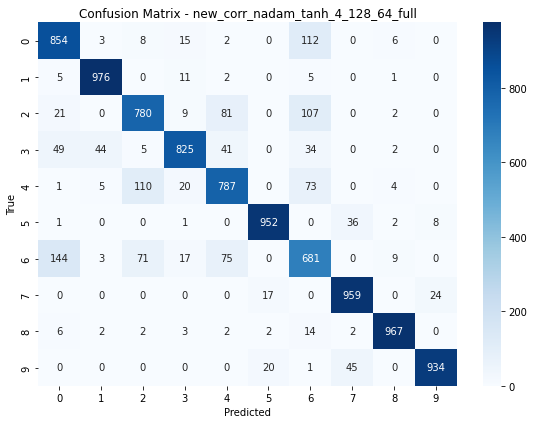

Starting run: new_corr_nadam_tanh_3_64_32_full
Epoch 1/10: Loss=0.4743, Acc=0.8294
Epoch 2/10: Loss=0.3724, Acc=0.8640
Epoch 3/10: Loss=0.3473, Acc=0.8744
Epoch 4/10: Loss=0.3357, Acc=0.8778
Epoch 5/10: Loss=0.3227, Acc=0.8818
Epoch 6/10: Loss=0.3155, Acc=0.8839
Epoch 7/10: Loss=0.3112, Acc=0.8864
Epoch 8/10: Loss=0.3064, Acc=0.8869
Epoch 9/10: Loss=0.3002, Acc=0.8894
Epoch 10/10: Loss=0.2980, Acc=0.8904
Test Accuracy: 0.8571
Test Accuracy for new_corr_nadam_tanh_3_64_32_full: 85.71%


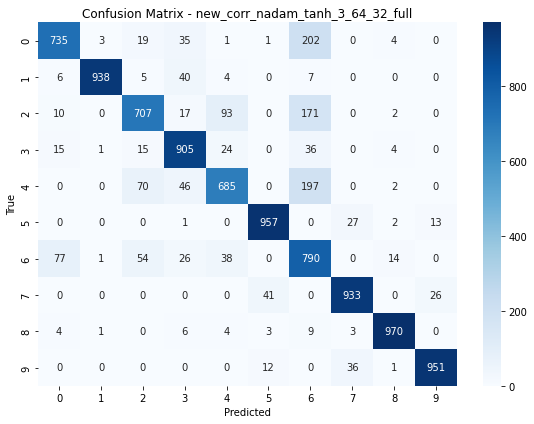

In [13]:
import wandb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split

# ---------------------------
# Modified Data Loading Function (Full Training)
# ---------------------------
def load_data_full(dataset="fashion_mnist"):
    if dataset == "fashion_mnist":
        (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    elif dataset == "mnist":
        from keras.datasets import mnist
        (X_train, y_train), (X_test, y_test) = mnist.load_data()
    else:
        raise ValueError("Unknown dataset.")
    
    # Normalize and reshape data
    X_train = X_train.reshape(X_train.shape[0], -1) / 255.0
    X_test = X_test.reshape(X_test.shape[0], -1) / 255.0
    
    num_classes = 10
    y_train = np.eye(num_classes)[y_train]
    y_test = np.eye(num_classes)[y_test]
    
    # Use full training data (no validation split)
    return X_train, y_train, None, None, X_test, y_test

# ---------------------------
# Modified Training Function (Full Training)
# ---------------------------
def train_model_full(network, optimizer, X_train, y_train, epochs, batch_size):
    num_samples = X_train.shape[0]
    steps_per_epoch = num_samples // batch_size
    for epoch in range(epochs):
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        X_train = X_train[indices]
        y_train = y_train[indices]
        epoch_loss = 0
        epoch_acc = 0
        
        for step in range(steps_per_epoch):
            start = step * batch_size
            end = start + batch_size
            X_batch = X_train[start:end]
            y_batch = y_train[start:end]
            y_pred, cache = network.forward(X_batch)
            loss = network.compute_loss(y_pred, y_batch)
            epoch_loss += loss
            predictions = np.argmax(y_pred, axis=1)
            true_labels = np.argmax(y_batch, axis=1)
            acc = np.mean(predictions == true_labels)
            epoch_acc += acc
            grads = network.backward(X_batch, y_batch, cache)
            optimizer.update(network.params, grads)
        
        epoch_loss /= steps_per_epoch
        epoch_acc /= steps_per_epoch
        
        print(f"Epoch {epoch+1}/{epochs}: Loss={epoch_loss:.4f}, Acc={epoch_acc:.4f}")
        wandb.log({
            "epoch": epoch + 1,
            "loss": epoch_loss,
            "accuracy": epoch_acc
        })
    return network

# ---------------------------
# Modified Confusion Matrix Plot Function (logs to Wandb)
# ---------------------------
def plot_conf_matrix(true_labels, predictions, classes, title="Confusion Matrix"):
    cm = confusion_matrix(true_labels, predictions)
    fig, ax = plt.subplots(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=classes, yticklabels=classes, ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(title)
    plt.tight_layout()
    wandb.log({"Confusion Matrix": wandb.Image(fig)})
    plt.show()
    plt.close(fig)

# ---------------------------
# List of Configurations to Run (Best Models)
# ---------------------------
config_list = [
    {"run_name": "new_corr_nadam_tanh_3_128_64_full", "optimizer": "nadam", "activation": "tanh", "num_layers": 3, "hidden_size": 128, "batch_size": 64},
    {"run_name": "new_corr_nadam_tanh_4_64_64_full",   "optimizer": "nadam", "activation": "tanh", "num_layers": 4, "hidden_size": 64,  "batch_size": 64},
    {"run_name": "new_corr_nadam_tanh_4_128_64_full",  "optimizer": "nadam", "activation": "tanh", "num_layers": 4, "hidden_size": 128, "batch_size": 64},
    {"run_name": "new_corr_nadam_tanh_3_64_32_full",   "optimizer": "nadam", "activation": "tanh", "num_layers": 3, "hidden_size": 64,  "batch_size": 32},
    # You can add more configurations as desired.
]

# ---------------------------
# Common Hyperparameters
# ---------------------------
common_params = {
    "epochs": 10,
    "learning_rate": 0.001,
    "weight_decay": 0.0005,
    "weight_init": "xavier",
    "loss": "cross_entropy",
    "momentum": 0.9,
    "beta": 0.9,
    "beta1": 0.9,
    "beta2": 0.999,
    "epsilon": 1e-8
}

# ---------------------------
# Loop Through Each Configuration and Train on Full Training Data
# ---------------------------
for cfg in config_list:
    run_name = cfg["run_name"]
    wandb.init(project="DL_Assignment_01", name=run_name)
    config = wandb.config
    
    # Set common parameters
    config.epochs = common_params["epochs"]
    config.learning_rate = common_params["learning_rate"]
    config.weight_decay = common_params["weight_decay"]
    config.weight_init = common_params["weight_init"]
    config.loss = common_params["loss"]
    config.momentum = common_params["momentum"]
    config.beta = common_params["beta"]
    config.beta1 = common_params["beta1"]
    config.beta2 = common_params["beta2"]
    config.epsilon = common_params["epsilon"]
    
    # Set configuration-specific parameters
    config.batch_size = cfg["batch_size"]
    config.num_layers = cfg["num_layers"]
    config.hidden_size = cfg["hidden_size"]
    config.activation = cfg["activation"]
    config.optimizer = cfg["optimizer"]
    
    print("Starting run:", run_name)
    
    # Load full training data (without validation split)
    X_train, y_train, _, _, X_test, y_test = load_data_full("fashion_mnist")
    input_size = X_train.shape[1]  # 784 for 28x28 images
    output_size = 10               # 10 classes
    hidden_sizes = [config.hidden_size] * config.num_layers
    
    # Initialize the Neural Network and Optimizer
    network = NeuralNetwork(input_size, hidden_sizes, output_size, 
                            activation=config.activation, 
                            weight_init=config.weight_init, 
                            loss_func=config.loss)
    optimizer = Optimizer(network.params, config.optimizer, config.learning_rate,
                          momentum=config.momentum, beta=config.beta,
                          beta1=config.beta1, beta2=config.beta2,
                          epsilon=config.epsilon, weight_decay=config.weight_decay)
    
    # Train the model on full training data
    network = train_model_full(network, optimizer, X_train, y_train, config.epochs, config.batch_size)
    
    # Evaluate the model on the test set
    predictions, true_labels, test_acc = evaluate_model(network, X_test, y_test)
    print("Test Accuracy for {}: {:.2f}%".format(run_name, test_acc * 100))
    
    # Plot and log the confusion matrix
    classes = [str(i) for i in range(10)]
    plot_conf_matrix(true_labels, predictions, classes, title="Confusion Matrix - " + run_name)
    
    wandb.finish()


In [6]:
import numpy as np
from keras.datasets import fashion_mnist

# Load the Fashion-MNIST dataset
(X_train, y_train), (_, _) = fashion_mnist.load_data()

# Preprocess one sample image: flatten and scale to [0,1]
sample_image = X_train[0].reshape(1, -1) / 255.0

# For testing, initialize the network with example parameters
# (input_size, one hidden layer of size 64, output_size=10)
input_size = sample_image.shape[1]  # 28*28 = 784
hidden_sizes = [64]
output_size = 10

# Create a network instance using your NeuralNetwork class.
# Make sure your class uses softmax on the output layer.
model = NeuralNetwork(input_size, hidden_sizes, output_size, activation="relu", weight_init="xavier", loss_func="cross_entropy")

# Run the forward pass on the sample image
output_distribution, _ = model.forward(sample_image)

# Print the output distribution and verify it sums to 1
print("Output Distribution:", output_distribution)
print("Sum of probabilities:", np.sum(output_distribution))


Output Distribution: [[0.05956064 0.10098628 0.10666361 0.08184834 0.20911503 0.07191097
  0.06679764 0.07492031 0.14337602 0.08482115]]
Sum of probabilities: 0.9999999999999998


In [ ]:
### Feed forward neural network...

import numpy as np
from keras.datasets import fashion_mnist

# writing the forward propagation function below

def forward_propagation(X, W1, b1, W2, b2):
    # First layer
    Z1 = np.dot(X, W1) + b1
    A1 = np.maximum(0, Z1)  # ReLU activation
    # Second layer
    Z2 = np.dot(A1, W2) + b2
    A2 = np.exp(Z2) / np.sum(np.exp(Z2), axis=1, keepdims=True)  # Softmax activation
    return Z1, A1, Z2, A2

# Load the Fashion-MNIST dataset
(X_train, y_train), (_, _) = fashion_mnist.load_data()

# Preprocess one sample image: flatten and scale to [0,1]
sample_image = X_train[0].reshape(1, -1) / 255.0

# For testing, initialize the network with example parameters
# (input_size, one hidden layer of size 64, output_size=10)
input_size = sample_image.shape[1]  # 28*28 = 784
hidden_size = 64
output_size = 10
W1 = np.random.randn(input_size, hidden_size) * 0.01
b1 = np.zeros((1, hidden_size))
W2 = np.random.randn(hidden_size, output_size) * 0.01
b2 = np.zeros((1, output_size))

# Run the forward pass on the sample image
Z1, A1, Z2, A2 = forward_propagation(sample_image, W1, b1, W2, b2)

# Print the output distribution and verify it sums to 1
print("Output Distribution:", A2)
print("Sum of probabilities:", np.sum(A2))



Output Distribution: [[0.09989649 0.10005848 0.09988035 0.10028819 0.10069198 0.10001923
  0.09957533 0.09984086 0.09980419 0.0999449 ]]
Sum of probabilities: 1.0


In [17]:
### Backpropagation...
import numpy as np
from keras.datasets import fashion_mnist

# Load the Fashion-MNIST dataset
(X_train, y_train), (_, _) = fashion_mnist.load_data()

# Preprocess one sample image: flatten and scale to [0,1]
sample_image = X_train[0].reshape(1, -1) / 255.0
sample_label = np.eye(10)[y_train[0]].reshape(1, -1)

# For testing, initialize the network with example parameters
# (input_size, one hidden layer of size 64, output_size=10)
input_size = sample_image.shape[1]  # 28*28 = 784
hidden_size = 64
output_size = 10
W1 = np.random.randn(input_size, hidden_size) * 0.01
b1 = np.zeros((1, hidden_size))
W2 = np.random.randn(hidden_size, output_size) * 0.01
b2 = np.zeros((1, output_size))

W1 = np.random.randn(input_size, hidden_size) * np.sqrt(1/input_size)
b1 = np.zeros((1, hidden_size))
W2 = np.random.randn(hidden_size, output_size) * np.sqrt(1/hidden_size)
b2 = np.zeros((1, output_size))



# Define the ReLU activation and its derivative
def relu(x):
    return np.maximum(0, x)

def drelu(x):
    return (x > 0).astype(float)

# Define the softmax cross-entropy loss and its derivative
def softmax(x):
    exp_shifted = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_shifted / np.sum(exp_shifted, axis=1, keepdims=True)

def cross_entropy_loss(y_pred, y_true):
    eps = 1e-12
    y_pred = np.clip(y_pred, eps, 1 - eps)
    loss = -np.sum(y_true * np.log(y_pred)) / y_pred.shape[0]
    return loss
    
def dsoftmax_cross_entropy(y_pred, y_true):
    return y_pred - y_true
    
# Define the forward propagation function
def forward_propagation(X, W1, b1, W2, b2):
    # First layer
    Z1 = np.dot(X, W1) + b1
    A1 = relu(Z1)
    # Second layer
    Z2 = np.dot(A1, W2) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2
    

# Define the backward propagation function
def backward_propagation(X, Y, Z1, A1, Z2, A2, W1, W2, b1, b2):
    m = X.shape[0]
    dZ2 = dsoftmax_cross_entropy(A2, Y) / m
    dW2 = np.dot(A1.T, dZ2)
    db2 = np.sum(dZ2, axis=0, keepdims=True)
    dA1 = np.dot(dZ2, W2.T)
    dZ1 = dA1 * drelu(Z1)
    dW1 = np.dot(X.T, dZ1)
    db1 = np.sum(dZ1, axis=0, keepdims=True)
    return dW1, db1, dW2, db2
    
# Run the forward pass on the sample image
Z1, A1, Z2, A2 = forward_propagation(sample_image, W1, b1, W2, b2)

print("Output Distribution:", A2)
print("Sum of probabilities:", np.sum(A2))

print(sample_label)
# Compute the loss
loss = cross_entropy_loss(A2, sample_label)
print("Loss:", loss)

# Run the backward pass to get the gradients
dW1, db1, dW2, db2 = backward_propagation(sample_image, sample_label, Z1, A1, Z2, A2, W1, W2, b1, b2)

# Print the gradients
print("dW1:", dW1)
print("db1:", db1)
print("dW2:", dW2)
print("db2:", db2)



Output Distribution: [[0.09431552 0.12771193 0.08795426 0.07637771 0.14160953 0.10646259
  0.0861068  0.0938164  0.11274598 0.07289927]]
Sum of probabilities: 1.0
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Loss: 2.6186766073387537
dW1: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
db1: [[ 0.          0.          0.         -0.15783471 -0.07748646  0.
   0.          0.11317802  0.1769541   0.          0.          0.
  -0.01763823  0.          0.          0.          0.04075311  0.
   0.          0.          0.         -0.05723161  0.16450165  0.
   0.          0.24007364 -0.09735636  0.          0.          0.
   0.          0.03370892  0.05308439  0.         -0.11472456 -0.1579607
   0.10065864  0.          0.18341751  0.13736297  0.          0.
   0.          0.         -0.09121942  0.          0.          0.15275462
   0.          0.          0.         -0.02696876  0.08762267  0.
   

In [26]:
import wandb

sweep_config = {
    'method': 'bayes',  # Use Bayesian optimization; change to "random" if preferred.
    'name': 'sweep-cross-entropy-different-optimizers',
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'epochs': {'values': [5, 10]},
        'hidden_layers': {'values': [3, 4, 5]},
        'hidden_layer_size': {'values': [32, 64, 128]},
        'weight_decay': {'values': [0, 0.0005, 0.5]},
        'learning_rate': {'values': [0.001, 0.0001]},
        'optimiser': {'values': ['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']},
        'batch_size': {'values': [16, 32, 64]},
        'weight_init': {'values': ['random', 'xavier']},
        'activation': {'values': ['sigmoid', 'tanh', 'relu']}
    }
}

sweep_id = wandb.sweep(sweep_config, project="DL_Assignment_01")
print("Sweep ID:", sweep_id)


Create sweep with ID: yk6n6xt2
Sweep URL: https://wandb.ai/da24m016-indian-institute-of-technology-madras/DL_Assignment_01/sweeps/yk6n6xt2
Sweep ID: yk6n6xt2


In [16]:
import wandb

sweep_config = {
    'method': 'bayes',  # Use Bayesian optimization; change to "random" if preferred.
    'name': '350_sweep-cross-entropy-different-optimizers',
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'epochs': {'values': [5, 10]},
        'hidden_layers': {'values': [3, 4, 5]},
        'hidden_layer_size': {'values': [32, 64, 128]},
        'weight_decay': {'values': [0, 0.0005, 0.5]},
        'learning_rate': {'values': [0.001, 0.0001]},
        'optimiser': {'values': ['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']},
        'batch_size': {'values': [16, 32, 64]},
        'weight_init': {'values': ['random', 'xavier']},
        'activation': {'values': ['sigmoid', 'tanh', 'relu']}
    }
}

sweep_id = wandb.sweep(sweep_config, project="DL_Assignment_01")
print("Sweep ID:", sweep_id)


Create sweep with ID: gt4ffzpr
Sweep URL: https://wandb.ai/da24m016-indian-institute-of-technology-madras/DL_Assignment_01/sweeps/gt4ffzpr
Sweep ID: gt4ffzpr


In [1]:
import wandb

sweep_config = {
    "method": "grid",  # Use grid search over the refined hyperparameter space
    "name": "grid_top20_best",
    "metric": {
         "name": "val_accuracy",
         "goal": "maximize"
    },
    "parameters": {
         "epochs": {"values": [10]},                     # Fixed to 5 epochs
         "hidden_layers": {"values": [3, 4, 5]},          # Based on top 20 runs
         "hidden_layer_size": {"values": [128, 64, 32]},  # Based on top 20 runs
         "batch_size": {"values": [64, 32, 16]},          # Based on top 20 runs
         "learning_rate": {"values": [0.001]},            # Fixed
         "optimiser": {"values": ["nadam", "adam"]},      # Top performers
         "weight_init": {"values": ["xavier"]},           # Fixed
         "activation": {"values": ["tanh", "relu"]},        # Top choices
         "weight_decay": {"values": [0.0005]}             # Fixed
    }
}

grid_sweep_id = wandb.sweep(sweep_config, project="DL_Assignment_01")
print("Sweep ID:", grid_sweep_id)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: 9f34spkv
Sweep URL: https://wandb.ai/da24m016-indian-institute-of-technology-madras/DL_Assignment_01/sweeps/9f34spkv
Sweep ID: 9f34spkv


In [8]:
def sweep_train():
    # Initialize a new run; configuration values are pulled from the sweep config.
    run = wandb.init()
    config = wandb.config

    # Set the run name based on the sweep configuration.
    # Note: Keys must match those in the sweep configuration.
    run_name = f"{config.optimiser}_{config.activation}_{config.hidden_layers}_{config.hidden_layer_size}_{config.batch_size}"
    wandb.run.name = run_name
    print("Run Name:", run_name)
    
    # --- Data Loading & Preprocessing ---
    from keras.datasets import fashion_mnist
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    
    # Normalize and reshape images
    X_train = X_train.reshape(X_train.shape[0], -1) / 255.0
    X_test = X_test.reshape(X_test.shape[0], -1) / 255.0
    num_classes = 10
    y_train = np.eye(num_classes)[y_train]
    y_test = np.eye(num_classes)[y_test]
    
    # Split training data: 90% train, 10% validation
    split_index = int(0.9 * X_train.shape[0])
    X_val = X_train[split_index:]
    y_val = y_train[split_index:]
    X_train = X_train[:split_index]
    y_train = y_train[:split_index]
    
    input_size = X_train.shape[1]  # 784 for 28x28 images
    output_size = num_classes
    
    # Create a list of hidden layer sizes
    hidden_sizes = [config.hidden_layer_size] * config.hidden_layers

    # --- Model & Optimizer Initialization ---
    # Assuming NeuralNetwork and Optimizer classes have been defined in previous cells.
    model = NeuralNetwork(input_size, hidden_sizes, output_size, 
                          activation=config.activation, 
                          weight_init=config.weight_init, 
                          loss_func="cross_entropy")
    
    optimizer = Optimizer(model.params, config.optimiser, config.learning_rate,
                          momentum=0.9, beta=0.9, beta1=0.9, beta2=0.999,
                          epsilon=1e-8, weight_decay=config.weight_decay)
    
    # --- Training ---
    # Assuming train_model is a function that trains the model and logs per-epoch metrics.
    model = train_model(model, optimizer, X_train, y_train, X_val, y_val, 
                        epochs=config.epochs, batch_size=config.batch_size)
    
    # --- Evaluation on Validation Set ---
    y_val_pred, _ = model.forward(X_val)
    val_loss = model.compute_loss(y_val_pred, y_val)
    predictions_val = np.argmax(y_val_pred, axis=1)
    true_labels_val = np.argmax(y_val, axis=1)
    val_acc = np.mean(predictions_val == true_labels_val)
    
    # Log final validation metrics
    wandb.log({
        "final_val_loss": val_loss,
        "final_val_accuracy": val_acc
    })
    
    run.finish()


In [9]:
wandb.agent(grid_sweep_id, function=sweep_train, count=108)
print("Sweep Grid completed!")

wandb: Agent Starting Run: 2mqk56l5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_3_128_64
Epoch 1/10: Loss=0.4704, Acc=0.8309, Val Loss=0.4081, Val Acc=0.8473
Epoch 2/10: Loss=0.3685, Acc=0.8653, Val Loss=0.3964, Val Acc=0.8482
Epoch 3/10: Loss=0.3437, Acc=0.8746, Val Loss=0.3526, Val Acc=0.8698
Epoch 4/10: Loss=0.3259, Acc=0.8799, Val Loss=0.3788, Val Acc=0.8628
Epoch 5/10: Loss=0.3140, Acc=0.8837, Val Loss=0.3385, Val Acc=0.8728
Epoch 6/10: Loss=0.3046, Acc=0.8885, Val Loss=0.3558, Val Acc=0.8703
Epoch 7/10: Loss=0.2987, Acc=0.8900, Val Loss=0.3338, Val Acc=0.8798
Epoch 8/10: Loss=0.2915, Acc=0.8917, Val Loss=0.3264, Val Acc=0.8740
Epoch 9/10: Loss=0.2856, Acc=0.8946, Val Loss=0.3230, Val Acc=0.8788
Epoch 10/10: Loss=0.2803, Acc=0.8963, Val Loss=0.3167, Val Acc=0.8843


wandb: Agent Starting Run: wkd0t81w with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_3_128_64
Epoch 1/10: Loss=0.4976, Acc=0.8187, Val Loss=0.4108, Val Acc=0.8467
Epoch 2/10: Loss=0.3853, Acc=0.8596, Val Loss=0.3611, Val Acc=0.8650
Epoch 3/10: Loss=0.3571, Acc=0.8690, Val Loss=0.3836, Val Acc=0.8528
Epoch 4/10: Loss=0.3422, Acc=0.8731, Val Loss=0.4292, Val Acc=0.8387
Epoch 5/10: Loss=0.3278, Acc=0.8788, Val Loss=0.3359, Val Acc=0.8698
Epoch 6/10: Loss=0.3217, Acc=0.8814, Val Loss=0.3399, Val Acc=0.8722
Epoch 7/10: Loss=0.3144, Acc=0.8847, Val Loss=0.3696, Val Acc=0.8690
Epoch 8/10: Loss=0.3055, Acc=0.8867, Val Loss=0.3418, Val Acc=0.8733
Epoch 9/10: Loss=0.3021, Acc=0.8884, Val Loss=0.3499, Val Acc=0.8708
Epoch 10/10: Loss=0.2999, Acc=0.8895, Val Loss=0.3391, Val Acc=0.8725


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: j69jax3o with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_4_128_64
Epoch 1/10: Loss=0.4746, Acc=0.8281, Val Loss=0.3964, Val Acc=0.8608
Epoch 2/10: Loss=0.3737, Acc=0.8648, Val Loss=0.3791, Val Acc=0.8588
Epoch 3/10: Loss=0.3453, Acc=0.8740, Val Loss=0.3555, Val Acc=0.8680
Epoch 4/10: Loss=0.3298, Acc=0.8794, Val Loss=0.3652, Val Acc=0.8683
Epoch 5/10: Loss=0.3215, Acc=0.8815, Val Loss=0.3294, Val Acc=0.8810
Epoch 6/10: Loss=0.3091, Acc=0.8870, Val Loss=0.3338, Val Acc=0.8777
Epoch 7/10: Loss=0.3039, Acc=0.8872, Val Loss=0.3184, Val Acc=0.8835
Epoch 8/10: Loss=0.2975, Acc=0.8901, Val Loss=0.3611, Val Acc=0.8692
Epoch 9/10: Loss=0.2922, Acc=0.8932, Val Loss=0.3413, Val Acc=0.8793
Epoch 10/10: Loss=0.2880, Acc=0.8938, Val Loss=0.3242, Val Acc=0.8803


wandb: Agent Starting Run: 3q00j7p7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_4_128_64
Epoch 1/10: Loss=0.4989, Acc=0.8196, Val Loss=0.4413, Val Acc=0.8320
Epoch 2/10: Loss=0.3911, Acc=0.8573, Val Loss=0.3784, Val Acc=0.8638
Epoch 3/10: Loss=0.3649, Acc=0.8656, Val Loss=0.3672, Val Acc=0.8610
Epoch 4/10: Loss=0.3489, Acc=0.8718, Val Loss=0.3739, Val Acc=0.8627
Epoch 5/10: Loss=0.3359, Acc=0.8762, Val Loss=0.3544, Val Acc=0.8688
Epoch 6/10: Loss=0.3305, Acc=0.8766, Val Loss=0.3477, Val Acc=0.8725
Epoch 7/10: Loss=0.3228, Acc=0.8798, Val Loss=0.3406, Val Acc=0.8753
Epoch 8/10: Loss=0.3114, Acc=0.8847, Val Loss=0.3813, Val Acc=0.8572
Epoch 9/10: Loss=0.3106, Acc=0.8853, Val Loss=0.3464, Val Acc=0.8760
Epoch 10/10: Loss=0.3074, Acc=0.8857, Val Loss=0.3426, Val Acc=0.8722


wandb: Agent Starting Run: 8z5pyb2p with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_5_128_64
Epoch 1/10: Loss=0.4773, Acc=0.8268, Val Loss=0.4045, Val Acc=0.8542
Epoch 2/10: Loss=0.3770, Acc=0.8626, Val Loss=0.3747, Val Acc=0.8513
Epoch 3/10: Loss=0.3517, Acc=0.8722, Val Loss=0.3663, Val Acc=0.8605
Epoch 4/10: Loss=0.3379, Acc=0.8762, Val Loss=0.3417, Val Acc=0.8733
Epoch 5/10: Loss=0.3260, Acc=0.8801, Val Loss=0.3678, Val Acc=0.8640
Epoch 6/10: Loss=0.3153, Acc=0.8860, Val Loss=0.3557, Val Acc=0.8713
Epoch 7/10: Loss=0.3109, Acc=0.8863, Val Loss=0.3807, Val Acc=0.8637
Epoch 8/10: Loss=0.3025, Acc=0.8889, Val Loss=0.3439, Val Acc=0.8697
Epoch 9/10: Loss=0.2995, Acc=0.8901, Val Loss=0.3349, Val Acc=0.8770
Epoch 10/10: Loss=0.2936, Acc=0.8934, Val Loss=0.3635, Val Acc=0.8683


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lppr4mz6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_5_128_64
Epoch 1/10: Loss=0.5005, Acc=0.8182, Val Loss=0.4107, Val Acc=0.8517
Epoch 2/10: Loss=0.4001, Acc=0.8533, Val Loss=0.4018, Val Acc=0.8527
Epoch 3/10: Loss=0.3752, Acc=0.8627, Val Loss=0.4642, Val Acc=0.8345
Epoch 4/10: Loss=0.3593, Acc=0.8691, Val Loss=0.3790, Val Acc=0.8645
Epoch 5/10: Loss=0.3409, Acc=0.8752, Val Loss=0.4103, Val Acc=0.8478
Epoch 6/10: Loss=0.3367, Acc=0.8748, Val Loss=0.3447, Val Acc=0.8760
Epoch 7/10: Loss=0.3276, Acc=0.8801, Val Loss=0.3588, Val Acc=0.8727
Epoch 8/10: Loss=0.3256, Acc=0.8811, Val Loss=0.3756, Val Acc=0.8628
Epoch 9/10: Loss=0.3209, Acc=0.8817, Val Loss=0.3442, Val Acc=0.8747
Epoch 10/10: Loss=0.3151, Acc=0.8833, Val Loss=0.3591, Val Acc=0.8698


wandb: Agent Starting Run: e7fmuaql with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_3_64_64
Epoch 1/10: Loss=0.4995, Acc=0.8248, Val Loss=0.3940, Val Acc=0.8598
Epoch 2/10: Loss=0.3718, Acc=0.8659, Val Loss=0.3592, Val Acc=0.8678
Epoch 3/10: Loss=0.3422, Acc=0.8765, Val Loss=0.3783, Val Acc=0.8603
Epoch 4/10: Loss=0.3252, Acc=0.8797, Val Loss=0.3446, Val Acc=0.8747
Epoch 5/10: Loss=0.3109, Acc=0.8873, Val Loss=0.3497, Val Acc=0.8690
Epoch 6/10: Loss=0.3033, Acc=0.8886, Val Loss=0.3374, Val Acc=0.8772
Epoch 7/10: Loss=0.2936, Acc=0.8927, Val Loss=0.3312, Val Acc=0.8767
Epoch 8/10: Loss=0.2882, Acc=0.8945, Val Loss=0.3291, Val Acc=0.8803
Epoch 9/10: Loss=0.2815, Acc=0.8959, Val Loss=0.3287, Val Acc=0.8792
Epoch 10/10: Loss=0.2752, Acc=0.8992, Val Loss=0.3434, Val Acc=0.8808


wandb: Agent Starting Run: vtrp2t5j with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_3_64_64
Epoch 1/10: Loss=0.5203, Acc=0.8160, Val Loss=0.4409, Val Acc=0.8403
Epoch 2/10: Loss=0.3873, Acc=0.8597, Val Loss=0.3714, Val Acc=0.8627
Epoch 3/10: Loss=0.3554, Acc=0.8704, Val Loss=0.3668, Val Acc=0.8673
Epoch 4/10: Loss=0.3390, Acc=0.8769, Val Loss=0.3626, Val Acc=0.8690
Epoch 5/10: Loss=0.3251, Acc=0.8804, Val Loss=0.3346, Val Acc=0.8770
Epoch 6/10: Loss=0.3143, Acc=0.8855, Val Loss=0.3434, Val Acc=0.8728
Epoch 7/10: Loss=0.3075, Acc=0.8872, Val Loss=0.3380, Val Acc=0.8773
Epoch 8/10: Loss=0.3009, Acc=0.8890, Val Loss=0.3359, Val Acc=0.8787
Epoch 9/10: Loss=0.2969, Acc=0.8892, Val Loss=0.3190, Val Acc=0.8830
Epoch 10/10: Loss=0.2892, Acc=0.8938, Val Loss=0.3728, Val Acc=0.8632


wandb: Agent Starting Run: jbivf8yk with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_4_64_64
Epoch 1/10: Loss=0.4997, Acc=0.8228, Val Loss=0.3816, Val Acc=0.8615
Epoch 2/10: Loss=0.3718, Acc=0.8644, Val Loss=0.3632, Val Acc=0.8663
Epoch 3/10: Loss=0.3441, Acc=0.8748, Val Loss=0.3613, Val Acc=0.8673
Epoch 4/10: Loss=0.3274, Acc=0.8807, Val Loss=0.3426, Val Acc=0.8713
Epoch 5/10: Loss=0.3132, Acc=0.8847, Val Loss=0.3515, Val Acc=0.8712
Epoch 6/10: Loss=0.3010, Acc=0.8890, Val Loss=0.3532, Val Acc=0.8662
Epoch 7/10: Loss=0.2952, Acc=0.8910, Val Loss=0.3259, Val Acc=0.8802
Epoch 8/10: Loss=0.2881, Acc=0.8938, Val Loss=0.3447, Val Acc=0.8708
Epoch 9/10: Loss=0.2851, Acc=0.8938, Val Loss=0.3273, Val Acc=0.8797
Epoch 10/10: Loss=0.2771, Acc=0.8975, Val Loss=0.3231, Val Acc=0.8840


wandb: Agent Starting Run: clo79czy with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_4_64_64
Epoch 1/10: Loss=0.5272, Acc=0.8133, Val Loss=0.4480, Val Acc=0.8372
Epoch 2/10: Loss=0.3898, Acc=0.8592, Val Loss=0.3720, Val Acc=0.8628
Epoch 3/10: Loss=0.3578, Acc=0.8690, Val Loss=0.3880, Val Acc=0.8517
Epoch 4/10: Loss=0.3403, Acc=0.8763, Val Loss=0.3315, Val Acc=0.8773
Epoch 5/10: Loss=0.3298, Acc=0.8804, Val Loss=0.3474, Val Acc=0.8715
Epoch 6/10: Loss=0.3140, Acc=0.8836, Val Loss=0.3674, Val Acc=0.8580
Epoch 7/10: Loss=0.3121, Acc=0.8860, Val Loss=0.3352, Val Acc=0.8787
Epoch 8/10: Loss=0.3057, Acc=0.8872, Val Loss=0.3520, Val Acc=0.8703
Epoch 9/10: Loss=0.2969, Acc=0.8911, Val Loss=0.3358, Val Acc=0.8792
Epoch 10/10: Loss=0.2909, Acc=0.8926, Val Loss=0.3264, Val Acc=0.8803


wandb: Agent Starting Run: u0aanuvh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_5_64_64
Epoch 1/10: Loss=0.4981, Acc=0.8245, Val Loss=0.4006, Val Acc=0.8550
Epoch 2/10: Loss=0.3716, Acc=0.8657, Val Loss=0.3830, Val Acc=0.8612
Epoch 3/10: Loss=0.3442, Acc=0.8752, Val Loss=0.3551, Val Acc=0.8675
Epoch 4/10: Loss=0.3265, Acc=0.8809, Val Loss=0.3474, Val Acc=0.8700
Epoch 5/10: Loss=0.3140, Acc=0.8856, Val Loss=0.3670, Val Acc=0.8705
Epoch 6/10: Loss=0.3051, Acc=0.8888, Val Loss=0.3469, Val Acc=0.8708
Epoch 7/10: Loss=0.2985, Acc=0.8910, Val Loss=0.3456, Val Acc=0.8742
Epoch 8/10: Loss=0.2897, Acc=0.8931, Val Loss=0.3445, Val Acc=0.8765
Epoch 9/10: Loss=0.2850, Acc=0.8953, Val Loss=0.3411, Val Acc=0.8717
Epoch 10/10: Loss=0.2802, Acc=0.8989, Val Loss=0.3415, Val Acc=0.8772


wandb: Agent Starting Run: qpelm1iy with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_5_64_64
Epoch 1/10: Loss=0.5239, Acc=0.8125, Val Loss=0.4081, Val Acc=0.8507
Epoch 2/10: Loss=0.3889, Acc=0.8592, Val Loss=0.3850, Val Acc=0.8598
Epoch 3/10: Loss=0.3631, Acc=0.8673, Val Loss=0.3594, Val Acc=0.8640
Epoch 4/10: Loss=0.3431, Acc=0.8752, Val Loss=0.3902, Val Acc=0.8590
Epoch 5/10: Loss=0.3294, Acc=0.8789, Val Loss=0.3669, Val Acc=0.8615
Epoch 6/10: Loss=0.3172, Acc=0.8839, Val Loss=0.3275, Val Acc=0.8753
Epoch 7/10: Loss=0.3155, Acc=0.8840, Val Loss=0.3551, Val Acc=0.8748
Epoch 8/10: Loss=0.3042, Acc=0.8888, Val Loss=0.3485, Val Acc=0.8702
Epoch 9/10: Loss=0.3035, Acc=0.8877, Val Loss=0.3441, Val Acc=0.8738
Epoch 10/10: Loss=0.2949, Acc=0.8906, Val Loss=0.3242, Val Acc=0.8813


wandb: Agent Starting Run: w1lqyhhn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_3_32_64
Epoch 1/10: Loss=0.5754, Acc=0.8087, Val Loss=0.4155, Val Acc=0.8453
Epoch 2/10: Loss=0.3899, Acc=0.8623, Val Loss=0.3772, Val Acc=0.8642
Epoch 3/10: Loss=0.3566, Acc=0.8716, Val Loss=0.3602, Val Acc=0.8702
Epoch 4/10: Loss=0.3377, Acc=0.8792, Val Loss=0.3417, Val Acc=0.8745
Epoch 5/10: Loss=0.3262, Acc=0.8829, Val Loss=0.3451, Val Acc=0.8757
Epoch 6/10: Loss=0.3160, Acc=0.8860, Val Loss=0.3426, Val Acc=0.8773
Epoch 7/10: Loss=0.3083, Acc=0.8878, Val Loss=0.3529, Val Acc=0.8725
Epoch 8/10: Loss=0.3020, Acc=0.8915, Val Loss=0.3289, Val Acc=0.8770
Epoch 9/10: Loss=0.2943, Acc=0.8924, Val Loss=0.3348, Val Acc=0.8792
Epoch 10/10: Loss=0.2900, Acc=0.8941, Val Loss=0.3339, Val Acc=0.8805


wandb: Agent Starting Run: 5wv5hzij with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_3_32_64
Epoch 1/10: Loss=0.5858, Acc=0.8013, Val Loss=0.4357, Val Acc=0.8400
Epoch 2/10: Loss=0.3992, Acc=0.8562, Val Loss=0.4033, Val Acc=0.8522
Epoch 3/10: Loss=0.3672, Acc=0.8673, Val Loss=0.3669, Val Acc=0.8653
Epoch 4/10: Loss=0.3476, Acc=0.8755, Val Loss=0.3562, Val Acc=0.8663
Epoch 5/10: Loss=0.3332, Acc=0.8797, Val Loss=0.3606, Val Acc=0.8652
Epoch 6/10: Loss=0.3227, Acc=0.8829, Val Loss=0.3380, Val Acc=0.8758
Epoch 7/10: Loss=0.3150, Acc=0.8852, Val Loss=0.3475, Val Acc=0.8727
Epoch 8/10: Loss=0.3090, Acc=0.8885, Val Loss=0.3399, Val Acc=0.8762
Epoch 9/10: Loss=0.3017, Acc=0.8906, Val Loss=0.3384, Val Acc=0.8767
Epoch 10/10: Loss=0.2999, Acc=0.8898, Val Loss=0.3584, Val Acc=0.8653


wandb: Agent Starting Run: 49yy0g5p with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_4_32_64
Epoch 1/10: Loss=0.5783, Acc=0.8069, Val Loss=0.4205, Val Acc=0.8490
Epoch 2/10: Loss=0.3849, Acc=0.8601, Val Loss=0.3774, Val Acc=0.8652
Epoch 3/10: Loss=0.3546, Acc=0.8719, Val Loss=0.3543, Val Acc=0.8697
Epoch 4/10: Loss=0.3360, Acc=0.8781, Val Loss=0.3578, Val Acc=0.8680
Epoch 5/10: Loss=0.3238, Acc=0.8821, Val Loss=0.3487, Val Acc=0.8722
Epoch 6/10: Loss=0.3145, Acc=0.8853, Val Loss=0.3374, Val Acc=0.8785
Epoch 7/10: Loss=0.3054, Acc=0.8885, Val Loss=0.3270, Val Acc=0.8808
Epoch 8/10: Loss=0.2987, Acc=0.8905, Val Loss=0.3351, Val Acc=0.8785
Epoch 9/10: Loss=0.2928, Acc=0.8947, Val Loss=0.3348, Val Acc=0.8762
Epoch 10/10: Loss=0.2903, Acc=0.8949, Val Loss=0.3370, Val Acc=0.8785


wandb: Agent Starting Run: itc1dn3k with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_4_32_64
Epoch 1/10: Loss=0.5749, Acc=0.8050, Val Loss=0.4182, Val Acc=0.8482
Epoch 2/10: Loss=0.3968, Acc=0.8567, Val Loss=0.3804, Val Acc=0.8622
Epoch 3/10: Loss=0.3637, Acc=0.8686, Val Loss=0.3624, Val Acc=0.8673
Epoch 4/10: Loss=0.3459, Acc=0.8757, Val Loss=0.3917, Val Acc=0.8512
Epoch 5/10: Loss=0.3321, Acc=0.8794, Val Loss=0.3475, Val Acc=0.8747
Epoch 6/10: Loss=0.3227, Acc=0.8825, Val Loss=0.3563, Val Acc=0.8703
Epoch 7/10: Loss=0.3140, Acc=0.8861, Val Loss=0.3407, Val Acc=0.8757
Epoch 8/10: Loss=0.3075, Acc=0.8886, Val Loss=0.3761, Val Acc=0.8617
Epoch 9/10: Loss=0.3005, Acc=0.8904, Val Loss=0.3424, Val Acc=0.8793
Epoch 10/10: Loss=0.2956, Acc=0.8926, Val Loss=0.3463, Val Acc=0.8755


wandb: Agent Starting Run: 3h1naqcy with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_5_32_64
Epoch 1/10: Loss=0.5631, Acc=0.8104, Val Loss=0.4082, Val Acc=0.8545
Epoch 2/10: Loss=0.3837, Acc=0.8622, Val Loss=0.3707, Val Acc=0.8615
Epoch 3/10: Loss=0.3550, Acc=0.8711, Val Loss=0.3757, Val Acc=0.8648
Epoch 4/10: Loss=0.3374, Acc=0.8800, Val Loss=0.3471, Val Acc=0.8733
Epoch 5/10: Loss=0.3240, Acc=0.8830, Val Loss=0.3490, Val Acc=0.8750
Epoch 6/10: Loss=0.3144, Acc=0.8867, Val Loss=0.3445, Val Acc=0.8777
Epoch 7/10: Loss=0.3065, Acc=0.8880, Val Loss=0.3541, Val Acc=0.8707
Epoch 8/10: Loss=0.2999, Acc=0.8915, Val Loss=0.3434, Val Acc=0.8742
Epoch 9/10: Loss=0.2926, Acc=0.8943, Val Loss=0.3527, Val Acc=0.8735
Epoch 10/10: Loss=0.2880, Acc=0.8951, Val Loss=0.3490, Val Acc=0.8735


wandb: Agent Starting Run: vcp9eiig with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_5_32_64
Epoch 1/10: Loss=0.5953, Acc=0.8015, Val Loss=0.4133, Val Acc=0.8512
Epoch 2/10: Loss=0.4019, Acc=0.8562, Val Loss=0.3799, Val Acc=0.8607
Epoch 3/10: Loss=0.3676, Acc=0.8680, Val Loss=0.3812, Val Acc=0.8577
Epoch 4/10: Loss=0.3497, Acc=0.8726, Val Loss=0.3558, Val Acc=0.8713
Epoch 5/10: Loss=0.3358, Acc=0.8787, Val Loss=0.3578, Val Acc=0.8702
Epoch 6/10: Loss=0.3263, Acc=0.8813, Val Loss=0.3652, Val Acc=0.8665
Epoch 7/10: Loss=0.3198, Acc=0.8845, Val Loss=0.3683, Val Acc=0.8660
Epoch 8/10: Loss=0.3098, Acc=0.8868, Val Loss=0.3418, Val Acc=0.8765
Epoch 9/10: Loss=0.3072, Acc=0.8881, Val Loss=0.3442, Val Acc=0.8747
Epoch 10/10: Loss=0.2999, Acc=0.8901, Val Loss=0.3511, Val Acc=0.8712


wandb: Agent Starting Run: 7id3q5se with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_3_128_32
Epoch 1/10: Loss=0.4710, Acc=0.8293, Val Loss=0.4329, Val Acc=0.8400
Epoch 2/10: Loss=0.3819, Acc=0.8606, Val Loss=0.3986, Val Acc=0.8493
Epoch 3/10: Loss=0.3541, Acc=0.8714, Val Loss=0.3612, Val Acc=0.8622
Epoch 4/10: Loss=0.3429, Acc=0.8737, Val Loss=0.3903, Val Acc=0.8510
Epoch 5/10: Loss=0.3353, Acc=0.8780, Val Loss=0.3496, Val Acc=0.8708
Epoch 6/10: Loss=0.3262, Acc=0.8796, Val Loss=0.3773, Val Acc=0.8637
Epoch 7/10: Loss=0.3212, Acc=0.8817, Val Loss=0.3358, Val Acc=0.8780
Epoch 8/10: Loss=0.3147, Acc=0.8846, Val Loss=0.3302, Val Acc=0.8813
Epoch 9/10: Loss=0.3085, Acc=0.8868, Val Loss=0.3412, Val Acc=0.8770
Epoch 10/10: Loss=0.3055, Acc=0.8871, Val Loss=0.4083, Val Acc=0.8502


wandb: Agent Starting Run: fx8v5yd4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_3_128_32
Epoch 1/10: Loss=0.4882, Acc=0.8227, Val Loss=0.3979, Val Acc=0.8522
Epoch 2/10: Loss=0.3949, Acc=0.8558, Val Loss=0.4098, Val Acc=0.8533
Epoch 3/10: Loss=0.3686, Acc=0.8638, Val Loss=0.3684, Val Acc=0.8657
Epoch 4/10: Loss=0.3561, Acc=0.8677, Val Loss=0.3863, Val Acc=0.8498
Epoch 5/10: Loss=0.3475, Acc=0.8721, Val Loss=0.3580, Val Acc=0.8640
Epoch 6/10: Loss=0.3376, Acc=0.8747, Val Loss=0.3680, Val Acc=0.8625
Epoch 7/10: Loss=0.3314, Acc=0.8766, Val Loss=0.3751, Val Acc=0.8598
Epoch 8/10: Loss=0.3272, Acc=0.8793, Val Loss=0.3544, Val Acc=0.8668
Epoch 9/10: Loss=0.3239, Acc=0.8808, Val Loss=0.4129, Val Acc=0.8465
Epoch 10/10: Loss=0.3170, Acc=0.8810, Val Loss=0.3618, Val Acc=0.8633


wandb: Agent Starting Run: nx2233w0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_4_128_32
Epoch 1/10: Loss=0.4739, Acc=0.8274, Val Loss=0.4207, Val Acc=0.8457
Epoch 2/10: Loss=0.3831, Acc=0.8593, Val Loss=0.3808, Val Acc=0.8587
Epoch 3/10: Loss=0.3644, Acc=0.8661, Val Loss=0.3538, Val Acc=0.8658
Epoch 4/10: Loss=0.3484, Acc=0.8724, Val Loss=0.3740, Val Acc=0.8655
Epoch 5/10: Loss=0.3402, Acc=0.8747, Val Loss=0.3581, Val Acc=0.8655
Epoch 6/10: Loss=0.3343, Acc=0.8763, Val Loss=0.3482, Val Acc=0.8705
Epoch 7/10: Loss=0.3249, Acc=0.8808, Val Loss=0.4101, Val Acc=0.8508
Epoch 8/10: Loss=0.3206, Acc=0.8822, Val Loss=0.3583, Val Acc=0.8693
Epoch 9/10: Loss=0.3172, Acc=0.8841, Val Loss=0.3576, Val Acc=0.8673
Epoch 10/10: Loss=0.3129, Acc=0.8850, Val Loss=0.3910, Val Acc=0.8577


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: srrs7glb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_4_128_32
Epoch 1/10: Loss=0.5006, Acc=0.8176, Val Loss=0.4547, Val Acc=0.8290
Epoch 2/10: Loss=0.4042, Acc=0.8517, Val Loss=0.4204, Val Acc=0.8448
Epoch 3/10: Loss=0.3801, Acc=0.8593, Val Loss=0.3905, Val Acc=0.8588
Epoch 4/10: Loss=0.3664, Acc=0.8661, Val Loss=0.3914, Val Acc=0.8600
Epoch 5/10: Loss=0.3554, Acc=0.8698, Val Loss=0.3485, Val Acc=0.8702
Epoch 6/10: Loss=0.3508, Acc=0.8711, Val Loss=0.3765, Val Acc=0.8640
Epoch 7/10: Loss=0.3447, Acc=0.8729, Val Loss=0.3543, Val Acc=0.8703
Epoch 8/10: Loss=0.3368, Acc=0.8760, Val Loss=0.3713, Val Acc=0.8613
Epoch 9/10: Loss=0.3326, Acc=0.8765, Val Loss=0.3673, Val Acc=0.8633
Epoch 10/10: Loss=0.3295, Acc=0.8791, Val Loss=0.4121, Val Acc=0.8498


wandb: Agent Starting Run: 37j94plj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_5_128_32
Epoch 1/10: Loss=0.4822, Acc=0.8256, Val Loss=0.4299, Val Acc=0.8433
Epoch 2/10: Loss=0.3943, Acc=0.8571, Val Loss=0.3821, Val Acc=0.8615
Epoch 3/10: Loss=0.3727, Acc=0.8646, Val Loss=0.3626, Val Acc=0.8657
Epoch 4/10: Loss=0.3593, Acc=0.8694, Val Loss=0.3824, Val Acc=0.8655
Epoch 5/10: Loss=0.3496, Acc=0.8733, Val Loss=0.3853, Val Acc=0.8617
Epoch 6/10: Loss=0.3446, Acc=0.8753, Val Loss=0.3756, Val Acc=0.8632
Epoch 7/10: Loss=0.3354, Acc=0.8772, Val Loss=0.3494, Val Acc=0.8703
Epoch 8/10: Loss=0.3288, Acc=0.8797, Val Loss=0.3456, Val Acc=0.8723
Epoch 9/10: Loss=0.3250, Acc=0.8817, Val Loss=0.3785, Val Acc=0.8678
Epoch 10/10: Loss=0.3215, Acc=0.8830, Val Loss=0.3663, Val Acc=0.8652


wandb: Agent Starting Run: cecgi4h5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_5_128_32
Epoch 1/10: Loss=0.5063, Acc=0.8149, Val Loss=0.4195, Val Acc=0.8497
Epoch 2/10: Loss=0.4118, Acc=0.8495, Val Loss=0.3921, Val Acc=0.8535
Epoch 3/10: Loss=0.3897, Acc=0.8580, Val Loss=0.3736, Val Acc=0.8640
Epoch 4/10: Loss=0.3768, Acc=0.8636, Val Loss=0.3988, Val Acc=0.8538
Epoch 5/10: Loss=0.3665, Acc=0.8668, Val Loss=0.3734, Val Acc=0.8608
Epoch 6/10: Loss=0.3620, Acc=0.8692, Val Loss=0.3557, Val Acc=0.8717
Epoch 7/10: Loss=0.3556, Acc=0.8697, Val Loss=0.3601, Val Acc=0.8640
Epoch 8/10: Loss=0.3463, Acc=0.8741, Val Loss=0.3608, Val Acc=0.8650
Epoch 9/10: Loss=0.3397, Acc=0.8754, Val Loss=0.3432, Val Acc=0.8755
Epoch 10/10: Loss=0.3389, Acc=0.8767, Val Loss=0.3558, Val Acc=0.8768


wandb: Agent Starting Run: u13lzvvo with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_3_64_32
Epoch 1/10: Loss=0.4876, Acc=0.8259, Val Loss=0.3950, Val Acc=0.8577
Epoch 2/10: Loss=0.3767, Acc=0.8637, Val Loss=0.3650, Val Acc=0.8682
Epoch 3/10: Loss=0.3487, Acc=0.8745, Val Loss=0.3500, Val Acc=0.8725
Epoch 4/10: Loss=0.3319, Acc=0.8792, Val Loss=0.3371, Val Acc=0.8783
Epoch 5/10: Loss=0.3203, Acc=0.8823, Val Loss=0.3372, Val Acc=0.8762
Epoch 6/10: Loss=0.3125, Acc=0.8847, Val Loss=0.3631, Val Acc=0.8683
Epoch 7/10: Loss=0.3066, Acc=0.8877, Val Loss=0.3462, Val Acc=0.8735
Epoch 8/10: Loss=0.2990, Acc=0.8883, Val Loss=0.3273, Val Acc=0.8803
Epoch 9/10: Loss=0.2948, Acc=0.8913, Val Loss=0.3543, Val Acc=0.8718
Epoch 10/10: Loss=0.2906, Acc=0.8924, Val Loss=0.3309, Val Acc=0.8778


wandb: Agent Starting Run: aulmd96v with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_3_64_32
Epoch 1/10: Loss=0.5006, Acc=0.8216, Val Loss=0.4152, Val Acc=0.8438
Epoch 2/10: Loss=0.3848, Acc=0.8587, Val Loss=0.4020, Val Acc=0.8503
Epoch 3/10: Loss=0.3585, Acc=0.8688, Val Loss=0.3898, Val Acc=0.8525
Epoch 4/10: Loss=0.3432, Acc=0.8735, Val Loss=0.3526, Val Acc=0.8697
Epoch 5/10: Loss=0.3321, Acc=0.8783, Val Loss=0.3852, Val Acc=0.8592
Epoch 6/10: Loss=0.3213, Acc=0.8831, Val Loss=0.3355, Val Acc=0.8747
Epoch 7/10: Loss=0.3131, Acc=0.8847, Val Loss=0.3605, Val Acc=0.8675
Epoch 8/10: Loss=0.3076, Acc=0.8859, Val Loss=0.3275, Val Acc=0.8792
Epoch 9/10: Loss=0.3062, Acc=0.8869, Val Loss=0.3520, Val Acc=0.8712
Epoch 10/10: Loss=0.3031, Acc=0.8871, Val Loss=0.3726, Val Acc=0.8617


wandb: Agent Starting Run: ld5k1r4h with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_4_64_32
Epoch 1/10: Loss=0.4892, Acc=0.8242, Val Loss=0.4012, Val Acc=0.8545
Epoch 2/10: Loss=0.3801, Acc=0.8623, Val Loss=0.3840, Val Acc=0.8627
Epoch 3/10: Loss=0.3529, Acc=0.8724, Val Loss=0.3716, Val Acc=0.8662
Epoch 4/10: Loss=0.3372, Acc=0.8769, Val Loss=0.3482, Val Acc=0.8732
Epoch 5/10: Loss=0.3261, Acc=0.8818, Val Loss=0.3620, Val Acc=0.8670
Epoch 6/10: Loss=0.3191, Acc=0.8834, Val Loss=0.3503, Val Acc=0.8717
Epoch 7/10: Loss=0.3109, Acc=0.8866, Val Loss=0.3578, Val Acc=0.8685
Epoch 8/10: Loss=0.3059, Acc=0.8873, Val Loss=0.3457, Val Acc=0.8730
Epoch 9/10: Loss=0.3013, Acc=0.8889, Val Loss=0.3663, Val Acc=0.8700
Epoch 10/10: Loss=0.2997, Acc=0.8891, Val Loss=0.3445, Val Acc=0.8775


wandb: Agent Starting Run: k7nicalu with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_4_64_32
Epoch 1/10: Loss=0.4995, Acc=0.8209, Val Loss=0.3868, Val Acc=0.8592
Epoch 2/10: Loss=0.3921, Acc=0.8560, Val Loss=0.3801, Val Acc=0.8645
Epoch 3/10: Loss=0.3613, Acc=0.8685, Val Loss=0.3621, Val Acc=0.8700
Epoch 4/10: Loss=0.3478, Acc=0.8733, Val Loss=0.3389, Val Acc=0.8773
Epoch 5/10: Loss=0.3364, Acc=0.8746, Val Loss=0.3790, Val Acc=0.8633
Epoch 6/10: Loss=0.3295, Acc=0.8786, Val Loss=0.3638, Val Acc=0.8687
Epoch 7/10: Loss=0.3206, Acc=0.8825, Val Loss=0.3381, Val Acc=0.8765
Epoch 8/10: Loss=0.3156, Acc=0.8847, Val Loss=0.3650, Val Acc=0.8693
Epoch 9/10: Loss=0.3130, Acc=0.8840, Val Loss=0.3491, Val Acc=0.8732
Epoch 10/10: Loss=0.3079, Acc=0.8864, Val Loss=0.3514, Val Acc=0.8670


wandb: Agent Starting Run: r7ha2544 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_5_64_32
Epoch 1/10: Loss=0.4912, Acc=0.8226, Val Loss=0.3964, Val Acc=0.8548
Epoch 2/10: Loss=0.3809, Acc=0.8609, Val Loss=0.3608, Val Acc=0.8687
Epoch 3/10: Loss=0.3547, Acc=0.8715, Val Loss=0.3653, Val Acc=0.8733
Epoch 4/10: Loss=0.3417, Acc=0.8759, Val Loss=0.3485, Val Acc=0.8762
Epoch 5/10: Loss=0.3296, Acc=0.8788, Val Loss=0.3523, Val Acc=0.8750
Epoch 6/10: Loss=0.3215, Acc=0.8817, Val Loss=0.3506, Val Acc=0.8687
Epoch 7/10: Loss=0.3167, Acc=0.8833, Val Loss=0.3569, Val Acc=0.8670
Epoch 8/10: Loss=0.3120, Acc=0.8842, Val Loss=0.3589, Val Acc=0.8708
Epoch 9/10: Loss=0.3089, Acc=0.8865, Val Loss=0.3313, Val Acc=0.8803
Epoch 10/10: Loss=0.3038, Acc=0.8883, Val Loss=0.3566, Val Acc=0.8725


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6pa253cj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_5_64_32
Epoch 1/10: Loss=0.5063, Acc=0.8189, Val Loss=0.4166, Val Acc=0.8362
Epoch 2/10: Loss=0.3946, Acc=0.8562, Val Loss=0.3893, Val Acc=0.8548
Epoch 3/10: Loss=0.3710, Acc=0.8649, Val Loss=0.3989, Val Acc=0.8592
Epoch 4/10: Loss=0.3559, Acc=0.8701, Val Loss=0.3751, Val Acc=0.8628
Epoch 5/10: Loss=0.3425, Acc=0.8743, Val Loss=0.3569, Val Acc=0.8668
Epoch 6/10: Loss=0.3351, Acc=0.8762, Val Loss=0.3496, Val Acc=0.8708
Epoch 7/10: Loss=0.3264, Acc=0.8796, Val Loss=0.3805, Val Acc=0.8608
Epoch 8/10: Loss=0.3220, Acc=0.8796, Val Loss=0.3625, Val Acc=0.8683
Epoch 9/10: Loss=0.3197, Acc=0.8812, Val Loss=0.3513, Val Acc=0.8698
Epoch 10/10: Loss=0.3155, Acc=0.8833, Val Loss=0.3728, Val Acc=0.8615


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sqgli0ud with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_3_32_32
Epoch 1/10: Loss=0.5253, Acc=0.8185, Val Loss=0.4005, Val Acc=0.8583
Epoch 2/10: Loss=0.3850, Acc=0.8602, Val Loss=0.3727, Val Acc=0.8620
Epoch 3/10: Loss=0.3557, Acc=0.8721, Val Loss=0.3585, Val Acc=0.8703
Epoch 4/10: Loss=0.3401, Acc=0.8773, Val Loss=0.3735, Val Acc=0.8652
Epoch 5/10: Loss=0.3279, Acc=0.8818, Val Loss=0.3463, Val Acc=0.8765
Epoch 6/10: Loss=0.3175, Acc=0.8840, Val Loss=0.3477, Val Acc=0.8748
Epoch 7/10: Loss=0.3116, Acc=0.8866, Val Loss=0.3518, Val Acc=0.8680
Epoch 8/10: Loss=0.3062, Acc=0.8884, Val Loss=0.3475, Val Acc=0.8703
Epoch 9/10: Loss=0.3001, Acc=0.8907, Val Loss=0.3386, Val Acc=0.8763
Epoch 10/10: Loss=0.2958, Acc=0.8919, Val Loss=0.3567, Val Acc=0.8730


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xaokwlq2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_3_32_32
Epoch 1/10: Loss=0.5476, Acc=0.8089, Val Loss=0.4532, Val Acc=0.8342
Epoch 2/10: Loss=0.4019, Acc=0.8550, Val Loss=0.3850, Val Acc=0.8617
Epoch 3/10: Loss=0.3691, Acc=0.8671, Val Loss=0.3787, Val Acc=0.8623
Epoch 4/10: Loss=0.3509, Acc=0.8731, Val Loss=0.3485, Val Acc=0.8727
Epoch 5/10: Loss=0.3392, Acc=0.8769, Val Loss=0.3646, Val Acc=0.8635
Epoch 6/10: Loss=0.3304, Acc=0.8805, Val Loss=0.3495, Val Acc=0.8718
Epoch 7/10: Loss=0.3254, Acc=0.8814, Val Loss=0.3578, Val Acc=0.8680
Epoch 8/10: Loss=0.3151, Acc=0.8856, Val Loss=0.3507, Val Acc=0.8705
Epoch 9/10: Loss=0.3109, Acc=0.8870, Val Loss=0.3477, Val Acc=0.8738
Epoch 10/10: Loss=0.3089, Acc=0.8873, Val Loss=0.3411, Val Acc=0.8770


wandb: Agent Starting Run: klthxzwi with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_4_32_32
Epoch 1/10: Loss=0.5380, Acc=0.8139, Val Loss=0.4127, Val Acc=0.8443
Epoch 2/10: Loss=0.3846, Acc=0.8605, Val Loss=0.3778, Val Acc=0.8617
Epoch 3/10: Loss=0.3576, Acc=0.8722, Val Loss=0.3710, Val Acc=0.8678
Epoch 4/10: Loss=0.3426, Acc=0.8764, Val Loss=0.3598, Val Acc=0.8675
Epoch 5/10: Loss=0.3314, Acc=0.8793, Val Loss=0.3686, Val Acc=0.8652
Epoch 6/10: Loss=0.3214, Acc=0.8835, Val Loss=0.3443, Val Acc=0.8737
Epoch 7/10: Loss=0.3148, Acc=0.8854, Val Loss=0.3987, Val Acc=0.8560
Epoch 8/10: Loss=0.3073, Acc=0.8880, Val Loss=0.3783, Val Acc=0.8617
Epoch 9/10: Loss=0.3036, Acc=0.8874, Val Loss=0.3417, Val Acc=0.8792
Epoch 10/10: Loss=0.2975, Acc=0.8914, Val Loss=0.3476, Val Acc=0.8760


wandb: Agent Starting Run: 4ybszptb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_4_32_32
Epoch 1/10: Loss=0.5471, Acc=0.8100, Val Loss=0.4430, Val Acc=0.8395
Epoch 2/10: Loss=0.4035, Acc=0.8561, Val Loss=0.3920, Val Acc=0.8612
Epoch 3/10: Loss=0.3699, Acc=0.8671, Val Loss=0.3690, Val Acc=0.8648
Epoch 4/10: Loss=0.3517, Acc=0.8725, Val Loss=0.3875, Val Acc=0.8633
Epoch 5/10: Loss=0.3407, Acc=0.8766, Val Loss=0.3601, Val Acc=0.8738
Epoch 6/10: Loss=0.3314, Acc=0.8789, Val Loss=0.3539, Val Acc=0.8722
Epoch 7/10: Loss=0.3242, Acc=0.8821, Val Loss=0.3488, Val Acc=0.8770
Epoch 8/10: Loss=0.3174, Acc=0.8842, Val Loss=0.3439, Val Acc=0.8743
Epoch 9/10: Loss=0.3136, Acc=0.8843, Val Loss=0.3506, Val Acc=0.8723
Epoch 10/10: Loss=0.3082, Acc=0.8866, Val Loss=0.3606, Val Acc=0.8680


wandb: Agent Starting Run: g2oatcsr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_5_32_32
Epoch 1/10: Loss=0.5323, Acc=0.8180, Val Loss=0.4215, Val Acc=0.8505
Epoch 2/10: Loss=0.3961, Acc=0.8592, Val Loss=0.3740, Val Acc=0.8678
Epoch 3/10: Loss=0.3657, Acc=0.8697, Val Loss=0.3597, Val Acc=0.8713
Epoch 4/10: Loss=0.3522, Acc=0.8747, Val Loss=0.3682, Val Acc=0.8662
Epoch 5/10: Loss=0.3383, Acc=0.8783, Val Loss=0.3712, Val Acc=0.8645
Epoch 6/10: Loss=0.3292, Acc=0.8819, Val Loss=0.3536, Val Acc=0.8750
Epoch 7/10: Loss=0.3212, Acc=0.8851, Val Loss=0.3527, Val Acc=0.8713
Epoch 8/10: Loss=0.3148, Acc=0.8870, Val Loss=0.3448, Val Acc=0.8742
Epoch 9/10: Loss=0.3082, Acc=0.8887, Val Loss=0.3667, Val Acc=0.8673
Epoch 10/10: Loss=0.3040, Acc=0.8898, Val Loss=0.3537, Val Acc=0.8720


wandb: Agent Starting Run: xv99ykai with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_5_32_32
Epoch 1/10: Loss=0.5537, Acc=0.8082, Val Loss=0.4022, Val Acc=0.8577
Epoch 2/10: Loss=0.3987, Acc=0.8563, Val Loss=0.3782, Val Acc=0.8595
Epoch 3/10: Loss=0.3673, Acc=0.8668, Val Loss=0.3752, Val Acc=0.8622
Epoch 4/10: Loss=0.3526, Acc=0.8732, Val Loss=0.3676, Val Acc=0.8662
Epoch 5/10: Loss=0.3430, Acc=0.8768, Val Loss=0.3669, Val Acc=0.8642
Epoch 6/10: Loss=0.3325, Acc=0.8812, Val Loss=0.3521, Val Acc=0.8710
Epoch 7/10: Loss=0.3247, Acc=0.8819, Val Loss=0.3532, Val Acc=0.8697
Epoch 8/10: Loss=0.3214, Acc=0.8837, Val Loss=0.3481, Val Acc=0.8747
Epoch 9/10: Loss=0.3131, Acc=0.8859, Val Loss=0.3453, Val Acc=0.8750
Epoch 10/10: Loss=0.3114, Acc=0.8868, Val Loss=0.3425, Val Acc=0.8778


wandb: Agent Starting Run: beqpwf4z with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_3_128_16
Epoch 1/10: Loss=0.4782, Acc=0.8261, Val Loss=0.4005, Val Acc=0.8518
Epoch 2/10: Loss=0.3990, Acc=0.8535, Val Loss=0.3671, Val Acc=0.8645
Epoch 3/10: Loss=0.3784, Acc=0.8601, Val Loss=0.3759, Val Acc=0.8648
Epoch 4/10: Loss=0.3693, Acc=0.8657, Val Loss=0.3900, Val Acc=0.8527
Epoch 5/10: Loss=0.3581, Acc=0.8669, Val Loss=0.3703, Val Acc=0.8642
Epoch 6/10: Loss=0.3488, Acc=0.8718, Val Loss=0.3692, Val Acc=0.8648
Epoch 7/10: Loss=0.3461, Acc=0.8729, Val Loss=0.4388, Val Acc=0.8420
Epoch 8/10: Loss=0.3414, Acc=0.8744, Val Loss=0.3915, Val Acc=0.8602
Epoch 9/10: Loss=0.3367, Acc=0.8767, Val Loss=0.4004, Val Acc=0.8497
Epoch 10/10: Loss=0.3316, Acc=0.8771, Val Loss=0.3650, Val Acc=0.8697


wandb: Agent Starting Run: tayauu7b with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_3_128_16
Epoch 1/10: Loss=0.4946, Acc=0.8197, Val Loss=0.4212, Val Acc=0.8483
Epoch 2/10: Loss=0.4128, Acc=0.8477, Val Loss=0.4104, Val Acc=0.8483
Epoch 3/10: Loss=0.3885, Acc=0.8568, Val Loss=0.4307, Val Acc=0.8368
Epoch 4/10: Loss=0.3794, Acc=0.8610, Val Loss=0.3912, Val Acc=0.8592
Epoch 5/10: Loss=0.3682, Acc=0.8648, Val Loss=0.3878, Val Acc=0.8638
Epoch 6/10: Loss=0.3632, Acc=0.8655, Val Loss=0.3501, Val Acc=0.8698
Epoch 7/10: Loss=0.3533, Acc=0.8703, Val Loss=0.3856, Val Acc=0.8565
Epoch 8/10: Loss=0.3499, Acc=0.8710, Val Loss=0.3740, Val Acc=0.8543
Epoch 9/10: Loss=0.3466, Acc=0.8722, Val Loss=0.3634, Val Acc=0.8672
Epoch 10/10: Loss=0.3407, Acc=0.8738, Val Loss=0.3279, Val Acc=0.8787


wandb: Agent Starting Run: lhm919op with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_4_128_16
Epoch 1/10: Loss=0.4940, Acc=0.8214, Val Loss=0.4226, Val Acc=0.8485
Epoch 2/10: Loss=0.4139, Acc=0.8488, Val Loss=0.3829, Val Acc=0.8627
Epoch 3/10: Loss=0.3917, Acc=0.8573, Val Loss=0.4206, Val Acc=0.8500
Epoch 4/10: Loss=0.3801, Acc=0.8612, Val Loss=0.3933, Val Acc=0.8560
Epoch 5/10: Loss=0.3710, Acc=0.8642, Val Loss=0.3811, Val Acc=0.8588
Epoch 6/10: Loss=0.3634, Acc=0.8675, Val Loss=0.3573, Val Acc=0.8670
Epoch 7/10: Loss=0.3561, Acc=0.8699, Val Loss=0.3966, Val Acc=0.8583
Epoch 8/10: Loss=0.3511, Acc=0.8715, Val Loss=0.3779, Val Acc=0.8625
Epoch 9/10: Loss=0.3488, Acc=0.8726, Val Loss=0.3638, Val Acc=0.8690
Epoch 10/10: Loss=0.3462, Acc=0.8726, Val Loss=0.3552, Val Acc=0.8725


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ts6n6wez with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_4_128_16
Epoch 1/10: Loss=0.5097, Acc=0.8154, Val Loss=0.4015, Val Acc=0.8485
Epoch 2/10: Loss=0.4272, Acc=0.8433, Val Loss=0.3966, Val Acc=0.8533
Epoch 3/10: Loss=0.4061, Acc=0.8505, Val Loss=0.4058, Val Acc=0.8475
Epoch 4/10: Loss=0.3908, Acc=0.8572, Val Loss=0.4291, Val Acc=0.8425
Epoch 5/10: Loss=0.3802, Acc=0.8600, Val Loss=0.3903, Val Acc=0.8518
Epoch 6/10: Loss=0.3742, Acc=0.8626, Val Loss=0.4138, Val Acc=0.8423
Epoch 7/10: Loss=0.3662, Acc=0.8662, Val Loss=0.3761, Val Acc=0.8635
Epoch 8/10: Loss=0.3643, Acc=0.8656, Val Loss=0.3827, Val Acc=0.8628
Epoch 9/10: Loss=0.3562, Acc=0.8684, Val Loss=0.4090, Val Acc=0.8507
Epoch 10/10: Loss=0.3514, Acc=0.8710, Val Loss=0.3834, Val Acc=0.8585


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1k593aqz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_5_128_16
Epoch 1/10: Loss=0.5088, Acc=0.8159, Val Loss=0.4545, Val Acc=0.8425
Epoch 2/10: Loss=0.4313, Acc=0.8443, Val Loss=0.4467, Val Acc=0.8357
Epoch 3/10: Loss=0.4085, Acc=0.8527, Val Loss=0.4114, Val Acc=0.8557
Epoch 4/10: Loss=0.3925, Acc=0.8583, Val Loss=0.3779, Val Acc=0.8640
Epoch 5/10: Loss=0.3820, Acc=0.8614, Val Loss=0.4333, Val Acc=0.8505
Epoch 6/10: Loss=0.3738, Acc=0.8659, Val Loss=0.3764, Val Acc=0.8650
Epoch 7/10: Loss=0.3677, Acc=0.8670, Val Loss=0.3958, Val Acc=0.8585
Epoch 8/10: Loss=0.3605, Acc=0.8679, Val Loss=0.4039, Val Acc=0.8648
Epoch 9/10: Loss=0.3557, Acc=0.8705, Val Loss=0.3826, Val Acc=0.8650
Epoch 10/10: Loss=0.3517, Acc=0.8732, Val Loss=0.3578, Val Acc=0.8713


wandb: Agent Starting Run: jlnb65qd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_5_128_16
Epoch 1/10: Loss=0.5248, Acc=0.8096, Val Loss=0.4916, Val Acc=0.8217
Epoch 2/10: Loss=0.4424, Acc=0.8402, Val Loss=0.4086, Val Acc=0.8493
Epoch 3/10: Loss=0.4221, Acc=0.8469, Val Loss=0.4075, Val Acc=0.8573
Epoch 4/10: Loss=0.4073, Acc=0.8535, Val Loss=0.4235, Val Acc=0.8387
Epoch 5/10: Loss=0.3975, Acc=0.8564, Val Loss=0.3997, Val Acc=0.8567
Epoch 6/10: Loss=0.3904, Acc=0.8583, Val Loss=0.3879, Val Acc=0.8585
Epoch 7/10: Loss=0.3811, Acc=0.8605, Val Loss=0.4431, Val Acc=0.8430
Epoch 8/10: Loss=0.3782, Acc=0.8630, Val Loss=0.4410, Val Acc=0.8435
Epoch 9/10: Loss=0.3745, Acc=0.8632, Val Loss=0.3927, Val Acc=0.8575
Epoch 10/10: Loss=0.3650, Acc=0.8684, Val Loss=0.3976, Val Acc=0.8605


wandb: Agent Starting Run: dm8dajbg with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_3_64_16
Epoch 1/10: Loss=0.4807, Acc=0.8272, Val Loss=0.4019, Val Acc=0.8485
Epoch 2/10: Loss=0.3845, Acc=0.8591, Val Loss=0.3688, Val Acc=0.8662
Epoch 3/10: Loss=0.3587, Acc=0.8690, Val Loss=0.3652, Val Acc=0.8637
Epoch 4/10: Loss=0.3461, Acc=0.8728, Val Loss=0.3814, Val Acc=0.8625
Epoch 5/10: Loss=0.3387, Acc=0.8750, Val Loss=0.3484, Val Acc=0.8733
Epoch 6/10: Loss=0.3326, Acc=0.8784, Val Loss=0.3941, Val Acc=0.8558
Epoch 7/10: Loss=0.3270, Acc=0.8787, Val Loss=0.3398, Val Acc=0.8793
Epoch 8/10: Loss=0.3243, Acc=0.8806, Val Loss=0.3708, Val Acc=0.8675
Epoch 9/10: Loss=0.3202, Acc=0.8811, Val Loss=0.3494, Val Acc=0.8718
Epoch 10/10: Loss=0.3192, Acc=0.8813, Val Loss=0.3628, Val Acc=0.8705


wandb: Agent Starting Run: zsisksxp with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_3_64_16
Epoch 1/10: Loss=0.4911, Acc=0.8237, Val Loss=0.4343, Val Acc=0.8340
Epoch 2/10: Loss=0.3988, Acc=0.8530, Val Loss=0.3791, Val Acc=0.8623
Epoch 3/10: Loss=0.3739, Acc=0.8640, Val Loss=0.3782, Val Acc=0.8617
Epoch 4/10: Loss=0.3598, Acc=0.8681, Val Loss=0.3529, Val Acc=0.8633
Epoch 5/10: Loss=0.3510, Acc=0.8710, Val Loss=0.3864, Val Acc=0.8572
Epoch 6/10: Loss=0.3425, Acc=0.8743, Val Loss=0.3629, Val Acc=0.8658
Epoch 7/10: Loss=0.3349, Acc=0.8754, Val Loss=0.3643, Val Acc=0.8708
Epoch 8/10: Loss=0.3339, Acc=0.8763, Val Loss=0.3602, Val Acc=0.8687
Epoch 9/10: Loss=0.3291, Acc=0.8788, Val Loss=0.3557, Val Acc=0.8718
Epoch 10/10: Loss=0.3249, Acc=0.8810, Val Loss=0.4007, Val Acc=0.8573


wandb: Agent Starting Run: 7jp0ad1c with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_4_64_16
Epoch 1/10: Loss=0.4870, Acc=0.8235, Val Loss=0.4145, Val Acc=0.8465
Epoch 2/10: Loss=0.3936, Acc=0.8583, Val Loss=0.3869, Val Acc=0.8610
Epoch 3/10: Loss=0.3739, Acc=0.8641, Val Loss=0.3938, Val Acc=0.8560
Epoch 4/10: Loss=0.3590, Acc=0.8695, Val Loss=0.3715, Val Acc=0.8620
Epoch 5/10: Loss=0.3518, Acc=0.8713, Val Loss=0.3751, Val Acc=0.8587
Epoch 6/10: Loss=0.3466, Acc=0.8740, Val Loss=0.4028, Val Acc=0.8525
Epoch 7/10: Loss=0.3403, Acc=0.8756, Val Loss=0.3716, Val Acc=0.8643
Epoch 8/10: Loss=0.3367, Acc=0.8779, Val Loss=0.3639, Val Acc=0.8647
Epoch 9/10: Loss=0.3335, Acc=0.8785, Val Loss=0.3616, Val Acc=0.8708
Epoch 10/10: Loss=0.3286, Acc=0.8786, Val Loss=0.3854, Val Acc=0.8552


wandb: Agent Starting Run: m3eajxp3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_4_64_16
Epoch 1/10: Loss=0.5000, Acc=0.8186, Val Loss=0.4046, Val Acc=0.8495
Epoch 2/10: Loss=0.4063, Acc=0.8519, Val Loss=0.4479, Val Acc=0.8308
Epoch 3/10: Loss=0.3811, Acc=0.8610, Val Loss=0.4009, Val Acc=0.8507
Epoch 4/10: Loss=0.3692, Acc=0.8658, Val Loss=0.3870, Val Acc=0.8553
Epoch 5/10: Loss=0.3601, Acc=0.8665, Val Loss=0.3866, Val Acc=0.8577
Epoch 6/10: Loss=0.3528, Acc=0.8696, Val Loss=0.3662, Val Acc=0.8662
Epoch 7/10: Loss=0.3482, Acc=0.8716, Val Loss=0.3897, Val Acc=0.8563
Epoch 8/10: Loss=0.3450, Acc=0.8736, Val Loss=0.3599, Val Acc=0.8633
Epoch 9/10: Loss=0.3412, Acc=0.8743, Val Loss=0.3553, Val Acc=0.8708
Epoch 10/10: Loss=0.3373, Acc=0.8743, Val Loss=0.3439, Val Acc=0.8710


wandb: Agent Starting Run: q2d2gupi with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_5_64_16
Epoch 1/10: Loss=0.4973, Acc=0.8206, Val Loss=0.4166, Val Acc=0.8483
Epoch 2/10: Loss=0.4030, Acc=0.8525, Val Loss=0.3784, Val Acc=0.8618
Epoch 3/10: Loss=0.3784, Acc=0.8635, Val Loss=0.3636, Val Acc=0.8665
Epoch 4/10: Loss=0.3693, Acc=0.8656, Val Loss=0.4210, Val Acc=0.8383
Epoch 5/10: Loss=0.3594, Acc=0.8682, Val Loss=0.4005, Val Acc=0.8547
Epoch 6/10: Loss=0.3515, Acc=0.8724, Val Loss=0.3721, Val Acc=0.8615
Epoch 7/10: Loss=0.3461, Acc=0.8733, Val Loss=0.3501, Val Acc=0.8750
Epoch 8/10: Loss=0.3421, Acc=0.8776, Val Loss=0.3642, Val Acc=0.8658
Epoch 9/10: Loss=0.3402, Acc=0.8766, Val Loss=0.3763, Val Acc=0.8583
Epoch 10/10: Loss=0.3361, Acc=0.8782, Val Loss=0.3934, Val Acc=0.8570


wandb: Agent Starting Run: 20h8y2ty with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_5_64_16
Epoch 1/10: Loss=0.5143, Acc=0.8144, Val Loss=0.4397, Val Acc=0.8417
Epoch 2/10: Loss=0.4149, Acc=0.8511, Val Loss=0.3986, Val Acc=0.8525
Epoch 3/10: Loss=0.3937, Acc=0.8571, Val Loss=0.4100, Val Acc=0.8515
Epoch 4/10: Loss=0.3808, Acc=0.8605, Val Loss=0.4060, Val Acc=0.8583
Epoch 5/10: Loss=0.3690, Acc=0.8668, Val Loss=0.3847, Val Acc=0.8617
Epoch 6/10: Loss=0.3622, Acc=0.8673, Val Loss=0.4249, Val Acc=0.8483
Epoch 7/10: Loss=0.3576, Acc=0.8690, Val Loss=0.3872, Val Acc=0.8632
Epoch 8/10: Loss=0.3527, Acc=0.8716, Val Loss=0.3748, Val Acc=0.8628
Epoch 9/10: Loss=0.3524, Acc=0.8699, Val Loss=0.3756, Val Acc=0.8647
Epoch 10/10: Loss=0.3458, Acc=0.8731, Val Loss=0.3558, Val Acc=0.8707


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: luxns9yp with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_3_32_16
Epoch 1/10: Loss=0.5088, Acc=0.8212, Val Loss=0.3917, Val Acc=0.8590
Epoch 2/10: Loss=0.3907, Acc=0.8576, Val Loss=0.4118, Val Acc=0.8547
Epoch 3/10: Loss=0.3640, Acc=0.8676, Val Loss=0.3680, Val Acc=0.8645
Epoch 4/10: Loss=0.3514, Acc=0.8713, Val Loss=0.3625, Val Acc=0.8665
Epoch 5/10: Loss=0.3420, Acc=0.8756, Val Loss=0.3687, Val Acc=0.8667
Epoch 6/10: Loss=0.3336, Acc=0.8784, Val Loss=0.3621, Val Acc=0.8670
Epoch 7/10: Loss=0.3275, Acc=0.8807, Val Loss=0.3579, Val Acc=0.8708
Epoch 8/10: Loss=0.3224, Acc=0.8820, Val Loss=0.3402, Val Acc=0.8767
Epoch 9/10: Loss=0.3193, Acc=0.8833, Val Loss=0.3570, Val Acc=0.8713
Epoch 10/10: Loss=0.3132, Acc=0.8856, Val Loss=0.3601, Val Acc=0.8675


wandb: Agent Starting Run: x142itcy with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_3_32_16
Epoch 1/10: Loss=0.5210, Acc=0.8163, Val Loss=0.4626, Val Acc=0.8223
Epoch 2/10: Loss=0.3981, Acc=0.8564, Val Loss=0.3747, Val Acc=0.8598
Epoch 3/10: Loss=0.3710, Acc=0.8655, Val Loss=0.3584, Val Acc=0.8650
Epoch 4/10: Loss=0.3564, Acc=0.8718, Val Loss=0.3772, Val Acc=0.8595
Epoch 5/10: Loss=0.3483, Acc=0.8731, Val Loss=0.3896, Val Acc=0.8537
Epoch 6/10: Loss=0.3413, Acc=0.8755, Val Loss=0.3691, Val Acc=0.8625
Epoch 7/10: Loss=0.3354, Acc=0.8775, Val Loss=0.3510, Val Acc=0.8683
Epoch 8/10: Loss=0.3310, Acc=0.8790, Val Loss=0.3417, Val Acc=0.8703
Epoch 9/10: Loss=0.3279, Acc=0.8797, Val Loss=0.3503, Val Acc=0.8733
Epoch 10/10: Loss=0.3251, Acc=0.8806, Val Loss=0.4091, Val Acc=0.8485


wandb: Agent Starting Run: e1ybox20 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_4_32_16
Epoch 1/10: Loss=0.5121, Acc=0.8189, Val Loss=0.4057, Val Acc=0.8517
Epoch 2/10: Loss=0.3969, Acc=0.8572, Val Loss=0.4065, Val Acc=0.8505
Epoch 3/10: Loss=0.3736, Acc=0.8661, Val Loss=0.3670, Val Acc=0.8648
Epoch 4/10: Loss=0.3599, Acc=0.8717, Val Loss=0.3640, Val Acc=0.8692
Epoch 5/10: Loss=0.3496, Acc=0.8741, Val Loss=0.3597, Val Acc=0.8680
Epoch 6/10: Loss=0.3415, Acc=0.8775, Val Loss=0.3761, Val Acc=0.8665
Epoch 7/10: Loss=0.3344, Acc=0.8784, Val Loss=0.3570, Val Acc=0.8735
Epoch 8/10: Loss=0.3287, Acc=0.8803, Val Loss=0.3736, Val Acc=0.8630
Epoch 9/10: Loss=0.3275, Acc=0.8816, Val Loss=0.3527, Val Acc=0.8707
Epoch 10/10: Loss=0.3248, Acc=0.8814, Val Loss=0.3539, Val Acc=0.8655


wandb: Agent Starting Run: 0tm81n24 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_4_32_16
Epoch 1/10: Loss=0.5305, Acc=0.8121, Val Loss=0.4603, Val Acc=0.8280
Epoch 2/10: Loss=0.4069, Acc=0.8525, Val Loss=0.4108, Val Acc=0.8530
Epoch 3/10: Loss=0.3807, Acc=0.8625, Val Loss=0.3713, Val Acc=0.8668
Epoch 4/10: Loss=0.3653, Acc=0.8672, Val Loss=0.3814, Val Acc=0.8608
Epoch 5/10: Loss=0.3529, Acc=0.8714, Val Loss=0.3684, Val Acc=0.8675
Epoch 6/10: Loss=0.3459, Acc=0.8746, Val Loss=0.3805, Val Acc=0.8630
Epoch 7/10: Loss=0.3400, Acc=0.8772, Val Loss=0.3789, Val Acc=0.8602
Epoch 8/10: Loss=0.3337, Acc=0.8778, Val Loss=0.3777, Val Acc=0.8630
Epoch 9/10: Loss=0.3300, Acc=0.8808, Val Loss=0.3596, Val Acc=0.8698
Epoch 10/10: Loss=0.3287, Acc=0.8802, Val Loss=0.3784, Val Acc=0.8585


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rtr43yne with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_5_32_16
Epoch 1/10: Loss=0.5202, Acc=0.8186, Val Loss=0.4373, Val Acc=0.8430
Epoch 2/10: Loss=0.4046, Acc=0.8546, Val Loss=0.4205, Val Acc=0.8443
Epoch 3/10: Loss=0.3731, Acc=0.8657, Val Loss=0.3823, Val Acc=0.8618
Epoch 4/10: Loss=0.3620, Acc=0.8689, Val Loss=0.3960, Val Acc=0.8555
Epoch 5/10: Loss=0.3477, Acc=0.8745, Val Loss=0.3592, Val Acc=0.8682
Epoch 6/10: Loss=0.3406, Acc=0.8761, Val Loss=0.3712, Val Acc=0.8668
Epoch 7/10: Loss=0.3364, Acc=0.8785, Val Loss=0.3823, Val Acc=0.8588
Epoch 8/10: Loss=0.3309, Acc=0.8803, Val Loss=0.3558, Val Acc=0.8707
Epoch 9/10: Loss=0.3272, Acc=0.8813, Val Loss=0.3666, Val Acc=0.8623
Epoch 10/10: Loss=0.3232, Acc=0.8820, Val Loss=0.4042, Val Acc=0.8537


wandb: Agent Starting Run: xnjq1152 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_5_32_16
Epoch 1/10: Loss=0.5292, Acc=0.8122, Val Loss=0.4062, Val Acc=0.8518
Epoch 2/10: Loss=0.4086, Acc=0.8521, Val Loss=0.3852, Val Acc=0.8565
Epoch 3/10: Loss=0.3814, Acc=0.8618, Val Loss=0.3787, Val Acc=0.8632
Epoch 4/10: Loss=0.3674, Acc=0.8668, Val Loss=0.3761, Val Acc=0.8663
Epoch 5/10: Loss=0.3561, Acc=0.8708, Val Loss=0.3906, Val Acc=0.8535
Epoch 6/10: Loss=0.3534, Acc=0.8720, Val Loss=0.3757, Val Acc=0.8628
Epoch 7/10: Loss=0.3431, Acc=0.8760, Val Loss=0.3536, Val Acc=0.8700
Epoch 8/10: Loss=0.3408, Acc=0.8763, Val Loss=0.3587, Val Acc=0.8725
Epoch 9/10: Loss=0.3354, Acc=0.8784, Val Loss=0.3666, Val Acc=0.8662
Epoch 10/10: Loss=0.3329, Acc=0.8799, Val Loss=0.3656, Val Acc=0.8675


wandb: Agent Starting Run: zz64a7dy with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_3_128_64
Epoch 1/10: Loss=0.4961, Acc=0.8253, Val Loss=0.3855, Val Acc=0.8585
Epoch 2/10: Loss=0.3681, Acc=0.8681, Val Loss=0.3735, Val Acc=0.8655
Epoch 3/10: Loss=0.3378, Acc=0.8774, Val Loss=0.3456, Val Acc=0.8748
Epoch 4/10: Loss=0.3198, Acc=0.8830, Val Loss=0.3586, Val Acc=0.8717
Epoch 5/10: Loss=0.3076, Acc=0.8871, Val Loss=0.3400, Val Acc=0.8783
Epoch 6/10: Loss=0.2952, Acc=0.8913, Val Loss=0.3463, Val Acc=0.8718
Epoch 7/10: Loss=0.2861, Acc=0.8951, Val Loss=0.3375, Val Acc=0.8753
Epoch 8/10: Loss=0.2822, Acc=0.8961, Val Loss=0.3172, Val Acc=0.8835
Epoch 9/10: Loss=0.2745, Acc=0.8985, Val Loss=0.3382, Val Acc=0.8767
Epoch 10/10: Loss=0.2712, Acc=0.8992, Val Loss=0.3187, Val Acc=0.8835


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7fzxpqkq with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_3_128_64
Epoch 1/10: Loss=0.5156, Acc=0.8169, Val Loss=0.4469, Val Acc=0.8452
Epoch 2/10: Loss=0.3850, Acc=0.8602, Val Loss=0.3636, Val Acc=0.8743
Epoch 3/10: Loss=0.3476, Acc=0.8727, Val Loss=0.3754, Val Acc=0.8602
Epoch 4/10: Loss=0.3314, Acc=0.8790, Val Loss=0.3660, Val Acc=0.8560
Epoch 5/10: Loss=0.3182, Acc=0.8826, Val Loss=0.3394, Val Acc=0.8750
Epoch 6/10: Loss=0.3077, Acc=0.8860, Val Loss=0.3513, Val Acc=0.8732
Epoch 7/10: Loss=0.3004, Acc=0.8887, Val Loss=0.3293, Val Acc=0.8778
Epoch 8/10: Loss=0.2918, Acc=0.8928, Val Loss=0.3579, Val Acc=0.8740
Epoch 9/10: Loss=0.2875, Acc=0.8924, Val Loss=0.3201, Val Acc=0.8815
Epoch 10/10: Loss=0.2822, Acc=0.8949, Val Loss=0.3296, Val Acc=0.8768


wandb: Agent Starting Run: bf7vtpkz with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_4_128_64
Epoch 1/10: Loss=0.5020, Acc=0.8219, Val Loss=0.3937, Val Acc=0.8573
Epoch 2/10: Loss=0.3698, Acc=0.8656, Val Loss=0.3583, Val Acc=0.8737
Epoch 3/10: Loss=0.3388, Acc=0.8752, Val Loss=0.3629, Val Acc=0.8712
Epoch 4/10: Loss=0.3199, Acc=0.8810, Val Loss=0.3461, Val Acc=0.8728
Epoch 5/10: Loss=0.3071, Acc=0.8873, Val Loss=0.3422, Val Acc=0.8763
Epoch 6/10: Loss=0.2956, Acc=0.8909, Val Loss=0.3303, Val Acc=0.8773
Epoch 7/10: Loss=0.2897, Acc=0.8916, Val Loss=0.3425, Val Acc=0.8712
Epoch 8/10: Loss=0.2827, Acc=0.8950, Val Loss=0.3543, Val Acc=0.8778
Epoch 9/10: Loss=0.2763, Acc=0.8982, Val Loss=0.3137, Val Acc=0.8827
Epoch 10/10: Loss=0.2698, Acc=0.8997, Val Loss=0.3282, Val Acc=0.8793


wandb: Agent Starting Run: c5ypwojg with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_4_128_64
Epoch 1/10: Loss=0.5302, Acc=0.8116, Val Loss=0.4076, Val Acc=0.8550
Epoch 2/10: Loss=0.3844, Acc=0.8603, Val Loss=0.4086, Val Acc=0.8477
Epoch 3/10: Loss=0.3526, Acc=0.8715, Val Loss=0.4132, Val Acc=0.8383
Epoch 4/10: Loss=0.3334, Acc=0.8780, Val Loss=0.3696, Val Acc=0.8610
Epoch 5/10: Loss=0.3209, Acc=0.8820, Val Loss=0.3443, Val Acc=0.8723
Epoch 6/10: Loss=0.3117, Acc=0.8842, Val Loss=0.3418, Val Acc=0.8752
Epoch 7/10: Loss=0.3046, Acc=0.8869, Val Loss=0.3468, Val Acc=0.8723
Epoch 8/10: Loss=0.2959, Acc=0.8902, Val Loss=0.3730, Val Acc=0.8667
Epoch 9/10: Loss=0.2913, Acc=0.8928, Val Loss=0.3680, Val Acc=0.8660
Epoch 10/10: Loss=0.2810, Acc=0.8951, Val Loss=0.3424, Val Acc=0.8738


wandb: Agent Starting Run: g8bthbc3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_5_128_64
Epoch 1/10: Loss=0.5047, Acc=0.8177, Val Loss=0.3960, Val Acc=0.8553
Epoch 2/10: Loss=0.3719, Acc=0.8646, Val Loss=0.3795, Val Acc=0.8590
Epoch 3/10: Loss=0.3405, Acc=0.8754, Val Loss=0.3572, Val Acc=0.8685
Epoch 4/10: Loss=0.3238, Acc=0.8816, Val Loss=0.3591, Val Acc=0.8698
Epoch 5/10: Loss=0.3095, Acc=0.8856, Val Loss=0.3496, Val Acc=0.8712
Epoch 6/10: Loss=0.2991, Acc=0.8883, Val Loss=0.3586, Val Acc=0.8702
Epoch 7/10: Loss=0.2914, Acc=0.8913, Val Loss=0.3498, Val Acc=0.8737
Epoch 8/10: Loss=0.2835, Acc=0.8950, Val Loss=0.3633, Val Acc=0.8693
Epoch 9/10: Loss=0.2794, Acc=0.8961, Val Loss=0.3351, Val Acc=0.8748
Epoch 10/10: Loss=0.2722, Acc=0.8994, Val Loss=0.3330, Val Acc=0.8775


wandb: Agent Starting Run: 9hvr98zk with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_5_128_64
Epoch 1/10: Loss=0.5395, Acc=0.8052, Val Loss=0.3920, Val Acc=0.8610
Epoch 2/10: Loss=0.3926, Acc=0.8557, Val Loss=0.3713, Val Acc=0.8693
Epoch 3/10: Loss=0.3558, Acc=0.8688, Val Loss=0.3694, Val Acc=0.8670
Epoch 4/10: Loss=0.3410, Acc=0.8752, Val Loss=0.3694, Val Acc=0.8678
Epoch 5/10: Loss=0.3226, Acc=0.8795, Val Loss=0.3607, Val Acc=0.8643
Epoch 6/10: Loss=0.3135, Acc=0.8837, Val Loss=0.3535, Val Acc=0.8710
Epoch 7/10: Loss=0.3046, Acc=0.8876, Val Loss=0.3549, Val Acc=0.8733
Epoch 8/10: Loss=0.3001, Acc=0.8891, Val Loss=0.3346, Val Acc=0.8770
Epoch 9/10: Loss=0.2952, Acc=0.8911, Val Loss=0.3749, Val Acc=0.8595
Epoch 10/10: Loss=0.2880, Acc=0.8920, Val Loss=0.3245, Val Acc=0.8832


wandb: Agent Starting Run: swiflqnu with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_3_64_64
Epoch 1/10: Loss=0.5393, Acc=0.8118, Val Loss=0.4474, Val Acc=0.8427
Epoch 2/10: Loss=0.3949, Acc=0.8588, Val Loss=0.3997, Val Acc=0.8555
Epoch 3/10: Loss=0.3593, Acc=0.8691, Val Loss=0.3504, Val Acc=0.8707
Epoch 4/10: Loss=0.3394, Acc=0.8764, Val Loss=0.3567, Val Acc=0.8718
Epoch 5/10: Loss=0.3236, Acc=0.8818, Val Loss=0.3341, Val Acc=0.8767
Epoch 6/10: Loss=0.3114, Acc=0.8875, Val Loss=0.3371, Val Acc=0.8732
Epoch 7/10: Loss=0.3011, Acc=0.8890, Val Loss=0.3330, Val Acc=0.8807
Epoch 8/10: Loss=0.2934, Acc=0.8925, Val Loss=0.3403, Val Acc=0.8783
Epoch 9/10: Loss=0.2874, Acc=0.8947, Val Loss=0.3187, Val Acc=0.8842
Epoch 10/10: Loss=0.2819, Acc=0.8968, Val Loss=0.3310, Val Acc=0.8827


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rrgduwcb with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_3_64_64
Epoch 1/10: Loss=0.5563, Acc=0.8050, Val Loss=0.4392, Val Acc=0.8462
Epoch 2/10: Loss=0.3966, Acc=0.8577, Val Loss=0.3879, Val Acc=0.8582
Epoch 3/10: Loss=0.3606, Acc=0.8687, Val Loss=0.3570, Val Acc=0.8677
Epoch 4/10: Loss=0.3426, Acc=0.8757, Val Loss=0.3524, Val Acc=0.8665
Epoch 5/10: Loss=0.3301, Acc=0.8797, Val Loss=0.3438, Val Acc=0.8717
Epoch 6/10: Loss=0.3182, Acc=0.8846, Val Loss=0.3481, Val Acc=0.8707
Epoch 7/10: Loss=0.3088, Acc=0.8862, Val Loss=0.3316, Val Acc=0.8810
Epoch 8/10: Loss=0.3009, Acc=0.8888, Val Loss=0.3476, Val Acc=0.8797
Epoch 9/10: Loss=0.2919, Acc=0.8930, Val Loss=0.3303, Val Acc=0.8778
Epoch 10/10: Loss=0.2892, Acc=0.8944, Val Loss=0.3629, Val Acc=0.8677


wandb: Agent Starting Run: 4euufef3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_4_64_64
Epoch 1/10: Loss=0.5421, Acc=0.8083, Val Loss=0.4206, Val Acc=0.8490
Epoch 2/10: Loss=0.3926, Acc=0.8589, Val Loss=0.3642, Val Acc=0.8655
Epoch 3/10: Loss=0.3563, Acc=0.8702, Val Loss=0.3532, Val Acc=0.8712
Epoch 4/10: Loss=0.3359, Acc=0.8778, Val Loss=0.3544, Val Acc=0.8717
Epoch 5/10: Loss=0.3209, Acc=0.8823, Val Loss=0.3351, Val Acc=0.8767
Epoch 6/10: Loss=0.3086, Acc=0.8868, Val Loss=0.3648, Val Acc=0.8695
Epoch 7/10: Loss=0.2980, Acc=0.8908, Val Loss=0.3299, Val Acc=0.8803
Epoch 8/10: Loss=0.2926, Acc=0.8923, Val Loss=0.3326, Val Acc=0.8755
Epoch 9/10: Loss=0.2843, Acc=0.8968, Val Loss=0.3221, Val Acc=0.8793
Epoch 10/10: Loss=0.2807, Acc=0.8971, Val Loss=0.3226, Val Acc=0.8803


wandb: Agent Starting Run: tij6tbe1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_4_64_64
Epoch 1/10: Loss=0.5727, Acc=0.7959, Val Loss=0.4287, Val Acc=0.8407
Epoch 2/10: Loss=0.4031, Acc=0.8538, Val Loss=0.4083, Val Acc=0.8465
Epoch 3/10: Loss=0.3675, Acc=0.8651, Val Loss=0.3733, Val Acc=0.8605
Epoch 4/10: Loss=0.3504, Acc=0.8718, Val Loss=0.3643, Val Acc=0.8652
Epoch 5/10: Loss=0.3331, Acc=0.8784, Val Loss=0.3843, Val Acc=0.8617
Epoch 6/10: Loss=0.3214, Acc=0.8811, Val Loss=0.3368, Val Acc=0.8793
Epoch 7/10: Loss=0.3105, Acc=0.8855, Val Loss=0.3317, Val Acc=0.8817
Epoch 8/10: Loss=0.3019, Acc=0.8875, Val Loss=0.3375, Val Acc=0.8758
Epoch 9/10: Loss=0.2985, Acc=0.8899, Val Loss=0.3390, Val Acc=0.8812
Epoch 10/10: Loss=0.2924, Acc=0.8913, Val Loss=0.3430, Val Acc=0.8737


wandb: Agent Starting Run: 36tyrd89 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_5_64_64
Epoch 1/10: Loss=0.5434, Acc=0.8063, Val Loss=0.4090, Val Acc=0.8545
Epoch 2/10: Loss=0.3908, Acc=0.8605, Val Loss=0.3593, Val Acc=0.8700
Epoch 3/10: Loss=0.3532, Acc=0.8717, Val Loss=0.3808, Val Acc=0.8605
Epoch 4/10: Loss=0.3361, Acc=0.8780, Val Loss=0.3360, Val Acc=0.8770
Epoch 5/10: Loss=0.3211, Acc=0.8819, Val Loss=0.3656, Val Acc=0.8672
Epoch 6/10: Loss=0.3098, Acc=0.8863, Val Loss=0.3354, Val Acc=0.8768
Epoch 7/10: Loss=0.3008, Acc=0.8897, Val Loss=0.3455, Val Acc=0.8752
Epoch 8/10: Loss=0.2919, Acc=0.8929, Val Loss=0.3376, Val Acc=0.8785
Epoch 9/10: Loss=0.2882, Acc=0.8944, Val Loss=0.3438, Val Acc=0.8763
Epoch 10/10: Loss=0.2807, Acc=0.8969, Val Loss=0.3162, Val Acc=0.8810


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3qmjq18s with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_5_64_64
Epoch 1/10: Loss=0.5659, Acc=0.8013, Val Loss=0.4482, Val Acc=0.8408
Epoch 2/10: Loss=0.4002, Acc=0.8549, Val Loss=0.4191, Val Acc=0.8510
Epoch 3/10: Loss=0.3664, Acc=0.8654, Val Loss=0.3930, Val Acc=0.8568
Epoch 4/10: Loss=0.3456, Acc=0.8735, Val Loss=0.3671, Val Acc=0.8617
Epoch 5/10: Loss=0.3337, Acc=0.8781, Val Loss=0.3409, Val Acc=0.8730
Epoch 6/10: Loss=0.3224, Acc=0.8823, Val Loss=0.3465, Val Acc=0.8737
Epoch 7/10: Loss=0.3108, Acc=0.8848, Val Loss=0.3393, Val Acc=0.8757
Epoch 8/10: Loss=0.3045, Acc=0.8885, Val Loss=0.3480, Val Acc=0.8712
Epoch 9/10: Loss=0.2984, Acc=0.8892, Val Loss=0.3415, Val Acc=0.8722
Epoch 10/10: Loss=0.2908, Acc=0.8913, Val Loss=0.3341, Val Acc=0.8817


wandb: Agent Starting Run: 2k99z5ri with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_3_32_64
Epoch 1/10: Loss=0.5816, Acc=0.7979, Val Loss=0.4388, Val Acc=0.8458
Epoch 2/10: Loss=0.4138, Acc=0.8529, Val Loss=0.4058, Val Acc=0.8518
Epoch 3/10: Loss=0.3819, Acc=0.8625, Val Loss=0.3785, Val Acc=0.8608
Epoch 4/10: Loss=0.3615, Acc=0.8714, Val Loss=0.3713, Val Acc=0.8657
Epoch 5/10: Loss=0.3483, Acc=0.8754, Val Loss=0.3622, Val Acc=0.8708
Epoch 6/10: Loss=0.3362, Acc=0.8790, Val Loss=0.3571, Val Acc=0.8727
Epoch 7/10: Loss=0.3286, Acc=0.8810, Val Loss=0.3549, Val Acc=0.8708
Epoch 8/10: Loss=0.3210, Acc=0.8832, Val Loss=0.3589, Val Acc=0.8700
Epoch 9/10: Loss=0.3154, Acc=0.8855, Val Loss=0.3472, Val Acc=0.8730
Epoch 10/10: Loss=0.3100, Acc=0.8872, Val Loss=0.3389, Val Acc=0.8768


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uc8ryqnd with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_3_32_64
Epoch 1/10: Loss=0.5969, Acc=0.7904, Val Loss=0.4651, Val Acc=0.8380
Epoch 2/10: Loss=0.4243, Acc=0.8489, Val Loss=0.4205, Val Acc=0.8490
Epoch 3/10: Loss=0.3910, Acc=0.8603, Val Loss=0.3919, Val Acc=0.8578
Epoch 4/10: Loss=0.3687, Acc=0.8669, Val Loss=0.3880, Val Acc=0.8558
Epoch 5/10: Loss=0.3519, Acc=0.8731, Val Loss=0.3603, Val Acc=0.8690
Epoch 6/10: Loss=0.3430, Acc=0.8771, Val Loss=0.3643, Val Acc=0.8710
Epoch 7/10: Loss=0.3348, Acc=0.8793, Val Loss=0.3711, Val Acc=0.8657
Epoch 8/10: Loss=0.3270, Acc=0.8815, Val Loss=0.3678, Val Acc=0.8643
Epoch 9/10: Loss=0.3216, Acc=0.8839, Val Loss=0.3545, Val Acc=0.8725
Epoch 10/10: Loss=0.3151, Acc=0.8852, Val Loss=0.3585, Val Acc=0.8697


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ewju94m7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_4_32_64
Epoch 1/10: Loss=0.6058, Acc=0.7858, Val Loss=0.4489, Val Acc=0.8400
Epoch 2/10: Loss=0.4197, Acc=0.8518, Val Loss=0.4070, Val Acc=0.8572
Epoch 3/10: Loss=0.3853, Acc=0.8613, Val Loss=0.3792, Val Acc=0.8637
Epoch 4/10: Loss=0.3623, Acc=0.8696, Val Loss=0.3692, Val Acc=0.8653
Epoch 5/10: Loss=0.3444, Acc=0.8768, Val Loss=0.3734, Val Acc=0.8628
Epoch 6/10: Loss=0.3333, Acc=0.8782, Val Loss=0.3754, Val Acc=0.8653
Epoch 7/10: Loss=0.3253, Acc=0.8813, Val Loss=0.3515, Val Acc=0.8730
Epoch 8/10: Loss=0.3155, Acc=0.8844, Val Loss=0.3632, Val Acc=0.8710
Epoch 9/10: Loss=0.3073, Acc=0.8869, Val Loss=0.3729, Val Acc=0.8630
Epoch 10/10: Loss=0.3032, Acc=0.8895, Val Loss=0.3467, Val Acc=0.8730


wandb: Agent Starting Run: tht81hli with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_4_32_64
Epoch 1/10: Loss=0.6174, Acc=0.7837, Val Loss=0.4609, Val Acc=0.8372
Epoch 2/10: Loss=0.4278, Acc=0.8484, Val Loss=0.3974, Val Acc=0.8583
Epoch 3/10: Loss=0.3899, Acc=0.8600, Val Loss=0.3940, Val Acc=0.8623
Epoch 4/10: Loss=0.3686, Acc=0.8663, Val Loss=0.3627, Val Acc=0.8702
Epoch 5/10: Loss=0.3512, Acc=0.8726, Val Loss=0.3561, Val Acc=0.8725
Epoch 6/10: Loss=0.3409, Acc=0.8754, Val Loss=0.3775, Val Acc=0.8612
Epoch 7/10: Loss=0.3331, Acc=0.8770, Val Loss=0.3747, Val Acc=0.8617
Epoch 8/10: Loss=0.3225, Acc=0.8823, Val Loss=0.3545, Val Acc=0.8697
Epoch 9/10: Loss=0.3180, Acc=0.8830, Val Loss=0.3566, Val Acc=0.8703
Epoch 10/10: Loss=0.3104, Acc=0.8856, Val Loss=0.3334, Val Acc=0.8770


wandb: Agent Starting Run: m4qg0rfb with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_5_32_64
Epoch 1/10: Loss=0.6201, Acc=0.7858, Val Loss=0.4697, Val Acc=0.8372
Epoch 2/10: Loss=0.4211, Acc=0.8501, Val Loss=0.4089, Val Acc=0.8525
Epoch 3/10: Loss=0.3805, Acc=0.8635, Val Loss=0.3929, Val Acc=0.8650
Epoch 4/10: Loss=0.3576, Acc=0.8712, Val Loss=0.3862, Val Acc=0.8633
Epoch 5/10: Loss=0.3412, Acc=0.8767, Val Loss=0.3556, Val Acc=0.8730
Epoch 6/10: Loss=0.3277, Acc=0.8807, Val Loss=0.3596, Val Acc=0.8717
Epoch 7/10: Loss=0.3187, Acc=0.8839, Val Loss=0.3563, Val Acc=0.8738
Epoch 8/10: Loss=0.3096, Acc=0.8869, Val Loss=0.3503, Val Acc=0.8705
Epoch 9/10: Loss=0.3036, Acc=0.8883, Val Loss=0.3475, Val Acc=0.8735
Epoch 10/10: Loss=0.2981, Acc=0.8899, Val Loss=0.3447, Val Acc=0.8775


wandb: Agent Starting Run: r1u9z9ov with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_5_32_64
Epoch 1/10: Loss=0.6611, Acc=0.7622, Val Loss=0.4555, Val Acc=0.8342
Epoch 2/10: Loss=0.4441, Acc=0.8419, Val Loss=0.4031, Val Acc=0.8527
Epoch 3/10: Loss=0.4008, Acc=0.8557, Val Loss=0.3971, Val Acc=0.8563
Epoch 4/10: Loss=0.3737, Acc=0.8651, Val Loss=0.3799, Val Acc=0.8582
Epoch 5/10: Loss=0.3567, Acc=0.8708, Val Loss=0.3721, Val Acc=0.8650
Epoch 6/10: Loss=0.3446, Acc=0.8755, Val Loss=0.3696, Val Acc=0.8683
Epoch 7/10: Loss=0.3342, Acc=0.8769, Val Loss=0.3498, Val Acc=0.8713
Epoch 8/10: Loss=0.3232, Acc=0.8820, Val Loss=0.3788, Val Acc=0.8602
Epoch 9/10: Loss=0.3183, Acc=0.8831, Val Loss=0.3664, Val Acc=0.8675
Epoch 10/10: Loss=0.3120, Acc=0.8858, Val Loss=0.3793, Val Acc=0.8628


wandb: Agent Starting Run: its8aoyt with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_3_128_32
Epoch 1/10: Loss=0.4835, Acc=0.8273, Val Loss=0.4225, Val Acc=0.8473
Epoch 2/10: Loss=0.3780, Acc=0.8630, Val Loss=0.3557, Val Acc=0.8702
Epoch 3/10: Loss=0.3483, Acc=0.8725, Val Loss=0.3564, Val Acc=0.8737
Epoch 4/10: Loss=0.3324, Acc=0.8773, Val Loss=0.3580, Val Acc=0.8687
Epoch 5/10: Loss=0.3187, Acc=0.8816, Val Loss=0.3496, Val Acc=0.8740
Epoch 6/10: Loss=0.3109, Acc=0.8860, Val Loss=0.3711, Val Acc=0.8647
Epoch 7/10: Loss=0.3042, Acc=0.8878, Val Loss=0.3565, Val Acc=0.8695
Epoch 8/10: Loss=0.2984, Acc=0.8900, Val Loss=0.3459, Val Acc=0.8778
Epoch 9/10: Loss=0.2949, Acc=0.8913, Val Loss=0.3480, Val Acc=0.8708
Epoch 10/10: Loss=0.2897, Acc=0.8937, Val Loss=0.3322, Val Acc=0.8778


wandb: Agent Starting Run: hoo0vvdl with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_3_128_32
Epoch 1/10: Loss=0.5066, Acc=0.8179, Val Loss=0.3973, Val Acc=0.8533
Epoch 2/10: Loss=0.3842, Acc=0.8602, Val Loss=0.3770, Val Acc=0.8592
Epoch 3/10: Loss=0.3566, Acc=0.8691, Val Loss=0.3580, Val Acc=0.8703
Epoch 4/10: Loss=0.3379, Acc=0.8757, Val Loss=0.3891, Val Acc=0.8590
Epoch 5/10: Loss=0.3267, Acc=0.8791, Val Loss=0.3710, Val Acc=0.8697
Epoch 6/10: Loss=0.3208, Acc=0.8815, Val Loss=0.3301, Val Acc=0.8742
Epoch 7/10: Loss=0.3084, Acc=0.8856, Val Loss=0.3225, Val Acc=0.8813
Epoch 8/10: Loss=0.3023, Acc=0.8884, Val Loss=0.3346, Val Acc=0.8785
Epoch 9/10: Loss=0.2982, Acc=0.8885, Val Loss=0.3449, Val Acc=0.8745
Epoch 10/10: Loss=0.2930, Acc=0.8907, Val Loss=0.3311, Val Acc=0.8797


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lfzdipm2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_4_128_32
Epoch 1/10: Loss=0.4899, Acc=0.8231, Val Loss=0.4271, Val Acc=0.8442
Epoch 2/10: Loss=0.3775, Acc=0.8618, Val Loss=0.3703, Val Acc=0.8682
Epoch 3/10: Loss=0.3481, Acc=0.8737, Val Loss=0.3675, Val Acc=0.8670
Epoch 4/10: Loss=0.3327, Acc=0.8779, Val Loss=0.3730, Val Acc=0.8677
Epoch 5/10: Loss=0.3231, Acc=0.8818, Val Loss=0.3410, Val Acc=0.8778
Epoch 6/10: Loss=0.3145, Acc=0.8847, Val Loss=0.3590, Val Acc=0.8647
Epoch 7/10: Loss=0.3049, Acc=0.8884, Val Loss=0.3416, Val Acc=0.8797
Epoch 8/10: Loss=0.3005, Acc=0.8902, Val Loss=0.3398, Val Acc=0.8722
Epoch 9/10: Loss=0.2938, Acc=0.8919, Val Loss=0.3423, Val Acc=0.8723
Epoch 10/10: Loss=0.2897, Acc=0.8942, Val Loss=0.3282, Val Acc=0.8775


wandb: Agent Starting Run: nbq4ivqn with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_4_128_32
Epoch 1/10: Loss=0.5120, Acc=0.8149, Val Loss=0.3869, Val Acc=0.8572
Epoch 2/10: Loss=0.3886, Acc=0.8565, Val Loss=0.3974, Val Acc=0.8535
Epoch 3/10: Loss=0.3629, Acc=0.8665, Val Loss=0.3701, Val Acc=0.8677
Epoch 4/10: Loss=0.3459, Acc=0.8734, Val Loss=0.3571, Val Acc=0.8680
Epoch 5/10: Loss=0.3340, Acc=0.8769, Val Loss=0.3464, Val Acc=0.8690
Epoch 6/10: Loss=0.3212, Acc=0.8822, Val Loss=0.3695, Val Acc=0.8668
Epoch 7/10: Loss=0.3171, Acc=0.8825, Val Loss=0.3509, Val Acc=0.8707
Epoch 8/10: Loss=0.3102, Acc=0.8862, Val Loss=0.3804, Val Acc=0.8557
Epoch 9/10: Loss=0.3031, Acc=0.8870, Val Loss=0.3571, Val Acc=0.8638
Epoch 10/10: Loss=0.2984, Acc=0.8903, Val Loss=0.3491, Val Acc=0.8767


wandb: Agent Starting Run: 44fj7jsp with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_5_128_32
Epoch 1/10: Loss=0.4963, Acc=0.8201, Val Loss=0.4001, Val Acc=0.8575
Epoch 2/10: Loss=0.3855, Acc=0.8586, Val Loss=0.3716, Val Acc=0.8622
Epoch 3/10: Loss=0.3582, Acc=0.8698, Val Loss=0.4029, Val Acc=0.8555
Epoch 4/10: Loss=0.3433, Acc=0.8739, Val Loss=0.3713, Val Acc=0.8613
Epoch 5/10: Loss=0.3297, Acc=0.8786, Val Loss=0.3688, Val Acc=0.8672
Epoch 6/10: Loss=0.3228, Acc=0.8813, Val Loss=0.3537, Val Acc=0.8742
Epoch 7/10: Loss=0.3132, Acc=0.8849, Val Loss=0.3737, Val Acc=0.8647
Epoch 8/10: Loss=0.3039, Acc=0.8881, Val Loss=0.3509, Val Acc=0.8732
Epoch 9/10: Loss=0.2995, Acc=0.8884, Val Loss=0.3920, Val Acc=0.8613
Epoch 10/10: Loss=0.2945, Acc=0.8920, Val Loss=0.3283, Val Acc=0.8825


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kxn39j7e with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_5_128_32
Epoch 1/10: Loss=0.5230, Acc=0.8094, Val Loss=0.4322, Val Acc=0.8477
Epoch 2/10: Loss=0.3972, Acc=0.8543, Val Loss=0.4168, Val Acc=0.8517
Epoch 3/10: Loss=0.3695, Acc=0.8647, Val Loss=0.4093, Val Acc=0.8588
Epoch 4/10: Loss=0.3503, Acc=0.8731, Val Loss=0.3580, Val Acc=0.8670
Epoch 5/10: Loss=0.3399, Acc=0.8754, Val Loss=0.4032, Val Acc=0.8568
Epoch 6/10: Loss=0.3321, Acc=0.8786, Val Loss=0.3475, Val Acc=0.8723
Epoch 7/10: Loss=0.3185, Acc=0.8821, Val Loss=0.3726, Val Acc=0.8615
Epoch 8/10: Loss=0.3149, Acc=0.8829, Val Loss=0.3341, Val Acc=0.8785
Epoch 9/10: Loss=0.3103, Acc=0.8862, Val Loss=0.3335, Val Acc=0.8765
Epoch 10/10: Loss=0.3038, Acc=0.8888, Val Loss=0.3389, Val Acc=0.8735


wandb: Agent Starting Run: pkcmk2ok with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_3_64_32
Epoch 1/10: Loss=0.5133, Acc=0.8160, Val Loss=0.4177, Val Acc=0.8470
Epoch 2/10: Loss=0.3873, Acc=0.8591, Val Loss=0.3721, Val Acc=0.8617
Epoch 3/10: Loss=0.3567, Acc=0.8693, Val Loss=0.3585, Val Acc=0.8682
Epoch 4/10: Loss=0.3382, Acc=0.8752, Val Loss=0.3425, Val Acc=0.8758
Epoch 5/10: Loss=0.3269, Acc=0.8810, Val Loss=0.3669, Val Acc=0.8673
Epoch 6/10: Loss=0.3152, Acc=0.8833, Val Loss=0.3474, Val Acc=0.8743
Epoch 7/10: Loss=0.3082, Acc=0.8866, Val Loss=0.3547, Val Acc=0.8658
Epoch 8/10: Loss=0.3019, Acc=0.8879, Val Loss=0.3330, Val Acc=0.8762
Epoch 9/10: Loss=0.2963, Acc=0.8895, Val Loss=0.3227, Val Acc=0.8817
Epoch 10/10: Loss=0.2923, Acc=0.8929, Val Loss=0.3164, Val Acc=0.8833


wandb: Agent Starting Run: 7zeaai5v with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_3_64_32
Epoch 1/10: Loss=0.5283, Acc=0.8161, Val Loss=0.4088, Val Acc=0.8500
Epoch 2/10: Loss=0.3922, Acc=0.8590, Val Loss=0.3854, Val Acc=0.8573
Epoch 3/10: Loss=0.3640, Acc=0.8668, Val Loss=0.3634, Val Acc=0.8677
Epoch 4/10: Loss=0.3473, Acc=0.8734, Val Loss=0.3762, Val Acc=0.8633
Epoch 5/10: Loss=0.3342, Acc=0.8778, Val Loss=0.3980, Val Acc=0.8557
Epoch 6/10: Loss=0.3246, Acc=0.8801, Val Loss=0.3647, Val Acc=0.8660
Epoch 7/10: Loss=0.3190, Acc=0.8814, Val Loss=0.3578, Val Acc=0.8653
Epoch 8/10: Loss=0.3125, Acc=0.8837, Val Loss=0.3337, Val Acc=0.8795
Epoch 9/10: Loss=0.3076, Acc=0.8863, Val Loss=0.3463, Val Acc=0.8763
Epoch 10/10: Loss=0.3023, Acc=0.8880, Val Loss=0.3408, Val Acc=0.8720


wandb: Agent Starting Run: qn8h12es with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_4_64_32
Epoch 1/10: Loss=0.5213, Acc=0.8146, Val Loss=0.4251, Val Acc=0.8455
Epoch 2/10: Loss=0.3845, Acc=0.8593, Val Loss=0.3760, Val Acc=0.8600
Epoch 3/10: Loss=0.3544, Acc=0.8712, Val Loss=0.3565, Val Acc=0.8698
Epoch 4/10: Loss=0.3368, Acc=0.8768, Val Loss=0.3644, Val Acc=0.8700
Epoch 5/10: Loss=0.3249, Acc=0.8795, Val Loss=0.3411, Val Acc=0.8707
Epoch 6/10: Loss=0.3136, Acc=0.8861, Val Loss=0.3383, Val Acc=0.8730
Epoch 7/10: Loss=0.3050, Acc=0.8872, Val Loss=0.3251, Val Acc=0.8815
Epoch 8/10: Loss=0.2995, Acc=0.8905, Val Loss=0.3247, Val Acc=0.8783
Epoch 9/10: Loss=0.2943, Acc=0.8914, Val Loss=0.3437, Val Acc=0.8712
Epoch 10/10: Loss=0.2899, Acc=0.8922, Val Loss=0.3377, Val Acc=0.8757


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gbzk1bbp with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_4_64_32
Epoch 1/10: Loss=0.5425, Acc=0.8059, Val Loss=0.4270, Val Acc=0.8445
Epoch 2/10: Loss=0.3980, Acc=0.8539, Val Loss=0.3841, Val Acc=0.8580
Epoch 3/10: Loss=0.3636, Acc=0.8665, Val Loss=0.3522, Val Acc=0.8693
Epoch 4/10: Loss=0.3473, Acc=0.8737, Val Loss=0.3593, Val Acc=0.8690
Epoch 5/10: Loss=0.3317, Acc=0.8777, Val Loss=0.3422, Val Acc=0.8727
Epoch 6/10: Loss=0.3211, Acc=0.8812, Val Loss=0.3426, Val Acc=0.8780
Epoch 7/10: Loss=0.3152, Acc=0.8832, Val Loss=0.3538, Val Acc=0.8703
Epoch 8/10: Loss=0.3097, Acc=0.8848, Val Loss=0.3434, Val Acc=0.8718
Epoch 9/10: Loss=0.3022, Acc=0.8883, Val Loss=0.3486, Val Acc=0.8703
Epoch 10/10: Loss=0.2994, Acc=0.8892, Val Loss=0.3420, Val Acc=0.8760


wandb: Agent Starting Run: 2qeqe6m7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_5_64_32
Epoch 1/10: Loss=0.5297, Acc=0.8116, Val Loss=0.4057, Val Acc=0.8565
Epoch 2/10: Loss=0.3920, Acc=0.8579, Val Loss=0.4221, Val Acc=0.8450
Epoch 3/10: Loss=0.3626, Acc=0.8683, Val Loss=0.3717, Val Acc=0.8598
Epoch 4/10: Loss=0.3443, Acc=0.8735, Val Loss=0.3548, Val Acc=0.8713
Epoch 5/10: Loss=0.3325, Acc=0.8795, Val Loss=0.3511, Val Acc=0.8727
Epoch 6/10: Loss=0.3235, Acc=0.8817, Val Loss=0.3543, Val Acc=0.8692
Epoch 7/10: Loss=0.3159, Acc=0.8836, Val Loss=0.4424, Val Acc=0.8258
Epoch 8/10: Loss=0.3103, Acc=0.8873, Val Loss=0.3394, Val Acc=0.8753
Epoch 9/10: Loss=0.3042, Acc=0.8883, Val Loss=0.3388, Val Acc=0.8730
Epoch 10/10: Loss=0.2962, Acc=0.8912, Val Loss=0.3433, Val Acc=0.8752


wandb: Agent Starting Run: 3wjta4xg with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_5_64_32
Epoch 1/10: Loss=0.5348, Acc=0.8061, Val Loss=0.4220, Val Acc=0.8483
Epoch 2/10: Loss=0.3964, Acc=0.8554, Val Loss=0.3861, Val Acc=0.8573
Epoch 3/10: Loss=0.3670, Acc=0.8659, Val Loss=0.4257, Val Acc=0.8442
Epoch 4/10: Loss=0.3507, Acc=0.8720, Val Loss=0.3561, Val Acc=0.8727
Epoch 5/10: Loss=0.3375, Acc=0.8773, Val Loss=0.3595, Val Acc=0.8672
Epoch 6/10: Loss=0.3272, Acc=0.8791, Val Loss=0.3904, Val Acc=0.8672
Epoch 7/10: Loss=0.3196, Acc=0.8824, Val Loss=0.3439, Val Acc=0.8747
Epoch 8/10: Loss=0.3164, Acc=0.8831, Val Loss=0.3329, Val Acc=0.8820
Epoch 9/10: Loss=0.3103, Acc=0.8869, Val Loss=0.3503, Val Acc=0.8700
Epoch 10/10: Loss=0.3024, Acc=0.8885, Val Loss=0.4018, Val Acc=0.8550


wandb: Agent Starting Run: if591xzx with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_3_32_32
Epoch 1/10: Loss=0.5412, Acc=0.8094, Val Loss=0.4201, Val Acc=0.8453
Epoch 2/10: Loss=0.4049, Acc=0.8546, Val Loss=0.3813, Val Acc=0.8622
Epoch 3/10: Loss=0.3722, Acc=0.8660, Val Loss=0.3981, Val Acc=0.8500
Epoch 4/10: Loss=0.3512, Acc=0.8711, Val Loss=0.3660, Val Acc=0.8683
Epoch 5/10: Loss=0.3369, Acc=0.8772, Val Loss=0.3674, Val Acc=0.8677
Epoch 6/10: Loss=0.3273, Acc=0.8801, Val Loss=0.3643, Val Acc=0.8672
Epoch 7/10: Loss=0.3165, Acc=0.8865, Val Loss=0.3407, Val Acc=0.8758
Epoch 8/10: Loss=0.3107, Acc=0.8853, Val Loss=0.3311, Val Acc=0.8795
Epoch 9/10: Loss=0.3064, Acc=0.8872, Val Loss=0.3470, Val Acc=0.8700
Epoch 10/10: Loss=0.3000, Acc=0.8894, Val Loss=0.3512, Val Acc=0.8742


wandb: Agent Starting Run: j3sm6v2y with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_3_32_32
Epoch 1/10: Loss=0.5806, Acc=0.7971, Val Loss=0.4677, Val Acc=0.8323
Epoch 2/10: Loss=0.4259, Acc=0.8477, Val Loss=0.4024, Val Acc=0.8543
Epoch 3/10: Loss=0.3899, Acc=0.8595, Val Loss=0.3883, Val Acc=0.8570
Epoch 4/10: Loss=0.3694, Acc=0.8653, Val Loss=0.3828, Val Acc=0.8605
Epoch 5/10: Loss=0.3537, Acc=0.8715, Val Loss=0.3679, Val Acc=0.8672
Epoch 6/10: Loss=0.3410, Acc=0.8750, Val Loss=0.3670, Val Acc=0.8645
Epoch 7/10: Loss=0.3359, Acc=0.8768, Val Loss=0.3538, Val Acc=0.8683
Epoch 8/10: Loss=0.3269, Acc=0.8805, Val Loss=0.3775, Val Acc=0.8692
Epoch 9/10: Loss=0.3193, Acc=0.8820, Val Loss=0.3800, Val Acc=0.8600
Epoch 10/10: Loss=0.3147, Acc=0.8846, Val Loss=0.3799, Val Acc=0.8645


wandb: Agent Starting Run: mddtuw5v with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_4_32_32
Epoch 1/10: Loss=0.5678, Acc=0.7972, Val Loss=0.4512, Val Acc=0.8405
Epoch 2/10: Loss=0.4047, Acc=0.8548, Val Loss=0.4086, Val Acc=0.8553
Epoch 3/10: Loss=0.3732, Acc=0.8631, Val Loss=0.3826, Val Acc=0.8625
Epoch 4/10: Loss=0.3541, Acc=0.8712, Val Loss=0.3789, Val Acc=0.8660
Epoch 5/10: Loss=0.3418, Acc=0.8747, Val Loss=0.3613, Val Acc=0.8702
Epoch 6/10: Loss=0.3323, Acc=0.8772, Val Loss=0.3436, Val Acc=0.8742
Epoch 7/10: Loss=0.3241, Acc=0.8808, Val Loss=0.3547, Val Acc=0.8665
Epoch 8/10: Loss=0.3172, Acc=0.8836, Val Loss=0.3832, Val Acc=0.8627
Epoch 9/10: Loss=0.3138, Acc=0.8837, Val Loss=0.3562, Val Acc=0.8747
Epoch 10/10: Loss=0.3072, Acc=0.8872, Val Loss=0.3458, Val Acc=0.8718


wandb: Agent Starting Run: jaeel4hw with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_4_32_32
Epoch 1/10: Loss=0.6030, Acc=0.7889, Val Loss=0.4414, Val Acc=0.8413
Epoch 2/10: Loss=0.4290, Acc=0.8455, Val Loss=0.4161, Val Acc=0.8458
Epoch 3/10: Loss=0.3904, Acc=0.8587, Val Loss=0.3873, Val Acc=0.8557
Epoch 4/10: Loss=0.3708, Acc=0.8652, Val Loss=0.3931, Val Acc=0.8530
Epoch 5/10: Loss=0.3571, Acc=0.8687, Val Loss=0.3882, Val Acc=0.8623
Epoch 6/10: Loss=0.3458, Acc=0.8726, Val Loss=0.3602, Val Acc=0.8700
Epoch 7/10: Loss=0.3379, Acc=0.8762, Val Loss=0.3735, Val Acc=0.8652
Epoch 8/10: Loss=0.3301, Acc=0.8785, Val Loss=0.3701, Val Acc=0.8640
Epoch 9/10: Loss=0.3242, Acc=0.8818, Val Loss=0.3589, Val Acc=0.8725
Epoch 10/10: Loss=0.3201, Acc=0.8827, Val Loss=0.3679, Val Acc=0.8652


wandb: Agent Starting Run: webz7kdn with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_5_32_32
Epoch 1/10: Loss=0.5720, Acc=0.7972, Val Loss=0.4469, Val Acc=0.8398
Epoch 2/10: Loss=0.4194, Acc=0.8506, Val Loss=0.4029, Val Acc=0.8593
Epoch 3/10: Loss=0.3844, Acc=0.8609, Val Loss=0.3769, Val Acc=0.8667
Epoch 4/10: Loss=0.3642, Acc=0.8681, Val Loss=0.3758, Val Acc=0.8655
Epoch 5/10: Loss=0.3478, Acc=0.8724, Val Loss=0.3663, Val Acc=0.8663
Epoch 6/10: Loss=0.3378, Acc=0.8776, Val Loss=0.3756, Val Acc=0.8615
Epoch 7/10: Loss=0.3300, Acc=0.8790, Val Loss=0.3725, Val Acc=0.8622
Epoch 8/10: Loss=0.3240, Acc=0.8817, Val Loss=0.3579, Val Acc=0.8702
Epoch 9/10: Loss=0.3161, Acc=0.8841, Val Loss=0.3550, Val Acc=0.8750
Epoch 10/10: Loss=0.3110, Acc=0.8861, Val Loss=0.3780, Val Acc=0.8637


wandb: Agent Starting Run: 7g6tpas5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_5_32_32
Epoch 1/10: Loss=0.5820, Acc=0.7954, Val Loss=0.4524, Val Acc=0.8385
Epoch 2/10: Loss=0.4268, Acc=0.8450, Val Loss=0.4094, Val Acc=0.8462
Epoch 3/10: Loss=0.3906, Acc=0.8578, Val Loss=0.3872, Val Acc=0.8572
Epoch 4/10: Loss=0.3724, Acc=0.8638, Val Loss=0.3944, Val Acc=0.8497
Epoch 5/10: Loss=0.3574, Acc=0.8690, Val Loss=0.3580, Val Acc=0.8635
Epoch 6/10: Loss=0.3466, Acc=0.8732, Val Loss=0.3638, Val Acc=0.8670
Epoch 7/10: Loss=0.3364, Acc=0.8770, Val Loss=0.3571, Val Acc=0.8702
Epoch 8/10: Loss=0.3286, Acc=0.8788, Val Loss=0.3758, Val Acc=0.8625
Epoch 9/10: Loss=0.3256, Acc=0.8800, Val Loss=0.3575, Val Acc=0.8740
Epoch 10/10: Loss=0.3186, Acc=0.8835, Val Loss=0.3516, Val Acc=0.8745


wandb: Agent Starting Run: pewsr7r6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_3_128_16
Epoch 1/10: Loss=0.4878, Acc=0.8241, Val Loss=0.4001, Val Acc=0.8515
Epoch 2/10: Loss=0.3855, Acc=0.8591, Val Loss=0.3841, Val Acc=0.8617
Epoch 3/10: Loss=0.3606, Acc=0.8681, Val Loss=0.3639, Val Acc=0.8660
Epoch 4/10: Loss=0.3453, Acc=0.8745, Val Loss=0.3433, Val Acc=0.8730
Epoch 5/10: Loss=0.3367, Acc=0.8760, Val Loss=0.4242, Val Acc=0.8525
Epoch 6/10: Loss=0.3292, Acc=0.8797, Val Loss=0.3437, Val Acc=0.8758
Epoch 7/10: Loss=0.3215, Acc=0.8812, Val Loss=0.3573, Val Acc=0.8680
Epoch 8/10: Loss=0.3155, Acc=0.8842, Val Loss=0.3894, Val Acc=0.8553
Epoch 9/10: Loss=0.3102, Acc=0.8861, Val Loss=0.3409, Val Acc=0.8780
Epoch 10/10: Loss=0.3092, Acc=0.8856, Val Loss=0.3514, Val Acc=0.8728


wandb: Agent Starting Run: v6s623lc with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_3_128_16
Epoch 1/10: Loss=0.5036, Acc=0.8173, Val Loss=0.4288, Val Acc=0.8467
Epoch 2/10: Loss=0.3970, Acc=0.8545, Val Loss=0.3838, Val Acc=0.8605
Epoch 3/10: Loss=0.3654, Acc=0.8665, Val Loss=0.3692, Val Acc=0.8648
Epoch 4/10: Loss=0.3527, Acc=0.8690, Val Loss=0.3965, Val Acc=0.8498
Epoch 5/10: Loss=0.3422, Acc=0.8731, Val Loss=0.3610, Val Acc=0.8702
Epoch 6/10: Loss=0.3265, Acc=0.8790, Val Loss=0.3603, Val Acc=0.8668
Epoch 7/10: Loss=0.3255, Acc=0.8790, Val Loss=0.3522, Val Acc=0.8680
Epoch 8/10: Loss=0.3203, Acc=0.8808, Val Loss=0.3464, Val Acc=0.8688
Epoch 9/10: Loss=0.3140, Acc=0.8823, Val Loss=0.3467, Val Acc=0.8702
Epoch 10/10: Loss=0.3122, Acc=0.8854, Val Loss=0.3656, Val Acc=0.8697


wandb: Agent Starting Run: twi8r0i4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_4_128_16
Epoch 1/10: Loss=0.4981, Acc=0.8192, Val Loss=0.4042, Val Acc=0.8528
Epoch 2/10: Loss=0.3981, Acc=0.8545, Val Loss=0.3833, Val Acc=0.8602
Epoch 3/10: Loss=0.3712, Acc=0.8635, Val Loss=0.3543, Val Acc=0.8705
Epoch 4/10: Loss=0.3539, Acc=0.8705, Val Loss=0.3599, Val Acc=0.8688
Epoch 5/10: Loss=0.3424, Acc=0.8744, Val Loss=0.3947, Val Acc=0.8555
Epoch 6/10: Loss=0.3334, Acc=0.8791, Val Loss=0.3667, Val Acc=0.8680
Epoch 7/10: Loss=0.3288, Acc=0.8798, Val Loss=0.3507, Val Acc=0.8768
Epoch 8/10: Loss=0.3225, Acc=0.8813, Val Loss=0.3769, Val Acc=0.8623
Epoch 9/10: Loss=0.3155, Acc=0.8837, Val Loss=0.3725, Val Acc=0.8662
Epoch 10/10: Loss=0.3128, Acc=0.8843, Val Loss=0.3492, Val Acc=0.8748


wandb: Agent Starting Run: z61rrrk6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_4_128_16
Epoch 1/10: Loss=0.5140, Acc=0.8122, Val Loss=0.4155, Val Acc=0.8447
Epoch 2/10: Loss=0.4007, Acc=0.8541, Val Loss=0.3924, Val Acc=0.8562
Epoch 3/10: Loss=0.3764, Acc=0.8619, Val Loss=0.3896, Val Acc=0.8548
Epoch 4/10: Loss=0.3576, Acc=0.8685, Val Loss=0.3731, Val Acc=0.8667
Epoch 5/10: Loss=0.3470, Acc=0.8737, Val Loss=0.4008, Val Acc=0.8530
Epoch 6/10: Loss=0.3369, Acc=0.8776, Val Loss=0.3584, Val Acc=0.8648
Epoch 7/10: Loss=0.3294, Acc=0.8787, Val Loss=0.3522, Val Acc=0.8722
Epoch 8/10: Loss=0.3240, Acc=0.8802, Val Loss=0.3690, Val Acc=0.8605
Epoch 9/10: Loss=0.3207, Acc=0.8817, Val Loss=0.3844, Val Acc=0.8600
Epoch 10/10: Loss=0.3138, Acc=0.8844, Val Loss=0.3445, Val Acc=0.8698


wandb: Agent Starting Run: r9ahw05n with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_5_128_16
Epoch 1/10: Loss=0.5057, Acc=0.8159, Val Loss=0.4273, Val Acc=0.8515
Epoch 2/10: Loss=0.4058, Acc=0.8522, Val Loss=0.3858, Val Acc=0.8613
Epoch 3/10: Loss=0.3767, Acc=0.8636, Val Loss=0.3803, Val Acc=0.8658
Epoch 4/10: Loss=0.3588, Acc=0.8696, Val Loss=0.3733, Val Acc=0.8650
Epoch 5/10: Loss=0.3509, Acc=0.8716, Val Loss=0.3739, Val Acc=0.8638
Epoch 6/10: Loss=0.3391, Acc=0.8760, Val Loss=0.3543, Val Acc=0.8742
Epoch 7/10: Loss=0.3351, Acc=0.8777, Val Loss=0.3942, Val Acc=0.8518
Epoch 8/10: Loss=0.3272, Acc=0.8802, Val Loss=0.3433, Val Acc=0.8745
Epoch 9/10: Loss=0.3229, Acc=0.8802, Val Loss=0.3688, Val Acc=0.8672
Epoch 10/10: Loss=0.3196, Acc=0.8833, Val Loss=0.3470, Val Acc=0.8747


wandb: Agent Starting Run: 1h6k1evj with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_5_128_16
Epoch 1/10: Loss=0.5236, Acc=0.8104, Val Loss=0.4333, Val Acc=0.8388
Epoch 2/10: Loss=0.4146, Acc=0.8486, Val Loss=0.3843, Val Acc=0.8600
Epoch 3/10: Loss=0.3831, Acc=0.8617, Val Loss=0.3860, Val Acc=0.8637
Epoch 4/10: Loss=0.3661, Acc=0.8670, Val Loss=0.3606, Val Acc=0.8730
Epoch 5/10: Loss=0.3557, Acc=0.8722, Val Loss=0.3679, Val Acc=0.8705
Epoch 6/10: Loss=0.3470, Acc=0.8741, Val Loss=0.3976, Val Acc=0.8595
Epoch 7/10: Loss=0.3390, Acc=0.8769, Val Loss=0.3681, Val Acc=0.8662
Epoch 8/10: Loss=0.3329, Acc=0.8786, Val Loss=0.3651, Val Acc=0.8665
Epoch 9/10: Loss=0.3294, Acc=0.8798, Val Loss=0.3584, Val Acc=0.8678
Epoch 10/10: Loss=0.3229, Acc=0.8816, Val Loss=0.4000, Val Acc=0.8632


wandb: Agent Starting Run: 1wv2j8df with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_3_64_16
Epoch 1/10: Loss=0.5046, Acc=0.8194, Val Loss=0.4647, Val Acc=0.8333
Epoch 2/10: Loss=0.3859, Acc=0.8609, Val Loss=0.4210, Val Acc=0.8390
Epoch 3/10: Loss=0.3601, Acc=0.8680, Val Loss=0.3568, Val Acc=0.8665
Epoch 4/10: Loss=0.3441, Acc=0.8736, Val Loss=0.3512, Val Acc=0.8718
Epoch 5/10: Loss=0.3346, Acc=0.8778, Val Loss=0.3608, Val Acc=0.8688
Epoch 6/10: Loss=0.3263, Acc=0.8812, Val Loss=0.3591, Val Acc=0.8718
Epoch 7/10: Loss=0.3219, Acc=0.8813, Val Loss=0.3426, Val Acc=0.8742
Epoch 8/10: Loss=0.3170, Acc=0.8835, Val Loss=0.3695, Val Acc=0.8655
Epoch 9/10: Loss=0.3137, Acc=0.8844, Val Loss=0.3626, Val Acc=0.8643
Epoch 10/10: Loss=0.3106, Acc=0.8853, Val Loss=0.3815, Val Acc=0.8602


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xrx7xory with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_3_64_16
Epoch 1/10: Loss=0.5100, Acc=0.8160, Val Loss=0.4006, Val Acc=0.8537
Epoch 2/10: Loss=0.3959, Acc=0.8539, Val Loss=0.3638, Val Acc=0.8630
Epoch 3/10: Loss=0.3667, Acc=0.8658, Val Loss=0.3711, Val Acc=0.8665
Epoch 4/10: Loss=0.3514, Acc=0.8696, Val Loss=0.3833, Val Acc=0.8598
Epoch 5/10: Loss=0.3417, Acc=0.8742, Val Loss=0.3844, Val Acc=0.8588
Epoch 6/10: Loss=0.3345, Acc=0.8766, Val Loss=0.3512, Val Acc=0.8675
Epoch 7/10: Loss=0.3282, Acc=0.8796, Val Loss=0.3451, Val Acc=0.8745
Epoch 8/10: Loss=0.3191, Acc=0.8838, Val Loss=0.3823, Val Acc=0.8618
Epoch 9/10: Loss=0.3185, Acc=0.8819, Val Loss=0.3396, Val Acc=0.8793
Epoch 10/10: Loss=0.3136, Acc=0.8851, Val Loss=0.3561, Val Acc=0.8710


wandb: Agent Starting Run: tq58p36p with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_4_64_16
Epoch 1/10: Loss=0.5114, Acc=0.8154, Val Loss=0.4076, Val Acc=0.8512
Epoch 2/10: Loss=0.3968, Acc=0.8573, Val Loss=0.3873, Val Acc=0.8580
Epoch 3/10: Loss=0.3663, Acc=0.8658, Val Loss=0.4490, Val Acc=0.8488
Epoch 4/10: Loss=0.3531, Acc=0.8710, Val Loss=0.4150, Val Acc=0.8520
Epoch 5/10: Loss=0.3412, Acc=0.8744, Val Loss=0.3511, Val Acc=0.8718
Epoch 6/10: Loss=0.3333, Acc=0.8790, Val Loss=0.3536, Val Acc=0.8710
Epoch 7/10: Loss=0.3267, Acc=0.8799, Val Loss=0.3562, Val Acc=0.8692
Epoch 8/10: Loss=0.3246, Acc=0.8806, Val Loss=0.3602, Val Acc=0.8648
Epoch 9/10: Loss=0.3173, Acc=0.8832, Val Loss=0.3607, Val Acc=0.8688
Epoch 10/10: Loss=0.3146, Acc=0.8847, Val Loss=0.3691, Val Acc=0.8665


wandb: Agent Starting Run: 3n0owdbt with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_4_64_16
Epoch 1/10: Loss=0.5293, Acc=0.8092, Val Loss=0.4464, Val Acc=0.8357
Epoch 2/10: Loss=0.4060, Acc=0.8518, Val Loss=0.3942, Val Acc=0.8587
Epoch 3/10: Loss=0.3773, Acc=0.8615, Val Loss=0.3702, Val Acc=0.8652
Epoch 4/10: Loss=0.3607, Acc=0.8675, Val Loss=0.3521, Val Acc=0.8713
Epoch 5/10: Loss=0.3485, Acc=0.8718, Val Loss=0.3554, Val Acc=0.8673
Epoch 6/10: Loss=0.3420, Acc=0.8738, Val Loss=0.4099, Val Acc=0.8585
Epoch 7/10: Loss=0.3347, Acc=0.8769, Val Loss=0.3724, Val Acc=0.8618
Epoch 8/10: Loss=0.3297, Acc=0.8784, Val Loss=0.3500, Val Acc=0.8713
Epoch 9/10: Loss=0.3244, Acc=0.8803, Val Loss=0.3408, Val Acc=0.8727
Epoch 10/10: Loss=0.3192, Acc=0.8820, Val Loss=0.3354, Val Acc=0.8688


wandb: Agent Starting Run: 7jaw8yq5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_5_64_16
Epoch 1/10: Loss=0.5188, Acc=0.8109, Val Loss=0.4162, Val Acc=0.8440
Epoch 2/10: Loss=0.4001, Acc=0.8534, Val Loss=0.3964, Val Acc=0.8560
Epoch 3/10: Loss=0.3722, Acc=0.8648, Val Loss=0.3652, Val Acc=0.8690
Epoch 4/10: Loss=0.3540, Acc=0.8711, Val Loss=0.4076, Val Acc=0.8503
Epoch 5/10: Loss=0.3439, Acc=0.8746, Val Loss=0.3853, Val Acc=0.8613
Epoch 6/10: Loss=0.3357, Acc=0.8777, Val Loss=0.3575, Val Acc=0.8688
Epoch 7/10: Loss=0.3308, Acc=0.8788, Val Loss=0.3557, Val Acc=0.8703
Epoch 8/10: Loss=0.3270, Acc=0.8797, Val Loss=0.3498, Val Acc=0.8722
Epoch 9/10: Loss=0.3214, Acc=0.8829, Val Loss=0.3652, Val Acc=0.8670
Epoch 10/10: Loss=0.3160, Acc=0.8843, Val Loss=0.3507, Val Acc=0.8743


wandb: Agent Starting Run: bane726u with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_5_64_16
Epoch 1/10: Loss=0.5338, Acc=0.8063, Val Loss=0.4431, Val Acc=0.8370
Epoch 2/10: Loss=0.4092, Acc=0.8516, Val Loss=0.3855, Val Acc=0.8608
Epoch 3/10: Loss=0.3808, Acc=0.8610, Val Loss=0.3720, Val Acc=0.8645
Epoch 4/10: Loss=0.3634, Acc=0.8669, Val Loss=0.3773, Val Acc=0.8572
Epoch 5/10: Loss=0.3536, Acc=0.8713, Val Loss=0.3792, Val Acc=0.8582
Epoch 6/10: Loss=0.3429, Acc=0.8744, Val Loss=0.3707, Val Acc=0.8682
Epoch 7/10: Loss=0.3364, Acc=0.8762, Val Loss=0.4147, Val Acc=0.8533
Epoch 8/10: Loss=0.3338, Acc=0.8769, Val Loss=0.3732, Val Acc=0.8620
Epoch 9/10: Loss=0.3275, Acc=0.8802, Val Loss=0.3942, Val Acc=0.8553
Epoch 10/10: Loss=0.3239, Acc=0.8815, Val Loss=0.3549, Val Acc=0.8663


wandb: Agent Starting Run: lmf4se12 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_3_32_16
Epoch 1/10: Loss=0.5320, Acc=0.8112, Val Loss=0.4301, Val Acc=0.8495
Epoch 2/10: Loss=0.4035, Acc=0.8551, Val Loss=0.4000, Val Acc=0.8563
Epoch 3/10: Loss=0.3746, Acc=0.8630, Val Loss=0.3891, Val Acc=0.8602
Epoch 4/10: Loss=0.3569, Acc=0.8694, Val Loss=0.3623, Val Acc=0.8647
Epoch 5/10: Loss=0.3465, Acc=0.8731, Val Loss=0.3848, Val Acc=0.8640
Epoch 6/10: Loss=0.3388, Acc=0.8760, Val Loss=0.3664, Val Acc=0.8687
Epoch 7/10: Loss=0.3310, Acc=0.8784, Val Loss=0.4363, Val Acc=0.8375
Epoch 8/10: Loss=0.3261, Acc=0.8800, Val Loss=0.3738, Val Acc=0.8685
Epoch 9/10: Loss=0.3220, Acc=0.8827, Val Loss=0.3573, Val Acc=0.8692
Epoch 10/10: Loss=0.3197, Acc=0.8822, Val Loss=0.3717, Val Acc=0.8702


wandb: Agent Starting Run: eqq31wj7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_3_32_16
Epoch 1/10: Loss=0.5453, Acc=0.8076, Val Loss=0.4142, Val Acc=0.8508
Epoch 2/10: Loss=0.4105, Acc=0.8504, Val Loss=0.4111, Val Acc=0.8488
Epoch 3/10: Loss=0.3818, Acc=0.8621, Val Loss=0.3753, Val Acc=0.8593
Epoch 4/10: Loss=0.3646, Acc=0.8664, Val Loss=0.3614, Val Acc=0.8705
Epoch 5/10: Loss=0.3530, Acc=0.8703, Val Loss=0.3749, Val Acc=0.8628
Epoch 6/10: Loss=0.3470, Acc=0.8718, Val Loss=0.3916, Val Acc=0.8582
Epoch 7/10: Loss=0.3406, Acc=0.8741, Val Loss=0.3722, Val Acc=0.8638
Epoch 8/10: Loss=0.3340, Acc=0.8750, Val Loss=0.3490, Val Acc=0.8703
Epoch 9/10: Loss=0.3289, Acc=0.8780, Val Loss=0.3818, Val Acc=0.8613
Epoch 10/10: Loss=0.3257, Acc=0.8794, Val Loss=0.3718, Val Acc=0.8632


wandb: Agent Starting Run: l4hvq5o7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_4_32_16
Epoch 1/10: Loss=0.5441, Acc=0.8067, Val Loss=0.4205, Val Acc=0.8532
Epoch 2/10: Loss=0.4116, Acc=0.8501, Val Loss=0.4005, Val Acc=0.8562
Epoch 3/10: Loss=0.3799, Acc=0.8620, Val Loss=0.4289, Val Acc=0.8407
Epoch 4/10: Loss=0.3612, Acc=0.8688, Val Loss=0.3768, Val Acc=0.8678
Epoch 5/10: Loss=0.3528, Acc=0.8710, Val Loss=0.3940, Val Acc=0.8593
Epoch 6/10: Loss=0.3447, Acc=0.8734, Val Loss=0.3616, Val Acc=0.8672
Epoch 7/10: Loss=0.3352, Acc=0.8765, Val Loss=0.3651, Val Acc=0.8695
Epoch 8/10: Loss=0.3293, Acc=0.8799, Val Loss=0.3905, Val Acc=0.8588
Epoch 9/10: Loss=0.3270, Acc=0.8795, Val Loss=0.3670, Val Acc=0.8738
Epoch 10/10: Loss=0.3222, Acc=0.8821, Val Loss=0.3518, Val Acc=0.8733


wandb: Agent Starting Run: t28y0a90 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_4_32_16
Epoch 1/10: Loss=0.5644, Acc=0.7974, Val Loss=0.4463, Val Acc=0.8428
Epoch 2/10: Loss=0.4171, Acc=0.8491, Val Loss=0.3976, Val Acc=0.8577
Epoch 3/10: Loss=0.3845, Acc=0.8602, Val Loss=0.3862, Val Acc=0.8615
Epoch 4/10: Loss=0.3660, Acc=0.8670, Val Loss=0.3637, Val Acc=0.8653
Epoch 5/10: Loss=0.3533, Acc=0.8721, Val Loss=0.3999, Val Acc=0.8482
Epoch 6/10: Loss=0.3467, Acc=0.8736, Val Loss=0.3615, Val Acc=0.8703
Epoch 7/10: Loss=0.3409, Acc=0.8746, Val Loss=0.3729, Val Acc=0.8697
Epoch 8/10: Loss=0.3363, Acc=0.8747, Val Loss=0.3512, Val Acc=0.8672
Epoch 9/10: Loss=0.3303, Acc=0.8790, Val Loss=0.3325, Val Acc=0.8767
Epoch 10/10: Loss=0.3276, Acc=0.8778, Val Loss=0.3587, Val Acc=0.8732


wandb: Agent Starting Run: ubr8a27i with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_5_32_16
Epoch 1/10: Loss=0.5546, Acc=0.8006, Val Loss=0.4785, Val Acc=0.8282
Epoch 2/10: Loss=0.4200, Acc=0.8491, Val Loss=0.4081, Val Acc=0.8495
Epoch 3/10: Loss=0.3883, Acc=0.8588, Val Loss=0.4020, Val Acc=0.8585
Epoch 4/10: Loss=0.3705, Acc=0.8634, Val Loss=0.4116, Val Acc=0.8483
Epoch 5/10: Loss=0.3585, Acc=0.8695, Val Loss=0.3617, Val Acc=0.8680
Epoch 6/10: Loss=0.3481, Acc=0.8720, Val Loss=0.3570, Val Acc=0.8723
Epoch 7/10: Loss=0.3422, Acc=0.8734, Val Loss=0.3729, Val Acc=0.8622
Epoch 8/10: Loss=0.3363, Acc=0.8766, Val Loss=0.3446, Val Acc=0.8725
Epoch 9/10: Loss=0.3295, Acc=0.8793, Val Loss=0.3673, Val Acc=0.8642
Epoch 10/10: Loss=0.3272, Acc=0.8799, Val Loss=0.3592, Val Acc=0.8703


wandb: Agent Starting Run: qh0l59uo with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_5_32_16
Epoch 1/10: Loss=0.5656, Acc=0.7947, Val Loss=0.4643, Val Acc=0.8295
Epoch 2/10: Loss=0.4256, Acc=0.8454, Val Loss=0.4319, Val Acc=0.8420
Epoch 3/10: Loss=0.3924, Acc=0.8574, Val Loss=0.3927, Val Acc=0.8572
Epoch 4/10: Loss=0.3747, Acc=0.8626, Val Loss=0.3996, Val Acc=0.8543
Epoch 5/10: Loss=0.3593, Acc=0.8681, Val Loss=0.3742, Val Acc=0.8677
Epoch 6/10: Loss=0.3559, Acc=0.8699, Val Loss=0.3585, Val Acc=0.8692
Epoch 7/10: Loss=0.3465, Acc=0.8731, Val Loss=0.3613, Val Acc=0.8723
Epoch 8/10: Loss=0.3412, Acc=0.8749, Val Loss=0.3760, Val Acc=0.8675
Epoch 9/10: Loss=0.3361, Acc=0.8774, Val Loss=0.3871, Val Acc=0.8595
Epoch 10/10: Loss=0.3341, Acc=0.8779, Val Loss=0.3479, Val Acc=0.8737


Sweep Grid completed!


In [ ]:
wandb.agent(sweep_id, function=sweep_train, count=350)
print("Sweep completed!")

wandb: Agent Starting Run: 7s68x3rc with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_relu_3_64_64
Epoch 1/5: Loss=0.9389, Acc=0.6891, Val Loss=0.5888, Val Acc=0.7978
Epoch 2/5: Loss=0.5385, Acc=0.8156, Val Loss=0.4974, Val Acc=0.8268
Epoch 3/5: Loss=0.4758, Acc=0.8364, Val Loss=0.4624, Val Acc=0.8342
Epoch 4/5: Loss=0.4433, Acc=0.8469, Val Loss=0.4335, Val Acc=0.8437
Epoch 5/5: Loss=0.4221, Acc=0.8531, Val Loss=0.4174, Val Acc=0.8538


wandb: Agent Starting Run: jtcaqs4r with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_sigmoid_4_32_64
Epoch 1/5: Loss=2.3038, Acc=0.0983, Val Loss=2.3050, Val Acc=0.1008
Epoch 2/5: Loss=2.3035, Acc=0.0973, Val Loss=2.3038, Val Acc=0.0925
Epoch 3/5: Loss=2.3031, Acc=0.0975, Val Loss=2.3025, Val Acc=0.1050
Epoch 4/5: Loss=2.3034, Acc=0.0984, Val Loss=2.3030, Val Acc=0.0985
Epoch 5/5: Loss=2.3032, Acc=0.0996, Val Loss=2.3040, Val Acc=0.1008


wandb: Agent Starting Run: i5bwdyal with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_relu_5_64_16
Epoch 1/10: Loss=2.3026, Acc=0.0981, Val Loss=2.3027, Val Acc=0.0942
Epoch 2/10: Loss=2.3026, Acc=0.1006, Val Loss=2.3027, Val Acc=0.0925
Epoch 3/10: Loss=2.3026, Acc=0.1004, Val Loss=2.3027, Val Acc=0.0925
Epoch 4/10: Loss=2.3026, Acc=0.1002, Val Loss=2.3027, Val Acc=0.0925
Epoch 5/10: Loss=2.3026, Acc=0.0988, Val Loss=2.3028, Val Acc=0.0925
Epoch 6/10: Loss=2.3026, Acc=0.0995, Val Loss=2.3028, Val Acc=0.0925
Epoch 7/10: Loss=2.3026, Acc=0.0994, Val Loss=2.3028, Val Acc=0.0925
Epoch 8/10: Loss=2.3026, Acc=0.1007, Val Loss=2.3028, Val Acc=0.0925
Epoch 9/10: Loss=2.3026, Acc=0.1008, Val Loss=2.3028, Val Acc=0.0925
Epoch 10/10: Loss=2.3026, Acc=0.1006, Val Loss=2.3028, Val Acc=0.0925


wandb: Agent Starting Run: gtfth5nx with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_4_32_32
Epoch 1/10: Loss=1.0023, Acc=0.6552, Val Loss=0.6123, Val Acc=0.7837
Epoch 2/10: Loss=0.5541, Acc=0.8071, Val Loss=0.5171, Val Acc=0.8188
Epoch 3/10: Loss=0.4906, Acc=0.8323, Val Loss=0.4797, Val Acc=0.8297
Epoch 4/10: Loss=0.4575, Acc=0.8418, Val Loss=0.4575, Val Acc=0.8393
Epoch 5/10: Loss=0.4357, Acc=0.8491, Val Loss=0.4374, Val Acc=0.8455
Epoch 6/10: Loss=0.4201, Acc=0.8530, Val Loss=0.4260, Val Acc=0.8478
Epoch 7/10: Loss=0.4078, Acc=0.8582, Val Loss=0.4314, Val Acc=0.8455
Epoch 8/10: Loss=0.3983, Acc=0.8621, Val Loss=0.4096, Val Acc=0.8552
Epoch 9/10: Loss=0.3909, Acc=0.8633, Val Loss=0.4032, Val Acc=0.8520
Epoch 10/10: Loss=0.3834, Acc=0.8666, Val Loss=0.3998, Val Acc=0.8578


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zf2yn2jl with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_3_128_64
Epoch 1/5: Loss=0.7796, Acc=0.7456, Val Loss=0.5091, Val Acc=0.8142
Epoch 2/5: Loss=0.4620, Acc=0.8391, Val Loss=0.4302, Val Acc=0.8437
Epoch 3/5: Loss=0.4164, Acc=0.8521, Val Loss=0.4362, Val Acc=0.8428
Epoch 4/5: Loss=0.3877, Acc=0.8629, Val Loss=0.3896, Val Acc=0.8567
Epoch 5/5: Loss=0.3687, Acc=0.8698, Val Loss=0.3722, Val Acc=0.8635


wandb: Agent Starting Run: 640aizbf with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_relu_3_64_64
Epoch 1/10: Loss=2.1834, Acc=0.3475, Val Loss=2.2391, Val Acc=0.3757
Epoch 2/10: Loss=2.2881, Acc=0.1755, Val Loss=2.3032, Val Acc=0.0925
Epoch 3/10: Loss=2.3027, Acc=0.1009, Val Loss=2.3030, Val Acc=0.0925
Epoch 4/10: Loss=2.3027, Acc=0.1007, Val Loss=2.3029, Val Acc=0.0925
Epoch 5/10: Loss=2.3026, Acc=0.1008, Val Loss=2.3029, Val Acc=0.0925
Epoch 6/10: Loss=2.3026, Acc=0.1008, Val Loss=2.3029, Val Acc=0.0925
Epoch 7/10: Loss=2.3026, Acc=0.1009, Val Loss=2.3028, Val Acc=0.0925
Epoch 8/10: Loss=2.3026, Acc=0.1008, Val Loss=2.3029, Val Acc=0.0925
Epoch 9/10: Loss=2.3026, Acc=0.1008, Val Loss=2.3028, Val Acc=0.0925
Epoch 10/10: Loss=2.3026, Acc=0.1008, Val Loss=2.3028, Val Acc=0.0925


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5qnqwmjz with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_4_128_64
Epoch 1/5: Loss=2.2625, Acc=0.2897, Val Loss=2.2961, Val Acc=0.1058
Epoch 2/5: Loss=2.3016, Acc=0.1010, Val Loss=2.3029, Val Acc=0.0925
Epoch 3/5: Loss=2.3026, Acc=0.0997, Val Loss=2.3028, Val Acc=0.0973
Epoch 4/5: Loss=2.3026, Acc=0.0988, Val Loss=2.3028, Val Acc=0.0973
Epoch 5/5: Loss=2.3026, Acc=0.1000, Val Loss=2.3028, Val Acc=0.0925


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rp9pch1c with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_4_128_64
Epoch 1/5: Loss=2.2663, Acc=0.2485, Val Loss=2.2970, Val Acc=0.0925
Epoch 2/5: Loss=2.3017, Acc=0.1008, Val Loss=2.3030, Val Acc=0.0925
Epoch 3/5: Loss=2.3026, Acc=0.1009, Val Loss=2.3029, Val Acc=0.0925
Epoch 4/5: Loss=2.3026, Acc=0.1002, Val Loss=2.3028, Val Acc=0.0925
Epoch 5/5: Loss=2.3026, Acc=0.1001, Val Loss=2.3028, Val Acc=0.0925


wandb: Agent Starting Run: b1ddyihx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_4_128_64
Epoch 1/10: Loss=0.6684, Acc=0.7813, Val Loss=0.4625, Val Acc=0.8305
Epoch 2/10: Loss=0.4366, Acc=0.8452, Val Loss=0.4321, Val Acc=0.8432
Epoch 3/10: Loss=0.3983, Acc=0.8581, Val Loss=0.3889, Val Acc=0.8578
Epoch 4/10: Loss=0.3772, Acc=0.8658, Val Loss=0.3807, Val Acc=0.8595
Epoch 5/10: Loss=0.3609, Acc=0.8710, Val Loss=0.3738, Val Acc=0.8630
Epoch 6/10: Loss=0.3504, Acc=0.8741, Val Loss=0.3591, Val Acc=0.8688
Epoch 7/10: Loss=0.3407, Acc=0.8776, Val Loss=0.3540, Val Acc=0.8702
Epoch 8/10: Loss=0.3306, Acc=0.8813, Val Loss=0.3482, Val Acc=0.8708
Epoch 9/10: Loss=0.3233, Acc=0.8821, Val Loss=0.3416, Val Acc=0.8720
Epoch 10/10: Loss=0.3165, Acc=0.8859, Val Loss=0.3458, Val Acc=0.8727


wandb: Agent Starting Run: rlxgtv9l with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_4_64_64
Epoch 1/10: Loss=0.9475, Acc=0.6866, Val Loss=0.5889, Val Acc=0.7933
Epoch 2/10: Loss=0.5320, Acc=0.8164, Val Loss=0.4920, Val Acc=0.8250
Epoch 3/10: Loss=0.4673, Acc=0.8369, Val Loss=0.4564, Val Acc=0.8398
Epoch 4/10: Loss=0.4334, Acc=0.8476, Val Loss=0.4334, Val Acc=0.8448
Epoch 5/10: Loss=0.4129, Acc=0.8546, Val Loss=0.4082, Val Acc=0.8498
Epoch 6/10: Loss=0.3958, Acc=0.8610, Val Loss=0.3985, Val Acc=0.8537
Epoch 7/10: Loss=0.3826, Acc=0.8661, Val Loss=0.3918, Val Acc=0.8588
Epoch 8/10: Loss=0.3715, Acc=0.8695, Val Loss=0.3794, Val Acc=0.8618
Epoch 9/10: Loss=0.3620, Acc=0.8726, Val Loss=0.3799, Val Acc=0.8647
Epoch 10/10: Loss=0.3540, Acc=0.8750, Val Loss=0.3687, Val Acc=0.8707


wandb: Agent Starting Run: hkqseo10 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_3_128_64
Epoch 1/10: Loss=0.7427, Acc=0.7635, Val Loss=0.5001, Val Acc=0.8232
Epoch 2/10: Loss=0.4634, Acc=0.8396, Val Loss=0.4332, Val Acc=0.8447
Epoch 3/10: Loss=0.4201, Acc=0.8542, Val Loss=0.4115, Val Acc=0.8557
Epoch 4/10: Loss=0.3940, Acc=0.8630, Val Loss=0.3960, Val Acc=0.8620
Epoch 5/10: Loss=0.3753, Acc=0.8686, Val Loss=0.3863, Val Acc=0.8658
Epoch 6/10: Loss=0.3608, Acc=0.8734, Val Loss=0.3787, Val Acc=0.8708
Epoch 7/10: Loss=0.3486, Acc=0.8782, Val Loss=0.3577, Val Acc=0.8747
Epoch 8/10: Loss=0.3386, Acc=0.8812, Val Loss=0.3638, Val Acc=0.8717
Epoch 9/10: Loss=0.3292, Acc=0.8838, Val Loss=0.3504, Val Acc=0.8760
Epoch 10/10: Loss=0.3216, Acc=0.8864, Val Loss=0.3511, Val Acc=0.8745


wandb: Agent Starting Run: xqko97q6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_relu_4_128_32
Epoch 1/10: Loss=0.6756, Acc=0.7734, Val Loss=0.4868, Val Acc=0.8293
Epoch 2/10: Loss=0.4487, Acc=0.8415, Val Loss=0.4203, Val Acc=0.8498
Epoch 3/10: Loss=0.4032, Acc=0.8566, Val Loss=0.3966, Val Acc=0.8593
Epoch 4/10: Loss=0.3752, Acc=0.8651, Val Loss=0.3771, Val Acc=0.8612
Epoch 5/10: Loss=0.3550, Acc=0.8727, Val Loss=0.3739, Val Acc=0.8602
Epoch 6/10: Loss=0.3408, Acc=0.8765, Val Loss=0.3660, Val Acc=0.8658
Epoch 7/10: Loss=0.3295, Acc=0.8814, Val Loss=0.3570, Val Acc=0.8722
Epoch 8/10: Loss=0.3182, Acc=0.8850, Val Loss=0.3432, Val Acc=0.8733
Epoch 9/10: Loss=0.3088, Acc=0.8874, Val Loss=0.3390, Val Acc=0.8797
Epoch 10/10: Loss=0.3007, Acc=0.8897, Val Loss=0.3382, Val Acc=0.8812


wandb: Agent Starting Run: j732fsd8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_tanh_4_128_64
Epoch 1/10: Loss=0.6605, Acc=0.7782, Val Loss=0.4615, Val Acc=0.8367
Epoch 2/10: Loss=0.4363, Acc=0.8428, Val Loss=0.4065, Val Acc=0.8505
Epoch 3/10: Loss=0.3990, Acc=0.8557, Val Loss=0.3994, Val Acc=0.8522
Epoch 4/10: Loss=0.3772, Acc=0.8640, Val Loss=0.3686, Val Acc=0.8665
Epoch 5/10: Loss=0.3609, Acc=0.8694, Val Loss=0.3601, Val Acc=0.8677
Epoch 6/10: Loss=0.3488, Acc=0.8740, Val Loss=0.3614, Val Acc=0.8648
Epoch 7/10: Loss=0.3379, Acc=0.8777, Val Loss=0.3506, Val Acc=0.8705
Epoch 8/10: Loss=0.3287, Acc=0.8805, Val Loss=0.3488, Val Acc=0.8710
Epoch 9/10: Loss=0.3200, Acc=0.8839, Val Loss=0.3339, Val Acc=0.8768
Epoch 10/10: Loss=0.3132, Acc=0.8871, Val Loss=0.3411, Val Acc=0.8715


wandb: Agent Starting Run: 28walctj with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_relu_3_128_64
Epoch 1/10: Loss=0.7749, Acc=0.7562, Val Loss=0.5084, Val Acc=0.8242
Epoch 2/10: Loss=0.4748, Acc=0.8347, Val Loss=0.4415, Val Acc=0.8425
Epoch 3/10: Loss=0.4289, Acc=0.8489, Val Loss=0.4139, Val Acc=0.8505
Epoch 4/10: Loss=0.4039, Acc=0.8570, Val Loss=0.3933, Val Acc=0.8612
Epoch 5/10: Loss=0.3839, Acc=0.8628, Val Loss=0.3972, Val Acc=0.8578
Epoch 6/10: Loss=0.3706, Acc=0.8677, Val Loss=0.3836, Val Acc=0.8623
Epoch 7/10: Loss=0.3580, Acc=0.8735, Val Loss=0.3627, Val Acc=0.8693
Epoch 8/10: Loss=0.3477, Acc=0.8755, Val Loss=0.3571, Val Acc=0.8743
Epoch 9/10: Loss=0.3374, Acc=0.8795, Val Loss=0.3596, Val Acc=0.8715
Epoch 10/10: Loss=0.3288, Acc=0.8812, Val Loss=0.3534, Val Acc=0.8752


wandb: Agent Starting Run: hewnokbc with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_4_128_64
Epoch 1/10: Loss=0.7577, Acc=0.7412, Val Loss=0.4786, Val Acc=0.8310
Epoch 2/10: Loss=0.4479, Acc=0.8450, Val Loss=0.4272, Val Acc=0.8460
Epoch 3/10: Loss=0.4053, Acc=0.8580, Val Loss=0.3987, Val Acc=0.8587
Epoch 4/10: Loss=0.3788, Acc=0.8659, Val Loss=0.4041, Val Acc=0.8575
Epoch 5/10: Loss=0.3604, Acc=0.8722, Val Loss=0.3747, Val Acc=0.8660
Epoch 6/10: Loss=0.3453, Acc=0.8763, Val Loss=0.3540, Val Acc=0.8703
Epoch 7/10: Loss=0.3315, Acc=0.8820, Val Loss=0.3514, Val Acc=0.8752
Epoch 8/10: Loss=0.3210, Acc=0.8846, Val Loss=0.3372, Val Acc=0.8752
Epoch 9/10: Loss=0.3111, Acc=0.8873, Val Loss=0.3406, Val Acc=0.8775
Epoch 10/10: Loss=0.3020, Acc=0.8914, Val Loss=0.3378, Val Acc=0.8773


wandb: Agent Starting Run: tvs4a16n with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_relu_4_128_64
Epoch 1/10: Loss=0.8021, Acc=0.7340, Val Loss=0.5182, Val Acc=0.8208
Epoch 2/10: Loss=0.4798, Acc=0.8308, Val Loss=0.4734, Val Acc=0.8378
Epoch 3/10: Loss=0.4298, Acc=0.8481, Val Loss=0.4203, Val Acc=0.8477
Epoch 4/10: Loss=0.4017, Acc=0.8585, Val Loss=0.3902, Val Acc=0.8583
Epoch 5/10: Loss=0.3818, Acc=0.8652, Val Loss=0.3899, Val Acc=0.8597
Epoch 6/10: Loss=0.3648, Acc=0.8701, Val Loss=0.3713, Val Acc=0.8660
Epoch 7/10: Loss=0.3514, Acc=0.8751, Val Loss=0.4109, Val Acc=0.8462
Epoch 8/10: Loss=0.3402, Acc=0.8791, Val Loss=0.3658, Val Acc=0.8670
Epoch 9/10: Loss=0.3292, Acc=0.8816, Val Loss=0.3630, Val Acc=0.8752
Epoch 10/10: Loss=0.3204, Acc=0.8851, Val Loss=0.3369, Val Acc=0.8772


wandb: Agent Starting Run: hfn2lfdt with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_3_128_32
Epoch 1/5: Loss=0.6564, Acc=0.7844, Val Loss=0.4528, Val Acc=0.8398
Epoch 2/5: Loss=0.4347, Acc=0.8477, Val Loss=0.4065, Val Acc=0.8590
Epoch 3/5: Loss=0.3968, Acc=0.8607, Val Loss=0.3911, Val Acc=0.8595
Epoch 4/5: Loss=0.3717, Acc=0.8692, Val Loss=0.3681, Val Acc=0.8653
Epoch 5/5: Loss=0.3529, Acc=0.8737, Val Loss=0.3640, Val Acc=0.8680


wandb: Agent Starting Run: n51p27z1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_4_32_64
Epoch 1/10: Loss=1.2320, Acc=0.5628, Val Loss=0.7112, Val Acc=0.7502
Epoch 2/10: Loss=0.6206, Acc=0.7876, Val Loss=0.5536, Val Acc=0.8108
Epoch 3/10: Loss=0.5234, Acc=0.8218, Val Loss=0.4961, Val Acc=0.8272
Epoch 4/10: Loss=0.4804, Acc=0.8369, Val Loss=0.4829, Val Acc=0.8277
Epoch 5/10: Loss=0.4550, Acc=0.8434, Val Loss=0.4555, Val Acc=0.8400
Epoch 6/10: Loss=0.4382, Acc=0.8486, Val Loss=0.4396, Val Acc=0.8463
Epoch 7/10: Loss=0.4250, Acc=0.8541, Val Loss=0.4289, Val Acc=0.8485
Epoch 8/10: Loss=0.4139, Acc=0.8569, Val Loss=0.4147, Val Acc=0.8533
Epoch 9/10: Loss=0.4046, Acc=0.8598, Val Loss=0.4095, Val Acc=0.8587
Epoch 10/10: Loss=0.3983, Acc=0.8620, Val Loss=0.4072, Val Acc=0.8580


wandb: Agent Starting Run: zrx1km24 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_relu_3_128_64
Epoch 1/10: Loss=0.7682, Acc=0.7527, Val Loss=0.5034, Val Acc=0.8272
Epoch 2/10: Loss=0.4761, Acc=0.8342, Val Loss=0.4508, Val Acc=0.8393
Epoch 3/10: Loss=0.4277, Acc=0.8517, Val Loss=0.4140, Val Acc=0.8565
Epoch 4/10: Loss=0.4003, Acc=0.8597, Val Loss=0.3992, Val Acc=0.8545
Epoch 5/10: Loss=0.3808, Acc=0.8673, Val Loss=0.3866, Val Acc=0.8617
Epoch 6/10: Loss=0.3654, Acc=0.8722, Val Loss=0.3738, Val Acc=0.8647
Epoch 7/10: Loss=0.3524, Acc=0.8759, Val Loss=0.3710, Val Acc=0.8682
Epoch 8/10: Loss=0.3419, Acc=0.8788, Val Loss=0.3558, Val Acc=0.8732
Epoch 9/10: Loss=0.3312, Acc=0.8828, Val Loss=0.3511, Val Acc=0.8732
Epoch 10/10: Loss=0.3224, Acc=0.8841, Val Loss=0.3474, Val Acc=0.8747


wandb: Agent Starting Run: 2umk0srm with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_4_128_64
Epoch 1/10: Loss=0.7459, Acc=0.7554, Val Loss=0.4915, Val Acc=0.8250
Epoch 2/10: Loss=0.4521, Acc=0.8401, Val Loss=0.4236, Val Acc=0.8457
Epoch 3/10: Loss=0.4049, Acc=0.8573, Val Loss=0.4078, Val Acc=0.8533
Epoch 4/10: Loss=0.3773, Acc=0.8667, Val Loss=0.3826, Val Acc=0.8632
Epoch 5/10: Loss=0.3568, Acc=0.8740, Val Loss=0.3716, Val Acc=0.8635
Epoch 6/10: Loss=0.3402, Acc=0.8787, Val Loss=0.3683, Val Acc=0.8673
Epoch 7/10: Loss=0.3278, Acc=0.8823, Val Loss=0.3529, Val Acc=0.8720
Epoch 8/10: Loss=0.3165, Acc=0.8861, Val Loss=0.3443, Val Acc=0.8755
Epoch 9/10: Loss=0.3075, Acc=0.8877, Val Loss=0.3364, Val Acc=0.8778
Epoch 10/10: Loss=0.2987, Acc=0.8922, Val Loss=0.3545, Val Acc=0.8660


wandb: Agent Starting Run: fqb011zl with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_3_128_32
Epoch 1/10: Loss=0.6623, Acc=0.7810, Val Loss=0.4616, Val Acc=0.8383
Epoch 2/10: Loss=0.4286, Acc=0.8500, Val Loss=0.4086, Val Acc=0.8540
Epoch 3/10: Loss=0.3869, Acc=0.8627, Val Loss=0.3926, Val Acc=0.8553
Epoch 4/10: Loss=0.3615, Acc=0.8718, Val Loss=0.3739, Val Acc=0.8663
Epoch 5/10: Loss=0.3420, Acc=0.8787, Val Loss=0.3740, Val Acc=0.8655
Epoch 6/10: Loss=0.3272, Acc=0.8827, Val Loss=0.3536, Val Acc=0.8733
Epoch 7/10: Loss=0.3141, Acc=0.8869, Val Loss=0.3465, Val Acc=0.8777
Epoch 8/10: Loss=0.3039, Acc=0.8900, Val Loss=0.3411, Val Acc=0.8778
Epoch 9/10: Loss=0.2925, Acc=0.8945, Val Loss=0.3329, Val Acc=0.8767
Epoch 10/10: Loss=0.2841, Acc=0.8961, Val Loss=0.3302, Val Acc=0.8812


wandb: Agent Starting Run: eddb8jef with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: sgd_relu_3_128_64
Epoch 1/5: Loss=2.2873, Acc=0.1846, Val Loss=2.2438, Val Acc=0.2350
Epoch 2/5: Loss=2.2102, Acc=0.2594, Val Loss=2.1756, Val Acc=0.2957
Epoch 3/5: Loss=2.1473, Acc=0.3170, Val Loss=2.1145, Val Acc=0.3612
Epoch 4/5: Loss=2.0871, Acc=0.3867, Val Loss=2.0532, Val Acc=0.4235
Epoch 5/5: Loss=2.0246, Acc=0.4287, Val Loss=1.9882, Val Acc=0.4515


wandb: Agent Starting Run: pjyleyjp with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_5_64_32
Epoch 1/10: Loss=0.7818, Acc=0.7232, Val Loss=0.5113, Val Acc=0.8188
Epoch 2/10: Loss=0.4741, Acc=0.8333, Val Loss=0.4558, Val Acc=0.8372
Epoch 3/10: Loss=0.4271, Acc=0.8490, Val Loss=0.4165, Val Acc=0.8493
Epoch 4/10: Loss=0.3988, Acc=0.8581, Val Loss=0.3937, Val Acc=0.8582
Epoch 5/10: Loss=0.3782, Acc=0.8665, Val Loss=0.4047, Val Acc=0.8512
Epoch 6/10: Loss=0.3635, Acc=0.8712, Val Loss=0.3810, Val Acc=0.8637
Epoch 7/10: Loss=0.3491, Acc=0.8771, Val Loss=0.3596, Val Acc=0.8723
Epoch 8/10: Loss=0.3404, Acc=0.8784, Val Loss=0.3672, Val Acc=0.8635
Epoch 9/10: Loss=0.3307, Acc=0.8811, Val Loss=0.3553, Val Acc=0.8725
Epoch 10/10: Loss=0.3215, Acc=0.8855, Val Loss=0.3553, Val Acc=0.8698


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1mnt4sq0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_3_128_64
Epoch 1/10: Loss=0.7554, Acc=0.7523, Val Loss=0.4933, Val Acc=0.8250
Epoch 2/10: Loss=0.4578, Acc=0.8408, Val Loss=0.4336, Val Acc=0.8445
Epoch 3/10: Loss=0.4130, Acc=0.8555, Val Loss=0.4017, Val Acc=0.8617
Epoch 4/10: Loss=0.3868, Acc=0.8632, Val Loss=0.3881, Val Acc=0.8607
Epoch 5/10: Loss=0.3679, Acc=0.8702, Val Loss=0.3857, Val Acc=0.8637
Epoch 6/10: Loss=0.3540, Acc=0.8749, Val Loss=0.3637, Val Acc=0.8672
Epoch 7/10: Loss=0.3405, Acc=0.8782, Val Loss=0.3621, Val Acc=0.8710
Epoch 8/10: Loss=0.3302, Acc=0.8823, Val Loss=0.3475, Val Acc=0.8740
Epoch 9/10: Loss=0.3203, Acc=0.8853, Val Loss=0.3527, Val Acc=0.8747
Epoch 10/10: Loss=0.3116, Acc=0.8885, Val Loss=0.3388, Val Acc=0.8758


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 219olhwm with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_relu_5_128_16
Epoch 1/10: Loss=0.6169, Acc=0.7862, Val Loss=0.4599, Val Acc=0.8373
Epoch 2/10: Loss=0.4224, Acc=0.8501, Val Loss=0.3920, Val Acc=0.8575
Epoch 3/10: Loss=0.3765, Acc=0.8651, Val Loss=0.3705, Val Acc=0.8677
Epoch 4/10: Loss=0.3523, Acc=0.8750, Val Loss=0.3877, Val Acc=0.8547
Epoch 5/10: Loss=0.3353, Acc=0.8792, Val Loss=0.3534, Val Acc=0.8725
Epoch 6/10: Loss=0.3220, Acc=0.8839, Val Loss=0.3605, Val Acc=0.8657
Epoch 7/10: Loss=0.3133, Acc=0.8883, Val Loss=0.3453, Val Acc=0.8755
Epoch 8/10: Loss=0.3040, Acc=0.8915, Val Loss=0.3381, Val Acc=0.8802
Epoch 9/10: Loss=0.2989, Acc=0.8939, Val Loss=0.3529, Val Acc=0.8778
Epoch 10/10: Loss=0.2944, Acc=0.8945, Val Loss=0.3378, Val Acc=0.8853


wandb: Agent Starting Run: 7xl01tcg with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_4_64_32
Epoch 1/10: Loss=0.8080, Acc=0.7193, Val Loss=0.5240, Val Acc=0.8130
Epoch 2/10: Loss=0.4799, Acc=0.8326, Val Loss=0.4498, Val Acc=0.8405
Epoch 3/10: Loss=0.4289, Acc=0.8495, Val Loss=0.4435, Val Acc=0.8405
Epoch 4/10: Loss=0.4007, Acc=0.8596, Val Loss=0.3963, Val Acc=0.8573
Epoch 5/10: Loss=0.3818, Acc=0.8654, Val Loss=0.3850, Val Acc=0.8618
Epoch 6/10: Loss=0.3672, Acc=0.8720, Val Loss=0.3773, Val Acc=0.8682
Epoch 7/10: Loss=0.3564, Acc=0.8749, Val Loss=0.3647, Val Acc=0.8688
Epoch 8/10: Loss=0.3456, Acc=0.8778, Val Loss=0.3740, Val Acc=0.8642
Epoch 9/10: Loss=0.3361, Acc=0.8806, Val Loss=0.3535, Val Acc=0.8713
Epoch 10/10: Loss=0.3279, Acc=0.8843, Val Loss=0.3514, Val Acc=0.8708


wandb: Agent Starting Run: 5cvk9i7m with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_3_128_16
Epoch 1/10: Loss=0.5971, Acc=0.7975, Val Loss=0.4648, Val Acc=0.8327
Epoch 2/10: Loss=0.4117, Acc=0.8547, Val Loss=0.3905, Val Acc=0.8587
Epoch 3/10: Loss=0.3742, Acc=0.8668, Val Loss=0.3847, Val Acc=0.8663
Epoch 4/10: Loss=0.3481, Acc=0.8751, Val Loss=0.3628, Val Acc=0.8712
Epoch 5/10: Loss=0.3289, Acc=0.8810, Val Loss=0.3409, Val Acc=0.8782
Epoch 6/10: Loss=0.3125, Acc=0.8879, Val Loss=0.3449, Val Acc=0.8745
Epoch 7/10: Loss=0.2989, Acc=0.8919, Val Loss=0.3426, Val Acc=0.8753
Epoch 8/10: Loss=0.2881, Acc=0.8945, Val Loss=0.3424, Val Acc=0.8778
Epoch 9/10: Loss=0.2778, Acc=0.8981, Val Loss=0.3241, Val Acc=0.8827
Epoch 10/10: Loss=0.2681, Acc=0.9026, Val Loss=0.3207, Val Acc=0.8820


wandb: Agent Starting Run: ekwlgjhc with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_relu_3_64_16
Epoch 1/10: Loss=0.7151, Acc=0.7665, Val Loss=0.4983, Val Acc=0.8258
Epoch 2/10: Loss=0.4642, Acc=0.8380, Val Loss=0.4311, Val Acc=0.8462
Epoch 3/10: Loss=0.4203, Acc=0.8522, Val Loss=0.4088, Val Acc=0.8537
Epoch 4/10: Loss=0.3944, Acc=0.8601, Val Loss=0.3865, Val Acc=0.8643
Epoch 5/10: Loss=0.3768, Acc=0.8665, Val Loss=0.3745, Val Acc=0.8678
Epoch 6/10: Loss=0.3626, Acc=0.8717, Val Loss=0.3961, Val Acc=0.8575
Epoch 7/10: Loss=0.3511, Acc=0.8760, Val Loss=0.3732, Val Acc=0.8652
Epoch 8/10: Loss=0.3420, Acc=0.8794, Val Loss=0.3633, Val Acc=0.8702
Epoch 9/10: Loss=0.3324, Acc=0.8814, Val Loss=0.3724, Val Acc=0.8705
Epoch 10/10: Loss=0.3260, Acc=0.8841, Val Loss=0.3631, Val Acc=0.8725


wandb: Agent Starting Run: 4cxzgqo4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_tanh_3_128_16
Epoch 1/10: Loss=0.5609, Acc=0.8061, Val Loss=0.4285, Val Acc=0.8410
Epoch 2/10: Loss=0.4116, Acc=0.8513, Val Loss=0.3997, Val Acc=0.8553
Epoch 3/10: Loss=0.3802, Acc=0.8628, Val Loss=0.3764, Val Acc=0.8633
Epoch 4/10: Loss=0.3600, Acc=0.8698, Val Loss=0.3627, Val Acc=0.8663
Epoch 5/10: Loss=0.3458, Acc=0.8753, Val Loss=0.3535, Val Acc=0.8672
Epoch 6/10: Loss=0.3333, Acc=0.8795, Val Loss=0.3482, Val Acc=0.8717
Epoch 7/10: Loss=0.3232, Acc=0.8835, Val Loss=0.3482, Val Acc=0.8705
Epoch 8/10: Loss=0.3141, Acc=0.8867, Val Loss=0.3374, Val Acc=0.8745
Epoch 9/10: Loss=0.3057, Acc=0.8893, Val Loss=0.3348, Val Acc=0.8763
Epoch 10/10: Loss=0.2972, Acc=0.8920, Val Loss=0.3338, Val Acc=0.8782


wandb: Agent Starting Run: qrdx08ad with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_3_32_16
Epoch 1/10: Loss=0.7870, Acc=0.7362, Val Loss=0.5274, Val Acc=0.8115
Epoch 2/10: Loss=0.5022, Acc=0.8263, Val Loss=0.4761, Val Acc=0.8310
Epoch 3/10: Loss=0.4559, Acc=0.8404, Val Loss=0.4477, Val Acc=0.8383
Epoch 4/10: Loss=0.4300, Acc=0.8497, Val Loss=0.4317, Val Acc=0.8432
Epoch 5/10: Loss=0.4127, Acc=0.8559, Val Loss=0.4071, Val Acc=0.8528
Epoch 6/10: Loss=0.3996, Acc=0.8605, Val Loss=0.3987, Val Acc=0.8552
Epoch 7/10: Loss=0.3886, Acc=0.8632, Val Loss=0.3919, Val Acc=0.8543
Epoch 8/10: Loss=0.3796, Acc=0.8652, Val Loss=0.3858, Val Acc=0.8593
Epoch 9/10: Loss=0.3716, Acc=0.8681, Val Loss=0.3972, Val Acc=0.8553
Epoch 10/10: Loss=0.3637, Acc=0.8698, Val Loss=0.3794, Val Acc=0.8642


wandb: Agent Starting Run: 0m2ecvbl with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_relu_3_64_16
Epoch 1/10: Loss=0.7460, Acc=0.7564, Val Loss=0.5084, Val Acc=0.8193
Epoch 2/10: Loss=0.4708, Acc=0.8359, Val Loss=0.4503, Val Acc=0.8390
Epoch 3/10: Loss=0.4257, Acc=0.8498, Val Loss=0.4388, Val Acc=0.8377
Epoch 4/10: Loss=0.3986, Acc=0.8591, Val Loss=0.4144, Val Acc=0.8527
Epoch 5/10: Loss=0.3800, Acc=0.8656, Val Loss=0.3869, Val Acc=0.8620
Epoch 6/10: Loss=0.3652, Acc=0.8715, Val Loss=0.3831, Val Acc=0.8592
Epoch 7/10: Loss=0.3529, Acc=0.8754, Val Loss=0.3691, Val Acc=0.8688
Epoch 8/10: Loss=0.3417, Acc=0.8783, Val Loss=0.3550, Val Acc=0.8715
Epoch 9/10: Loss=0.3329, Acc=0.8814, Val Loss=0.3539, Val Acc=0.8725
Epoch 10/10: Loss=0.3254, Acc=0.8837, Val Loss=0.3477, Val Acc=0.8770


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xfs5mau6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_3_64_16
Epoch 1/5: Loss=0.6866, Acc=0.7714, Val Loss=0.4944, Val Acc=0.8303
Epoch 2/5: Loss=0.4570, Acc=0.8425, Val Loss=0.4644, Val Acc=0.8362
Epoch 3/5: Loss=0.4171, Acc=0.8559, Val Loss=0.4018, Val Acc=0.8627
Epoch 4/5: Loss=0.3916, Acc=0.8630, Val Loss=0.3903, Val Acc=0.8627
Epoch 5/5: Loss=0.3710, Acc=0.8706, Val Loss=0.3855, Val Acc=0.8627


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 01t93k89 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: momentum_relu_5_128_16
Epoch 1/10: Loss=1.5713, Acc=0.5096, Val Loss=0.8746, Val Acc=0.6858
Epoch 2/10: Loss=0.7583, Acc=0.7219, Val Loss=0.6698, Val Acc=0.7635
Epoch 3/10: Loss=0.6213, Acc=0.7843, Val Loss=0.5802, Val Acc=0.7960
Epoch 4/10: Loss=0.5528, Acc=0.8084, Val Loss=0.5305, Val Acc=0.8137
Epoch 5/10: Loss=0.5139, Acc=0.8204, Val Loss=0.4962, Val Acc=0.8227
Epoch 6/10: Loss=0.4875, Acc=0.8289, Val Loss=0.4812, Val Acc=0.8307
Epoch 7/10: Loss=0.4675, Acc=0.8370, Val Loss=0.4772, Val Acc=0.8242
Epoch 8/10: Loss=0.4516, Acc=0.8402, Val Loss=0.4704, Val Acc=0.8275
Epoch 9/10: Loss=0.4372, Acc=0.8472, Val Loss=0.4370, Val Acc=0.8405
Epoch 10/10: Loss=0.4247, Acc=0.8514, Val Loss=0.4319, Val Acc=0.8440


wandb: Agent Starting Run: ugjsr4an with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_3_32_32
Epoch 1/5: Loss=0.9945, Acc=0.6683, Val Loss=0.5915, Val Acc=0.7997
Epoch 2/5: Loss=0.5375, Acc=0.8165, Val Loss=0.5016, Val Acc=0.8258
Epoch 3/5: Loss=0.4762, Acc=0.8365, Val Loss=0.4589, Val Acc=0.8392
Epoch 4/5: Loss=0.4450, Acc=0.8468, Val Loss=0.4377, Val Acc=0.8433
Epoch 5/5: Loss=0.4247, Acc=0.8532, Val Loss=0.4206, Val Acc=0.8507


wandb: Agent Starting Run: w5nskz9a with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_3_128_16
Epoch 1/10: Loss=0.4835, Acc=0.8251, Val Loss=0.4124, Val Acc=0.8542
Epoch 2/10: Loss=0.3701, Acc=0.8643, Val Loss=0.3713, Val Acc=0.8638
Epoch 3/10: Loss=0.3362, Acc=0.8768, Val Loss=0.3399, Val Acc=0.8740
Epoch 4/10: Loss=0.3111, Acc=0.8850, Val Loss=0.3358, Val Acc=0.8777
Epoch 5/10: Loss=0.2956, Acc=0.8883, Val Loss=0.3265, Val Acc=0.8815
Epoch 6/10: Loss=0.2826, Acc=0.8947, Val Loss=0.3300, Val Acc=0.8823
Epoch 7/10: Loss=0.2694, Acc=0.8980, Val Loss=0.3233, Val Acc=0.8862
Epoch 8/10: Loss=0.2610, Acc=0.9025, Val Loss=0.3474, Val Acc=0.8770
Epoch 9/10: Loss=0.2524, Acc=0.9046, Val Loss=0.3382, Val Acc=0.8832
Epoch 10/10: Loss=0.2449, Acc=0.9073, Val Loss=0.3448, Val Acc=0.8803


wandb: Agent Starting Run: cte3dzn5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_relu_3_64_16
Epoch 1/10: Loss=0.5268, Acc=0.8111, Val Loss=0.5341, Val Acc=0.8085
Epoch 2/10: Loss=0.4262, Acc=0.8518, Val Loss=0.4252, Val Acc=0.8385
Epoch 3/10: Loss=0.4218, Acc=0.8570, Val Loss=0.4274, Val Acc=0.8533
Epoch 4/10: Loss=0.4301, Acc=0.8585, Val Loss=0.4319, Val Acc=0.8542
Epoch 5/10: Loss=0.4274, Acc=0.8626, Val Loss=0.4867, Val Acc=0.8527
Epoch 6/10: Loss=0.4317, Acc=0.8628, Val Loss=0.4904, Val Acc=0.8635
Epoch 7/10: Loss=0.4327, Acc=0.8621, Val Loss=0.4855, Val Acc=0.8622
Epoch 8/10: Loss=0.4388, Acc=0.8639, Val Loss=0.5808, Val Acc=0.8548
Epoch 9/10: Loss=0.4438, Acc=0.8663, Val Loss=0.5151, Val Acc=0.8567
Epoch 10/10: Loss=0.4461, Acc=0.8651, Val Loss=0.5328, Val Acc=0.8487


wandb: Agent Starting Run: r1870gfw with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nesterov_relu_5_64_16
Epoch 1/10: Loss=1.4815, Acc=0.5214, Val Loss=0.8601, Val Acc=0.7172
Epoch 2/10: Loss=0.7486, Acc=0.7412, Val Loss=0.6606, Val Acc=0.7603
Epoch 3/10: Loss=0.6142, Acc=0.7848, Val Loss=0.5719, Val Acc=0.7993
Epoch 4/10: Loss=0.5569, Acc=0.8047, Val Loss=0.5397, Val Acc=0.8052
Epoch 5/10: Loss=0.5233, Acc=0.8171, Val Loss=0.5087, Val Acc=0.8170
Epoch 6/10: Loss=0.4999, Acc=0.8234, Val Loss=0.4940, Val Acc=0.8245
Epoch 7/10: Loss=0.4826, Acc=0.8304, Val Loss=0.4896, Val Acc=0.8280
Epoch 8/10: Loss=0.4685, Acc=0.8352, Val Loss=0.4774, Val Acc=0.8285
Epoch 9/10: Loss=0.4554, Acc=0.8394, Val Loss=0.4700, Val Acc=0.8357
Epoch 10/10: Loss=0.4457, Acc=0.8435, Val Loss=0.4532, Val Acc=0.8372


wandb: Agent Starting Run: 18n2x0lr with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_3_128_16
Epoch 1/10: Loss=0.6013, Acc=0.7954, Val Loss=0.4421, Val Acc=0.8438
Epoch 2/10: Loss=0.4110, Acc=0.8546, Val Loss=0.3944, Val Acc=0.8600
Epoch 3/10: Loss=0.3724, Acc=0.8676, Val Loss=0.3652, Val Acc=0.8698
Epoch 4/10: Loss=0.3444, Acc=0.8758, Val Loss=0.3589, Val Acc=0.8713
Epoch 5/10: Loss=0.3253, Acc=0.8826, Val Loss=0.3420, Val Acc=0.8785
Epoch 6/10: Loss=0.3090, Acc=0.8882, Val Loss=0.3366, Val Acc=0.8770
Epoch 7/10: Loss=0.2971, Acc=0.8914, Val Loss=0.3281, Val Acc=0.8838
Epoch 8/10: Loss=0.2850, Acc=0.8958, Val Loss=0.3296, Val Acc=0.8820
Epoch 9/10: Loss=0.2744, Acc=0.8980, Val Loss=0.3192, Val Acc=0.8832
Epoch 10/10: Loss=0.2660, Acc=0.9029, Val Loss=0.3208, Val Acc=0.8860


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: no98d8ds with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_3_64_16
Epoch 1/5: Loss=0.6546, Acc=0.7822, Val Loss=0.4539, Val Acc=0.8373
Epoch 2/5: Loss=0.4276, Acc=0.8472, Val Loss=0.3979, Val Acc=0.8568
Epoch 3/5: Loss=0.3876, Acc=0.8616, Val Loss=0.3765, Val Acc=0.8627
Epoch 4/5: Loss=0.3651, Acc=0.8679, Val Loss=0.3668, Val Acc=0.8652
Epoch 5/5: Loss=0.3480, Acc=0.8744, Val Loss=0.3695, Val Acc=0.8650


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: awfpf4xe with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_sigmoid_3_32_16
Epoch 1/5: Loss=1.9290, Acc=0.3906, Val Loss=1.5000, Val Acc=0.5707
Epoch 2/5: Loss=1.2830, Acc=0.5911, Val Loss=1.1072, Val Acc=0.6267
Epoch 3/5: Loss=0.9977, Acc=0.6724, Val Loss=0.8978, Val Acc=0.7245
Epoch 4/5: Loss=0.8343, Acc=0.7321, Val Loss=0.7721, Val Acc=0.7612
Epoch 5/5: Loss=0.7294, Acc=0.7634, Val Loss=0.6853, Val Acc=0.7785


wandb: Agent Starting Run: 4sv59nfh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_3_128_16
Epoch 1/10: Loss=0.4692, Acc=0.8292, Val Loss=0.4376, Val Acc=0.8372
Epoch 2/10: Loss=0.3740, Acc=0.8619, Val Loss=0.3813, Val Acc=0.8665
Epoch 3/10: Loss=0.3441, Acc=0.8730, Val Loss=0.3594, Val Acc=0.8622
Epoch 4/10: Loss=0.3244, Acc=0.8806, Val Loss=0.3670, Val Acc=0.8653
Epoch 5/10: Loss=0.3119, Acc=0.8844, Val Loss=0.3688, Val Acc=0.8633
Epoch 6/10: Loss=0.2985, Acc=0.8893, Val Loss=0.3471, Val Acc=0.8720
Epoch 7/10: Loss=0.2905, Acc=0.8930, Val Loss=0.3430, Val Acc=0.8785
Epoch 8/10: Loss=0.2840, Acc=0.8946, Val Loss=0.3298, Val Acc=0.8798
Epoch 9/10: Loss=0.2793, Acc=0.8956, Val Loss=0.3378, Val Acc=0.8758
Epoch 10/10: Loss=0.2727, Acc=0.8975, Val Loss=0.3512, Val Acc=0.8737


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: alm12ll3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_4_64_16
Epoch 1/10: Loss=0.6426, Acc=0.7866, Val Loss=0.4454, Val Acc=0.8387
Epoch 2/10: Loss=0.4213, Acc=0.8493, Val Loss=0.3948, Val Acc=0.8532
Epoch 3/10: Loss=0.3836, Acc=0.8613, Val Loss=0.3763, Val Acc=0.8625
Epoch 4/10: Loss=0.3601, Acc=0.8715, Val Loss=0.3691, Val Acc=0.8643
Epoch 5/10: Loss=0.3446, Acc=0.8761, Val Loss=0.3549, Val Acc=0.8683
Epoch 6/10: Loss=0.3308, Acc=0.8813, Val Loss=0.3543, Val Acc=0.8710
Epoch 7/10: Loss=0.3196, Acc=0.8857, Val Loss=0.3594, Val Acc=0.8710
Epoch 8/10: Loss=0.3098, Acc=0.8879, Val Loss=0.3420, Val Acc=0.8758
Epoch 9/10: Loss=0.3016, Acc=0.8898, Val Loss=0.3330, Val Acc=0.8783
Epoch 10/10: Loss=0.2946, Acc=0.8937, Val Loss=0.3330, Val Acc=0.8788


wandb: Agent Starting Run: m13r028x with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_3_64_16
Epoch 1/10: Loss=0.6601, Acc=0.7839, Val Loss=0.4531, Val Acc=0.8393
Epoch 2/10: Loss=0.4293, Acc=0.8469, Val Loss=0.4024, Val Acc=0.8547
Epoch 3/10: Loss=0.3897, Acc=0.8601, Val Loss=0.3861, Val Acc=0.8557
Epoch 4/10: Loss=0.3662, Acc=0.8682, Val Loss=0.3631, Val Acc=0.8692
Epoch 5/10: Loss=0.3494, Acc=0.8753, Val Loss=0.3547, Val Acc=0.8723
Epoch 6/10: Loss=0.3368, Acc=0.8790, Val Loss=0.3597, Val Acc=0.8713
Epoch 7/10: Loss=0.3261, Acc=0.8823, Val Loss=0.3421, Val Acc=0.8750
Epoch 8/10: Loss=0.3157, Acc=0.8860, Val Loss=0.3404, Val Acc=0.8773
Epoch 9/10: Loss=0.3073, Acc=0.8890, Val Loss=0.3332, Val Acc=0.8785
Epoch 10/10: Loss=0.3007, Acc=0.8898, Val Loss=0.3336, Val Acc=0.8798


wandb: Agent Starting Run: x6ppupry with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_3_128_32
Epoch 1/10: Loss=0.6275, Acc=0.7888, Val Loss=0.4468, Val Acc=0.8413
Epoch 2/10: Loss=0.4210, Acc=0.8499, Val Loss=0.3960, Val Acc=0.8557
Epoch 3/10: Loss=0.3847, Acc=0.8617, Val Loss=0.3797, Val Acc=0.8608
Epoch 4/10: Loss=0.3628, Acc=0.8690, Val Loss=0.3615, Val Acc=0.8683
Epoch 5/10: Loss=0.3459, Acc=0.8757, Val Loss=0.3654, Val Acc=0.8667
Epoch 6/10: Loss=0.3321, Acc=0.8796, Val Loss=0.3414, Val Acc=0.8733
Epoch 7/10: Loss=0.3200, Acc=0.8842, Val Loss=0.3419, Val Acc=0.8735
Epoch 8/10: Loss=0.3107, Acc=0.8875, Val Loss=0.3370, Val Acc=0.8778
Epoch 9/10: Loss=0.3013, Acc=0.8914, Val Loss=0.3275, Val Acc=0.8795
Epoch 10/10: Loss=0.2943, Acc=0.8935, Val Loss=0.3359, Val Acc=0.8768


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ewr4qnuh with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_3_128_16
Epoch 1/10: Loss=0.4800, Acc=0.8279, Val Loss=0.4289, Val Acc=0.8437
Epoch 2/10: Loss=0.3695, Acc=0.8655, Val Loss=0.3600, Val Acc=0.8670
Epoch 3/10: Loss=0.3328, Acc=0.8779, Val Loss=0.3433, Val Acc=0.8747
Epoch 4/10: Loss=0.3113, Acc=0.8836, Val Loss=0.3553, Val Acc=0.8763
Epoch 5/10: Loss=0.2944, Acc=0.8917, Val Loss=0.3636, Val Acc=0.8750
Epoch 6/10: Loss=0.2816, Acc=0.8948, Val Loss=0.3624, Val Acc=0.8797
Epoch 7/10: Loss=0.2691, Acc=0.8996, Val Loss=0.3236, Val Acc=0.8837
Epoch 8/10: Loss=0.2585, Acc=0.9046, Val Loss=0.3592, Val Acc=0.8877
Epoch 9/10: Loss=0.2494, Acc=0.9065, Val Loss=0.3528, Val Acc=0.8858
Epoch 10/10: Loss=0.2402, Acc=0.9088, Val Loss=0.3656, Val Acc=0.8857


wandb: Agent Starting Run: 7l68nxf4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_3_128_16
Epoch 1/5: Loss=0.4824, Acc=0.8245, Val Loss=0.4140, Val Acc=0.8488
Epoch 2/5: Loss=0.3693, Acc=0.8653, Val Loss=0.3448, Val Acc=0.8715
Epoch 3/5: Loss=0.3350, Acc=0.8759, Val Loss=0.3792, Val Acc=0.8670
Epoch 4/5: Loss=0.3100, Acc=0.8854, Val Loss=0.3480, Val Acc=0.8737
Epoch 5/5: Loss=0.2940, Acc=0.8905, Val Loss=0.3540, Val Acc=0.8770


wandb: Agent Starting Run: fxmv2ggl with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_3_128_32
Epoch 1/5: Loss=0.6182, Acc=0.7903, Val Loss=0.4556, Val Acc=0.8345
Epoch 2/5: Loss=0.4201, Acc=0.8496, Val Loss=0.3983, Val Acc=0.8518
Epoch 3/5: Loss=0.3837, Acc=0.8623, Val Loss=0.4001, Val Acc=0.8512
Epoch 4/5: Loss=0.3618, Acc=0.8701, Val Loss=0.3748, Val Acc=0.8618
Epoch 5/5: Loss=0.3438, Acc=0.8770, Val Loss=0.3506, Val Acc=0.8712


wandb: Agent Starting Run: gvff9jnp with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_3_128_16
Epoch 1/5: Loss=0.5642, Acc=0.8064, Val Loss=0.4286, Val Acc=0.8428
Epoch 2/5: Loss=0.4029, Acc=0.8551, Val Loss=0.3853, Val Acc=0.8663
Epoch 3/5: Loss=0.3700, Acc=0.8670, Val Loss=0.3629, Val Acc=0.8655
Epoch 4/5: Loss=0.3470, Acc=0.8741, Val Loss=0.3465, Val Acc=0.8727
Epoch 5/5: Loss=0.3296, Acc=0.8800, Val Loss=0.3575, Val Acc=0.8703


wandb: Agent Starting Run: o5rxkmfd with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_3_128_16
Epoch 1/5: Loss=0.4940, Acc=0.8200, Val Loss=0.4110, Val Acc=0.8508
Epoch 2/5: Loss=0.3751, Acc=0.8626, Val Loss=0.3661, Val Acc=0.8682
Epoch 3/5: Loss=0.3353, Acc=0.8773, Val Loss=0.3427, Val Acc=0.8783
Epoch 4/5: Loss=0.3130, Acc=0.8844, Val Loss=0.3627, Val Acc=0.8693
Epoch 5/5: Loss=0.2974, Acc=0.8903, Val Loss=0.3396, Val Acc=0.8793


wandb: Agent Starting Run: dzw2fm3k with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_3_128_16
Epoch 1/10: Loss=0.4954, Acc=0.8216, Val Loss=0.3858, Val Acc=0.8580
Epoch 2/10: Loss=0.3732, Acc=0.8630, Val Loss=0.3716, Val Acc=0.8673
Epoch 3/10: Loss=0.3423, Acc=0.8756, Val Loss=0.3767, Val Acc=0.8655
Epoch 4/10: Loss=0.3162, Acc=0.8842, Val Loss=0.3391, Val Acc=0.8772
Epoch 5/10: Loss=0.3009, Acc=0.8879, Val Loss=0.3415, Val Acc=0.8788
Epoch 6/10: Loss=0.2849, Acc=0.8945, Val Loss=0.3316, Val Acc=0.8813
Epoch 7/10: Loss=0.2738, Acc=0.8986, Val Loss=0.3647, Val Acc=0.8692
Epoch 8/10: Loss=0.2634, Acc=0.9012, Val Loss=0.3433, Val Acc=0.8780
Epoch 9/10: Loss=0.2529, Acc=0.9047, Val Loss=0.3437, Val Acc=0.8855
Epoch 10/10: Loss=0.2461, Acc=0.9077, Val Loss=0.3344, Val Acc=0.8855


wandb: Agent Starting Run: btvl4uad with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_3_128_64
Epoch 1/10: Loss=0.7654, Acc=0.7539, Val Loss=0.4950, Val Acc=0.8243
Epoch 2/10: Loss=0.4588, Acc=0.8423, Val Loss=0.4380, Val Acc=0.8428
Epoch 3/10: Loss=0.4138, Acc=0.8549, Val Loss=0.4186, Val Acc=0.8535
Epoch 4/10: Loss=0.3869, Acc=0.8645, Val Loss=0.3897, Val Acc=0.8587
Epoch 5/10: Loss=0.3675, Acc=0.8705, Val Loss=0.3722, Val Acc=0.8677
Epoch 6/10: Loss=0.3530, Acc=0.8750, Val Loss=0.3758, Val Acc=0.8617
Epoch 7/10: Loss=0.3389, Acc=0.8796, Val Loss=0.3582, Val Acc=0.8728
Epoch 8/10: Loss=0.3278, Acc=0.8824, Val Loss=0.3627, Val Acc=0.8673
Epoch 9/10: Loss=0.3187, Acc=0.8858, Val Loss=0.3609, Val Acc=0.8685
Epoch 10/10: Loss=0.3104, Acc=0.8887, Val Loss=0.3365, Val Acc=0.8733


wandb: Agent Starting Run: jklm6cjh with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_3_64_16
Epoch 1/5: Loss=0.5047, Acc=0.8214, Val Loss=0.4066, Val Acc=0.8502
Epoch 2/5: Loss=0.3792, Acc=0.8626, Val Loss=0.3638, Val Acc=0.8657
Epoch 3/5: Loss=0.3443, Acc=0.8743, Val Loss=0.3642, Val Acc=0.8665
Epoch 4/5: Loss=0.3221, Acc=0.8814, Val Loss=0.3544, Val Acc=0.8707
Epoch 5/5: Loss=0.3055, Acc=0.8882, Val Loss=0.3433, Val Acc=0.8783


wandb: Agent Starting Run: 3juvhh8w with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_4_128_16
Epoch 1/10: Loss=0.4809, Acc=0.8251, Val Loss=0.4264, Val Acc=0.8470
Epoch 2/10: Loss=0.3856, Acc=0.8584, Val Loss=0.3913, Val Acc=0.8553
Epoch 3/10: Loss=0.3592, Acc=0.8689, Val Loss=0.3652, Val Acc=0.8673
Epoch 4/10: Loss=0.3409, Acc=0.8752, Val Loss=0.3682, Val Acc=0.8663
Epoch 5/10: Loss=0.3255, Acc=0.8789, Val Loss=0.3808, Val Acc=0.8605
Epoch 6/10: Loss=0.3146, Acc=0.8837, Val Loss=0.3642, Val Acc=0.8698
Epoch 7/10: Loss=0.3071, Acc=0.8865, Val Loss=0.3362, Val Acc=0.8762
Epoch 8/10: Loss=0.3020, Acc=0.8863, Val Loss=0.3583, Val Acc=0.8680
Epoch 9/10: Loss=0.2966, Acc=0.8899, Val Loss=0.3461, Val Acc=0.8775
Epoch 10/10: Loss=0.2929, Acc=0.8889, Val Loss=0.3600, Val Acc=0.8692


wandb: Agent Starting Run: 77w7oy72 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_3_32_16
Epoch 1/5: Loss=0.8210, Acc=0.7217, Val Loss=0.5356, Val Acc=0.8133
Epoch 2/5: Loss=0.5012, Acc=0.8258, Val Loss=0.4726, Val Acc=0.8330
Epoch 3/5: Loss=0.4533, Acc=0.8415, Val Loss=0.4368, Val Acc=0.8403
Epoch 4/5: Loss=0.4271, Acc=0.8485, Val Loss=0.4292, Val Acc=0.8430
Epoch 5/5: Loss=0.4074, Acc=0.8563, Val Loss=0.4125, Val Acc=0.8460


wandb: Agent Starting Run: 74um1pnk with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_tanh_3_128_16
Epoch 1/10: Loss=0.5615, Acc=0.8049, Val Loss=0.4182, Val Acc=0.8480
Epoch 2/10: Loss=0.4110, Acc=0.8526, Val Loss=0.3916, Val Acc=0.8568
Epoch 3/10: Loss=0.3787, Acc=0.8641, Val Loss=0.3893, Val Acc=0.8588
Epoch 4/10: Loss=0.3593, Acc=0.8701, Val Loss=0.3673, Val Acc=0.8658
Epoch 5/10: Loss=0.3438, Acc=0.8754, Val Loss=0.3612, Val Acc=0.8643
Epoch 6/10: Loss=0.3328, Acc=0.8801, Val Loss=0.3456, Val Acc=0.8700
Epoch 7/10: Loss=0.3220, Acc=0.8839, Val Loss=0.3332, Val Acc=0.8782
Epoch 8/10: Loss=0.3127, Acc=0.8858, Val Loss=0.3396, Val Acc=0.8775
Epoch 9/10: Loss=0.3048, Acc=0.8893, Val Loss=0.3383, Val Acc=0.8747
Epoch 10/10: Loss=0.2964, Acc=0.8928, Val Loss=0.3342, Val Acc=0.8772


wandb: Network error (ConnectionError), entering retry loop.


wandb: Agent Starting Run: bogwj9ww with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_relu_3_32_16
Epoch 1/5: Loss=0.9084, Acc=0.6953, Val Loss=0.5741, Val Acc=0.8040
Epoch 2/5: Loss=0.5356, Acc=0.8156, Val Loss=0.4964, Val Acc=0.8270
Epoch 3/5: Loss=0.4774, Acc=0.8324, Val Loss=0.4599, Val Acc=0.8363
Epoch 4/5: Loss=0.4446, Acc=0.8436, Val Loss=0.4415, Val Acc=0.8437
Epoch 5/5: Loss=0.4210, Acc=0.8520, Val Loss=0.4125, Val Acc=0.8515


In [ ]:
wandb.agent(sweep_id, function=sweep_train, count=100)
print("Sweep completed!")

wandb: Agent Starting Run: 0f28t4xn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nesterov_tanh_4_32_64
Epoch 1/10: Loss=2.3026, Acc=0.0988, Val Loss=2.3026, Val Acc=0.0925
Epoch 2/10: Loss=2.3026, Acc=0.0998, Val Loss=2.3026, Val Acc=0.0925
Epoch 3/10: Loss=2.3026, Acc=0.1002, Val Loss=2.3026, Val Acc=0.0925
Epoch 4/10: Loss=2.3026, Acc=0.0998, Val Loss=2.3026, Val Acc=0.0925
Epoch 5/10: Loss=2.3026, Acc=0.1009, Val Loss=2.3027, Val Acc=0.0925
Epoch 6/10: Loss=2.3026, Acc=0.1008, Val Loss=2.3027, Val Acc=0.0925
Epoch 7/10: Loss=2.3026, Acc=0.0997, Val Loss=2.3027, Val Acc=0.0925
Epoch 8/10: Loss=2.3026, Acc=0.0994, Val Loss=2.3027, Val Acc=0.0925
Epoch 9/10: Loss=2.3026, Acc=0.1009, Val Loss=2.3027, Val Acc=0.0925
Epoch 10/10: Loss=2.3026, Acc=0.1009, Val Loss=2.3027, Val Acc=0.0925


wandb: Agent Starting Run: r7xyz75o with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_4_32_32
Epoch 1/10: Loss=2.3026, Acc=0.0985, Val Loss=2.3026, Val Acc=0.0925
Epoch 2/10: Loss=2.3026, Acc=0.0988, Val Loss=2.3027, Val Acc=0.0925
Epoch 3/10: Loss=2.3026, Acc=0.0998, Val Loss=2.3027, Val Acc=0.0925
Epoch 4/10: Loss=2.3026, Acc=0.1001, Val Loss=2.3027, Val Acc=0.0925
Epoch 5/10: Loss=2.3026, Acc=0.1008, Val Loss=2.3027, Val Acc=0.0925
Epoch 6/10: Loss=2.3026, Acc=0.1000, Val Loss=2.3027, Val Acc=0.0925
Epoch 7/10: Loss=2.3026, Acc=0.1008, Val Loss=2.3028, Val Acc=0.0925
Epoch 8/10: Loss=2.3026, Acc=0.0990, Val Loss=2.3028, Val Acc=0.0925
Epoch 9/10: Loss=2.3026, Acc=0.1001, Val Loss=2.3028, Val Acc=0.0925
Epoch 10/10: Loss=2.3026, Acc=0.0985, Val Loss=2.3028, Val Acc=0.0925


wandb: Agent Starting Run: wqfbt884 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_4_32_16
Epoch 1/5: Loss=2.3026, Acc=0.0957, Val Loss=2.3027, Val Acc=0.0925
Epoch 2/5: Loss=2.3026, Acc=0.0981, Val Loss=2.3027, Val Acc=0.0925
Epoch 3/5: Loss=2.3026, Acc=0.0984, Val Loss=2.3027, Val Acc=0.0925
Epoch 4/5: Loss=2.3026, Acc=0.0995, Val Loss=2.3028, Val Acc=0.0925
Epoch 5/5: Loss=2.3026, Acc=0.0999, Val Loss=2.3028, Val Acc=0.0925


wandb: Agent Starting Run: j9pvx7cc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_tanh_3_32_16
Epoch 1/5: Loss=0.8293, Acc=0.7412, Val Loss=0.5431, Val Acc=0.8148
Epoch 2/5: Loss=0.4891, Acc=0.8312, Val Loss=0.4546, Val Acc=0.8370
Epoch 3/5: Loss=0.4331, Acc=0.8481, Val Loss=0.4345, Val Acc=0.8410
Epoch 4/5: Loss=0.4068, Acc=0.8557, Val Loss=0.4081, Val Acc=0.8538
Epoch 5/5: Loss=0.3889, Acc=0.8629, Val Loss=0.3959, Val Acc=0.8553


wandb: Agent Starting Run: hpp71gb2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: momentum_tanh_4_64_32
Epoch 1/10: Loss=1.5581, Acc=0.5328, Val Loss=1.1469, Val Acc=0.6893
Epoch 2/10: Loss=0.9804, Acc=0.7131, Val Loss=0.8453, Val Acc=0.7420
Epoch 3/10: Loss=0.7813, Acc=0.7509, Val Loss=0.7171, Val Acc=0.7613
Epoch 4/10: Loss=0.6863, Acc=0.7691, Val Loss=0.6497, Val Acc=0.7815
Epoch 5/10: Loss=0.6302, Acc=0.7823, Val Loss=0.6040, Val Acc=0.7928
Epoch 6/10: Loss=0.5907, Acc=0.7940, Val Loss=0.5718, Val Acc=0.7978
Epoch 7/10: Loss=0.5608, Acc=0.8042, Val Loss=0.5478, Val Acc=0.8065
Epoch 8/10: Loss=0.5375, Acc=0.8118, Val Loss=0.5271, Val Acc=0.8123
Epoch 9/10: Loss=0.5192, Acc=0.8187, Val Loss=0.5129, Val Acc=0.8185
Epoch 10/10: Loss=0.5037, Acc=0.8244, Val Loss=0.4989, Val Acc=0.8203


wandb: Agent Starting Run: ylpt1j7o with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_4_32_16
Epoch 1/5: Loss=0.8307, Acc=0.7361, Val Loss=0.5303, Val Acc=0.8220
Epoch 2/5: Loss=0.4798, Acc=0.8347, Val Loss=0.4442, Val Acc=0.8423
Epoch 3/5: Loss=0.4207, Acc=0.8524, Val Loss=0.4190, Val Acc=0.8472
Epoch 4/5: Loss=0.3926, Acc=0.8613, Val Loss=0.3918, Val Acc=0.8542
Epoch 5/5: Loss=0.3726, Acc=0.8681, Val Loss=0.3777, Val Acc=0.8637


wandb: Agent Starting Run: tfox4t9f with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nesterov_tanh_4_128_32
Epoch 1/10: Loss=1.3980, Acc=0.5805, Val Loss=0.9724, Val Acc=0.6955
Epoch 2/10: Loss=0.8479, Acc=0.7213, Val Loss=0.7504, Val Acc=0.7468
Epoch 3/10: Loss=0.7055, Acc=0.7577, Val Loss=0.6588, Val Acc=0.7723
Epoch 4/10: Loss=0.6334, Acc=0.7807, Val Loss=0.6037, Val Acc=0.7888
Epoch 5/10: Loss=0.5867, Acc=0.7967, Val Loss=0.5656, Val Acc=0.8017
Epoch 6/10: Loss=0.5530, Acc=0.8071, Val Loss=0.5369, Val Acc=0.8137
Epoch 7/10: Loss=0.5277, Acc=0.8150, Val Loss=0.5162, Val Acc=0.8220
Epoch 8/10: Loss=0.5084, Acc=0.8210, Val Loss=0.5002, Val Acc=0.8255
Epoch 9/10: Loss=0.4931, Acc=0.8262, Val Loss=0.4865, Val Acc=0.8283
Epoch 10/10: Loss=0.4806, Acc=0.8298, Val Loss=0.4747, Val Acc=0.8318


wandb: Agent Starting Run: sg8osmix with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_sigmoid_4_128_16
Epoch 1/5: Loss=1.5870, Acc=0.3822, Val Loss=1.1097, Val Acc=0.5900
Epoch 2/5: Loss=0.9041, Acc=0.6697, Val Loss=0.7589, Val Acc=0.7455
Epoch 3/5: Loss=0.7038, Acc=0.7500, Val Loss=0.6636, Val Acc=0.7647
Epoch 4/5: Loss=0.6263, Acc=0.7763, Val Loss=0.6019, Val Acc=0.7867
Epoch 5/5: Loss=0.5847, Acc=0.7897, Val Loss=0.5682, Val Acc=0.7922


wandb: Agent Starting Run: 2vhigmjp with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nesterov_sigmoid_5_64_16
Epoch 1/10: Loss=2.3135, Acc=0.1002, Val Loss=2.3029, Val Acc=0.0925
Epoch 2/10: Loss=2.3030, Acc=0.0981, Val Loss=2.3028, Val Acc=0.1037
Epoch 3/10: Loss=2.3030, Acc=0.0974, Val Loss=2.3029, Val Acc=0.0942
Epoch 4/10: Loss=2.3030, Acc=0.0988, Val Loss=2.3029, Val Acc=0.0985
Epoch 5/10: Loss=2.3029, Acc=0.0983, Val Loss=2.3032, Val Acc=0.1003
Epoch 6/10: Loss=2.3029, Acc=0.0997, Val Loss=2.3029, Val Acc=0.0925
Epoch 7/10: Loss=2.3029, Acc=0.1004, Val Loss=2.3030, Val Acc=0.0942
Epoch 8/10: Loss=2.3028, Acc=0.0980, Val Loss=2.3027, Val Acc=0.1008
Epoch 9/10: Loss=2.3028, Acc=0.0985, Val Loss=2.3023, Val Acc=0.1055
Epoch 10/10: Loss=2.3028, Acc=0.1004, Val Loss=2.3030, Val Acc=0.0925


wandb: Agent Starting Run: n0vl99hv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_4_64_16
Epoch 1/5: Loss=0.6307, Acc=0.7898, Val Loss=0.4390, Val Acc=0.8427
Epoch 2/5: Loss=0.4235, Acc=0.8487, Val Loss=0.3942, Val Acc=0.8558
Epoch 3/5: Loss=0.3881, Acc=0.8606, Val Loss=0.3812, Val Acc=0.8577
Epoch 4/5: Loss=0.3662, Acc=0.8688, Val Loss=0.3604, Val Acc=0.8682
Epoch 5/5: Loss=0.3513, Acc=0.8729, Val Loss=0.3506, Val Acc=0.8710


wandb: Agent Starting Run: ma3j831x with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_3_64_32
Epoch 1/5: Loss=0.7433, Acc=0.7605, Val Loss=0.4874, Val Acc=0.8298
Epoch 2/5: Loss=0.4541, Acc=0.8410, Val Loss=0.4286, Val Acc=0.8440
Epoch 3/5: Loss=0.4097, Acc=0.8553, Val Loss=0.3973, Val Acc=0.8520
Epoch 4/5: Loss=0.3845, Acc=0.8627, Val Loss=0.3916, Val Acc=0.8598
Epoch 5/5: Loss=0.3675, Acc=0.8688, Val Loss=0.3712, Val Acc=0.8650


wandb: Agent Starting Run: bs7rww7u with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_3_128_32
Epoch 1/10: Loss=0.6218, Acc=0.7912, Val Loss=0.4402, Val Acc=0.8455
Epoch 2/10: Loss=0.4219, Acc=0.8500, Val Loss=0.3967, Val Acc=0.8547
Epoch 3/10: Loss=0.3875, Acc=0.8616, Val Loss=0.3755, Val Acc=0.8627
Epoch 4/10: Loss=0.3660, Acc=0.8694, Val Loss=0.3656, Val Acc=0.8677
Epoch 5/10: Loss=0.3523, Acc=0.8731, Val Loss=0.3748, Val Acc=0.8677
Epoch 6/10: Loss=0.3405, Acc=0.8777, Val Loss=0.3530, Val Acc=0.8682
Epoch 7/10: Loss=0.3288, Acc=0.8818, Val Loss=0.3459, Val Acc=0.8753
Epoch 8/10: Loss=0.3212, Acc=0.8836, Val Loss=0.3642, Val Acc=0.8650
Epoch 9/10: Loss=0.3139, Acc=0.8870, Val Loss=0.3347, Val Acc=0.8787
Epoch 10/10: Loss=0.3072, Acc=0.8892, Val Loss=0.3372, Val Acc=0.8718


wandb: Agent Starting Run: m2w7nj3i with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nesterov_tanh_3_128_32
Epoch 1/10: Loss=1.3647, Acc=0.5872, Val Loss=0.9521, Val Acc=0.7108
Epoch 2/10: Loss=0.8450, Acc=0.7279, Val Loss=0.7491, Val Acc=0.7503
Epoch 3/10: Loss=0.7112, Acc=0.7636, Val Loss=0.6616, Val Acc=0.7720
Epoch 4/10: Loss=0.6415, Acc=0.7829, Val Loss=0.6092, Val Acc=0.7877
Epoch 5/10: Loss=0.5967, Acc=0.7967, Val Loss=0.5736, Val Acc=0.7973
Epoch 6/10: Loss=0.5646, Acc=0.8063, Val Loss=0.5470, Val Acc=0.8077
Epoch 7/10: Loss=0.5404, Acc=0.8129, Val Loss=0.5306, Val Acc=0.8110
Epoch 8/10: Loss=0.5218, Acc=0.8190, Val Loss=0.5112, Val Acc=0.8172
Epoch 9/10: Loss=0.5065, Acc=0.8228, Val Loss=0.4995, Val Acc=0.8207
Epoch 10/10: Loss=0.4941, Acc=0.8274, Val Loss=0.4887, Val Acc=0.8228


wandb: Agent Starting Run: gdchwt1c with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_3_128_32
Epoch 1/5: Loss=0.6314, Acc=0.7873, Val Loss=0.4579, Val Acc=0.8332
Epoch 2/5: Loss=0.4237, Acc=0.8501, Val Loss=0.4025, Val Acc=0.8542
Epoch 3/5: Loss=0.3893, Acc=0.8614, Val Loss=0.3831, Val Acc=0.8573
Epoch 4/5: Loss=0.3685, Acc=0.8678, Val Loss=0.3743, Val Acc=0.8643
Epoch 5/5: Loss=0.3545, Acc=0.8724, Val Loss=0.3563, Val Acc=0.8688


wandb: Agent Starting Run: 2csf77ni with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_relu_3_128_16
Epoch 1/5: Loss=0.6212, Acc=0.7886, Val Loss=0.4555, Val Acc=0.8368
Epoch 2/5: Loss=0.4311, Acc=0.8485, Val Loss=0.4090, Val Acc=0.8573
Epoch 3/5: Loss=0.3909, Acc=0.8598, Val Loss=0.3768, Val Acc=0.8670
Epoch 4/5: Loss=0.3634, Acc=0.8691, Val Loss=0.3638, Val Acc=0.8700
Epoch 5/5: Loss=0.3467, Acc=0.8754, Val Loss=0.3615, Val Acc=0.8698


wandb: Agent Starting Run: urr9mw29 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_4_64_16
Epoch 1/5: Loss=0.6916, Acc=0.7691, Val Loss=0.4835, Val Acc=0.8330
Epoch 2/5: Loss=0.4422, Acc=0.8458, Val Loss=0.4334, Val Acc=0.8468
Epoch 3/5: Loss=0.4009, Acc=0.8581, Val Loss=0.4111, Val Acc=0.8487
Epoch 4/5: Loss=0.3763, Acc=0.8662, Val Loss=0.3971, Val Acc=0.8597
Epoch 5/5: Loss=0.3586, Acc=0.8714, Val Loss=0.3847, Val Acc=0.8572


wandb: Agent Starting Run: 07uo8ktp with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_4_128_16
Epoch 1/5: Loss=0.6064, Acc=0.7922, Val Loss=0.4455, Val Acc=0.8425
Epoch 2/5: Loss=0.4141, Acc=0.8537, Val Loss=0.4011, Val Acc=0.8545
Epoch 3/5: Loss=0.3722, Acc=0.8665, Val Loss=0.3889, Val Acc=0.8632
Epoch 4/5: Loss=0.3460, Acc=0.8761, Val Loss=0.3531, Val Acc=0.8690
Epoch 5/5: Loss=0.3251, Acc=0.8823, Val Loss=0.3391, Val Acc=0.8765


wandb: Agent Starting Run: u4cv1q1u with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_4_128_32
Epoch 1/5: Loss=0.5109, Acc=0.8147, Val Loss=0.4020, Val Acc=0.8530
Epoch 2/5: Loss=0.3877, Acc=0.8579, Val Loss=0.3848, Val Acc=0.8617
Epoch 3/5: Loss=0.3600, Acc=0.8673, Val Loss=0.4008, Val Acc=0.8567
Epoch 4/5: Loss=0.3419, Acc=0.8752, Val Loss=0.3890, Val Acc=0.8587
Epoch 5/5: Loss=0.3296, Acc=0.8777, Val Loss=0.3543, Val Acc=0.8652


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cod3axlf with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_4_128_16
Epoch 1/10: Loss=0.5537, Acc=0.8090, Val Loss=0.4316, Val Acc=0.8448
Epoch 2/10: Loss=0.4007, Acc=0.8562, Val Loss=0.3913, Val Acc=0.8595
Epoch 3/10: Loss=0.3689, Acc=0.8664, Val Loss=0.3875, Val Acc=0.8588
Epoch 4/10: Loss=0.3477, Acc=0.8745, Val Loss=0.3838, Val Acc=0.8577
Epoch 5/10: Loss=0.3338, Acc=0.8791, Val Loss=0.3418, Val Acc=0.8728
Epoch 6/10: Loss=0.3219, Acc=0.8822, Val Loss=0.3444, Val Acc=0.8693
Epoch 7/10: Loss=0.3115, Acc=0.8857, Val Loss=0.3437, Val Acc=0.8717
Epoch 8/10: Loss=0.3029, Acc=0.8891, Val Loss=0.3320, Val Acc=0.8777
Epoch 9/10: Loss=0.2957, Acc=0.8919, Val Loss=0.3447, Val Acc=0.8738
Epoch 10/10: Loss=0.2873, Acc=0.8947, Val Loss=0.3339, Val Acc=0.8777


wandb: Agent Starting Run: qsdrbopr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_4_64_16
Epoch 1/5: Loss=0.6410, Acc=0.7878, Val Loss=0.4492, Val Acc=0.8357
Epoch 2/5: Loss=0.4218, Acc=0.8493, Val Loss=0.3979, Val Acc=0.8558
Epoch 3/5: Loss=0.3823, Acc=0.8623, Val Loss=0.3812, Val Acc=0.8608
Epoch 4/5: Loss=0.3593, Acc=0.8716, Val Loss=0.3615, Val Acc=0.8695
Epoch 5/5: Loss=0.3420, Acc=0.8774, Val Loss=0.3556, Val Acc=0.8707


wandb: Agent Starting Run: 8z7f74jy with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_3_128_16
Epoch 1/5: Loss=0.4832, Acc=0.8253, Val Loss=0.4204, Val Acc=0.8418
Epoch 2/5: Loss=0.3851, Acc=0.8600, Val Loss=0.4020, Val Acc=0.8558
Epoch 3/5: Loss=0.3604, Acc=0.8684, Val Loss=0.3551, Val Acc=0.8675
Epoch 4/5: Loss=0.3447, Acc=0.8730, Val Loss=0.3834, Val Acc=0.8593
Epoch 5/5: Loss=0.3357, Acc=0.8759, Val Loss=0.3682, Val Acc=0.8662


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h7daut0s with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_relu_3_128_16
Epoch 1/5: Loss=0.5211, Acc=0.8134, Val Loss=0.4410, Val Acc=0.8445
Epoch 2/5: Loss=0.4538, Acc=0.8495, Val Loss=0.4469, Val Acc=0.8532
Epoch 3/5: Loss=0.4505, Acc=0.8530, Val Loss=0.4617, Val Acc=0.8615
Epoch 4/5: Loss=0.4470, Acc=0.8570, Val Loss=0.5228, Val Acc=0.8365
Epoch 5/5: Loss=0.4586, Acc=0.8584, Val Loss=1.1223, Val Acc=0.7957


wandb: Agent Starting Run: klpt05ti with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_3_128_64
Epoch 1/5: Loss=0.4748, Acc=0.8298, Val Loss=0.3954, Val Acc=0.8563
Epoch 2/5: Loss=0.3698, Acc=0.8655, Val Loss=0.4056, Val Acc=0.8517
Epoch 3/5: Loss=0.3453, Acc=0.8745, Val Loss=0.3607, Val Acc=0.8637
Epoch 4/5: Loss=0.3267, Acc=0.8795, Val Loss=0.3443, Val Acc=0.8693
Epoch 5/5: Loss=0.3162, Acc=0.8833, Val Loss=0.3204, Val Acc=0.8830


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hmputmbt with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_4_64_16
Epoch 1/5: Loss=0.6538, Acc=0.7798, Val Loss=0.4676, Val Acc=0.8343
Epoch 2/5: Loss=0.4271, Acc=0.8486, Val Loss=0.4065, Val Acc=0.8538
Epoch 3/5: Loss=0.3890, Acc=0.8604, Val Loss=0.3873, Val Acc=0.8528
Epoch 4/5: Loss=0.3653, Acc=0.8687, Val Loss=0.3693, Val Acc=0.8668
Epoch 5/5: Loss=0.3506, Acc=0.8744, Val Loss=0.3792, Val Acc=0.8620


wandb: Agent Starting Run: 977rlxxu with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_3_64_32
Epoch 1/5: Loss=0.4790, Acc=0.8282, Val Loss=0.4026, Val Acc=0.8503
Epoch 2/5: Loss=0.3660, Acc=0.8671, Val Loss=0.3486, Val Acc=0.8705
Epoch 3/5: Loss=0.3343, Acc=0.8776, Val Loss=0.3593, Val Acc=0.8672
Epoch 4/5: Loss=0.3142, Acc=0.8833, Val Loss=0.3396, Val Acc=0.8668
Epoch 5/5: Loss=0.2978, Acc=0.8904, Val Loss=0.3296, Val Acc=0.8793


wandb: Agent Starting Run: l8ozl8lx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_3_64_16
Epoch 1/5: Loss=0.4742, Acc=0.8286, Val Loss=0.4364, Val Acc=0.8293
Epoch 2/5: Loss=0.3722, Acc=0.8640, Val Loss=0.3872, Val Acc=0.8580
Epoch 3/5: Loss=0.3419, Acc=0.8734, Val Loss=0.3401, Val Acc=0.8715
Epoch 4/5: Loss=0.3234, Acc=0.8800, Val Loss=0.3404, Val Acc=0.8723
Epoch 5/5: Loss=0.3112, Acc=0.8855, Val Loss=0.3607, Val Acc=0.8615


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: o5z8pyrf with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_4_128_64
Epoch 1/5: Loss=0.4967, Acc=0.8238, Val Loss=0.4001, Val Acc=0.8580
Epoch 2/5: Loss=0.3606, Acc=0.8670, Val Loss=0.3561, Val Acc=0.8728
Epoch 3/5: Loss=0.3248, Acc=0.8811, Val Loss=0.3355, Val Acc=0.8762
Epoch 4/5: Loss=0.3032, Acc=0.8878, Val Loss=0.3503, Val Acc=0.8743
Epoch 5/5: Loss=0.2888, Acc=0.8926, Val Loss=0.3402, Val Acc=0.8790


wandb: Agent Starting Run: jt8w8sy8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_sigmoid_3_128_64
Epoch 1/5: Loss=0.7603, Acc=0.7334, Val Loss=0.4565, Val Acc=0.8358
Epoch 2/5: Loss=0.4135, Acc=0.8523, Val Loss=0.3914, Val Acc=0.8585
Epoch 3/5: Loss=0.3668, Acc=0.8687, Val Loss=0.3733, Val Acc=0.8587
Epoch 4/5: Loss=0.3392, Acc=0.8779, Val Loss=0.3487, Val Acc=0.8732
Epoch 5/5: Loss=0.3200, Acc=0.8839, Val Loss=0.3454, Val Acc=0.8722


wandb: Agent Starting Run: v10desfr with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_sigmoid_3_32_32
Epoch 1/5: Loss=2.1647, Acc=0.4181, Val Loss=1.9216, Val Acc=0.5822
Epoch 2/5: Loss=1.6332, Acc=0.6209, Val Loss=1.3754, Val Acc=0.6380
Epoch 3/5: Loss=1.1905, Acc=0.6463, Val Loss=1.0317, Val Acc=0.6583
Epoch 4/5: Loss=0.9379, Acc=0.6696, Val Loss=0.8527, Val Acc=0.6932
Epoch 5/5: Loss=0.8039, Acc=0.7064, Val Loss=0.7530, Val Acc=0.7302


wandb: Agent Starting Run: vj8me6fk with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_4_128_64
Epoch 1/5: Loss=0.5062, Acc=0.8200, Val Loss=0.3963, Val Acc=0.8552
Epoch 2/5: Loss=0.3745, Acc=0.8625, Val Loss=0.3720, Val Acc=0.8622
Epoch 3/5: Loss=0.3428, Acc=0.8739, Val Loss=0.3440, Val Acc=0.8738
Epoch 4/5: Loss=0.3207, Acc=0.8812, Val Loss=0.3477, Val Acc=0.8720
Epoch 5/5: Loss=0.3085, Acc=0.8860, Val Loss=0.3442, Val Acc=0.8747


wandb: Agent Starting Run: knvao3kr with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: sgd_sigmoid_3_128_64


wandb: Network error resolved after 0:00:03.870921, resuming normal operation.


Epoch 1/5: Loss=2.4347, Acc=0.1003, Val Loss=2.4077, Val Acc=0.0995
Epoch 2/5: Loss=2.3781, Acc=0.1081, Val Loss=2.3654, Val Acc=0.1277
Epoch 3/5: Loss=2.3467, Acc=0.1384, Val Loss=2.3406, Val Acc=0.1510
Epoch 4/5: Loss=2.3284, Acc=0.1595, Val Loss=2.3257, Val Acc=0.1615
Epoch 5/5: Loss=2.3174, Acc=0.1644, Val Loss=2.3166, Val Acc=0.1677


wandb: Agent Starting Run: xqwoozz8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_3_32_64
Epoch 1/5: Loss=0.5700, Acc=0.8082, Val Loss=0.4036, Val Acc=0.8550
Epoch 2/5: Loss=0.3894, Acc=0.8605, Val Loss=0.3841, Val Acc=0.8607
Epoch 3/5: Loss=0.3565, Acc=0.8714, Val Loss=0.3747, Val Acc=0.8583
Epoch 4/5: Loss=0.3388, Acc=0.8772, Val Loss=0.3568, Val Acc=0.8693
Epoch 5/5: Loss=0.3260, Acc=0.8825, Val Loss=0.3429, Val Acc=0.8742


wandb: Agent Starting Run: j0q3qew3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_4_32_32
Epoch 1/5: Loss=0.5290, Acc=0.8195, Val Loss=0.4238, Val Acc=0.8432
Epoch 2/5: Loss=0.3840, Acc=0.8615, Val Loss=0.3814, Val Acc=0.8580
Epoch 3/5: Loss=0.3514, Acc=0.8732, Val Loss=0.3835, Val Acc=0.8610
Epoch 4/5: Loss=0.3326, Acc=0.8786, Val Loss=0.3570, Val Acc=0.8723
Epoch 5/5: Loss=0.3219, Acc=0.8823, Val Loss=0.3384, Val Acc=0.8788


wandb: Agent Starting Run: m465klah with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_sigmoid_3_64_32
Epoch 1/5: Loss=0.8734, Acc=0.6916, Val Loss=0.5523, Val Acc=0.8012
Epoch 2/5: Loss=0.4824, Acc=0.8323, Val Loss=0.4834, Val Acc=0.8273
Epoch 3/5: Loss=0.4328, Acc=0.8507, Val Loss=0.4324, Val Acc=0.8428
Epoch 4/5: Loss=0.4136, Acc=0.8556, Val Loss=0.4050, Val Acc=0.8545
Epoch 5/5: Loss=0.3985, Acc=0.8604, Val Loss=0.3959, Val Acc=0.8545


wandb: Agent Starting Run: 0t7uewqo with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_3_128_64
Epoch 1/10: Loss=2.2891, Acc=0.1335, Val Loss=2.3026, Val Acc=0.0985
Epoch 2/10: Loss=2.3027, Acc=0.1001, Val Loss=2.3029, Val Acc=0.0973
Epoch 3/10: Loss=2.3027, Acc=0.0975, Val Loss=2.3027, Val Acc=0.0942
Epoch 4/10: Loss=2.3027, Acc=0.0988, Val Loss=2.3028, Val Acc=0.0925
Epoch 5/10: Loss=2.3027, Acc=0.1000, Val Loss=2.3027, Val Acc=0.1032
Epoch 6/10: Loss=2.3027, Acc=0.0987, Val Loss=2.3029, Val Acc=0.0985
Epoch 7/10: Loss=2.3027, Acc=0.0982, Val Loss=2.3027, Val Acc=0.0973
Epoch 8/10: Loss=2.3027, Acc=0.0992, Val Loss=2.3027, Val Acc=0.0925
Epoch 9/10: Loss=2.3027, Acc=0.0993, Val Loss=2.3029, Val Acc=0.0925
Epoch 10/10: Loss=2.3027, Acc=0.0987, Val Loss=2.3028, Val Acc=0.0925


wandb: Agent Starting Run: efm7ec5v with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_4_64_32
Epoch 1/5: Loss=0.7748, Acc=0.7395, Val Loss=0.4932, Val Acc=0.8222
Epoch 2/5: Loss=0.4697, Acc=0.8356, Val Loss=0.4392, Val Acc=0.8427
Epoch 3/5: Loss=0.4256, Acc=0.8507, Val Loss=0.4148, Val Acc=0.8533
Epoch 4/5: Loss=0.4012, Acc=0.8587, Val Loss=0.4012, Val Acc=0.8542
Epoch 5/5: Loss=0.3832, Acc=0.8654, Val Loss=0.3904, Val Acc=0.8595


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: c061c9a2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_4_64_64
Epoch 1/5: Loss=0.4986, Acc=0.8238, Val Loss=0.3847, Val Acc=0.8628
Epoch 2/5: Loss=0.3665, Acc=0.8668, Val Loss=0.3718, Val Acc=0.8632
Epoch 3/5: Loss=0.3337, Acc=0.8780, Val Loss=0.3535, Val Acc=0.8678
Epoch 4/5: Loss=0.3097, Acc=0.8872, Val Loss=0.3429, Val Acc=0.8763
Epoch 5/5: Loss=0.2944, Acc=0.8911, Val Loss=0.3295, Val Acc=0.8788


wandb: Agent Starting Run: aj33psag with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_4_128_16
Epoch 1/5: Loss=0.4875, Acc=0.8219, Val Loss=0.4432, Val Acc=0.8372
Epoch 2/5: Loss=0.4138, Acc=0.8475, Val Loss=0.4535, Val Acc=0.8380
Epoch 3/5: Loss=0.3905, Acc=0.8570, Val Loss=0.4180, Val Acc=0.8490
Epoch 4/5: Loss=0.3785, Acc=0.8609, Val Loss=0.3871, Val Acc=0.8590
Epoch 5/5: Loss=0.3673, Acc=0.8642, Val Loss=0.4238, Val Acc=0.8482


wandb: Agent Starting Run: gzzx0lsp with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_5_32_64
Epoch 1/5: Loss=0.5732, Acc=0.8087, Val Loss=0.4276, Val Acc=0.8475
Epoch 2/5: Loss=0.3852, Acc=0.8617, Val Loss=0.3704, Val Acc=0.8667
Epoch 3/5: Loss=0.3508, Acc=0.8746, Val Loss=0.3728, Val Acc=0.8672
Epoch 4/5: Loss=0.3311, Acc=0.8809, Val Loss=0.3603, Val Acc=0.8643
Epoch 5/5: Loss=0.3152, Acc=0.8867, Val Loss=0.3417, Val Acc=0.8763


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: g5ym6jj1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_5_128_64
Epoch 1/5: Loss=0.7482, Acc=0.7497, Val Loss=0.4847, Val Acc=0.8273
Epoch 2/5: Loss=0.4534, Acc=0.8397, Val Loss=0.4280, Val Acc=0.8440
Epoch 3/5: Loss=0.4092, Acc=0.8553, Val Loss=0.4127, Val Acc=0.8477
Epoch 4/5: Loss=0.3829, Acc=0.8639, Val Loss=0.3874, Val Acc=0.8582
Epoch 5/5: Loss=0.3621, Acc=0.8710, Val Loss=0.3660, Val Acc=0.8682


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mwuihfgq with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_4_32_64
Epoch 1/5: Loss=0.5931, Acc=0.8019, Val Loss=0.4240, Val Acc=0.8478
Epoch 2/5: Loss=0.3948, Acc=0.8577, Val Loss=0.3854, Val Acc=0.8607
Epoch 3/5: Loss=0.3579, Acc=0.8716, Val Loss=0.3732, Val Acc=0.8682
Epoch 4/5: Loss=0.3356, Acc=0.8789, Val Loss=0.3623, Val Acc=0.8703
Epoch 5/5: Loss=0.3207, Acc=0.8830, Val Loss=0.3477, Val Acc=0.8705


wandb: Agent Starting Run: obns2avv with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_5_64_64
Epoch 1/5: Loss=0.5777, Acc=0.7940, Val Loss=0.4410, Val Acc=0.8462
Epoch 2/5: Loss=0.4022, Acc=0.8534, Val Loss=0.3724, Val Acc=0.8620
Epoch 3/5: Loss=0.3568, Acc=0.8694, Val Loss=0.3823, Val Acc=0.8682
Epoch 4/5: Loss=0.3330, Acc=0.8778, Val Loss=0.3514, Val Acc=0.8700
Epoch 5/5: Loss=0.3168, Acc=0.8825, Val Loss=0.3562, Val Acc=0.8695


wandb: Agent Starting Run: i1dwyulg with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nesterov_relu_5_64_64
Epoch 1/5: Loss=1.2184, Acc=0.6023, Val Loss=0.6513, Val Acc=0.7588
Epoch 2/5: Loss=0.5883, Acc=0.7928, Val Loss=0.5369, Val Acc=0.8095
Epoch 3/5: Loss=0.5048, Acc=0.8213, Val Loss=0.4759, Val Acc=0.8272
Epoch 4/5: Loss=0.4630, Acc=0.8355, Val Loss=0.4640, Val Acc=0.8322
Epoch 5/5: Loss=0.4344, Acc=0.8460, Val Loss=0.4487, Val Acc=0.8390


wandb: Agent Starting Run: dflm5dzw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_tanh_5_32_64
Epoch 1/5: Loss=0.5928, Acc=0.7937, Val Loss=0.4489, Val Acc=0.8453
Epoch 2/5: Loss=0.4265, Acc=0.8476, Val Loss=0.4182, Val Acc=0.8445
Epoch 3/5: Loss=0.3913, Acc=0.8604, Val Loss=0.3994, Val Acc=0.8542
Epoch 4/5: Loss=0.3699, Acc=0.8677, Val Loss=0.3770, Val Acc=0.8635
Epoch 5/5: Loss=0.3552, Acc=0.8723, Val Loss=0.4159, Val Acc=0.8525


wandb: Agent Starting Run: 060ftnsb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_4_64_32
Epoch 1/5: Loss=0.4815, Acc=0.8271, Val Loss=0.4115, Val Acc=0.8463
Epoch 2/5: Loss=0.3803, Acc=0.8618, Val Loss=0.3864, Val Acc=0.8530
Epoch 3/5: Loss=0.3532, Acc=0.8719, Val Loss=0.3686, Val Acc=0.8642
Epoch 4/5: Loss=0.3351, Acc=0.8779, Val Loss=0.3803, Val Acc=0.8625
Epoch 5/5: Loss=0.3241, Acc=0.8815, Val Loss=0.3463, Val Acc=0.8705


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7kt95cmq with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_sigmoid_4_32_64
Epoch 1/5: Loss=1.6363, Acc=0.3400, Val Loss=1.2119, Val Acc=0.5065
Epoch 2/5: Loss=1.0134, Acc=0.6067, Val Loss=0.8553, Val Acc=0.6770
Epoch 3/5: Loss=0.7362, Acc=0.7371, Val Loss=0.6436, Val Acc=0.7792
Epoch 4/5: Loss=0.6015, Acc=0.7957, Val Loss=0.5837, Val Acc=0.7987
Epoch 5/5: Loss=0.5443, Acc=0.8215, Val Loss=0.5428, Val Acc=0.8238


wandb: Agent Starting Run: 9qgxw23j with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_5_128_32
Epoch 1/5: Loss=0.4955, Acc=0.8216, Val Loss=0.3886, Val Acc=0.8582
Epoch 2/5: Loss=0.3732, Acc=0.8643, Val Loss=0.3862, Val Acc=0.8590
Epoch 3/5: Loss=0.3373, Acc=0.8774, Val Loss=0.4122, Val Acc=0.8560
Epoch 4/5: Loss=0.3192, Acc=0.8840, Val Loss=0.3533, Val Acc=0.8813
Epoch 5/5: Loss=0.3025, Acc=0.8898, Val Loss=0.3632, Val Acc=0.8768


wandb: Agent Starting Run: 3lmxe4qb with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_5_32_32
Epoch 1/5: Loss=0.5885, Acc=0.7903, Val Loss=0.4537, Val Acc=0.8347
Epoch 2/5: Loss=0.4159, Acc=0.8498, Val Loss=0.3998, Val Acc=0.8587
Epoch 3/5: Loss=0.3751, Acc=0.8629, Val Loss=0.3828, Val Acc=0.8592
Epoch 4/5: Loss=0.3571, Acc=0.8695, Val Loss=0.3682, Val Acc=0.8667
Epoch 5/5: Loss=0.3386, Acc=0.8771, Val Loss=0.3426, Val Acc=0.8747


wandb: Agent Starting Run: 9coea61u with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_5_64_64
Epoch 1/5: Loss=0.8456, Acc=0.7342, Val Loss=0.5322, Val Acc=0.8200
Epoch 2/5: Loss=0.4866, Acc=0.8324, Val Loss=0.4529, Val Acc=0.8372
Epoch 3/5: Loss=0.4316, Acc=0.8484, Val Loss=0.4192, Val Acc=0.8447
Epoch 4/5: Loss=0.4033, Acc=0.8576, Val Loss=0.3973, Val Acc=0.8548
Epoch 5/5: Loss=0.3854, Acc=0.8629, Val Loss=0.3834, Val Acc=0.8578


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: so59g6xf with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_3_64_64
Epoch 1/5: Loss=2.2849, Acc=0.1451, Val Loss=2.3029, Val Acc=0.0925
Epoch 2/5: Loss=2.3027, Acc=0.0981, Val Loss=2.3030, Val Acc=0.0925
Epoch 3/5: Loss=2.3027, Acc=0.0991, Val Loss=2.3030, Val Acc=0.0973
Epoch 4/5: Loss=2.3027, Acc=0.0980, Val Loss=2.3031, Val Acc=0.0973
Epoch 5/5: Loss=2.3027, Acc=0.1018, Val Loss=2.3028, Val Acc=0.0973


wandb: Agent Starting Run: 2j2sqcj0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_4_64_32
Epoch 1/5: Loss=0.7272, Acc=0.7638, Val Loss=0.4831, Val Acc=0.8322
Epoch 2/5: Loss=0.4513, Acc=0.8408, Val Loss=0.4150, Val Acc=0.8470
Epoch 3/5: Loss=0.4081, Acc=0.8555, Val Loss=0.4030, Val Acc=0.8530
Epoch 4/5: Loss=0.3836, Acc=0.8639, Val Loss=0.3782, Val Acc=0.8620
Epoch 5/5: Loss=0.3662, Acc=0.8691, Val Loss=0.3702, Val Acc=0.8657


wandb: Agent Starting Run: qh4oahja with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_3_32_32
Epoch 1/5: Loss=0.5258, Acc=0.8169, Val Loss=0.4081, Val Acc=0.8515
Epoch 2/5: Loss=0.3830, Acc=0.8632, Val Loss=0.3607, Val Acc=0.8702
Epoch 3/5: Loss=0.3492, Acc=0.8736, Val Loss=0.3537, Val Acc=0.8673
Epoch 4/5: Loss=0.3297, Acc=0.8806, Val Loss=0.3547, Val Acc=0.8703
Epoch 5/5: Loss=0.3155, Acc=0.8857, Val Loss=0.3453, Val Acc=0.8728


wandb: Agent Starting Run: ivfebjgc with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_4_64_64
Epoch 1/5: Loss=0.9068, Acc=0.7020, Val Loss=0.5567, Val Acc=0.8077
Epoch 2/5: Loss=0.5042, Acc=0.8275, Val Loss=0.4642, Val Acc=0.8377
Epoch 3/5: Loss=0.4443, Acc=0.8470, Val Loss=0.4463, Val Acc=0.8417
Epoch 4/5: Loss=0.4168, Acc=0.8557, Val Loss=0.4166, Val Acc=0.8522
Epoch 5/5: Loss=0.3987, Acc=0.8613, Val Loss=0.4090, Val Acc=0.8510


wandb: Agent Starting Run: du5e9zwz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_5_64_32
Epoch 1/5: Loss=0.7283, Acc=0.7627, Val Loss=0.4856, Val Acc=0.8288
Epoch 2/5: Loss=0.4470, Acc=0.8433, Val Loss=0.4190, Val Acc=0.8463
Epoch 3/5: Loss=0.4035, Acc=0.8567, Val Loss=0.3923, Val Acc=0.8552
Epoch 4/5: Loss=0.3793, Acc=0.8636, Val Loss=0.3893, Val Acc=0.8578
Epoch 5/5: Loss=0.3619, Acc=0.8700, Val Loss=0.3659, Val Acc=0.8652


wandb: Agent Starting Run: spsy6xf9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_3_32_32
Epoch 1/5: Loss=0.5340, Acc=0.8169, Val Loss=0.4069, Val Acc=0.8518
Epoch 2/5: Loss=0.3881, Acc=0.8601, Val Loss=0.3854, Val Acc=0.8588
Epoch 3/5: Loss=0.3600, Acc=0.8702, Val Loss=0.3518, Val Acc=0.8723
Epoch 4/5: Loss=0.3431, Acc=0.8753, Val Loss=0.3578, Val Acc=0.8652
Epoch 5/5: Loss=0.3303, Acc=0.8795, Val Loss=0.3472, Val Acc=0.8732


wandb: Agent Starting Run: njil6rqm with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_4_128_64
Epoch 1/5: Loss=0.4901, Acc=0.8225, Val Loss=0.3973, Val Acc=0.8525
Epoch 2/5: Loss=0.3928, Acc=0.8552, Val Loss=0.3813, Val Acc=0.8593
Epoch 3/5: Loss=0.3642, Acc=0.8664, Val Loss=0.3563, Val Acc=0.8690
Epoch 4/5: Loss=0.3474, Acc=0.8703, Val Loss=0.3645, Val Acc=0.8638
Epoch 5/5: Loss=0.3370, Acc=0.8755, Val Loss=0.3608, Val Acc=0.8662


wandb: Agent Starting Run: h6ue1nng with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_3_128_16
Epoch 1/5: Loss=0.6015, Acc=0.7962, Val Loss=0.4516, Val Acc=0.8398
Epoch 2/5: Loss=0.4127, Acc=0.8548, Val Loss=0.3895, Val Acc=0.8603
Epoch 3/5: Loss=0.3757, Acc=0.8660, Val Loss=0.3772, Val Acc=0.8645
Epoch 4/5: Loss=0.3530, Acc=0.8740, Val Loss=0.3570, Val Acc=0.8745
Epoch 5/5: Loss=0.3355, Acc=0.8803, Val Loss=0.3477, Val Acc=0.8773


wandb: Agent Starting Run: w41yfw52 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_4_32_64
Epoch 1/5: Loss=0.5691, Acc=0.8071, Val Loss=0.4196, Val Acc=0.8492
Epoch 2/5: Loss=0.3901, Acc=0.8618, Val Loss=0.3839, Val Acc=0.8612
Epoch 3/5: Loss=0.3584, Acc=0.8721, Val Loss=0.3812, Val Acc=0.8642
Epoch 4/5: Loss=0.3389, Acc=0.8778, Val Loss=0.3683, Val Acc=0.8653
Epoch 5/5: Loss=0.3254, Acc=0.8826, Val Loss=0.3468, Val Acc=0.8753


wandb: Agent Starting Run: kniwzp5u with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_4_128_64
Epoch 1/5: Loss=0.4661, Acc=0.8323, Val Loss=0.3777, Val Acc=0.8635
Epoch 2/5: Loss=0.3570, Acc=0.8680, Val Loss=0.3696, Val Acc=0.8638
Epoch 3/5: Loss=0.3230, Acc=0.8824, Val Loss=0.3446, Val Acc=0.8677
Epoch 4/5: Loss=0.3011, Acc=0.8880, Val Loss=0.3419, Val Acc=0.8753
Epoch 5/5: Loss=0.2843, Acc=0.8941, Val Loss=0.3295, Val Acc=0.8792


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 658fnk5l with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_5_64_64
Epoch 1/5: Loss=0.5741, Acc=0.7952, Val Loss=0.4376, Val Acc=0.8407
Epoch 2/5: Loss=0.3949, Acc=0.8570, Val Loss=0.3987, Val Acc=0.8555
Epoch 3/5: Loss=0.3552, Acc=0.8698, Val Loss=0.3487, Val Acc=0.8747
Epoch 4/5: Loss=0.3337, Acc=0.8766, Val Loss=0.4010, Val Acc=0.8598
Epoch 5/5: Loss=0.3133, Acc=0.8853, Val Loss=0.3329, Val Acc=0.8800


wandb: Agent Starting Run: gdam3pin with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_4_64_32
Epoch 1/5: Loss=0.5192, Acc=0.8136, Val Loss=0.4041, Val Acc=0.8543
Epoch 2/5: Loss=0.3891, Acc=0.8585, Val Loss=0.3762, Val Acc=0.8645
Epoch 3/5: Loss=0.3589, Acc=0.8683, Val Loss=0.3909, Val Acc=0.8577
Epoch 4/5: Loss=0.3411, Acc=0.8743, Val Loss=0.3694, Val Acc=0.8682
Epoch 5/5: Loss=0.3308, Acc=0.8783, Val Loss=0.3584, Val Acc=0.8660


wandb: Agent Starting Run: wbkcdj18 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_4_128_64
Epoch 1/5: Loss=0.5237, Acc=0.8126, Val Loss=0.4018, Val Acc=0.8562
Epoch 2/5: Loss=0.3871, Acc=0.8592, Val Loss=0.3888, Val Acc=0.8592
Epoch 3/5: Loss=0.3511, Acc=0.8717, Val Loss=0.3589, Val Acc=0.8717
Epoch 4/5: Loss=0.3329, Acc=0.8784, Val Loss=0.3675, Val Acc=0.8652
Epoch 5/5: Loss=0.3228, Acc=0.8802, Val Loss=0.3400, Val Acc=0.8735


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 113urg19 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_5_32_16
Epoch 1/5: Loss=0.5182, Acc=0.8178, Val Loss=0.4124, Val Acc=0.8500
Epoch 2/5: Loss=0.4056, Acc=0.8564, Val Loss=0.3923, Val Acc=0.8565
Epoch 3/5: Loss=0.3800, Acc=0.8641, Val Loss=0.3873, Val Acc=0.8603
Epoch 4/5: Loss=0.3669, Acc=0.8699, Val Loss=0.4017, Val Acc=0.8588
Epoch 5/5: Loss=0.3561, Acc=0.8725, Val Loss=0.3554, Val Acc=0.8745


wandb: Agent Starting Run: yfiityo2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_3_32_64
Epoch 1/5: Loss=0.5637, Acc=0.8098, Val Loss=0.4139, Val Acc=0.8485
Epoch 2/5: Loss=0.3849, Acc=0.8612, Val Loss=0.3757, Val Acc=0.8628
Epoch 3/5: Loss=0.3483, Acc=0.8738, Val Loss=0.3545, Val Acc=0.8703
Epoch 4/5: Loss=0.3285, Acc=0.8800, Val Loss=0.3505, Val Acc=0.8708
Epoch 5/5: Loss=0.3130, Acc=0.8869, Val Loss=0.3542, Val Acc=0.8707


wandb: Agent Starting Run: pxj1ck4u with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_5_32_32
Epoch 1/5: Loss=1.0016, Acc=0.6520, Val Loss=0.6268, Val Acc=0.7835
Epoch 2/5: Loss=0.5698, Acc=0.8077, Val Loss=0.5216, Val Acc=0.8165
Epoch 3/5: Loss=0.4922, Acc=0.8315, Val Loss=0.4722, Val Acc=0.8333
Epoch 4/5: Loss=0.4578, Acc=0.8416, Val Loss=0.4622, Val Acc=0.8295
Epoch 5/5: Loss=0.4370, Acc=0.8485, Val Loss=0.4439, Val Acc=0.8398


wandb: Agent Starting Run: tt3sbvjs with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_5_32_32
Epoch 1/5: Loss=2.3023, Acc=0.1034, Val Loss=2.3028, Val Acc=0.0942
Epoch 2/5: Loss=2.3028, Acc=0.0995, Val Loss=2.3030, Val Acc=0.0925
Epoch 3/5: Loss=2.3028, Acc=0.0980, Val Loss=2.3030, Val Acc=0.0942
Epoch 4/5: Loss=2.3028, Acc=0.0982, Val Loss=2.3027, Val Acc=0.0925
Epoch 5/5: Loss=2.3028, Acc=0.0982, Val Loss=2.3029, Val Acc=0.1027


wandb: Agent Starting Run: 3br0bvlh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_5_128_32
Epoch 1/5: Loss=0.5929, Acc=0.7986, Val Loss=0.4356, Val Acc=0.8365
Epoch 2/5: Loss=0.4077, Acc=0.8542, Val Loss=0.3856, Val Acc=0.8583
Epoch 3/5: Loss=0.3755, Acc=0.8652, Val Loss=0.3727, Val Acc=0.8625
Epoch 4/5: Loss=0.3568, Acc=0.8713, Val Loss=0.3614, Val Acc=0.8667
Epoch 5/5: Loss=0.3411, Acc=0.8763, Val Loss=0.3555, Val Acc=0.8730


wandb: Agent Starting Run: pdufwpce with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_4_64_64
Epoch 1/5: Loss=0.9096, Acc=0.6960, Val Loss=0.5548, Val Acc=0.7975
Epoch 2/5: Loss=0.5124, Acc=0.8225, Val Loss=0.4711, Val Acc=0.8377
Epoch 3/5: Loss=0.4532, Acc=0.8432, Val Loss=0.4408, Val Acc=0.8478
Epoch 4/5: Loss=0.4224, Acc=0.8533, Val Loss=0.4256, Val Acc=0.8507
Epoch 5/5: Loss=0.4023, Acc=0.8602, Val Loss=0.3991, Val Acc=0.8567


wandb: Agent Starting Run: q1wruqb5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_5_64_32
Epoch 1/5: Loss=0.5044, Acc=0.8193, Val Loss=0.4126, Val Acc=0.8498
Epoch 2/5: Loss=0.3985, Acc=0.8563, Val Loss=0.3812, Val Acc=0.8593
Epoch 3/5: Loss=0.3702, Acc=0.8634, Val Loss=0.3695, Val Acc=0.8688
Epoch 4/5: Loss=0.3561, Acc=0.8691, Val Loss=0.3790, Val Acc=0.8613
Epoch 5/5: Loss=0.3467, Acc=0.8713, Val Loss=0.3506, Val Acc=0.8692


wandb: Agent Starting Run: gd4uy7sj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_4_32_16
Epoch 1/5: Loss=0.5062, Acc=0.8216, Val Loss=0.3948, Val Acc=0.8580
Epoch 2/5: Loss=0.3932, Acc=0.8585, Val Loss=0.4142, Val Acc=0.8505
Epoch 3/5: Loss=0.3686, Acc=0.8656, Val Loss=0.3933, Val Acc=0.8580
Epoch 4/5: Loss=0.3546, Acc=0.8711, Val Loss=0.3882, Val Acc=0.8555
Epoch 5/5: Loss=0.3450, Acc=0.8749, Val Loss=0.3948, Val Acc=0.8590


wandb: Agent Starting Run: w4u2g2n9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_5_32_32
Epoch 1/5: Loss=0.5497, Acc=0.8089, Val Loss=0.4150, Val Acc=0.8490
Epoch 2/5: Loss=0.4082, Acc=0.8525, Val Loss=0.4081, Val Acc=0.8502
Epoch 3/5: Loss=0.3754, Acc=0.8642, Val Loss=0.3894, Val Acc=0.8580
Epoch 4/5: Loss=0.3571, Acc=0.8701, Val Loss=0.3818, Val Acc=0.8605
Epoch 5/5: Loss=0.3441, Acc=0.8745, Val Loss=0.3668, Val Acc=0.8625


wandb: Agent Starting Run: 8izeeqcq with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_4_64_32
Epoch 1/5: Loss=0.7980, Acc=0.7187, Val Loss=0.5062, Val Acc=0.8192
Epoch 2/5: Loss=0.4699, Acc=0.8372, Val Loss=0.4434, Val Acc=0.8403
Epoch 3/5: Loss=0.4259, Acc=0.8509, Val Loss=0.4195, Val Acc=0.8503
Epoch 4/5: Loss=0.4003, Acc=0.8598, Val Loss=0.3989, Val Acc=0.8573
Epoch 5/5: Loss=0.3820, Acc=0.8656, Val Loss=0.4142, Val Acc=0.8508


wandb: Agent Starting Run: t3d8nvrw with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_5_32_16
Epoch 1/5: Loss=0.5657, Acc=0.7950, Val Loss=0.4635, Val Acc=0.8322
Epoch 2/5: Loss=0.4191, Acc=0.8469, Val Loss=0.4226, Val Acc=0.8505
Epoch 3/5: Loss=0.3895, Acc=0.8576, Val Loss=0.3804, Val Acc=0.8610
Epoch 4/5: Loss=0.3715, Acc=0.8650, Val Loss=0.3903, Val Acc=0.8563
Epoch 5/5: Loss=0.3598, Acc=0.8682, Val Loss=0.3894, Val Acc=0.8607


wandb: Agent Starting Run: 7sqq88qp with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_5_32_32
Epoch 1/5: Loss=0.6041, Acc=0.7824, Val Loss=0.5079, Val Acc=0.8137
Epoch 2/5: Loss=0.4216, Acc=0.8471, Val Loss=0.4014, Val Acc=0.8560
Epoch 3/5: Loss=0.3782, Acc=0.8621, Val Loss=0.4022, Val Acc=0.8588
Epoch 4/5: Loss=0.3533, Acc=0.8701, Val Loss=0.3667, Val Acc=0.8663
Epoch 5/5: Loss=0.3351, Acc=0.8772, Val Loss=0.3725, Val Acc=0.8665


wandb: Agent Starting Run: zqzfkzi3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_4_64_64
Epoch 1/5: Loss=0.4960, Acc=0.8264, Val Loss=0.3912, Val Acc=0.8577
Epoch 2/5: Loss=0.3714, Acc=0.8670, Val Loss=0.3653, Val Acc=0.8692
Epoch 3/5: Loss=0.3432, Acc=0.8748, Val Loss=0.3617, Val Acc=0.8640
Epoch 4/5: Loss=0.3262, Acc=0.8807, Val Loss=0.3446, Val Acc=0.8733
Epoch 5/5: Loss=0.3127, Acc=0.8862, Val Loss=0.3391, Val Acc=0.8762


wandb: Agent Starting Run: z1mbnh8b with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_4_32_32
Epoch 1/5: Loss=0.9593, Acc=0.7202, Val Loss=0.5925, Val Acc=0.8103
Epoch 2/5: Loss=0.5220, Acc=0.8258, Val Loss=0.4785, Val Acc=0.8350
Epoch 3/5: Loss=0.4514, Acc=0.8442, Val Loss=0.4333, Val Acc=0.8487
Epoch 4/5: Loss=0.4203, Acc=0.8522, Val Loss=0.4142, Val Acc=0.8525
Epoch 5/5: Loss=0.3991, Acc=0.8596, Val Loss=0.3985, Val Acc=0.8583


wandb: Agent Starting Run: m6rorwi3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_5_32_64
Epoch 1/5: Loss=1.1436, Acc=0.6808, Val Loss=0.7185, Val Acc=0.7773
Epoch 2/5: Loss=0.6036, Acc=0.8117, Val Loss=0.5336, Val Acc=0.8222
Epoch 3/5: Loss=0.4931, Acc=0.8364, Val Loss=0.4806, Val Acc=0.8360
Epoch 4/5: Loss=0.4462, Acc=0.8473, Val Loss=0.4370, Val Acc=0.8453
Epoch 5/5: Loss=0.4188, Acc=0.8539, Val Loss=0.4214, Val Acc=0.8487


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h6atxs8f with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_4_64_16
Epoch 1/5: Loss=0.6882, Acc=0.7682, Val Loss=0.4760, Val Acc=0.8277
Epoch 2/5: Loss=0.4508, Acc=0.8439, Val Loss=0.4270, Val Acc=0.8488
Epoch 3/5: Loss=0.4123, Acc=0.8562, Val Loss=0.4021, Val Acc=0.8557
Epoch 4/5: Loss=0.3860, Acc=0.8664, Val Loss=0.3854, Val Acc=0.8608
Epoch 5/5: Loss=0.3689, Acc=0.8710, Val Loss=0.3846, Val Acc=0.8660


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0sz0qmve with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_5_64_32
Epoch 1/5: Loss=0.5114, Acc=0.8151, Val Loss=0.3956, Val Acc=0.8547
Epoch 2/5: Loss=0.3955, Acc=0.8563, Val Loss=0.3935, Val Acc=0.8562
Epoch 3/5: Loss=0.3707, Acc=0.8667, Val Loss=0.3593, Val Acc=0.8672
Epoch 4/5: Loss=0.3546, Acc=0.8708, Val Loss=0.3712, Val Acc=0.8623
Epoch 5/5: Loss=0.3445, Acc=0.8739, Val Loss=0.4040, Val Acc=0.8572


wandb: Agent Starting Run: pp84vm8f with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_relu_5_32_16
Epoch 1/5: Loss=0.9534, Acc=0.6754, Val Loss=0.6194, Val Acc=0.7865
Epoch 2/5: Loss=0.5652, Acc=0.8033, Val Loss=0.5217, Val Acc=0.8152
Epoch 3/5: Loss=0.4949, Acc=0.8269, Val Loss=0.4855, Val Acc=0.8267
Epoch 4/5: Loss=0.4575, Acc=0.8397, Val Loss=0.4571, Val Acc=0.8372
Epoch 5/5: Loss=0.4351, Acc=0.8459, Val Loss=0.4411, Val Acc=0.8452


wandb: Agent Starting Run: uxwlk4i2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_relu_5_32_16
Epoch 1/5: Loss=0.6048, Acc=0.7792, Val Loss=0.4350, Val Acc=0.8453
Epoch 2/5: Loss=0.4426, Acc=0.8417, Val Loss=0.4574, Val Acc=0.8458
Epoch 3/5: Loss=0.4266, Acc=0.8521, Val Loss=0.4260, Val Acc=0.8570
Epoch 4/5: Loss=0.4319, Acc=0.8542, Val Loss=0.4639, Val Acc=0.8412
Epoch 5/5: Loss=0.4391, Acc=0.8549, Val Loss=0.4654, Val Acc=0.8532


wandb: Agent Starting Run: lutltqt4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_5_64_64
Epoch 1/5: Loss=0.9306, Acc=0.6765, Val Loss=0.5404, Val Acc=0.8132
Epoch 2/5: Loss=0.4962, Acc=0.8279, Val Loss=0.4697, Val Acc=0.8350
Epoch 3/5: Loss=0.4482, Acc=0.8458, Val Loss=0.4405, Val Acc=0.8437
Epoch 4/5: Loss=0.4216, Acc=0.8526, Val Loss=0.4216, Val Acc=0.8517
Epoch 5/5: Loss=0.4026, Acc=0.8594, Val Loss=0.4128, Val Acc=0.8528


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h40oorbm with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_relu_4_32_32
Epoch 1/5: Loss=1.0742, Acc=0.6259, Val Loss=0.6202, Val Acc=0.7733
Epoch 2/5: Loss=0.5675, Acc=0.8010, Val Loss=0.5162, Val Acc=0.8140
Epoch 3/5: Loss=0.4996, Acc=0.8263, Val Loss=0.4827, Val Acc=0.8333
Epoch 4/5: Loss=0.4661, Acc=0.8375, Val Loss=0.4726, Val Acc=0.8358
Epoch 5/5: Loss=0.4449, Acc=0.8463, Val Loss=0.4596, Val Acc=0.8380


wandb: Agent Starting Run: cqcnj4mk with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_5_128_64
Epoch 1/5: Loss=0.7304, Acc=0.7570, Val Loss=0.4795, Val Acc=0.8307
Epoch 2/5: Loss=0.4438, Acc=0.8417, Val Loss=0.4185, Val Acc=0.8507
Epoch 3/5: Loss=0.4009, Acc=0.8584, Val Loss=0.4054, Val Acc=0.8550
Epoch 4/5: Loss=0.3762, Acc=0.8672, Val Loss=0.3794, Val Acc=0.8637
Epoch 5/5: Loss=0.3587, Acc=0.8722, Val Loss=0.3738, Val Acc=0.8658


wandb: Agent Starting Run: rqdcgiju with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_5_64_32
Epoch 1/5: Loss=0.5473, Acc=0.7999, Val Loss=0.4089, Val Acc=0.8522
Epoch 2/5: Loss=0.4032, Acc=0.8528, Val Loss=0.4200, Val Acc=0.8438
Epoch 3/5: Loss=0.3690, Acc=0.8661, Val Loss=0.3619, Val Acc=0.8687
Epoch 4/5: Loss=0.3522, Acc=0.8696, Val Loss=0.3833, Val Acc=0.8560
Epoch 5/5: Loss=0.3395, Acc=0.8748, Val Loss=0.3715, Val Acc=0.8597


wandb: Agent Starting Run: ny7ank1j with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_4_64_64
Epoch 1/5: Loss=0.5356, Acc=0.8138, Val Loss=0.4130, Val Acc=0.8453
Epoch 2/5: Loss=0.3880, Acc=0.8602, Val Loss=0.4104, Val Acc=0.8473
Epoch 3/5: Loss=0.3543, Acc=0.8708, Val Loss=0.3654, Val Acc=0.8657
Epoch 4/5: Loss=0.3341, Acc=0.8773, Val Loss=0.3593, Val Acc=0.8723
Epoch 5/5: Loss=0.3212, Acc=0.8821, Val Loss=0.3644, Val Acc=0.8633


wandb: Agent Starting Run: zzb3rnfp with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_5_64_32
Epoch 1/5: Loss=0.7245, Acc=0.7567, Val Loss=0.4770, Val Acc=0.8277
Epoch 2/5: Loss=0.4475, Acc=0.8415, Val Loss=0.4222, Val Acc=0.8478
Epoch 3/5: Loss=0.4025, Acc=0.8551, Val Loss=0.4017, Val Acc=0.8517
Epoch 4/5: Loss=0.3800, Acc=0.8631, Val Loss=0.3875, Val Acc=0.8582
Epoch 5/5: Loss=0.3630, Acc=0.8691, Val Loss=0.3698, Val Acc=0.8668


wandb: Agent Starting Run: tvsmb2vo with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_4_32_64
Epoch 1/5: Loss=1.2212, Acc=0.5970, Val Loss=0.6737, Val Acc=0.7690
Epoch 2/5: Loss=0.6174, Acc=0.7859, Val Loss=0.5532, Val Acc=0.8052
Epoch 3/5: Loss=0.5348, Acc=0.8144, Val Loss=0.5086, Val Acc=0.8225
Epoch 4/5: Loss=0.4926, Acc=0.8274, Val Loss=0.4786, Val Acc=0.8347
Epoch 5/5: Loss=0.4663, Acc=0.8368, Val Loss=0.4537, Val Acc=0.8383


wandb: Agent Starting Run: 86g0temg with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_4_32_64
Epoch 1/5: Loss=1.2418, Acc=0.5912, Val Loss=0.6718, Val Acc=0.7807
Epoch 2/5: Loss=0.5922, Acc=0.8033, Val Loss=0.5252, Val Acc=0.8180
Epoch 3/5: Loss=0.5041, Acc=0.8265, Val Loss=0.4801, Val Acc=0.8298
Epoch 4/5: Loss=0.4671, Acc=0.8370, Val Loss=0.4638, Val Acc=0.8347
Epoch 5/5: Loss=0.4448, Acc=0.8443, Val Loss=0.4441, Val Acc=0.8412


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xnc7qp2t with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_3_32_32
Epoch 1/5: Loss=0.5279, Acc=0.8178, Val Loss=0.4060, Val Acc=0.8547
Epoch 2/5: Loss=0.3920, Acc=0.8602, Val Loss=0.3804, Val Acc=0.8582
Epoch 3/5: Loss=0.3637, Acc=0.8692, Val Loss=0.3917, Val Acc=0.8567
Epoch 4/5: Loss=0.3430, Acc=0.8769, Val Loss=0.3561, Val Acc=0.8712
Epoch 5/5: Loss=0.3323, Acc=0.8805, Val Loss=0.3506, Val Acc=0.8723


wandb: Agent Starting Run: igc9w5gw with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_5_64_16
Epoch 1/5: Loss=0.6942, Acc=0.7628, Val Loss=0.4919, Val Acc=0.8238
Epoch 2/5: Loss=0.4576, Acc=0.8390, Val Loss=0.4399, Val Acc=0.8457
Epoch 3/5: Loss=0.4138, Acc=0.8556, Val Loss=0.4186, Val Acc=0.8510
Epoch 4/5: Loss=0.3867, Acc=0.8645, Val Loss=0.3924, Val Acc=0.8603
Epoch 5/5: Loss=0.3657, Acc=0.8709, Val Loss=0.3792, Val Acc=0.8655


wandb: Agent Starting Run: 7j3dazqp with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_5_64_16
Epoch 1/5: Loss=0.6278, Acc=0.7887, Val Loss=0.4476, Val Acc=0.8352
Epoch 2/5: Loss=0.4234, Acc=0.8483, Val Loss=0.4037, Val Acc=0.8492
Epoch 3/5: Loss=0.3860, Acc=0.8610, Val Loss=0.4079, Val Acc=0.8482
Epoch 4/5: Loss=0.3642, Acc=0.8692, Val Loss=0.3888, Val Acc=0.8543
Epoch 5/5: Loss=0.3485, Acc=0.8755, Val Loss=0.3569, Val Acc=0.8710


wandb: Agent Starting Run: roz0t0dt with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_5_64_32
Epoch 1/5: Loss=0.5200, Acc=0.8148, Val Loss=0.4186, Val Acc=0.8490
Epoch 2/5: Loss=0.3911, Acc=0.8581, Val Loss=0.4145, Val Acc=0.8448
Epoch 3/5: Loss=0.3624, Acc=0.8688, Val Loss=0.3858, Val Acc=0.8568
Epoch 4/5: Loss=0.3455, Acc=0.8735, Val Loss=0.3746, Val Acc=0.8638
Epoch 5/5: Loss=0.3306, Acc=0.8778, Val Loss=0.3390, Val Acc=0.8705


wandb: Agent Starting Run: lar6vz1u with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_5_128_64
Epoch 1/5: Loss=0.7477, Acc=0.7464, Val Loss=0.4818, Val Acc=0.8362
Epoch 2/5: Loss=0.4540, Acc=0.8407, Val Loss=0.4157, Val Acc=0.8525
Epoch 3/5: Loss=0.4079, Acc=0.8566, Val Loss=0.4008, Val Acc=0.8643
Epoch 4/5: Loss=0.3803, Acc=0.8660, Val Loss=0.3772, Val Acc=0.8677
Epoch 5/5: Loss=0.3605, Acc=0.8719, Val Loss=0.3990, Val Acc=0.8528


wandb: Agent Starting Run: szvdgac0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_5_64_32
Epoch 1/5: Loss=0.7234, Acc=0.7681, Val Loss=0.4714, Val Acc=0.8335
Epoch 2/5: Loss=0.4446, Acc=0.8441, Val Loss=0.4176, Val Acc=0.8512
Epoch 3/5: Loss=0.4008, Acc=0.8575, Val Loss=0.4014, Val Acc=0.8530
Epoch 4/5: Loss=0.3751, Acc=0.8659, Val Loss=0.3761, Val Acc=0.8617
Epoch 5/5: Loss=0.3597, Acc=0.8704, Val Loss=0.3651, Val Acc=0.8627


wandb: Agent Starting Run: a84c6t1p with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_sigmoid_5_32_16
Epoch 1/5: Loss=1.4484, Acc=0.3800, Val Loss=1.0482, Val Acc=0.5647
Epoch 2/5: Loss=0.9255, Acc=0.6112, Val Loss=0.8374, Val Acc=0.7000
Epoch 3/5: Loss=0.7796, Acc=0.7252, Val Loss=0.7395, Val Acc=0.7403
Epoch 4/5: Loss=0.7020, Acc=0.7670, Val Loss=0.6774, Val Acc=0.7718
Epoch 5/5: Loss=0.6609, Acc=0.7855, Val Loss=0.6671, Val Acc=0.7732


wandb: Agent Starting Run: h2kzj70t with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_5_128_64
Epoch 1/5: Loss=0.5284, Acc=0.8083, Val Loss=0.4480, Val Acc=0.8395
Epoch 2/5: Loss=0.3875, Acc=0.8588, Val Loss=0.3917, Val Acc=0.8592
Epoch 3/5: Loss=0.3557, Acc=0.8698, Val Loss=0.3597, Val Acc=0.8708
Epoch 4/5: Loss=0.3414, Acc=0.8742, Val Loss=0.3752, Val Acc=0.8655
Epoch 5/5: Loss=0.3269, Acc=0.8789, Val Loss=0.3691, Val Acc=0.8670


wandb: Agent Starting Run: 7bvs6s9h with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_5_32_32
Epoch 1/5: Loss=0.9222, Acc=0.7237, Val Loss=0.5783, Val Acc=0.8147
Epoch 2/5: Loss=0.5164, Acc=0.8286, Val Loss=0.4834, Val Acc=0.8328
Epoch 3/5: Loss=0.4493, Acc=0.8458, Val Loss=0.4429, Val Acc=0.8425
Epoch 4/5: Loss=0.4183, Acc=0.8543, Val Loss=0.4177, Val Acc=0.8488
Epoch 5/5: Loss=0.3980, Acc=0.8611, Val Loss=0.4064, Val Acc=0.8513


wandb: Agent Starting Run: 7y27tf1f with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_relu_3_32_16
Epoch 1/5: Loss=0.5537, Acc=0.8029, Val Loss=0.4236, Val Acc=0.8440
Epoch 2/5: Loss=0.4219, Acc=0.8500, Val Loss=0.4081, Val Acc=0.8602
Epoch 3/5: Loss=0.3989, Acc=0.8604, Val Loss=0.3889, Val Acc=0.8643
Epoch 4/5: Loss=0.3883, Acc=0.8659, Val Loss=0.4616, Val Acc=0.8510
Epoch 5/5: Loss=0.3968, Acc=0.8662, Val Loss=0.4185, Val Acc=0.8655


wandb: Agent Starting Run: qn79ye89 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_5_64_32
Epoch 1/5: Loss=0.5258, Acc=0.8101, Val Loss=0.4057, Val Acc=0.8502
Epoch 2/5: Loss=0.3797, Acc=0.8602, Val Loss=0.3679, Val Acc=0.8628
Epoch 3/5: Loss=0.3476, Acc=0.8723, Val Loss=0.3717, Val Acc=0.8658
Epoch 4/5: Loss=0.3257, Acc=0.8791, Val Loss=0.3328, Val Acc=0.8782
Epoch 5/5: Loss=0.3086, Acc=0.8851, Val Loss=0.3660, Val Acc=0.8657


Sweep completed!


In [ ]:
wandb.agent(sweep_id, function=sweep_train, count=10)


wandb: Agent Starting Run: 6fggsfag with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: momentum_relu_5_64_16
Epoch 1/10: Loss=2.2998, Acc=0.1355, Val Loss=2.3027, Val Acc=0.0942
Epoch 2/10: Loss=2.3026, Acc=0.0988, Val Loss=2.3027, Val Acc=0.0942
Epoch 3/10: Loss=2.3026, Acc=0.0999, Val Loss=2.3027, Val Acc=0.0942
Epoch 4/10: Loss=2.3026, Acc=0.1001, Val Loss=2.3027, Val Acc=0.0942
Epoch 5/10: Loss=2.3026, Acc=0.1008, Val Loss=2.3028, Val Acc=0.0925
Epoch 6/10: Loss=2.3026, Acc=0.0996, Val Loss=2.3028, Val Acc=0.0925
Epoch 7/10: Loss=2.3026, Acc=0.0985, Val Loss=2.3028, Val Acc=0.0925
Epoch 8/10: Loss=2.3026, Acc=0.0995, Val Loss=2.3028, Val Acc=0.0925
Epoch 9/10: Loss=2.3026, Acc=0.1000, Val Loss=2.3028, Val Acc=0.0925
Epoch 10/10: Loss=2.3026, Acc=0.1001, Val Loss=2.3028, Val Acc=0.0925


wandb: Agent Starting Run: uqtcqq5a with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_sigmoid_4_32_64
Epoch 1/10: Loss=1.4540, Acc=0.4488, Val Loss=0.9741, Val Acc=0.6433
Epoch 2/10: Loss=0.8316, Acc=0.6888, Val Loss=0.7275, Val Acc=0.7197
Epoch 3/10: Loss=0.6955, Acc=0.7353, Val Loss=0.6569, Val Acc=0.7748
Epoch 4/10: Loss=0.6264, Acc=0.7772, Val Loss=0.5986, Val Acc=0.7985
Epoch 5/10: Loss=0.5736, Acc=0.8067, Val Loss=0.5584, Val Acc=0.8173
Epoch 6/10: Loss=0.5391, Acc=0.8222, Val Loss=0.5275, Val Acc=0.8248
Epoch 7/10: Loss=0.5131, Acc=0.8327, Val Loss=0.5280, Val Acc=0.8243
Epoch 8/10: Loss=0.4959, Acc=0.8371, Val Loss=0.5018, Val Acc=0.8348
Epoch 9/10: Loss=0.4827, Acc=0.8437, Val Loss=0.5207, Val Acc=0.8283
Epoch 10/10: Loss=0.4712, Acc=0.8471, Val Loss=0.4920, Val Acc=0.8355


wandb: Agent Starting Run: 0zumaa8k with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nesterov_tanh_4_32_32
Epoch 1/10: Loss=2.2899, Acc=0.1368, Val Loss=2.3029, Val Acc=0.0925
Epoch 2/10: Loss=2.3027, Acc=0.0987, Val Loss=2.3029, Val Acc=0.0925
Epoch 3/10: Loss=2.3027, Acc=0.0987, Val Loss=2.3028, Val Acc=0.0925
Epoch 4/10: Loss=2.3027, Acc=0.0980, Val Loss=2.3028, Val Acc=0.0925
Epoch 5/10: Loss=2.3027, Acc=0.0997, Val Loss=2.3027, Val Acc=0.0973
Epoch 6/10: Loss=2.3026, Acc=0.0991, Val Loss=2.3029, Val Acc=0.1027
Epoch 7/10: Loss=2.3027, Acc=0.0996, Val Loss=2.3029, Val Acc=0.0925
Epoch 8/10: Loss=2.3027, Acc=0.0998, Val Loss=2.3027, Val Acc=0.0985
Epoch 9/10: Loss=2.3027, Acc=0.1000, Val Loss=2.3028, Val Acc=0.0985
Epoch 10/10: Loss=2.3027, Acc=0.0985, Val Loss=2.3027, Val Acc=0.0985


wandb: Agent Starting Run: 6l83gpqd with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_sigmoid_4_128_32
Epoch 1/5: Loss=0.7940, Acc=0.6928, Val Loss=0.4749, Val Acc=0.8318
Epoch 2/5: Loss=0.4334, Acc=0.8470, Val Loss=0.4169, Val Acc=0.8555
Epoch 3/5: Loss=0.3822, Acc=0.8636, Val Loss=0.3757, Val Acc=0.8622
Epoch 4/5: Loss=0.3553, Acc=0.8723, Val Loss=0.3734, Val Acc=0.8657
Epoch 5/5: Loss=0.3321, Acc=0.8791, Val Loss=0.3696, Val Acc=0.8708


wandb: Agent Starting Run: pakgtkti with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_sigmoid_4_64_32
Epoch 1/5: Loss=1.8391, Acc=0.1836, Val Loss=1.7307, Val Acc=0.1905
Epoch 2/5: Loss=1.5108, Acc=0.3047, Val Loss=1.1706, Val Acc=0.4775
Epoch 3/5: Loss=1.0307, Acc=0.5209, Val Loss=0.9400, Val Acc=0.5535
Epoch 4/5: Loss=0.8023, Acc=0.6739, Val Loss=0.6896, Val Acc=0.7770
Epoch 5/5: Loss=0.6086, Acc=0.7931, Val Loss=0.5533, Val Acc=0.8262


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uwf0b0yl with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_4_64_64
Epoch 1/10: Loss=0.5179, Acc=0.8166, Val Loss=0.4138, Val Acc=0.8440
Epoch 2/10: Loss=0.3875, Acc=0.8602, Val Loss=0.3761, Val Acc=0.8627
Epoch 3/10: Loss=0.3558, Acc=0.8694, Val Loss=0.3673, Val Acc=0.8600
Epoch 4/10: Loss=0.3370, Acc=0.8761, Val Loss=0.3629, Val Acc=0.8657
Epoch 5/10: Loss=0.3266, Acc=0.8805, Val Loss=0.3774, Val Acc=0.8650
Epoch 6/10: Loss=0.3160, Acc=0.8845, Val Loss=0.3527, Val Acc=0.8710
Epoch 7/10: Loss=0.3060, Acc=0.8878, Val Loss=0.3366, Val Acc=0.8713
Epoch 8/10: Loss=0.2994, Acc=0.8897, Val Loss=0.3603, Val Acc=0.8682
Epoch 9/10: Loss=0.2932, Acc=0.8917, Val Loss=0.3533, Val Acc=0.8673
Epoch 10/10: Loss=0.2892, Acc=0.8936, Val Loss=0.3370, Val Acc=0.8807


wandb: Agent Starting Run: 06e4taly with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_sigmoid_5_128_64
Epoch 1/10: Loss=1.3994, Acc=0.4287, Val Loss=0.9044, Val Acc=0.6902
Epoch 2/10: Loss=0.8356, Acc=0.6867, Val Loss=0.7877, Val Acc=0.7123
Epoch 3/10: Loss=0.7394, Acc=0.7399, Val Loss=0.7008, Val Acc=0.7632
Epoch 4/10: Loss=0.6623, Acc=0.7680, Val Loss=0.6351, Val Acc=0.7618
Epoch 5/10: Loss=0.5867, Acc=0.7938, Val Loss=0.5595, Val Acc=0.8123
Epoch 6/10: Loss=0.5441, Acc=0.8145, Val Loss=0.5227, Val Acc=0.8205
Epoch 7/10: Loss=0.4974, Acc=0.8332, Val Loss=0.5183, Val Acc=0.8293
Epoch 8/10: Loss=0.4703, Acc=0.8423, Val Loss=0.5096, Val Acc=0.8313
Epoch 9/10: Loss=0.4512, Acc=0.8491, Val Loss=0.4655, Val Acc=0.8452
Epoch 10/10: Loss=0.4387, Acc=0.8524, Val Loss=0.4478, Val Acc=0.8440


wandb: Agent Starting Run: 3k9hkpj9 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_sigmoid_3_64_64
Epoch 1/10: Loss=0.9656, Acc=0.6826, Val Loss=0.5353, Val Acc=0.8165
Epoch 2/10: Loss=0.4585, Acc=0.8407, Val Loss=0.4183, Val Acc=0.8478
Epoch 3/10: Loss=0.3859, Acc=0.8636, Val Loss=0.3791, Val Acc=0.8600
Epoch 4/10: Loss=0.3531, Acc=0.8743, Val Loss=0.3633, Val Acc=0.8687
Epoch 5/10: Loss=0.3329, Acc=0.8815, Val Loss=0.3515, Val Acc=0.8695
Epoch 6/10: Loss=0.3173, Acc=0.8873, Val Loss=0.3382, Val Acc=0.8755
Epoch 7/10: Loss=0.3054, Acc=0.8911, Val Loss=0.3390, Val Acc=0.8733
Epoch 8/10: Loss=0.2937, Acc=0.8944, Val Loss=0.3359, Val Acc=0.8745
Epoch 9/10: Loss=0.2854, Acc=0.8965, Val Loss=0.3274, Val Acc=0.8803
Epoch 10/10: Loss=0.2764, Acc=0.9001, Val Loss=0.3235, Val Acc=0.8788


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6xh6j57u with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_sigmoid_5_128_64
Epoch 1/10: Loss=1.0616, Acc=0.5720, Val Loss=0.6491, Val Acc=0.7753
Epoch 2/10: Loss=0.5521, Acc=0.7992, Val Loss=0.5379, Val Acc=0.8038
Epoch 3/10: Loss=0.4594, Acc=0.8283, Val Loss=0.4482, Val Acc=0.8340
Epoch 4/10: Loss=0.4118, Acc=0.8523, Val Loss=0.4062, Val Acc=0.8528
Epoch 5/10: Loss=0.3694, Acc=0.8700, Val Loss=0.3949, Val Acc=0.8548
Epoch 6/10: Loss=0.3421, Acc=0.8795, Val Loss=0.3690, Val Acc=0.8685
Epoch 7/10: Loss=0.3255, Acc=0.8857, Val Loss=0.3880, Val Acc=0.8623
Epoch 8/10: Loss=0.3109, Acc=0.8894, Val Loss=0.3656, Val Acc=0.8692
Epoch 9/10: Loss=0.3006, Acc=0.8941, Val Loss=0.3617, Val Acc=0.8745
Epoch 10/10: Loss=0.2894, Acc=0.8968, Val Loss=0.3483, Val Acc=0.8785


wandb: Agent Starting Run: 65grkcg8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_sigmoid_5_64_64
Epoch 1/10: Loss=1.2120, Acc=0.5211, Val Loss=0.7863, Val Acc=0.6862
Epoch 2/10: Loss=0.6597, Acc=0.7530, Val Loss=0.5718, Val Acc=0.7922
Epoch 3/10: Loss=0.5383, Acc=0.8032, Val Loss=0.5240, Val Acc=0.8135
Epoch 4/10: Loss=0.4827, Acc=0.8299, Val Loss=0.4723, Val Acc=0.8378
Epoch 5/10: Loss=0.4478, Acc=0.8477, Val Loss=0.4471, Val Acc=0.8478
Epoch 6/10: Loss=0.4172, Acc=0.8577, Val Loss=0.4284, Val Acc=0.8513
Epoch 7/10: Loss=0.3945, Acc=0.8663, Val Loss=0.4073, Val Acc=0.8605
Epoch 8/10: Loss=0.3795, Acc=0.8702, Val Loss=0.4001, Val Acc=0.8638
Epoch 9/10: Loss=0.3619, Acc=0.8772, Val Loss=0.3961, Val Acc=0.8665
Epoch 10/10: Loss=0.3488, Acc=0.8817, Val Loss=0.3843, Val Acc=0.8688


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2e3jeypf with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_4_128_64
Epoch 1/5: Loss=0.5182, Acc=0.8127, Val Loss=0.4066, Val Acc=0.8518
Epoch 2/5: Loss=0.3741, Acc=0.8627, Val Loss=0.4272, Val Acc=0.8373
Epoch 3/5: Loss=0.3413, Acc=0.8739, Val Loss=0.3501, Val Acc=0.8715
Epoch 4/5: Loss=0.3166, Acc=0.8827, Val Loss=0.3364, Val Acc=0.8765
Epoch 5/5: Loss=0.2977, Acc=0.8901, Val Loss=0.3318, Val Acc=0.8777


wandb: Agent Starting Run: nifuupcc with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_relu_4_128_64
Epoch 1/10: Loss=0.5434, Acc=0.7990, Val Loss=0.4165, Val Acc=0.8498
Epoch 2/10: Loss=0.3902, Acc=0.8582, Val Loss=0.3806, Val Acc=0.8610
Epoch 3/10: Loss=0.3528, Acc=0.8706, Val Loss=0.3944, Val Acc=0.8650
Epoch 4/10: Loss=0.3320, Acc=0.8795, Val Loss=0.3787, Val Acc=0.8668
Epoch 5/10: Loss=0.3222, Acc=0.8841, Val Loss=0.3709, Val Acc=0.8797
Epoch 6/10: Loss=0.3124, Acc=0.8863, Val Loss=0.3779, Val Acc=0.8697
Epoch 7/10: Loss=0.3088, Acc=0.8895, Val Loss=0.4732, Val Acc=0.8448
Epoch 8/10: Loss=0.3059, Acc=0.8918, Val Loss=0.3633, Val Acc=0.8810
Epoch 9/10: Loss=0.3024, Acc=0.8917, Val Loss=0.3777, Val Acc=0.8798
Epoch 10/10: Loss=0.2999, Acc=0.8933, Val Loss=0.3797, Val Acc=0.8768


wandb: Agent Starting Run: mt51c244 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_sigmoid_4_128_64
Epoch 1/10: Loss=0.9076, Acc=0.6456, Val Loss=0.5917, Val Acc=0.7822
Epoch 2/10: Loss=0.5124, Acc=0.8136, Val Loss=0.4668, Val Acc=0.8342
Epoch 3/10: Loss=0.4421, Acc=0.8437, Val Loss=0.4284, Val Acc=0.8510
Epoch 4/10: Loss=0.4060, Acc=0.8560, Val Loss=0.4090, Val Acc=0.8553
Epoch 5/10: Loss=0.3809, Acc=0.8640, Val Loss=0.3928, Val Acc=0.8605
Epoch 6/10: Loss=0.3613, Acc=0.8701, Val Loss=0.3640, Val Acc=0.8707
Epoch 7/10: Loss=0.3441, Acc=0.8764, Val Loss=0.3621, Val Acc=0.8667
Epoch 8/10: Loss=0.3317, Acc=0.8791, Val Loss=0.3706, Val Acc=0.8697
Epoch 9/10: Loss=0.3185, Acc=0.8833, Val Loss=0.3544, Val Acc=0.8770
Epoch 10/10: Loss=0.3095, Acc=0.8877, Val Loss=0.3399, Val Acc=0.8788


wandb: Agent Starting Run: ghbr2ds3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_tanh_5_64_64
Epoch 1/5: Loss=0.5398, Acc=0.8055, Val Loss=0.4652, Val Acc=0.8338
Epoch 2/5: Loss=0.4001, Acc=0.8529, Val Loss=0.3964, Val Acc=0.8560
Epoch 3/5: Loss=0.3620, Acc=0.8674, Val Loss=0.3644, Val Acc=0.8622
Epoch 4/5: Loss=0.3365, Acc=0.8754, Val Loss=0.3510, Val Acc=0.8720
Epoch 5/5: Loss=0.3180, Acc=0.8833, Val Loss=0.3962, Val Acc=0.8517


wandb: Agent Starting Run: adbtzm05 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_4_128_64
Epoch 1/10: Loss=0.4924, Acc=0.8206, Val Loss=0.3999, Val Acc=0.8532
Epoch 2/10: Loss=0.3745, Acc=0.8622, Val Loss=0.3652, Val Acc=0.8688
Epoch 3/10: Loss=0.3373, Acc=0.8760, Val Loss=0.3458, Val Acc=0.8763
Epoch 4/10: Loss=0.3161, Acc=0.8826, Val Loss=0.3403, Val Acc=0.8770
Epoch 5/10: Loss=0.2980, Acc=0.8891, Val Loss=0.3443, Val Acc=0.8787
Epoch 6/10: Loss=0.2870, Acc=0.8932, Val Loss=0.3187, Val Acc=0.8842
Epoch 7/10: Loss=0.2702, Acc=0.8992, Val Loss=0.3454, Val Acc=0.8730
Epoch 8/10: Loss=0.2603, Acc=0.9014, Val Loss=0.3475, Val Acc=0.8710
Epoch 9/10: Loss=0.2494, Acc=0.9063, Val Loss=0.3117, Val Acc=0.8885
Epoch 10/10: Loss=0.2419, Acc=0.9077, Val Loss=0.3199, Val Acc=0.8837


wandb: Agent Starting Run: m10efl4b with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_sigmoid_5_128_64
Epoch 1/5: Loss=1.3818, Acc=0.4251, Val Loss=0.9242, Val Acc=0.6598
Epoch 2/5: Loss=0.8334, Acc=0.6777, Val Loss=0.7554, Val Acc=0.7162
Epoch 3/5: Loss=0.6819, Acc=0.7519, Val Loss=0.6139, Val Acc=0.7855
Epoch 4/5: Loss=0.6057, Acc=0.7803, Val Loss=0.5692, Val Acc=0.7998
Epoch 5/5: Loss=0.5499, Acc=0.8065, Val Loss=0.5128, Val Acc=0.8260


wandb: Agent Starting Run: umaoocek with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_sigmoid_3_128_64
Epoch 1/5: Loss=0.7883, Acc=0.7096, Val Loss=0.4927, Val Acc=0.8192
Epoch 2/5: Loss=0.4532, Acc=0.8361, Val Loss=0.4475, Val Acc=0.8322
Epoch 3/5: Loss=0.3984, Acc=0.8561, Val Loss=0.3810, Val Acc=0.8568
Epoch 4/5: Loss=0.3703, Acc=0.8667, Val Loss=0.3674, Val Acc=0.8688
Epoch 5/5: Loss=0.3501, Acc=0.8731, Val Loss=0.3519, Val Acc=0.8705


wandb: Agent Starting Run: chmu1bcj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_4_64_64
Epoch 1/10: Loss=1.3146, Acc=0.4117, Val Loss=0.8384, Val Acc=0.6718
Epoch 2/10: Loss=0.6552, Acc=0.7652, Val Loss=0.5460, Val Acc=0.8128
Epoch 3/10: Loss=0.4787, Acc=0.8324, Val Loss=0.4312, Val Acc=0.8538
Epoch 4/10: Loss=0.3960, Acc=0.8637, Val Loss=0.4064, Val Acc=0.8628
Epoch 5/10: Loss=0.3630, Acc=0.8739, Val Loss=0.3611, Val Acc=0.8732
Epoch 6/10: Loss=0.3411, Acc=0.8797, Val Loss=0.3736, Val Acc=0.8703
Epoch 7/10: Loss=0.3224, Acc=0.8865, Val Loss=0.3511, Val Acc=0.8748
Epoch 8/10: Loss=0.3113, Acc=0.8885, Val Loss=0.3485, Val Acc=0.8772
Epoch 9/10: Loss=0.3008, Acc=0.8920, Val Loss=0.3399, Val Acc=0.8785
Epoch 10/10: Loss=0.2906, Acc=0.8955, Val Loss=0.3319, Val Acc=0.8810


wandb: Agent Starting Run: 6ugrzwn1 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_sigmoid_5_64_64
Epoch 1/5: Loss=1.2805, Acc=0.4855, Val Loss=0.7815, Val Acc=0.6905
Epoch 2/5: Loss=0.6652, Acc=0.7529, Val Loss=0.5626, Val Acc=0.8040
Epoch 3/5: Loss=0.4952, Acc=0.8362, Val Loss=0.4715, Val Acc=0.8382
Epoch 4/5: Loss=0.4364, Acc=0.8554, Val Loss=0.4449, Val Acc=0.8492
Epoch 5/5: Loss=0.4071, Acc=0.8640, Val Loss=0.4118, Val Acc=0.8600


wandb: Agent Starting Run: h40u9cu2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_sigmoid_5_128_64
Epoch 1/5: Loss=1.1126, Acc=0.5290, Val Loss=0.6628, Val Acc=0.7748
Epoch 2/5: Loss=0.6027, Acc=0.7756, Val Loss=0.5400, Val Acc=0.8018
Epoch 3/5: Loss=0.5227, Acc=0.8045, Val Loss=0.4986, Val Acc=0.8203
Epoch 4/5: Loss=0.4840, Acc=0.8208, Val Loss=0.5127, Val Acc=0.8095
Epoch 5/5: Loss=0.4554, Acc=0.8341, Val Loss=0.4775, Val Acc=0.8268


# mse vs cross entropy

In [6]:
sweep_config = {
    'method': 'bayes',  # or "random" if you prefer
    'name': 'mse-vs-cross-entropy-sweep',
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'loss': {'values': ['cross_entropy', 'mean_squared_error']},
        'epochs': {'values': [5, 10]},
        'hidden_layers': {'values': [3, 4, 5]},
        'hidden_layer_size': {'values': [32, 64, 128]},
        'weight_decay': {'values': [0, 0.0005, 0.5]},
        'learning_rate': {'values': [0.001, 0.0001]},
        'optimiser': {'values': ['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']},
        'batch_size': {'values': [16, 32, 64]},
        'weight_init': {'values': ['random', 'xavier']},
        'activation': {'values': ['sigmoid', 'tanh', 'relu']}
    }
}

mse_vs_cross_sweep_id = wandb.sweep(sweep_config, project="DL_Assignment_01")
print("Sweep ID:", mse_vs_cross_sweep_id)


Create sweep with ID: p3vgp2yq
Sweep URL: https://wandb.ai/da24m016-indian-institute-of-technology-madras/DL_Assignment_01/sweeps/p3vgp2yq
Sweep ID: p3vgp2yq


In [7]:
def sweep_train():
    # Initialize a new run; configuration values are pulled from the sweep config.
    run = wandb.init()
    config = wandb.config

    # Set the run name based on the sweep configuration.
    # Note: Keys must match those in the sweep configuration.
    run_name = f"{config.optimiser}_{config.activation}_{config.hidden_layers}_{config.hidden_layer_size}_{config.batch_size}"
    wandb.run.name = run_name
    print("Run Name:", run_name)
    
    # --- Data Loading & Preprocessing ---
    from keras.datasets import fashion_mnist
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    
    # Normalize and reshape images
    X_train = X_train.reshape(X_train.shape[0], -1) / 255.0
    X_test = X_test.reshape(X_test.shape[0], -1) / 255.0
    num_classes = 10
    y_train = np.eye(num_classes)[y_train]
    y_test = np.eye(num_classes)[y_test]
    
    # Split training data: 90% train, 10% validation
    split_index = int(0.9 * X_train.shape[0])
    X_val = X_train[split_index:]
    y_val = y_train[split_index:]
    X_train = X_train[:split_index]
    y_train = y_train[:split_index]
    
    input_size = X_train.shape[1]  # 784 for 28x28 images
    output_size = num_classes
    
    # Create a list of hidden layer sizes
    hidden_sizes = [config.hidden_layer_size] * config.hidden_layers

    # --- Model & Optimizer Initialization ---
    # Assuming NeuralNetwork and Optimizer classes have been defined in previous cells.
    # model = NeuralNetwork(input_size, hidden_sizes, output_size, 
    #                       activation=config.activation, 
    #                       weight_init=config.weight_init, 
    #                       loss_func="cross_entropy")
    
    # --- Model & Optimizer Initialization ---
    model = NeuralNetwork(input_size, hidden_sizes, output_size, 
                        activation=config.activation, 
                        weight_init=config.weight_init, 
                        loss_func=config.loss)  # use the loss from the config

    
    optimizer = Optimizer(model.params, config.optimiser, config.learning_rate,
                          momentum=0.9, beta=0.9, beta1=0.9, beta2=0.999,
                          epsilon=1e-8, weight_decay=config.weight_decay)
    
    # --- Training ---
    # Assuming train_model is a function that trains the model and logs per-epoch metrics.
    model = train_model(model, optimizer, X_train, y_train, X_val, y_val, 
                        epochs=config.epochs, batch_size=config.batch_size)
    
    # --- Evaluation on Validation Set ---
    y_val_pred, _ = model.forward(X_val)
    val_loss = model.compute_loss(y_val_pred, y_val)
    predictions_val = np.argmax(y_val_pred, axis=1)
    true_labels_val = np.argmax(y_val, axis=1)
    val_acc = np.mean(predictions_val == true_labels_val)
    
    # Log final validation metrics
    wandb.log({
        "final_val_loss": val_loss,
        "final_val_accuracy": val_acc
    })
    
    run.finish()


In [8]:
wandb.agent(mse_vs_cross_sweep_id, function=sweep_train, count=100)
print("Sweep mse vs cross_sweep_id completed!")

wandb: Agent Starting Run: d7cjcvgq with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimiser: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: momentum_tanh_3_32_16
Epoch 1/5: Loss=2.2930, Acc=0.1268, Val Loss=2.3029, Val Acc=0.0925
Epoch 2/5: Loss=2.3028, Acc=0.0978, Val Loss=2.3032, Val Acc=0.0973
Epoch 3/5: Loss=2.3028, Acc=0.0985, Val Loss=2.3028, Val Acc=0.0973
Epoch 4/5: Loss=2.3028, Acc=0.0989, Val Loss=2.3029, Val Acc=0.0942
Epoch 5/5: Loss=2.3028, Acc=0.0981, Val Loss=2.3029, Val Acc=0.0985


wandb: Agent Starting Run: j6s8w5jf with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_5_64_64
Epoch 1/10: Loss=1.3849, Acc=0.3766, Val Loss=0.8088, Val Acc=0.6962
Epoch 2/10: Loss=0.5872, Acc=0.8031, Val Loss=0.4890, Val Acc=0.8343
Epoch 3/10: Loss=0.4472, Acc=0.8483, Val Loss=0.4309, Val Acc=0.8548
Epoch 4/10: Loss=0.4018, Acc=0.8645, Val Loss=0.4078, Val Acc=0.8623
Epoch 5/10: Loss=0.3726, Acc=0.8734, Val Loss=0.4116, Val Acc=0.8598
Epoch 6/10: Loss=0.3521, Acc=0.8797, Val Loss=0.3816, Val Acc=0.8662
Epoch 7/10: Loss=0.3371, Acc=0.8835, Val Loss=0.3816, Val Acc=0.8665
Epoch 8/10: Loss=0.3243, Acc=0.8867, Val Loss=0.3719, Val Acc=0.8730
Epoch 9/10: Loss=0.3149, Acc=0.8897, Val Loss=0.3577, Val Acc=0.8760
Epoch 10/10: Loss=0.3065, Acc=0.8933, Val Loss=0.3643, Val Acc=0.8758


wandb: Agent Starting Run: pwj1akqu with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_4_64_32
Epoch 1/5: Loss=1.7493, Acc=0.1961, Val Loss=1.6722, Val Acc=0.2142
Epoch 2/5: Loss=1.6552, Acc=0.2221, Val Loss=1.6111, Val Acc=0.2355
Epoch 3/5: Loss=1.4193, Acc=0.3835, Val Loss=1.1755, Val Acc=0.4717
Epoch 4/5: Loss=1.0772, Acc=0.5543, Val Loss=0.9568, Val Acc=0.6415
Epoch 5/5: Loss=0.8726, Acc=0.6718, Val Loss=0.8239, Val Acc=0.7250


wandb: Agent Starting Run: g1xt58r9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_5_128_64
Epoch 1/10: Loss=2.3026, Acc=0.0978, Val Loss=2.3026, Val Acc=0.0925
Epoch 2/10: Loss=2.3026, Acc=0.1000, Val Loss=2.3026, Val Acc=0.0925
Epoch 3/10: Loss=2.3026, Acc=0.0987, Val Loss=2.3027, Val Acc=0.0925
Epoch 4/10: Loss=2.3026, Acc=0.1001, Val Loss=2.3027, Val Acc=0.0925
Epoch 5/10: Loss=2.3026, Acc=0.0993, Val Loss=2.3027, Val Acc=0.0925
Epoch 6/10: Loss=2.3026, Acc=0.0982, Val Loss=2.3027, Val Acc=0.0925
Epoch 7/10: Loss=2.3026, Acc=0.1006, Val Loss=2.3027, Val Acc=0.0925
Epoch 8/10: Loss=2.3026, Acc=0.0997, Val Loss=2.3027, Val Acc=0.0925
Epoch 9/10: Loss=2.3026, Acc=0.0995, Val Loss=2.3028, Val Acc=0.0925
Epoch 10/10: Loss=2.3026, Acc=0.1002, Val Loss=2.3028, Val Acc=0.0925


wandb: Agent Starting Run: fukb9ljm with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimiser: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: momentum_sigmoid_3_32_16
Epoch 1/5: Loss=2.3047, Acc=0.1000, Val Loss=2.3029, Val Acc=0.1055
Epoch 2/5: Loss=2.3034, Acc=0.0981, Val Loss=2.3070, Val Acc=0.0942
Epoch 3/5: Loss=2.3034, Acc=0.0995, Val Loss=2.3054, Val Acc=0.0925
Epoch 4/5: Loss=2.3037, Acc=0.0981, Val Loss=2.3035, Val Acc=0.0925
Epoch 5/5: Loss=2.3035, Acc=0.1017, Val Loss=2.3033, Val Acc=0.0925


wandb: Agent Starting Run: 0omdr8a4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_4_64_64
Epoch 1/10: Loss=0.0450, Acc=0.0995, Val Loss=0.0450, Val Acc=0.0925
Epoch 2/10: Loss=0.0450, Acc=0.0965, Val Loss=0.0450, Val Acc=0.0925
Epoch 3/10: Loss=0.0450, Acc=0.0990, Val Loss=0.0450, Val Acc=0.0925
Epoch 4/10: Loss=0.0450, Acc=0.1007, Val Loss=0.0450, Val Acc=0.0942
Epoch 5/10: Loss=0.0450, Acc=0.0984, Val Loss=0.0450, Val Acc=0.0925
Epoch 6/10: Loss=0.0450, Acc=0.0983, Val Loss=0.0450, Val Acc=0.0942
Epoch 7/10: Loss=0.0450, Acc=0.1003, Val Loss=0.0450, Val Acc=0.0925
Epoch 8/10: Loss=0.0450, Acc=0.1009, Val Loss=0.0450, Val Acc=0.0925
Epoch 9/10: Loss=0.0450, Acc=0.1008, Val Loss=0.0450, Val Acc=0.0925
Epoch 10/10: Loss=0.0450, Acc=0.1002, Val Loss=0.0450, Val Acc=0.0925


wandb: Agent Starting Run: wjkn0mfj with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_5_128_64
Epoch 1/10: Loss=0.0450, Acc=0.0981, Val Loss=0.0450, Val Acc=0.0925
Epoch 2/10: Loss=0.0450, Acc=0.0994, Val Loss=0.0450, Val Acc=0.0925
Epoch 3/10: Loss=0.0450, Acc=0.1003, Val Loss=0.0450, Val Acc=0.0925
Epoch 4/10: Loss=0.0450, Acc=0.1006, Val Loss=0.0450, Val Acc=0.0925
Epoch 5/10: Loss=0.0450, Acc=0.0993, Val Loss=0.0450, Val Acc=0.0925
Epoch 6/10: Loss=0.0450, Acc=0.1002, Val Loss=0.0450, Val Acc=0.0925
Epoch 7/10: Loss=0.0450, Acc=0.1008, Val Loss=0.0450, Val Acc=0.0925
Epoch 8/10: Loss=0.0450, Acc=0.1000, Val Loss=0.0450, Val Acc=0.0925
Epoch 9/10: Loss=0.0450, Acc=0.1008, Val Loss=0.0450, Val Acc=0.0925
Epoch 10/10: Loss=0.0450, Acc=0.0997, Val Loss=0.0450, Val Acc=0.0925


wandb: Agent Starting Run: rydx7vtz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_5_128_64
Epoch 1/10: Loss=0.4735, Acc=0.8296, Val Loss=0.3821, Val Acc=0.8563
Epoch 2/10: Loss=0.3757, Acc=0.8631, Val Loss=0.3600, Val Acc=0.8680
Epoch 3/10: Loss=0.3504, Acc=0.8724, Val Loss=0.3671, Val Acc=0.8625
Epoch 4/10: Loss=0.3366, Acc=0.8763, Val Loss=0.3927, Val Acc=0.8470
Epoch 5/10: Loss=0.3254, Acc=0.8798, Val Loss=0.3326, Val Acc=0.8768
Epoch 6/10: Loss=0.3172, Acc=0.8840, Val Loss=0.3339, Val Acc=0.8763
Epoch 7/10: Loss=0.3109, Acc=0.8848, Val Loss=0.3488, Val Acc=0.8730
Epoch 8/10: Loss=0.3049, Acc=0.8869, Val Loss=0.3391, Val Acc=0.8728
Epoch 9/10: Loss=0.2991, Acc=0.8901, Val Loss=0.3556, Val Acc=0.8750
Epoch 10/10: Loss=0.2920, Acc=0.8929, Val Loss=0.3433, Val Acc=0.8743


wandb: Agent Starting Run: o04agzqp with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_5_128_64
Epoch 1/10: Loss=0.0128, Acc=0.8194, Val Loss=0.0102, Val Acc=0.8573
Epoch 2/10: Loss=0.0096, Acc=0.8656, Val Loss=0.0096, Val Acc=0.8693
Epoch 3/10: Loss=0.0089, Acc=0.8747, Val Loss=0.0095, Val Acc=0.8655
Epoch 4/10: Loss=0.0085, Acc=0.8812, Val Loss=0.0090, Val Acc=0.8708
Epoch 5/10: Loss=0.0082, Acc=0.8852, Val Loss=0.0096, Val Acc=0.8675
Epoch 6/10: Loss=0.0079, Acc=0.8900, Val Loss=0.0089, Val Acc=0.8753
Epoch 7/10: Loss=0.0077, Acc=0.8913, Val Loss=0.0086, Val Acc=0.8765
Epoch 8/10: Loss=0.0075, Acc=0.8955, Val Loss=0.0088, Val Acc=0.8792
Epoch 9/10: Loss=0.0074, Acc=0.8961, Val Loss=0.0084, Val Acc=0.8852
Epoch 10/10: Loss=0.0073, Acc=0.8982, Val Loss=0.0088, Val Acc=0.8792


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rqm89xvw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_5_128_64
Epoch 1/10: Loss=0.4738, Acc=0.8291, Val Loss=0.4102, Val Acc=0.8503
Epoch 2/10: Loss=0.3742, Acc=0.8637, Val Loss=0.3874, Val Acc=0.8600
Epoch 3/10: Loss=0.3504, Acc=0.8721, Val Loss=0.3549, Val Acc=0.8683
Epoch 4/10: Loss=0.3381, Acc=0.8765, Val Loss=0.3596, Val Acc=0.8638
Epoch 5/10: Loss=0.3262, Acc=0.8807, Val Loss=0.3405, Val Acc=0.8757
Epoch 6/10: Loss=0.3167, Acc=0.8830, Val Loss=0.3748, Val Acc=0.8627
Epoch 7/10: Loss=0.3098, Acc=0.8861, Val Loss=0.3376, Val Acc=0.8767
Epoch 8/10: Loss=0.3060, Acc=0.8874, Val Loss=0.3691, Val Acc=0.8672
Epoch 9/10: Loss=0.3016, Acc=0.8891, Val Loss=0.3477, Val Acc=0.8773
Epoch 10/10: Loss=0.2951, Acc=0.8914, Val Loss=0.3309, Val Acc=0.8780


wandb: Agent Starting Run: 47b87hb4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_5_128_64
Epoch 1/10: Loss=0.0119, Acc=0.8314, Val Loss=0.0105, Val Acc=0.8507
Epoch 2/10: Loss=0.0094, Acc=0.8669, Val Loss=0.0093, Val Acc=0.8673
Epoch 3/10: Loss=0.0087, Acc=0.8787, Val Loss=0.0095, Val Acc=0.8627
Epoch 4/10: Loss=0.0082, Acc=0.8861, Val Loss=0.0094, Val Acc=0.8720
Epoch 5/10: Loss=0.0078, Acc=0.8899, Val Loss=0.0092, Val Acc=0.8718
Epoch 6/10: Loss=0.0074, Acc=0.8964, Val Loss=0.0084, Val Acc=0.8830
Epoch 7/10: Loss=0.0071, Acc=0.8999, Val Loss=0.0084, Val Acc=0.8830
Epoch 8/10: Loss=0.0068, Acc=0.9052, Val Loss=0.0086, Val Acc=0.8798
Epoch 9/10: Loss=0.0066, Acc=0.9086, Val Loss=0.0082, Val Acc=0.8868
Epoch 10/10: Loss=0.0064, Acc=0.9120, Val Loss=0.0081, Val Acc=0.8880


wandb: Agent Starting Run: 25fac5p3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_5_128_32
Epoch 1/10: Loss=0.0242, Acc=0.5889, Val Loss=0.0148, Val Acc=0.7925
Epoch 2/10: Loss=0.0132, Acc=0.8139, Val Loss=0.0121, Val Acc=0.8295
Epoch 3/10: Loss=0.0111, Acc=0.8452, Val Loss=0.0114, Val Acc=0.8382
Epoch 4/10: Loss=0.0102, Acc=0.8567, Val Loss=0.0104, Val Acc=0.8563
Epoch 5/10: Loss=0.0097, Acc=0.8633, Val Loss=0.0096, Val Acc=0.8645
Epoch 6/10: Loss=0.0093, Acc=0.8700, Val Loss=0.0102, Val Acc=0.8540
Epoch 7/10: Loss=0.0089, Acc=0.8757, Val Loss=0.0093, Val Acc=0.8688
Epoch 8/10: Loss=0.0087, Acc=0.8781, Val Loss=0.0113, Val Acc=0.8433
Epoch 9/10: Loss=0.0085, Acc=0.8803, Val Loss=0.0098, Val Acc=0.8650
Epoch 10/10: Loss=0.0083, Acc=0.8828, Val Loss=0.0093, Val Acc=0.8748


wandb: Agent Starting Run: 1koqau57 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_5_128_32
Epoch 1/10: Loss=0.0129, Acc=0.8171, Val Loss=0.0112, Val Acc=0.8390
Epoch 2/10: Loss=0.0102, Acc=0.8575, Val Loss=0.0100, Val Acc=0.8635
Epoch 3/10: Loss=0.0094, Acc=0.8686, Val Loss=0.0102, Val Acc=0.8545
Epoch 4/10: Loss=0.0089, Acc=0.8746, Val Loss=0.0094, Val Acc=0.8677
Epoch 5/10: Loss=0.0084, Acc=0.8815, Val Loss=0.0092, Val Acc=0.8707
Epoch 6/10: Loss=0.0081, Acc=0.8863, Val Loss=0.0090, Val Acc=0.8763
Epoch 7/10: Loss=0.0079, Acc=0.8899, Val Loss=0.0098, Val Acc=0.8640
Epoch 8/10: Loss=0.0076, Acc=0.8930, Val Loss=0.0085, Val Acc=0.8815
Epoch 9/10: Loss=0.0074, Acc=0.8956, Val Loss=0.0086, Val Acc=0.8798
Epoch 10/10: Loss=0.0072, Acc=0.8983, Val Loss=0.0085, Val Acc=0.8797


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: j5q3h20q with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_tanh_5_128_64
Epoch 1/10: Loss=0.0139, Acc=0.7998, Val Loss=0.0116, Val Acc=0.8377
Epoch 2/10: Loss=0.0106, Acc=0.8497, Val Loss=0.0101, Val Acc=0.8605
Epoch 3/10: Loss=0.0095, Acc=0.8654, Val Loss=0.0092, Val Acc=0.8753
Epoch 4/10: Loss=0.0088, Acc=0.8772, Val Loss=0.0096, Val Acc=0.8665
Epoch 5/10: Loss=0.0083, Acc=0.8835, Val Loss=0.0087, Val Acc=0.8813
Epoch 6/10: Loss=0.0079, Acc=0.8890, Val Loss=0.0086, Val Acc=0.8827
Epoch 7/10: Loss=0.0075, Acc=0.8955, Val Loss=0.0096, Val Acc=0.8670
Epoch 8/10: Loss=0.0073, Acc=0.8989, Val Loss=0.0084, Val Acc=0.8832
Epoch 9/10: Loss=0.0070, Acc=0.9021, Val Loss=0.0084, Val Acc=0.8815
Epoch 10/10: Loss=0.0068, Acc=0.9053, Val Loss=0.0085, Val Acc=0.8813


wandb: Agent Starting Run: yv58qms2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_5_128_64
Epoch 1/10: Loss=0.4992, Acc=0.8208, Val Loss=0.4030, Val Acc=0.8533
Epoch 2/10: Loss=0.3645, Acc=0.8659, Val Loss=0.3654, Val Acc=0.8662
Epoch 3/10: Loss=0.3317, Acc=0.8789, Val Loss=0.3412, Val Acc=0.8747
Epoch 4/10: Loss=0.3093, Acc=0.8854, Val Loss=0.3630, Val Acc=0.8653
Epoch 5/10: Loss=0.2929, Acc=0.8920, Val Loss=0.3265, Val Acc=0.8800
Epoch 6/10: Loss=0.2800, Acc=0.8964, Val Loss=0.3286, Val Acc=0.8823
Epoch 7/10: Loss=0.2669, Acc=0.8999, Val Loss=0.3184, Val Acc=0.8885
Epoch 8/10: Loss=0.2555, Acc=0.9053, Val Loss=0.3221, Val Acc=0.8857
Epoch 9/10: Loss=0.2472, Acc=0.9073, Val Loss=0.3295, Val Acc=0.8850
Epoch 10/10: Loss=0.2385, Acc=0.9110, Val Loss=0.3191, Val Acc=0.8908


wandb: Agent Starting Run: sccod05w with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_sigmoid_5_64_32
Epoch 1/10: Loss=0.0302, Acc=0.4802, Val Loss=0.0204, Val Acc=0.6965
Epoch 2/10: Loss=0.0154, Acc=0.7675, Val Loss=0.0134, Val Acc=0.8017
Epoch 3/10: Loss=0.0116, Acc=0.8388, Val Loss=0.0117, Val Acc=0.8408
Epoch 4/10: Loss=0.0102, Acc=0.8606, Val Loss=0.0104, Val Acc=0.8572
Epoch 5/10: Loss=0.0095, Acc=0.8698, Val Loss=0.0103, Val Acc=0.8597
Epoch 6/10: Loss=0.0091, Acc=0.8748, Val Loss=0.0103, Val Acc=0.8605
Epoch 7/10: Loss=0.0087, Acc=0.8803, Val Loss=0.0100, Val Acc=0.8627
Epoch 8/10: Loss=0.0083, Acc=0.8859, Val Loss=0.0094, Val Acc=0.8708
Epoch 9/10: Loss=0.0081, Acc=0.8878, Val Loss=0.0093, Val Acc=0.8730
Epoch 10/10: Loss=0.0078, Acc=0.8924, Val Loss=0.0101, Val Acc=0.8613


wandb: Agent Starting Run: br4tqng7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_5_64_32
Epoch 1/10: Loss=0.0122, Acc=0.8285, Val Loss=0.0106, Val Acc=0.8510
Epoch 2/10: Loss=0.0096, Acc=0.8656, Val Loss=0.0098, Val Acc=0.8650
Epoch 3/10: Loss=0.0089, Acc=0.8746, Val Loss=0.0104, Val Acc=0.8533
Epoch 4/10: Loss=0.0084, Acc=0.8816, Val Loss=0.0093, Val Acc=0.8682
Epoch 5/10: Loss=0.0081, Acc=0.8864, Val Loss=0.0093, Val Acc=0.8708
Epoch 6/10: Loss=0.0078, Acc=0.8910, Val Loss=0.0085, Val Acc=0.8810
Epoch 7/10: Loss=0.0075, Acc=0.8956, Val Loss=0.0083, Val Acc=0.8840
Epoch 8/10: Loss=0.0073, Acc=0.8975, Val Loss=0.0087, Val Acc=0.8755
Epoch 9/10: Loss=0.0071, Acc=0.9009, Val Loss=0.0084, Val Acc=0.8817
Epoch 10/10: Loss=0.0068, Acc=0.9041, Val Loss=0.0093, Val Acc=0.8712


wandb: Agent Starting Run: gqi55zh5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_5_128_64
Epoch 1/10: Loss=0.8994, Acc=0.6496, Val Loss=0.6126, Val Acc=0.7775
Epoch 2/10: Loss=0.5334, Acc=0.8036, Val Loss=0.4719, Val Acc=0.8217
Epoch 3/10: Loss=0.4155, Acc=0.8502, Val Loss=0.4026, Val Acc=0.8567
Epoch 4/10: Loss=0.3777, Acc=0.8648, Val Loss=0.4605, Val Acc=0.8378
Epoch 5/10: Loss=0.3535, Acc=0.8709, Val Loss=0.3850, Val Acc=0.8620
Epoch 6/10: Loss=0.3375, Acc=0.8784, Val Loss=0.3576, Val Acc=0.8742
Epoch 7/10: Loss=0.3215, Acc=0.8836, Val Loss=0.3492, Val Acc=0.8757
Epoch 8/10: Loss=0.3072, Acc=0.8898, Val Loss=0.3772, Val Acc=0.8660
Epoch 9/10: Loss=0.2963, Acc=0.8927, Val Loss=0.3689, Val Acc=0.8718
Epoch 10/10: Loss=0.2875, Acc=0.8953, Val Loss=0.3474, Val Acc=0.8760


wandb: Agent Starting Run: 8mjnn32z with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_sigmoid_5_128_16
Epoch 1/10: Loss=0.0374, Acc=0.3106, Val Loss=0.0263, Val Acc=0.5503
Epoch 2/10: Loss=0.0225, Acc=0.6207, Val Loss=0.0202, Val Acc=0.6690
Epoch 3/10: Loss=0.0192, Acc=0.6804, Val Loss=0.0166, Val Acc=0.7455
Epoch 4/10: Loss=0.0143, Acc=0.7861, Val Loss=0.0109, Val Acc=0.8560
Epoch 5/10: Loss=0.0100, Acc=0.8654, Val Loss=0.0101, Val Acc=0.8600
Epoch 6/10: Loss=0.0090, Acc=0.8769, Val Loss=0.0093, Val Acc=0.8732
Epoch 7/10: Loss=0.0084, Acc=0.8830, Val Loss=0.0095, Val Acc=0.8688
Epoch 8/10: Loss=0.0080, Acc=0.8883, Val Loss=0.0090, Val Acc=0.8765
Epoch 9/10: Loss=0.0077, Acc=0.8941, Val Loss=0.0084, Val Acc=0.8830
Epoch 10/10: Loss=0.0074, Acc=0.8980, Val Loss=0.0086, Val Acc=0.8817


wandb: Agent Starting Run: mod13klh with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_5_128_64
Epoch 1/10: Loss=0.0126, Acc=0.8207, Val Loss=0.0108, Val Acc=0.8490
Epoch 2/10: Loss=0.0094, Acc=0.8673, Val Loss=0.0091, Val Acc=0.8733
Epoch 3/10: Loss=0.0086, Acc=0.8791, Val Loss=0.0091, Val Acc=0.8730
Epoch 4/10: Loss=0.0082, Acc=0.8856, Val Loss=0.0092, Val Acc=0.8667
Epoch 5/10: Loss=0.0077, Acc=0.8912, Val Loss=0.0086, Val Acc=0.8817
Epoch 6/10: Loss=0.0074, Acc=0.8965, Val Loss=0.0081, Val Acc=0.8838
Epoch 7/10: Loss=0.0071, Acc=0.9016, Val Loss=0.0082, Val Acc=0.8860
Epoch 8/10: Loss=0.0068, Acc=0.9054, Val Loss=0.0087, Val Acc=0.8785
Epoch 9/10: Loss=0.0066, Acc=0.9075, Val Loss=0.0084, Val Acc=0.8835
Epoch 10/10: Loss=0.0064, Acc=0.9095, Val Loss=0.0079, Val Acc=0.8892


wandb: Agent Starting Run: xs00wyy9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_5_128_64
Epoch 1/5: Loss=0.5314, Acc=0.8075, Val Loss=0.4058, Val Acc=0.8505
Epoch 2/5: Loss=0.3833, Acc=0.8581, Val Loss=0.3676, Val Acc=0.8625
Epoch 3/5: Loss=0.3440, Acc=0.8724, Val Loss=0.3645, Val Acc=0.8660
Epoch 4/5: Loss=0.3180, Acc=0.8805, Val Loss=0.3310, Val Acc=0.8785
Epoch 5/5: Loss=0.3022, Acc=0.8876, Val Loss=0.3610, Val Acc=0.8723


wandb: Agent Starting Run: lpppk7b4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_5_128_64
Epoch 1/10: Loss=0.5241, Acc=0.8116, Val Loss=0.3918, Val Acc=0.8580
Epoch 2/10: Loss=0.3810, Acc=0.8602, Val Loss=0.3809, Val Acc=0.8575
Epoch 3/10: Loss=0.3403, Acc=0.8761, Val Loss=0.3574, Val Acc=0.8683
Epoch 4/10: Loss=0.3154, Acc=0.8840, Val Loss=0.3396, Val Acc=0.8782
Epoch 5/10: Loss=0.3059, Acc=0.8866, Val Loss=0.3712, Val Acc=0.8642
Epoch 6/10: Loss=0.2851, Acc=0.8945, Val Loss=0.3247, Val Acc=0.8815
Epoch 7/10: Loss=0.2745, Acc=0.8977, Val Loss=0.3707, Val Acc=0.8705
Epoch 8/10: Loss=0.2643, Acc=0.9006, Val Loss=0.3177, Val Acc=0.8855
Epoch 9/10: Loss=0.2550, Acc=0.9040, Val Loss=0.3462, Val Acc=0.8850
Epoch 10/10: Loss=0.2454, Acc=0.9088, Val Loss=0.3283, Val Acc=0.8858


wandb: Agent Starting Run: e080kvpp with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_5_128_64
Epoch 1/10: Loss=0.4912, Acc=0.8209, Val Loss=0.3875, Val Acc=0.8560
Epoch 2/10: Loss=0.3779, Acc=0.8617, Val Loss=0.3750, Val Acc=0.8600
Epoch 3/10: Loss=0.3488, Acc=0.8703, Val Loss=0.3490, Val Acc=0.8667
Epoch 4/10: Loss=0.3235, Acc=0.8810, Val Loss=0.3660, Val Acc=0.8672
Epoch 5/10: Loss=0.3043, Acc=0.8865, Val Loss=0.3715, Val Acc=0.8590
Epoch 6/10: Loss=0.2902, Acc=0.8906, Val Loss=0.3328, Val Acc=0.8798
Epoch 7/10: Loss=0.2778, Acc=0.8951, Val Loss=0.3653, Val Acc=0.8722
Epoch 8/10: Loss=0.2641, Acc=0.9002, Val Loss=0.3412, Val Acc=0.8825
Epoch 9/10: Loss=0.2564, Acc=0.9033, Val Loss=0.3196, Val Acc=0.8850
Epoch 10/10: Loss=0.2464, Acc=0.9076, Val Loss=0.3632, Val Acc=0.8742


wandb: Agent Starting Run: v1t2vlj0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_5_128_64
Epoch 1/10: Loss=1.0301, Acc=0.5771, Val Loss=0.8114, Val Acc=0.6918
Epoch 2/10: Loss=0.7435, Acc=0.7283, Val Loss=0.6971, Val Acc=0.7460
Epoch 3/10: Loss=0.6302, Acc=0.7638, Val Loss=0.5834, Val Acc=0.7840
Epoch 4/10: Loss=0.5709, Acc=0.7821, Val Loss=0.5493, Val Acc=0.7932
Epoch 5/10: Loss=0.5213, Acc=0.8022, Val Loss=0.4992, Val Acc=0.8095
Epoch 6/10: Loss=0.4879, Acc=0.8172, Val Loss=0.5122, Val Acc=0.8132
Epoch 7/10: Loss=0.4660, Acc=0.8310, Val Loss=0.6483, Val Acc=0.7645
Epoch 8/10: Loss=0.4387, Acc=0.8411, Val Loss=0.5522, Val Acc=0.7960
Epoch 9/10: Loss=0.4211, Acc=0.8486, Val Loss=0.4372, Val Acc=0.8493
Epoch 10/10: Loss=0.4036, Acc=0.8574, Val Loss=0.4821, Val Acc=0.8402


wandb: Agent Starting Run: 7coatqy4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_5_128_32
Epoch 1/10: Loss=0.0285, Acc=0.4962, Val Loss=0.0170, Val Acc=0.7613
Epoch 2/10: Loss=0.0147, Acc=0.7878, Val Loss=0.0128, Val Acc=0.8220
Epoch 3/10: Loss=0.0124, Acc=0.8276, Val Loss=0.0126, Val Acc=0.8157
Epoch 4/10: Loss=0.0112, Acc=0.8429, Val Loss=0.0115, Val Acc=0.8392
Epoch 5/10: Loss=0.0104, Acc=0.8537, Val Loss=0.0103, Val Acc=0.8535
Epoch 6/10: Loss=0.0098, Acc=0.8626, Val Loss=0.0098, Val Acc=0.8647
Epoch 7/10: Loss=0.0095, Acc=0.8652, Val Loss=0.0102, Val Acc=0.8600
Epoch 8/10: Loss=0.0092, Acc=0.8706, Val Loss=0.0098, Val Acc=0.8602
Epoch 9/10: Loss=0.0089, Acc=0.8764, Val Loss=0.0093, Val Acc=0.8663
Epoch 10/10: Loss=0.0087, Acc=0.8783, Val Loss=0.0095, Val Acc=0.8658


wandb: Agent Starting Run: jtab95fr with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_5_128_32
Epoch 1/5: Loss=0.0125, Acc=0.8219, Val Loss=0.0108, Val Acc=0.8480
Epoch 2/5: Loss=0.0097, Acc=0.8619, Val Loss=0.0094, Val Acc=0.8675
Epoch 3/5: Loss=0.0088, Acc=0.8757, Val Loss=0.0090, Val Acc=0.8753
Epoch 4/5: Loss=0.0084, Acc=0.8819, Val Loss=0.0087, Val Acc=0.8772
Epoch 5/5: Loss=0.0079, Acc=0.8898, Val Loss=0.0097, Val Acc=0.8637


wandb: Agent Starting Run: 7nr9fxmh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_5_128_64
Epoch 1/5: Loss=0.0120, Acc=0.8285, Val Loss=0.0100, Val Acc=0.8608
Epoch 2/5: Loss=0.0095, Acc=0.8667, Val Loss=0.0095, Val Acc=0.8667
Epoch 3/5: Loss=0.0088, Acc=0.8771, Val Loss=0.0092, Val Acc=0.8707
Epoch 4/5: Loss=0.0081, Acc=0.8866, Val Loss=0.0110, Val Acc=0.8462
Epoch 5/5: Loss=0.0078, Acc=0.8911, Val Loss=0.0094, Val Acc=0.8712


wandb: Agent Starting Run: pu46zulc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_5_128_16
Epoch 1/10: Loss=1.0551, Acc=0.5545, Val Loss=0.6775, Val Acc=0.7515
Epoch 2/10: Loss=0.5930, Acc=0.7868, Val Loss=0.5312, Val Acc=0.8130
Epoch 3/10: Loss=0.5088, Acc=0.8241, Val Loss=0.4816, Val Acc=0.8305
Epoch 4/10: Loss=0.4739, Acc=0.8371, Val Loss=0.4820, Val Acc=0.8387
Epoch 5/10: Loss=0.4447, Acc=0.8451, Val Loss=0.4403, Val Acc=0.8500
Epoch 6/10: Loss=0.4204, Acc=0.8515, Val Loss=0.4453, Val Acc=0.8442
Epoch 7/10: Loss=0.4125, Acc=0.8569, Val Loss=0.4334, Val Acc=0.8458
Epoch 8/10: Loss=0.4015, Acc=0.8603, Val Loss=0.4062, Val Acc=0.8627
Epoch 9/10: Loss=0.3928, Acc=0.8618, Val Loss=0.4399, Val Acc=0.8423
Epoch 10/10: Loss=0.3783, Acc=0.8661, Val Loss=0.4043, Val Acc=0.8610


wandb: Agent Starting Run: uvxdusee with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_5_64_64
Epoch 1/10: Loss=0.0137, Acc=0.8057, Val Loss=0.0103, Val Acc=0.8540
Epoch 2/10: Loss=0.0098, Acc=0.8628, Val Loss=0.0098, Val Acc=0.8653
Epoch 3/10: Loss=0.0089, Acc=0.8748, Val Loss=0.0089, Val Acc=0.8742
Epoch 4/10: Loss=0.0084, Acc=0.8821, Val Loss=0.0090, Val Acc=0.8737
Epoch 5/10: Loss=0.0081, Acc=0.8881, Val Loss=0.0092, Val Acc=0.8722
Epoch 6/10: Loss=0.0077, Acc=0.8917, Val Loss=0.0088, Val Acc=0.8773
Epoch 7/10: Loss=0.0075, Acc=0.8954, Val Loss=0.0086, Val Acc=0.8807
Epoch 8/10: Loss=0.0072, Acc=0.8990, Val Loss=0.0085, Val Acc=0.8790
Epoch 9/10: Loss=0.0070, Acc=0.9027, Val Loss=0.0086, Val Acc=0.8788
Epoch 10/10: Loss=0.0068, Acc=0.9040, Val Loss=0.0083, Val Acc=0.8853


wandb: Agent Starting Run: 6y4opotm with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_4_128_64
Epoch 1/10: Loss=0.9689, Acc=0.6050, Val Loss=0.8005, Val Acc=0.6698
Epoch 2/10: Loss=0.7099, Acc=0.7343, Val Loss=0.6082, Val Acc=0.7770
Epoch 3/10: Loss=0.5661, Acc=0.7833, Val Loss=0.5105, Val Acc=0.8092
Epoch 4/10: Loss=0.4750, Acc=0.8271, Val Loss=0.4729, Val Acc=0.8192
Epoch 5/10: Loss=0.4154, Acc=0.8510, Val Loss=0.4069, Val Acc=0.8560
Epoch 6/10: Loss=0.3819, Acc=0.8626, Val Loss=0.4426, Val Acc=0.8485
Epoch 7/10: Loss=0.3610, Acc=0.8710, Val Loss=0.3899, Val Acc=0.8657
Epoch 8/10: Loss=0.3417, Acc=0.8778, Val Loss=0.3690, Val Acc=0.8713
Epoch 9/10: Loss=0.3232, Acc=0.8830, Val Loss=0.3686, Val Acc=0.8727
Epoch 10/10: Loss=0.3088, Acc=0.8873, Val Loss=0.3499, Val Acc=0.8755


wandb: Agent Starting Run: c7gggspn with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_5_128_32
Epoch 1/10: Loss=0.9110, Acc=0.6354, Val Loss=0.7096, Val Acc=0.7337
Epoch 2/10: Loss=0.6336, Acc=0.7609, Val Loss=0.5940, Val Acc=0.7797
Epoch 3/10: Loss=0.5527, Acc=0.7865, Val Loss=0.5375, Val Acc=0.7967
Epoch 4/10: Loss=0.5118, Acc=0.8009, Val Loss=0.4906, Val Acc=0.8112
Epoch 5/10: Loss=0.4797, Acc=0.8173, Val Loss=0.4808, Val Acc=0.8185
Epoch 6/10: Loss=0.4476, Acc=0.8341, Val Loss=0.4401, Val Acc=0.8457
Epoch 7/10: Loss=0.4122, Acc=0.8528, Val Loss=0.4322, Val Acc=0.8532
Epoch 8/10: Loss=0.3728, Acc=0.8673, Val Loss=0.3928, Val Acc=0.8615
Epoch 9/10: Loss=0.3439, Acc=0.8779, Val Loss=0.3937, Val Acc=0.8610
Epoch 10/10: Loss=0.3259, Acc=0.8839, Val Loss=0.3531, Val Acc=0.8732


wandb: Agent Starting Run: 3oqg4la7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_5_128_32
Epoch 1/10: Loss=0.0235, Acc=0.6192, Val Loss=0.0166, Val Acc=0.7538
Epoch 2/10: Loss=0.0154, Acc=0.7650, Val Loss=0.0139, Val Acc=0.7878
Epoch 3/10: Loss=0.0132, Acc=0.8013, Val Loss=0.0123, Val Acc=0.8198
Epoch 4/10: Loss=0.0112, Acc=0.8412, Val Loss=0.0113, Val Acc=0.8383
Epoch 5/10: Loss=0.0099, Acc=0.8604, Val Loss=0.0103, Val Acc=0.8560
Epoch 6/10: Loss=0.0094, Acc=0.8676, Val Loss=0.0096, Val Acc=0.8680
Epoch 7/10: Loss=0.0089, Acc=0.8764, Val Loss=0.0094, Val Acc=0.8692
Epoch 8/10: Loss=0.0085, Acc=0.8810, Val Loss=0.0092, Val Acc=0.8703
Epoch 9/10: Loss=0.0081, Acc=0.8863, Val Loss=0.0086, Val Acc=0.8767
Epoch 10/10: Loss=0.0078, Acc=0.8906, Val Loss=0.0088, Val Acc=0.8788


wandb: Agent Starting Run: apm9et8j with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_4_128_64
Epoch 1/10: Loss=0.0126, Acc=0.8217, Val Loss=0.0105, Val Acc=0.8538
Epoch 2/10: Loss=0.0093, Acc=0.8694, Val Loss=0.0094, Val Acc=0.8677
Epoch 3/10: Loss=0.0086, Acc=0.8790, Val Loss=0.0089, Val Acc=0.8762
Epoch 4/10: Loss=0.0081, Acc=0.8861, Val Loss=0.0091, Val Acc=0.8720
Epoch 5/10: Loss=0.0076, Acc=0.8928, Val Loss=0.0082, Val Acc=0.8847
Epoch 6/10: Loss=0.0073, Acc=0.8978, Val Loss=0.0082, Val Acc=0.8828
Epoch 7/10: Loss=0.0070, Acc=0.9027, Val Loss=0.0084, Val Acc=0.8817
Epoch 8/10: Loss=0.0068, Acc=0.9052, Val Loss=0.0079, Val Acc=0.8868
Epoch 9/10: Loss=0.0065, Acc=0.9105, Val Loss=0.0079, Val Acc=0.8885
Epoch 10/10: Loss=0.0063, Acc=0.9119, Val Loss=0.0079, Val Acc=0.8898


wandb: Agent Starting Run: 5usoqzhw with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_sigmoid_5_128_64
Epoch 1/5: Loss=1.9332, Acc=0.2132, Val Loss=1.5636, Val Acc=0.3172
Epoch 2/5: Loss=1.1412, Acc=0.5057, Val Loss=0.7658, Val Acc=0.7215
Epoch 3/5: Loss=0.6646, Acc=0.7735, Val Loss=0.6184, Val Acc=0.7972
Epoch 4/5: Loss=0.5681, Acc=0.8138, Val Loss=0.5612, Val Acc=0.8260
Epoch 5/5: Loss=0.5239, Acc=0.8310, Val Loss=0.5517, Val Acc=0.8288


wandb: Agent Starting Run: 1xee6mkg with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_5_128_64
Epoch 1/10: Loss=1.0048, Acc=0.5819, Val Loss=0.7719, Val Acc=0.7200
Epoch 2/10: Loss=0.7076, Acc=0.7350, Val Loss=0.6211, Val Acc=0.7722
Epoch 3/10: Loss=0.6151, Acc=0.7654, Val Loss=0.5573, Val Acc=0.7970
Epoch 4/10: Loss=0.5524, Acc=0.7866, Val Loss=0.5567, Val Acc=0.7905
Epoch 5/10: Loss=0.5163, Acc=0.8019, Val Loss=0.4971, Val Acc=0.8137
Epoch 6/10: Loss=0.4907, Acc=0.8130, Val Loss=0.4871, Val Acc=0.8158
Epoch 7/10: Loss=0.4644, Acc=0.8281, Val Loss=0.4459, Val Acc=0.8382
Epoch 8/10: Loss=0.4393, Acc=0.8401, Val Loss=0.4441, Val Acc=0.8448
Epoch 9/10: Loss=0.4164, Acc=0.8487, Val Loss=0.4571, Val Acc=0.8398
Epoch 10/10: Loss=0.3967, Acc=0.8582, Val Loss=0.4156, Val Acc=0.8550


wandb: Agent Starting Run: el3kt5nf with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_5_128_16
Epoch 1/5: Loss=0.0229, Acc=0.6282, Val Loss=0.0161, Val Acc=0.7693
Epoch 2/5: Loss=0.0147, Acc=0.7772, Val Loss=0.0143, Val Acc=0.7880
Epoch 3/5: Loss=0.0127, Acc=0.8128, Val Loss=0.0137, Val Acc=0.7975
Epoch 4/5: Loss=0.0114, Acc=0.8393, Val Loss=0.0107, Val Acc=0.8498
Epoch 5/5: Loss=0.0103, Acc=0.8581, Val Loss=0.0114, Val Acc=0.8342


wandb: Agent Starting Run: jecjf2pc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_5_128_64
Epoch 1/10: Loss=0.4705, Acc=0.8305, Val Loss=0.3986, Val Acc=0.8573
Epoch 2/10: Loss=0.3655, Acc=0.8674, Val Loss=0.3503, Val Acc=0.8737
Epoch 3/10: Loss=0.3294, Acc=0.8795, Val Loss=0.3647, Val Acc=0.8658
Epoch 4/10: Loss=0.3084, Acc=0.8871, Val Loss=0.3298, Val Acc=0.8815
Epoch 5/10: Loss=0.2915, Acc=0.8920, Val Loss=0.3210, Val Acc=0.8820
Epoch 6/10: Loss=0.2766, Acc=0.8979, Val Loss=0.3360, Val Acc=0.8785
Epoch 7/10: Loss=0.2672, Acc=0.9010, Val Loss=0.3282, Val Acc=0.8803
Epoch 8/10: Loss=0.2548, Acc=0.9047, Val Loss=0.3175, Val Acc=0.8860
Epoch 9/10: Loss=0.2469, Acc=0.9073, Val Loss=0.3269, Val Acc=0.8853
Epoch 10/10: Loss=0.2378, Acc=0.9107, Val Loss=0.3180, Val Acc=0.8898


wandb: Agent Starting Run: gud0hd7k with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_5_128_32
Epoch 1/5: Loss=0.0122, Acc=0.8268, Val Loss=0.0110, Val Acc=0.8452
Epoch 2/5: Loss=0.0098, Acc=0.8614, Val Loss=0.0096, Val Acc=0.8587
Epoch 3/5: Loss=0.0090, Acc=0.8741, Val Loss=0.0095, Val Acc=0.8678
Epoch 4/5: Loss=0.0086, Acc=0.8792, Val Loss=0.0100, Val Acc=0.8582
Epoch 5/5: Loss=0.0081, Acc=0.8863, Val Loss=0.0090, Val Acc=0.8755


wandb: Agent Starting Run: ze8hc6lj with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_5_128_32
Epoch 1/5: Loss=0.8933, Acc=0.6428, Val Loss=0.6352, Val Acc=0.7783
Epoch 2/5: Loss=0.6070, Acc=0.7726, Val Loss=0.5416, Val Acc=0.7988
Epoch 3/5: Loss=0.5257, Acc=0.8001, Val Loss=0.5027, Val Acc=0.8148
Epoch 4/5: Loss=0.4660, Acc=0.8283, Val Loss=0.4460, Val Acc=0.8383
Epoch 5/5: Loss=0.4133, Acc=0.8477, Val Loss=0.4362, Val Acc=0.8493


wandb: Agent Starting Run: 6cpdv8cu with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_4_128_64
Epoch 1/5: Loss=0.9073, Acc=0.6390, Val Loss=0.6228, Val Acc=0.7753
Epoch 2/5: Loss=0.5258, Acc=0.8094, Val Loss=0.4560, Val Acc=0.8417
Epoch 3/5: Loss=0.4280, Acc=0.8466, Val Loss=0.4098, Val Acc=0.8590
Epoch 4/5: Loss=0.3828, Acc=0.8622, Val Loss=0.3800, Val Acc=0.8675
Epoch 5/5: Loss=0.3552, Acc=0.8731, Val Loss=0.3737, Val Acc=0.8665


wandb: Agent Starting Run: a2byjz6y with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_sigmoid_5_128_16
Epoch 1/10: Loss=0.0220, Acc=0.6319, Val Loss=0.0134, Val Acc=0.8132
Epoch 2/10: Loss=0.0114, Acc=0.8419, Val Loss=0.0114, Val Acc=0.8432
Epoch 3/10: Loss=0.0098, Acc=0.8633, Val Loss=0.0100, Val Acc=0.8660
Epoch 4/10: Loss=0.0091, Acc=0.8735, Val Loss=0.0094, Val Acc=0.8688
Epoch 5/10: Loss=0.0085, Acc=0.8804, Val Loss=0.0093, Val Acc=0.8702
Epoch 6/10: Loss=0.0082, Acc=0.8856, Val Loss=0.0086, Val Acc=0.8798
Epoch 7/10: Loss=0.0078, Acc=0.8903, Val Loss=0.0085, Val Acc=0.8778
Epoch 8/10: Loss=0.0075, Acc=0.8944, Val Loss=0.0090, Val Acc=0.8758
Epoch 9/10: Loss=0.0073, Acc=0.8978, Val Loss=0.0086, Val Acc=0.8813
Epoch 10/10: Loss=0.0071, Acc=0.9007, Val Loss=0.0088, Val Acc=0.8810


wandb: Agent Starting Run: 6vohlna7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_5_128_64
Epoch 1/10: Loss=0.0128, Acc=0.8167, Val Loss=0.0099, Val Acc=0.8597
Epoch 2/10: Loss=0.0097, Acc=0.8633, Val Loss=0.0094, Val Acc=0.8633
Epoch 3/10: Loss=0.0090, Acc=0.8730, Val Loss=0.0094, Val Acc=0.8680
Epoch 4/10: Loss=0.0085, Acc=0.8803, Val Loss=0.0091, Val Acc=0.8705
Epoch 5/10: Loss=0.0082, Acc=0.8843, Val Loss=0.0095, Val Acc=0.8687
Epoch 6/10: Loss=0.0080, Acc=0.8873, Val Loss=0.0089, Val Acc=0.8783
Epoch 7/10: Loss=0.0078, Acc=0.8907, Val Loss=0.0086, Val Acc=0.8800
Epoch 8/10: Loss=0.0076, Acc=0.8929, Val Loss=0.0088, Val Acc=0.8768
Epoch 9/10: Loss=0.0074, Acc=0.8974, Val Loss=0.0085, Val Acc=0.8793
Epoch 10/10: Loss=0.0073, Acc=0.8983, Val Loss=0.0088, Val Acc=0.8757


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8dcfezwv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_5_64_32
Epoch 1/10: Loss=0.0316, Acc=0.4321, Val Loss=0.0189, Val Acc=0.7163
Epoch 2/10: Loss=0.0150, Acc=0.7851, Val Loss=0.0126, Val Acc=0.8273
Epoch 3/10: Loss=0.0117, Acc=0.8373, Val Loss=0.0109, Val Acc=0.8448
Epoch 4/10: Loss=0.0105, Acc=0.8532, Val Loss=0.0109, Val Acc=0.8487
Epoch 5/10: Loss=0.0098, Acc=0.8631, Val Loss=0.0098, Val Acc=0.8652
Epoch 6/10: Loss=0.0094, Acc=0.8692, Val Loss=0.0102, Val Acc=0.8588
Epoch 7/10: Loss=0.0090, Acc=0.8751, Val Loss=0.0096, Val Acc=0.8672
Epoch 8/10: Loss=0.0086, Acc=0.8791, Val Loss=0.0104, Val Acc=0.8580
Epoch 9/10: Loss=0.0084, Acc=0.8827, Val Loss=0.0093, Val Acc=0.8687
Epoch 10/10: Loss=0.0081, Acc=0.8874, Val Loss=0.0093, Val Acc=0.8748


wandb: Agent Starting Run: 8co8gmj1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_5_128_64
Epoch 1/10: Loss=0.0450, Acc=0.0985, Val Loss=0.0450, Val Acc=0.0985
Epoch 2/10: Loss=0.0450, Acc=0.0974, Val Loss=0.0450, Val Acc=0.0942
Epoch 3/10: Loss=0.0450, Acc=0.0997, Val Loss=0.0450, Val Acc=0.0973
Epoch 4/10: Loss=0.0450, Acc=0.0993, Val Loss=0.0450, Val Acc=0.0925
Epoch 5/10: Loss=0.0450, Acc=0.0992, Val Loss=0.0450, Val Acc=0.0942
Epoch 6/10: Loss=0.0450, Acc=0.0991, Val Loss=0.0450, Val Acc=0.1032
Epoch 7/10: Loss=0.0450, Acc=0.0964, Val Loss=0.0450, Val Acc=0.1008
Epoch 8/10: Loss=0.0450, Acc=0.0978, Val Loss=0.0450, Val Acc=0.0925
Epoch 9/10: Loss=0.0450, Acc=0.0992, Val Loss=0.0450, Val Acc=0.1055
Epoch 10/10: Loss=0.0450, Acc=0.1001, Val Loss=0.0450, Val Acc=0.0973


wandb: Agent Starting Run: giztv8ut with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_5_32_32
Epoch 1/10: Loss=0.0274, Acc=0.5355, Val Loss=0.0220, Val Acc=0.6545
Epoch 2/10: Loss=0.0199, Acc=0.7036, Val Loss=0.0194, Val Acc=0.7053
Epoch 3/10: Loss=0.0174, Acc=0.7382, Val Loss=0.0166, Val Acc=0.7572
Epoch 4/10: Loss=0.0162, Acc=0.7571, Val Loss=0.0162, Val Acc=0.7682
Epoch 5/10: Loss=0.0155, Acc=0.7673, Val Loss=0.0156, Val Acc=0.7520
Epoch 6/10: Loss=0.0150, Acc=0.7768, Val Loss=0.0147, Val Acc=0.7835
Epoch 7/10: Loss=0.0143, Acc=0.7843, Val Loss=0.0144, Val Acc=0.7850
Epoch 8/10: Loss=0.0137, Acc=0.7936, Val Loss=0.0139, Val Acc=0.7922
Epoch 9/10: Loss=0.0133, Acc=0.8013, Val Loss=0.0130, Val Acc=0.8045
Epoch 10/10: Loss=0.0128, Acc=0.8102, Val Loss=0.0122, Val Acc=0.8153


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: r7xgkll9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_5_128_64
Epoch 1/10: Loss=0.0297, Acc=0.4733, Val Loss=0.0163, Val Acc=0.7788
Epoch 2/10: Loss=0.0136, Acc=0.8071, Val Loss=0.0116, Val Acc=0.8360
Epoch 3/10: Loss=0.0114, Acc=0.8395, Val Loss=0.0106, Val Acc=0.8520
Epoch 4/10: Loss=0.0105, Acc=0.8522, Val Loss=0.0103, Val Acc=0.8565
Epoch 5/10: Loss=0.0096, Acc=0.8635, Val Loss=0.0095, Val Acc=0.8652
Epoch 6/10: Loss=0.0092, Acc=0.8711, Val Loss=0.0100, Val Acc=0.8598
Epoch 7/10: Loss=0.0088, Acc=0.8766, Val Loss=0.0091, Val Acc=0.8728
Epoch 8/10: Loss=0.0084, Acc=0.8817, Val Loss=0.0090, Val Acc=0.8745
Epoch 9/10: Loss=0.0081, Acc=0.8862, Val Loss=0.0091, Val Acc=0.8745
Epoch 10/10: Loss=0.0080, Acc=0.8890, Val Loss=0.0090, Val Acc=0.8710


wandb: Agent Starting Run: h2r8dzkf with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_5_128_16
Epoch 1/10: Loss=0.0211, Acc=0.6701, Val Loss=0.0154, Val Acc=0.7728
Epoch 2/10: Loss=0.0148, Acc=0.7730, Val Loss=0.0128, Val Acc=0.8047
Epoch 3/10: Loss=0.0131, Acc=0.8004, Val Loss=0.0138, Val Acc=0.7963
Epoch 4/10: Loss=0.0121, Acc=0.8200, Val Loss=0.0128, Val Acc=0.8113
Epoch 5/10: Loss=0.0111, Acc=0.8410, Val Loss=0.0111, Val Acc=0.8435
Epoch 6/10: Loss=0.0100, Acc=0.8598, Val Loss=0.0099, Val Acc=0.8558
Epoch 7/10: Loss=0.0092, Acc=0.8715, Val Loss=0.0115, Val Acc=0.8420
Epoch 8/10: Loss=0.0087, Acc=0.8776, Val Loss=0.0094, Val Acc=0.8692
Epoch 9/10: Loss=0.0083, Acc=0.8844, Val Loss=0.0090, Val Acc=0.8732
Epoch 10/10: Loss=0.0080, Acc=0.8863, Val Loss=0.0088, Val Acc=0.8773


wandb: Agent Starting Run: gczpl3s4 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_sigmoid_5_128_64
Epoch 1/10: Loss=0.0417, Acc=0.2054, Val Loss=0.0387, Val Acc=0.2927
Epoch 2/10: Loss=0.0327, Acc=0.4456, Val Loss=0.0243, Val Acc=0.6298
Epoch 3/10: Loss=0.0227, Acc=0.6313, Val Loss=0.0211, Val Acc=0.6853
Epoch 4/10: Loss=0.0166, Acc=0.7619, Val Loss=0.0129, Val Acc=0.8325
Epoch 5/10: Loss=0.0119, Acc=0.8387, Val Loss=0.0121, Val Acc=0.8333
Epoch 6/10: Loss=0.0110, Acc=0.8502, Val Loss=0.0115, Val Acc=0.8448
Epoch 7/10: Loss=0.0105, Acc=0.8577, Val Loss=0.0115, Val Acc=0.8443
Epoch 8/10: Loss=0.0101, Acc=0.8629, Val Loss=0.0109, Val Acc=0.8553
Epoch 9/10: Loss=0.0095, Acc=0.8707, Val Loss=0.0105, Val Acc=0.8597
Epoch 10/10: Loss=0.0090, Acc=0.8786, Val Loss=0.0105, Val Acc=0.8613


wandb: Agent Starting Run: 0gcmlp4r with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_5_64_64
Epoch 1/10: Loss=0.0335, Acc=0.3992, Val Loss=0.0260, Val Acc=0.5720
Epoch 2/10: Loss=0.0253, Acc=0.5772, Val Loss=0.0242, Val Acc=0.6132
Epoch 3/10: Loss=0.0239, Acc=0.6148, Val Loss=0.0229, Val Acc=0.6407
Epoch 4/10: Loss=0.0229, Acc=0.6388, Val Loss=0.0222, Val Acc=0.6513
Epoch 5/10: Loss=0.0222, Acc=0.6557, Val Loss=0.0218, Val Acc=0.6808
Epoch 6/10: Loss=0.0216, Acc=0.6677, Val Loss=0.0211, Val Acc=0.6757
Epoch 7/10: Loss=0.0207, Acc=0.6864, Val Loss=0.0201, Val Acc=0.7083
Epoch 8/10: Loss=0.0198, Acc=0.7065, Val Loss=0.0192, Val Acc=0.7198
Epoch 9/10: Loss=0.0191, Acc=0.7171, Val Loss=0.0188, Val Acc=0.7257
Epoch 10/10: Loss=0.0186, Acc=0.7242, Val Loss=0.0183, Val Acc=0.7302


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hs69926s with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_5_64_64
Epoch 1/10: Loss=1.1610, Acc=0.5340, Val Loss=0.8151, Val Acc=0.7103
Epoch 2/10: Loss=0.7412, Acc=0.7293, Val Loss=0.7033, Val Acc=0.7443
Epoch 3/10: Loss=0.6383, Acc=0.7678, Val Loss=0.6380, Val Acc=0.7757
Epoch 4/10: Loss=0.5816, Acc=0.7881, Val Loss=0.5665, Val Acc=0.7948
Epoch 5/10: Loss=0.5413, Acc=0.8036, Val Loss=0.5427, Val Acc=0.8038
Epoch 6/10: Loss=0.5115, Acc=0.8142, Val Loss=0.5121, Val Acc=0.8155
Epoch 7/10: Loss=0.4837, Acc=0.8271, Val Loss=0.5173, Val Acc=0.8125
Epoch 8/10: Loss=0.4612, Acc=0.8349, Val Loss=0.4747, Val Acc=0.8302
Epoch 9/10: Loss=0.4448, Acc=0.8423, Val Loss=0.4498, Val Acc=0.8423
Epoch 10/10: Loss=0.4273, Acc=0.8493, Val Loss=0.4416, Val Acc=0.8397


wandb: Agent Starting Run: 7uut311a with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_5_128_64
Epoch 1/10: Loss=0.0288, Acc=0.4894, Val Loss=0.0165, Val Acc=0.7648
Epoch 2/10: Loss=0.0132, Acc=0.8180, Val Loss=0.0110, Val Acc=0.8488
Epoch 3/10: Loss=0.0106, Acc=0.8530, Val Loss=0.0100, Val Acc=0.8563
Epoch 4/10: Loss=0.0096, Acc=0.8645, Val Loss=0.0094, Val Acc=0.8693
Epoch 5/10: Loss=0.0089, Acc=0.8751, Val Loss=0.0099, Val Acc=0.8637
Epoch 6/10: Loss=0.0086, Acc=0.8796, Val Loss=0.0091, Val Acc=0.8715
Epoch 7/10: Loss=0.0082, Acc=0.8855, Val Loss=0.0092, Val Acc=0.8713
Epoch 8/10: Loss=0.0079, Acc=0.8893, Val Loss=0.0092, Val Acc=0.8692
Epoch 9/10: Loss=0.0076, Acc=0.8926, Val Loss=0.0094, Val Acc=0.8705
Epoch 10/10: Loss=0.0075, Acc=0.8947, Val Loss=0.0088, Val Acc=0.8768


wandb: Agent Starting Run: 781jmcoa with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_5_128_64
Epoch 1/10: Loss=0.9019, Acc=0.6332, Val Loss=0.5493, Val Acc=0.8060
Epoch 2/10: Loss=0.4907, Acc=0.8314, Val Loss=0.4824, Val Acc=0.8270
Epoch 3/10: Loss=0.4307, Acc=0.8518, Val Loss=0.4484, Val Acc=0.8368
Epoch 4/10: Loss=0.3923, Acc=0.8635, Val Loss=0.4021, Val Acc=0.8545
Epoch 5/10: Loss=0.3673, Acc=0.8706, Val Loss=0.3659, Val Acc=0.8662
Epoch 6/10: Loss=0.3474, Acc=0.8775, Val Loss=0.3544, Val Acc=0.8712
Epoch 7/10: Loss=0.3341, Acc=0.8804, Val Loss=0.3558, Val Acc=0.8720
Epoch 8/10: Loss=0.3204, Acc=0.8857, Val Loss=0.3849, Val Acc=0.8585
Epoch 9/10: Loss=0.3081, Acc=0.8895, Val Loss=0.3511, Val Acc=0.8715
Epoch 10/10: Loss=0.3023, Acc=0.8910, Val Loss=0.3424, Val Acc=0.8732


wandb: Agent Starting Run: i5q002p0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_5_128_32
Epoch 1/10: Loss=0.0122, Acc=0.8274, Val Loss=0.0111, Val Acc=0.8450
Epoch 2/10: Loss=0.0097, Acc=0.8639, Val Loss=0.0093, Val Acc=0.8695
Epoch 3/10: Loss=0.0090, Acc=0.8735, Val Loss=0.0094, Val Acc=0.8653
Epoch 4/10: Loss=0.0086, Acc=0.8796, Val Loss=0.0087, Val Acc=0.8778
Epoch 5/10: Loss=0.0082, Acc=0.8844, Val Loss=0.0090, Val Acc=0.8708
Epoch 6/10: Loss=0.0079, Acc=0.8890, Val Loss=0.0099, Val Acc=0.8635
Epoch 7/10: Loss=0.0077, Acc=0.8926, Val Loss=0.0085, Val Acc=0.8838
Epoch 8/10: Loss=0.0075, Acc=0.8955, Val Loss=0.0088, Val Acc=0.8763
Epoch 9/10: Loss=0.0073, Acc=0.8970, Val Loss=0.0088, Val Acc=0.8798
Epoch 10/10: Loss=0.0071, Acc=0.9005, Val Loss=0.0085, Val Acc=0.8818


wandb: Agent Starting Run: csccgar9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_5_128_64
Epoch 1/5: Loss=0.9984, Acc=0.5999, Val Loss=0.7666, Val Acc=0.7033
Epoch 2/5: Loss=0.6374, Acc=0.7647, Val Loss=0.5996, Val Acc=0.7913
Epoch 3/5: Loss=0.5265, Acc=0.8079, Val Loss=0.4961, Val Acc=0.8228
Epoch 4/5: Loss=0.4514, Acc=0.8389, Val Loss=0.4396, Val Acc=0.8415
Epoch 5/5: Loss=0.3923, Acc=0.8624, Val Loss=0.4064, Val Acc=0.8550


wandb: Agent Starting Run: 4kmbp2xy with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_5_128_32
Epoch 1/5: Loss=0.0121, Acc=0.8280, Val Loss=0.0117, Val Acc=0.8320
Epoch 2/5: Loss=0.0099, Acc=0.8620, Val Loss=0.0091, Val Acc=0.8693
Epoch 3/5: Loss=0.0091, Acc=0.8721, Val Loss=0.0098, Val Acc=0.8668
Epoch 4/5: Loss=0.0086, Acc=0.8793, Val Loss=0.0094, Val Acc=0.8688
Epoch 5/5: Loss=0.0081, Acc=0.8872, Val Loss=0.0087, Val Acc=0.8795


wandb: Agent Starting Run: xf8ihkre with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_4_128_64
Epoch 1/10: Loss=0.0218, Acc=0.6392, Val Loss=0.0134, Val Acc=0.8098
Epoch 2/10: Loss=0.0114, Acc=0.8405, Val Loss=0.0114, Val Acc=0.8408
Epoch 3/10: Loss=0.0099, Acc=0.8618, Val Loss=0.0101, Val Acc=0.8562
Epoch 4/10: Loss=0.0091, Acc=0.8724, Val Loss=0.0095, Val Acc=0.8697
Epoch 5/10: Loss=0.0086, Acc=0.8802, Val Loss=0.0089, Val Acc=0.8735
Epoch 6/10: Loss=0.0082, Acc=0.8843, Val Loss=0.0092, Val Acc=0.8707
Epoch 7/10: Loss=0.0079, Acc=0.8884, Val Loss=0.0087, Val Acc=0.8767
Epoch 8/10: Loss=0.0077, Acc=0.8922, Val Loss=0.0088, Val Acc=0.8757
Epoch 9/10: Loss=0.0074, Acc=0.8956, Val Loss=0.0086, Val Acc=0.8788
Epoch 10/10: Loss=0.0072, Acc=0.8988, Val Loss=0.0086, Val Acc=0.8812


wandb: Agent Starting Run: em9kxon0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_5_64_32
Epoch 1/5: Loss=0.0291, Acc=0.4783, Val Loss=0.0180, Val Acc=0.7132
Epoch 2/5: Loss=0.0160, Acc=0.7640, Val Loss=0.0140, Val Acc=0.8043
Epoch 3/5: Loss=0.0131, Acc=0.8153, Val Loss=0.0120, Val Acc=0.8290
Epoch 4/5: Loss=0.0107, Acc=0.8523, Val Loss=0.0114, Val Acc=0.8392
Epoch 5/5: Loss=0.0098, Acc=0.8638, Val Loss=0.0099, Val Acc=0.8637


wandb: Agent Starting Run: 9vzqozm0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_4_128_64
Epoch 1/10: Loss=0.4921, Acc=0.8248, Val Loss=0.3799, Val Acc=0.8567
Epoch 2/10: Loss=0.3618, Acc=0.8674, Val Loss=0.3413, Val Acc=0.8733
Epoch 3/10: Loss=0.3258, Acc=0.8794, Val Loss=0.3507, Val Acc=0.8723
Epoch 4/10: Loss=0.3034, Acc=0.8875, Val Loss=0.3343, Val Acc=0.8808
Epoch 5/10: Loss=0.2855, Acc=0.8932, Val Loss=0.3320, Val Acc=0.8790
Epoch 6/10: Loss=0.2706, Acc=0.8983, Val Loss=0.3284, Val Acc=0.8830
Epoch 7/10: Loss=0.2613, Acc=0.9024, Val Loss=0.3249, Val Acc=0.8867
Epoch 8/10: Loss=0.2500, Acc=0.9062, Val Loss=0.3148, Val Acc=0.8868
Epoch 9/10: Loss=0.2395, Acc=0.9091, Val Loss=0.3329, Val Acc=0.8818
Epoch 10/10: Loss=0.2323, Acc=0.9120, Val Loss=0.3182, Val Acc=0.8888


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: iqq3iauf with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_tanh_4_128_64
Epoch 1/5: Loss=0.0201, Acc=0.6874, Val Loss=0.0140, Val Acc=0.8033
Epoch 2/5: Loss=0.0124, Acc=0.8274, Val Loss=0.0123, Val Acc=0.8217
Epoch 3/5: Loss=0.0109, Acc=0.8471, Val Loss=0.0105, Val Acc=0.8537
Epoch 4/5: Loss=0.0100, Acc=0.8591, Val Loss=0.0106, Val Acc=0.8522
Epoch 5/5: Loss=0.0094, Acc=0.8690, Val Loss=0.0105, Val Acc=0.8528


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2yfo2v8o with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_5_64_64
Epoch 1/10: Loss=0.0212, Acc=0.7019, Val Loss=0.0139, Val Acc=0.8100
Epoch 2/10: Loss=0.0126, Acc=0.8273, Val Loss=0.0120, Val Acc=0.8342
Epoch 3/10: Loss=0.0114, Acc=0.8421, Val Loss=0.0112, Val Acc=0.8455
Epoch 4/10: Loss=0.0106, Acc=0.8539, Val Loss=0.0106, Val Acc=0.8530
Epoch 5/10: Loss=0.0101, Acc=0.8609, Val Loss=0.0102, Val Acc=0.8575
Epoch 6/10: Loss=0.0098, Acc=0.8642, Val Loss=0.0100, Val Acc=0.8622
Epoch 7/10: Loss=0.0095, Acc=0.8683, Val Loss=0.0099, Val Acc=0.8607
Epoch 8/10: Loss=0.0092, Acc=0.8709, Val Loss=0.0098, Val Acc=0.8660
Epoch 9/10: Loss=0.0090, Acc=0.8745, Val Loss=0.0096, Val Acc=0.8670
Epoch 10/10: Loss=0.0089, Acc=0.8757, Val Loss=0.0094, Val Acc=0.8663


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: no1rtb2x with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_5_128_64
Epoch 1/10: Loss=0.0262, Acc=0.5579, Val Loss=0.0195, Val Acc=0.7097
Epoch 2/10: Loss=0.0181, Acc=0.7330, Val Loss=0.0162, Val Acc=0.7653
Epoch 3/10: Loss=0.0151, Acc=0.7718, Val Loss=0.0140, Val Acc=0.7917
Epoch 4/10: Loss=0.0133, Acc=0.8026, Val Loss=0.0151, Val Acc=0.7672
Epoch 5/10: Loss=0.0115, Acc=0.8351, Val Loss=0.0108, Val Acc=0.8452
Epoch 6/10: Loss=0.0102, Acc=0.8554, Val Loss=0.0106, Val Acc=0.8498
Epoch 7/10: Loss=0.0094, Acc=0.8684, Val Loss=0.0109, Val Acc=0.8462
Epoch 8/10: Loss=0.0088, Acc=0.8776, Val Loss=0.0099, Val Acc=0.8637
Epoch 9/10: Loss=0.0085, Acc=0.8815, Val Loss=0.0094, Val Acc=0.8690
Epoch 10/10: Loss=0.0081, Acc=0.8876, Val Loss=0.0097, Val Acc=0.8645


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ajj0719o with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_5_64_64
Epoch 1/10: Loss=0.0347, Acc=0.3526, Val Loss=0.0264, Val Acc=0.5460
Epoch 2/10: Loss=0.0255, Acc=0.5553, Val Loss=0.0249, Val Acc=0.6013
Epoch 3/10: Loss=0.0244, Acc=0.5968, Val Loss=0.0244, Val Acc=0.5715
Epoch 4/10: Loss=0.0236, Acc=0.6240, Val Loss=0.0231, Val Acc=0.6437
Epoch 5/10: Loss=0.0228, Acc=0.6447, Val Loss=0.0226, Val Acc=0.6537
Epoch 6/10: Loss=0.0222, Acc=0.6593, Val Loss=0.0218, Val Acc=0.6743
Epoch 7/10: Loss=0.0216, Acc=0.6754, Val Loss=0.0214, Val Acc=0.6785
Epoch 8/10: Loss=0.0208, Acc=0.6915, Val Loss=0.0205, Val Acc=0.7000
Epoch 9/10: Loss=0.0201, Acc=0.7041, Val Loss=0.0200, Val Acc=0.7162
Epoch 10/10: Loss=0.0196, Acc=0.7132, Val Loss=0.0194, Val Acc=0.7232


wandb: Agent Starting Run: 3s06z6vr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_4_128_64
Epoch 1/10: Loss=0.0119, Acc=0.8311, Val Loss=0.0100, Val Acc=0.8620
Epoch 2/10: Loss=0.0094, Acc=0.8664, Val Loss=0.0095, Val Acc=0.8650
Epoch 3/10: Loss=0.0086, Acc=0.8797, Val Loss=0.0092, Val Acc=0.8718
Epoch 4/10: Loss=0.0081, Acc=0.8865, Val Loss=0.0089, Val Acc=0.8752
Epoch 5/10: Loss=0.0076, Acc=0.8933, Val Loss=0.0088, Val Acc=0.8785
Epoch 6/10: Loss=0.0073, Acc=0.8972, Val Loss=0.0083, Val Acc=0.8833
Epoch 7/10: Loss=0.0069, Acc=0.9037, Val Loss=0.0083, Val Acc=0.8838
Epoch 8/10: Loss=0.0067, Acc=0.9068, Val Loss=0.0083, Val Acc=0.8850
Epoch 9/10: Loss=0.0064, Acc=0.9093, Val Loss=0.0080, Val Acc=0.8883
Epoch 10/10: Loss=0.0062, Acc=0.9143, Val Loss=0.0082, Val Acc=0.8873


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bo739g6r with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_relu_5_128_32
Epoch 1/10: Loss=0.0166, Acc=0.7679, Val Loss=0.0124, Val Acc=0.8277
Epoch 2/10: Loss=0.0113, Acc=0.8439, Val Loss=0.0105, Val Acc=0.8523
Epoch 3/10: Loss=0.0102, Acc=0.8594, Val Loss=0.0101, Val Acc=0.8593
Epoch 4/10: Loss=0.0094, Acc=0.8699, Val Loss=0.0103, Val Acc=0.8555
Epoch 5/10: Loss=0.0089, Acc=0.8757, Val Loss=0.0091, Val Acc=0.8747
Epoch 6/10: Loss=0.0085, Acc=0.8813, Val Loss=0.0088, Val Acc=0.8775
Epoch 7/10: Loss=0.0082, Acc=0.8864, Val Loss=0.0095, Val Acc=0.8688
Epoch 8/10: Loss=0.0079, Acc=0.8882, Val Loss=0.0089, Val Acc=0.8705
Epoch 9/10: Loss=0.0077, Acc=0.8936, Val Loss=0.0090, Val Acc=0.8750
Epoch 10/10: Loss=0.0075, Acc=0.8962, Val Loss=0.0083, Val Acc=0.8835


wandb: Agent Starting Run: m0mge245 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_5_64_32
Epoch 1/10: Loss=0.0315, Acc=0.4329, Val Loss=0.0174, Val Acc=0.7407
Epoch 2/10: Loss=0.0148, Acc=0.7896, Val Loss=0.0141, Val Acc=0.8038
Epoch 3/10: Loss=0.0120, Acc=0.8334, Val Loss=0.0117, Val Acc=0.8378
Epoch 4/10: Loss=0.0108, Acc=0.8519, Val Loss=0.0112, Val Acc=0.8448
Epoch 5/10: Loss=0.0099, Acc=0.8623, Val Loss=0.0115, Val Acc=0.8422
Epoch 6/10: Loss=0.0095, Acc=0.8669, Val Loss=0.0097, Val Acc=0.8610
Epoch 7/10: Loss=0.0092, Acc=0.8717, Val Loss=0.0098, Val Acc=0.8633
Epoch 8/10: Loss=0.0089, Acc=0.8757, Val Loss=0.0098, Val Acc=0.8630
Epoch 9/10: Loss=0.0085, Acc=0.8825, Val Loss=0.0094, Val Acc=0.8705
Epoch 10/10: Loss=0.0083, Acc=0.8840, Val Loss=0.0093, Val Acc=0.8645


wandb: Agent Starting Run: ucpm7ozg with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_5_128_32
Epoch 1/10: Loss=0.0126, Acc=0.8198, Val Loss=0.0101, Val Acc=0.8608
Epoch 2/10: Loss=0.0097, Acc=0.8633, Val Loss=0.0097, Val Acc=0.8687
Epoch 3/10: Loss=0.0088, Acc=0.8766, Val Loss=0.0087, Val Acc=0.8767
Epoch 4/10: Loss=0.0084, Acc=0.8827, Val Loss=0.0088, Val Acc=0.8773
Epoch 5/10: Loss=0.0080, Acc=0.8890, Val Loss=0.0086, Val Acc=0.8818
Epoch 6/10: Loss=0.0076, Acc=0.8937, Val Loss=0.0087, Val Acc=0.8793
Epoch 7/10: Loss=0.0073, Acc=0.8966, Val Loss=0.0083, Val Acc=0.8848
Epoch 8/10: Loss=0.0071, Acc=0.9015, Val Loss=0.0081, Val Acc=0.8853
Epoch 9/10: Loss=0.0069, Acc=0.9048, Val Loss=0.0090, Val Acc=0.8805
Epoch 10/10: Loss=0.0067, Acc=0.9060, Val Loss=0.0082, Val Acc=0.8863


wandb: Agent Starting Run: kh417qdy with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_4_128_64
Epoch 1/10: Loss=0.0125, Acc=0.8244, Val Loss=0.0105, Val Acc=0.8535
Epoch 2/10: Loss=0.0094, Acc=0.8677, Val Loss=0.0097, Val Acc=0.8665
Epoch 3/10: Loss=0.0085, Acc=0.8806, Val Loss=0.0089, Val Acc=0.8738
Epoch 4/10: Loss=0.0080, Acc=0.8882, Val Loss=0.0085, Val Acc=0.8813
Epoch 5/10: Loss=0.0076, Acc=0.8926, Val Loss=0.0087, Val Acc=0.8792
Epoch 6/10: Loss=0.0073, Acc=0.8981, Val Loss=0.0082, Val Acc=0.8867
Epoch 7/10: Loss=0.0070, Acc=0.9024, Val Loss=0.0085, Val Acc=0.8800
Epoch 8/10: Loss=0.0067, Acc=0.9065, Val Loss=0.0082, Val Acc=0.8882
Epoch 9/10: Loss=0.0065, Acc=0.9088, Val Loss=0.0083, Val Acc=0.8842
Epoch 10/10: Loss=0.0063, Acc=0.9127, Val Loss=0.0086, Val Acc=0.8825


wandb: Agent Starting Run: qebtyw5e with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_5_128_32
Epoch 1/10: Loss=0.0157, Acc=0.7825, Val Loss=0.0128, Val Acc=0.8233
Epoch 2/10: Loss=0.0107, Acc=0.8529, Val Loss=0.0112, Val Acc=0.8462
Epoch 3/10: Loss=0.0098, Acc=0.8643, Val Loss=0.0101, Val Acc=0.8615
Epoch 4/10: Loss=0.0092, Acc=0.8711, Val Loss=0.0099, Val Acc=0.8615
Epoch 5/10: Loss=0.0087, Acc=0.8783, Val Loss=0.0091, Val Acc=0.8755
Epoch 6/10: Loss=0.0083, Acc=0.8847, Val Loss=0.0092, Val Acc=0.8732
Epoch 7/10: Loss=0.0080, Acc=0.8880, Val Loss=0.0087, Val Acc=0.8813
Epoch 8/10: Loss=0.0078, Acc=0.8907, Val Loss=0.0089, Val Acc=0.8737
Epoch 9/10: Loss=0.0075, Acc=0.8942, Val Loss=0.0084, Val Acc=0.8825
Epoch 10/10: Loss=0.0073, Acc=0.8983, Val Loss=0.0085, Val Acc=0.8825


wandb: Agent Starting Run: h30vi6d3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_5_128_32
Epoch 1/10: Loss=0.0288, Acc=0.4887, Val Loss=0.0250, Val Acc=0.5602
Epoch 2/10: Loss=0.0235, Acc=0.6222, Val Loss=0.0229, Val Acc=0.6295
Epoch 3/10: Loss=0.0222, Acc=0.6589, Val Loss=0.0213, Val Acc=0.6787
Epoch 4/10: Loss=0.0211, Acc=0.6816, Val Loss=0.0200, Val Acc=0.7088
Epoch 5/10: Loss=0.0202, Acc=0.6967, Val Loss=0.0197, Val Acc=0.7172
Epoch 6/10: Loss=0.0194, Acc=0.7098, Val Loss=0.0191, Val Acc=0.7245
Epoch 7/10: Loss=0.0189, Acc=0.7203, Val Loss=0.0188, Val Acc=0.7017
Epoch 8/10: Loss=0.0182, Acc=0.7313, Val Loss=0.0176, Val Acc=0.7455
Epoch 9/10: Loss=0.0176, Acc=0.7378, Val Loss=0.0173, Val Acc=0.7492
Epoch 10/10: Loss=0.0171, Acc=0.7484, Val Loss=0.0179, Val Acc=0.7395


wandb: Agent Starting Run: vir87mol with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_5_128_32
Epoch 1/10: Loss=0.0130, Acc=0.8133, Val Loss=0.0109, Val Acc=0.8428
Epoch 2/10: Loss=0.0100, Acc=0.8581, Val Loss=0.0099, Val Acc=0.8613
Epoch 3/10: Loss=0.0091, Acc=0.8723, Val Loss=0.0095, Val Acc=0.8673
Epoch 4/10: Loss=0.0085, Acc=0.8804, Val Loss=0.0089, Val Acc=0.8740
Epoch 5/10: Loss=0.0081, Acc=0.8868, Val Loss=0.0089, Val Acc=0.8725
Epoch 6/10: Loss=0.0078, Acc=0.8913, Val Loss=0.0092, Val Acc=0.8753
Epoch 7/10: Loss=0.0075, Acc=0.8934, Val Loss=0.0084, Val Acc=0.8825
Epoch 8/10: Loss=0.0073, Acc=0.8977, Val Loss=0.0085, Val Acc=0.8838
Epoch 9/10: Loss=0.0070, Acc=0.9029, Val Loss=0.0080, Val Acc=0.8888
Epoch 10/10: Loss=0.0068, Acc=0.9050, Val Loss=0.0083, Val Acc=0.8865


wandb: Agent Starting Run: 4zt6pyn3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_5_128_64
Epoch 1/10: Loss=0.0253, Acc=0.5863, Val Loss=0.0200, Val Acc=0.7152
Epoch 2/10: Loss=0.0179, Acc=0.7340, Val Loss=0.0160, Val Acc=0.7572
Epoch 3/10: Loss=0.0147, Acc=0.7744, Val Loss=0.0149, Val Acc=0.7733
Epoch 4/10: Loss=0.0136, Acc=0.7921, Val Loss=0.0135, Val Acc=0.7945
Epoch 5/10: Loss=0.0127, Acc=0.8065, Val Loss=0.0122, Val Acc=0.8175
Epoch 6/10: Loss=0.0118, Acc=0.8253, Val Loss=0.0111, Val Acc=0.8395
Epoch 7/10: Loss=0.0105, Acc=0.8516, Val Loss=0.0109, Val Acc=0.8475
Epoch 8/10: Loss=0.0097, Acc=0.8636, Val Loss=0.0102, Val Acc=0.8568
Epoch 9/10: Loss=0.0090, Acc=0.8735, Val Loss=0.0098, Val Acc=0.8620
Epoch 10/10: Loss=0.0087, Acc=0.8771, Val Loss=0.0091, Val Acc=0.8718


wandb: Agent Starting Run: 6ikfmaqb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_5_128_32
Epoch 1/10: Loss=0.4727, Acc=0.8280, Val Loss=0.3846, Val Acc=0.8622
Epoch 2/10: Loss=0.3792, Acc=0.8620, Val Loss=0.3420, Val Acc=0.8717
Epoch 3/10: Loss=0.3479, Acc=0.8716, Val Loss=0.3581, Val Acc=0.8652
Epoch 4/10: Loss=0.3255, Acc=0.8791, Val Loss=0.3607, Val Acc=0.8688
Epoch 5/10: Loss=0.3102, Acc=0.8864, Val Loss=0.3932, Val Acc=0.8568
Epoch 6/10: Loss=0.3009, Acc=0.8880, Val Loss=0.3689, Val Acc=0.8628
Epoch 7/10: Loss=0.2868, Acc=0.8939, Val Loss=0.3620, Val Acc=0.8680
Epoch 8/10: Loss=0.2773, Acc=0.8967, Val Loss=0.3359, Val Acc=0.8813
Epoch 9/10: Loss=0.2711, Acc=0.8982, Val Loss=0.3404, Val Acc=0.8805
Epoch 10/10: Loss=0.2681, Acc=0.9000, Val Loss=0.3417, Val Acc=0.8742


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sscvgysb with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_5_128_64
Epoch 1/10: Loss=0.0134, Acc=0.8082, Val Loss=0.0103, Val Acc=0.8565
Epoch 2/10: Loss=0.0099, Acc=0.8609, Val Loss=0.0099, Val Acc=0.8667
Epoch 3/10: Loss=0.0089, Acc=0.8749, Val Loss=0.0094, Val Acc=0.8652
Epoch 4/10: Loss=0.0083, Acc=0.8821, Val Loss=0.0088, Val Acc=0.8755
Epoch 5/10: Loss=0.0079, Acc=0.8885, Val Loss=0.0088, Val Acc=0.8733
Epoch 6/10: Loss=0.0075, Acc=0.8945, Val Loss=0.0087, Val Acc=0.8787
Epoch 7/10: Loss=0.0073, Acc=0.8984, Val Loss=0.0090, Val Acc=0.8742
Epoch 8/10: Loss=0.0070, Acc=0.9022, Val Loss=0.0084, Val Acc=0.8817
Epoch 9/10: Loss=0.0067, Acc=0.9051, Val Loss=0.0083, Val Acc=0.8852
Epoch 10/10: Loss=0.0066, Acc=0.9073, Val Loss=0.0084, Val Acc=0.8832


wandb: Agent Starting Run: ahsmpstv with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_5_128_64
Epoch 1/10: Loss=0.0175, Acc=0.7549, Val Loss=0.0122, Val Acc=0.8320
Epoch 2/10: Loss=0.0112, Acc=0.8464, Val Loss=0.0108, Val Acc=0.8520
Epoch 3/10: Loss=0.0102, Acc=0.8589, Val Loss=0.0106, Val Acc=0.8523
Epoch 4/10: Loss=0.0096, Acc=0.8670, Val Loss=0.0098, Val Acc=0.8642
Epoch 5/10: Loss=0.0091, Acc=0.8736, Val Loss=0.0096, Val Acc=0.8665
Epoch 6/10: Loss=0.0088, Acc=0.8785, Val Loss=0.0093, Val Acc=0.8718
Epoch 7/10: Loss=0.0085, Acc=0.8823, Val Loss=0.0090, Val Acc=0.8747
Epoch 8/10: Loss=0.0082, Acc=0.8860, Val Loss=0.0093, Val Acc=0.8720
Epoch 9/10: Loss=0.0080, Acc=0.8890, Val Loss=0.0088, Val Acc=0.8758
Epoch 10/10: Loss=0.0077, Acc=0.8929, Val Loss=0.0087, Val Acc=0.8767


wandb: Agent Starting Run: 2ksp0h9k with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_4_128_64
Epoch 1/10: Loss=0.0164, Acc=0.7776, Val Loss=0.0118, Val Acc=0.8330
Epoch 2/10: Loss=0.0110, Acc=0.8456, Val Loss=0.0105, Val Acc=0.8520
Epoch 3/10: Loss=0.0101, Acc=0.8588, Val Loss=0.0101, Val Acc=0.8583
Epoch 4/10: Loss=0.0095, Acc=0.8658, Val Loss=0.0099, Val Acc=0.8595
Epoch 5/10: Loss=0.0092, Acc=0.8703, Val Loss=0.0095, Val Acc=0.8652
Epoch 6/10: Loss=0.0088, Acc=0.8758, Val Loss=0.0093, Val Acc=0.8685
Epoch 7/10: Loss=0.0086, Acc=0.8802, Val Loss=0.0091, Val Acc=0.8702
Epoch 8/10: Loss=0.0084, Acc=0.8832, Val Loss=0.0091, Val Acc=0.8752
Epoch 9/10: Loss=0.0081, Acc=0.8866, Val Loss=0.0088, Val Acc=0.8777
Epoch 10/10: Loss=0.0080, Acc=0.8878, Val Loss=0.0087, Val Acc=0.8777


wandb: Agent Starting Run: ll7xznem with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_5_128_16
Epoch 1/10: Loss=0.0133, Acc=0.8138, Val Loss=0.0108, Val Acc=0.8460
Epoch 2/10: Loss=0.0101, Acc=0.8586, Val Loss=0.0102, Val Acc=0.8513
Epoch 3/10: Loss=0.0093, Acc=0.8694, Val Loss=0.0099, Val Acc=0.8618
Epoch 4/10: Loss=0.0088, Acc=0.8768, Val Loss=0.0094, Val Acc=0.8700
Epoch 5/10: Loss=0.0084, Acc=0.8826, Val Loss=0.0089, Val Acc=0.8765
Epoch 6/10: Loss=0.0081, Acc=0.8875, Val Loss=0.0094, Val Acc=0.8692
Epoch 7/10: Loss=0.0077, Acc=0.8914, Val Loss=0.0093, Val Acc=0.8715
Epoch 8/10: Loss=0.0075, Acc=0.8946, Val Loss=0.0087, Val Acc=0.8793
Epoch 9/10: Loss=0.0073, Acc=0.8986, Val Loss=0.0090, Val Acc=0.8728
Epoch 10/10: Loss=0.0071, Acc=0.9011, Val Loss=0.0083, Val Acc=0.8867


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: q62v3fmi with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_relu_5_128_32
Epoch 1/10: Loss=0.0164, Acc=0.7733, Val Loss=0.0117, Val Acc=0.8392
Epoch 2/10: Loss=0.0113, Acc=0.8437, Val Loss=0.0107, Val Acc=0.8518
Epoch 3/10: Loss=0.0102, Acc=0.8589, Val Loss=0.0099, Val Acc=0.8642
Epoch 4/10: Loss=0.0094, Acc=0.8693, Val Loss=0.0098, Val Acc=0.8683
Epoch 5/10: Loss=0.0090, Acc=0.8738, Val Loss=0.0099, Val Acc=0.8635
Epoch 6/10: Loss=0.0086, Acc=0.8809, Val Loss=0.0089, Val Acc=0.8778
Epoch 7/10: Loss=0.0082, Acc=0.8857, Val Loss=0.0092, Val Acc=0.8740
Epoch 8/10: Loss=0.0079, Acc=0.8883, Val Loss=0.0088, Val Acc=0.8788
Epoch 9/10: Loss=0.0077, Acc=0.8926, Val Loss=0.0090, Val Acc=0.8753
Epoch 10/10: Loss=0.0075, Acc=0.8963, Val Loss=0.0086, Val Acc=0.8802


wandb: Agent Starting Run: xio88x66 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_5_128_64
Epoch 1/10: Loss=0.0178, Acc=0.7484, Val Loss=0.0126, Val Acc=0.8275
Epoch 2/10: Loss=0.0114, Acc=0.8438, Val Loss=0.0109, Val Acc=0.8495
Epoch 3/10: Loss=0.0103, Acc=0.8572, Val Loss=0.0107, Val Acc=0.8498
Epoch 4/10: Loss=0.0096, Acc=0.8669, Val Loss=0.0101, Val Acc=0.8583
Epoch 5/10: Loss=0.0091, Acc=0.8727, Val Loss=0.0093, Val Acc=0.8648
Epoch 6/10: Loss=0.0088, Acc=0.8774, Val Loss=0.0092, Val Acc=0.8702
Epoch 7/10: Loss=0.0085, Acc=0.8810, Val Loss=0.0089, Val Acc=0.8765
Epoch 8/10: Loss=0.0082, Acc=0.8851, Val Loss=0.0088, Val Acc=0.8750
Epoch 9/10: Loss=0.0080, Acc=0.8885, Val Loss=0.0087, Val Acc=0.8803
Epoch 10/10: Loss=0.0077, Acc=0.8934, Val Loss=0.0088, Val Acc=0.8753


wandb: Agent Starting Run: 2ccpq4e8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_5_128_64
Epoch 1/10: Loss=0.7414, Acc=0.7562, Val Loss=0.4975, Val Acc=0.8225
Epoch 2/10: Loss=0.4407, Acc=0.8456, Val Loss=0.4160, Val Acc=0.8512
Epoch 3/10: Loss=0.3970, Acc=0.8593, Val Loss=0.3879, Val Acc=0.8582
Epoch 4/10: Loss=0.3717, Acc=0.8680, Val Loss=0.3876, Val Acc=0.8570
Epoch 5/10: Loss=0.3526, Acc=0.8748, Val Loss=0.3671, Val Acc=0.8697
Epoch 6/10: Loss=0.3378, Acc=0.8785, Val Loss=0.3573, Val Acc=0.8747
Epoch 7/10: Loss=0.3246, Acc=0.8820, Val Loss=0.3425, Val Acc=0.8773
Epoch 8/10: Loss=0.3145, Acc=0.8864, Val Loss=0.3437, Val Acc=0.8760
Epoch 9/10: Loss=0.3052, Acc=0.8902, Val Loss=0.3329, Val Acc=0.8817
Epoch 10/10: Loss=0.2954, Acc=0.8930, Val Loss=0.3354, Val Acc=0.8787


wandb: Agent Starting Run: xyh2mczh with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_5_128_32
Epoch 1/10: Loss=0.0157, Acc=0.7845, Val Loss=0.0121, Val Acc=0.8290
Epoch 2/10: Loss=0.0108, Acc=0.8492, Val Loss=0.0105, Val Acc=0.8538
Epoch 3/10: Loss=0.0098, Acc=0.8636, Val Loss=0.0098, Val Acc=0.8637
Epoch 4/10: Loss=0.0092, Acc=0.8710, Val Loss=0.0095, Val Acc=0.8700
Epoch 5/10: Loss=0.0087, Acc=0.8774, Val Loss=0.0092, Val Acc=0.8765
Epoch 6/10: Loss=0.0084, Acc=0.8844, Val Loss=0.0097, Val Acc=0.8635
Epoch 7/10: Loss=0.0080, Acc=0.8888, Val Loss=0.0091, Val Acc=0.8720
Epoch 8/10: Loss=0.0077, Acc=0.8923, Val Loss=0.0085, Val Acc=0.8820
Epoch 9/10: Loss=0.0074, Acc=0.8956, Val Loss=0.0088, Val Acc=0.8762
Epoch 10/10: Loss=0.0072, Acc=0.9002, Val Loss=0.0087, Val Acc=0.8765


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sglq2gwy with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_4_128_32
Epoch 1/10: Loss=0.0280, Acc=0.5167, Val Loss=0.0252, Val Acc=0.5697
Epoch 2/10: Loss=0.0234, Acc=0.6253, Val Loss=0.0224, Val Acc=0.6413
Epoch 3/10: Loss=0.0220, Acc=0.6624, Val Loss=0.0211, Val Acc=0.6812
Epoch 4/10: Loss=0.0210, Acc=0.6823, Val Loss=0.0203, Val Acc=0.6855
Epoch 5/10: Loss=0.0202, Acc=0.6974, Val Loss=0.0195, Val Acc=0.7042
Epoch 6/10: Loss=0.0194, Acc=0.7108, Val Loss=0.0188, Val Acc=0.7238
Epoch 7/10: Loss=0.0187, Acc=0.7230, Val Loss=0.0183, Val Acc=0.7268
Epoch 8/10: Loss=0.0178, Acc=0.7395, Val Loss=0.0175, Val Acc=0.7565
Epoch 9/10: Loss=0.0171, Acc=0.7510, Val Loss=0.0167, Val Acc=0.7598
Epoch 10/10: Loss=0.0164, Acc=0.7617, Val Loss=0.0161, Val Acc=0.7715


wandb: Agent Starting Run: 8c5fcewh with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_relu_5_128_64
Epoch 1/10: Loss=0.0184, Acc=0.7459, Val Loss=0.0134, Val Acc=0.8135
Epoch 2/10: Loss=0.0122, Acc=0.8312, Val Loss=0.0117, Val Acc=0.8368
Epoch 3/10: Loss=0.0110, Acc=0.8476, Val Loss=0.0108, Val Acc=0.8530
Epoch 4/10: Loss=0.0103, Acc=0.8563, Val Loss=0.0106, Val Acc=0.8540
Epoch 5/10: Loss=0.0098, Acc=0.8631, Val Loss=0.0102, Val Acc=0.8583
Epoch 6/10: Loss=0.0094, Acc=0.8698, Val Loss=0.0098, Val Acc=0.8642
Epoch 7/10: Loss=0.0090, Acc=0.8734, Val Loss=0.0095, Val Acc=0.8682
Epoch 8/10: Loss=0.0087, Acc=0.8782, Val Loss=0.0092, Val Acc=0.8733
Epoch 9/10: Loss=0.0084, Acc=0.8818, Val Loss=0.0097, Val Acc=0.8668
Epoch 10/10: Loss=0.0082, Acc=0.8851, Val Loss=0.0089, Val Acc=0.8738


wandb: Agent Starting Run: e6kaxt39 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_5_64_64
Epoch 1/10: Loss=0.0335, Acc=0.4040, Val Loss=0.0260, Val Acc=0.5492
Epoch 2/10: Loss=0.0251, Acc=0.5838, Val Loss=0.0246, Val Acc=0.6032
Epoch 3/10: Loss=0.0237, Acc=0.6219, Val Loss=0.0230, Val Acc=0.6378
Epoch 4/10: Loss=0.0228, Acc=0.6460, Val Loss=0.0222, Val Acc=0.6625
Epoch 5/10: Loss=0.0221, Acc=0.6593, Val Loss=0.0215, Val Acc=0.6823
Epoch 6/10: Loss=0.0215, Acc=0.6735, Val Loss=0.0211, Val Acc=0.6673
Epoch 7/10: Loss=0.0209, Acc=0.6846, Val Loss=0.0203, Val Acc=0.7088
Epoch 8/10: Loss=0.0201, Acc=0.7038, Val Loss=0.0201, Val Acc=0.7022
Epoch 9/10: Loss=0.0194, Acc=0.7174, Val Loss=0.0198, Val Acc=0.7123
Epoch 10/10: Loss=0.0189, Acc=0.7242, Val Loss=0.0184, Val Acc=0.7373


wandb: Agent Starting Run: 2atm322t with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_4_128_64
Epoch 1/10: Loss=0.0246, Acc=0.6023, Val Loss=0.0194, Val Acc=0.7175
Epoch 2/10: Loss=0.0172, Acc=0.7450, Val Loss=0.0153, Val Acc=0.7647
Epoch 3/10: Loss=0.0140, Acc=0.7914, Val Loss=0.0126, Val Acc=0.8170
Epoch 4/10: Loss=0.0116, Acc=0.8354, Val Loss=0.0111, Val Acc=0.8453
Epoch 5/10: Loss=0.0103, Acc=0.8560, Val Loss=0.0099, Val Acc=0.8625
Epoch 6/10: Loss=0.0096, Acc=0.8663, Val Loss=0.0102, Val Acc=0.8583
Epoch 7/10: Loss=0.0090, Acc=0.8745, Val Loss=0.0108, Val Acc=0.8453
Epoch 8/10: Loss=0.0087, Acc=0.8781, Val Loss=0.0095, Val Acc=0.8667
Epoch 9/10: Loss=0.0083, Acc=0.8842, Val Loss=0.0101, Val Acc=0.8598
Epoch 10/10: Loss=0.0081, Acc=0.8864, Val Loss=0.0090, Val Acc=0.8760


wandb: Agent Starting Run: wkz00tcc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_5_128_64
Epoch 1/5: Loss=0.0162, Acc=0.7737, Val Loss=0.0121, Val Acc=0.8300
Epoch 2/5: Loss=0.0109, Acc=0.8467, Val Loss=0.0104, Val Acc=0.8493
Epoch 3/5: Loss=0.0099, Acc=0.8603, Val Loss=0.0102, Val Acc=0.8565
Epoch 4/5: Loss=0.0094, Acc=0.8678, Val Loss=0.0097, Val Acc=0.8657
Epoch 5/5: Loss=0.0090, Acc=0.8735, Val Loss=0.0096, Val Acc=0.8650


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: a4pwe5iy with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_5_128_32
Epoch 1/10: Loss=0.0162, Acc=0.7753, Val Loss=0.0118, Val Acc=0.8360
Epoch 2/10: Loss=0.0108, Acc=0.8501, Val Loss=0.0103, Val Acc=0.8585
Epoch 3/10: Loss=0.0098, Acc=0.8640, Val Loss=0.0099, Val Acc=0.8635
Epoch 4/10: Loss=0.0092, Acc=0.8726, Val Loss=0.0099, Val Acc=0.8653
Epoch 5/10: Loss=0.0087, Acc=0.8792, Val Loss=0.0097, Val Acc=0.8673
Epoch 6/10: Loss=0.0083, Acc=0.8844, Val Loss=0.0094, Val Acc=0.8677
Epoch 7/10: Loss=0.0080, Acc=0.8891, Val Loss=0.0089, Val Acc=0.8755
Epoch 8/10: Loss=0.0077, Acc=0.8928, Val Loss=0.0086, Val Acc=0.8813
Epoch 9/10: Loss=0.0074, Acc=0.8958, Val Loss=0.0089, Val Acc=0.8758
Epoch 10/10: Loss=0.0072, Acc=0.8986, Val Loss=0.0089, Val Acc=0.8757


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: w5v6yyzh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_5_128_64
Epoch 1/10: Loss=0.0405, Acc=0.2067, Val Loss=0.0399, Val Acc=0.2177
Epoch 2/10: Loss=0.0332, Acc=0.4483, Val Loss=0.0270, Val Acc=0.5965
Epoch 3/10: Loss=0.0234, Acc=0.6623, Val Loss=0.0202, Val Acc=0.7313
Epoch 4/10: Loss=0.0186, Acc=0.7435, Val Loss=0.0167, Val Acc=0.7697
Epoch 5/10: Loss=0.0158, Acc=0.7748, Val Loss=0.0150, Val Acc=0.7860
Epoch 6/10: Loss=0.0146, Acc=0.7887, Val Loss=0.0143, Val Acc=0.7988
Epoch 7/10: Loss=0.0137, Acc=0.8017, Val Loss=0.0137, Val Acc=0.8045
Epoch 8/10: Loss=0.0131, Acc=0.8111, Val Loss=0.0132, Val Acc=0.8150
Epoch 9/10: Loss=0.0125, Acc=0.8213, Val Loss=0.0126, Val Acc=0.8180
Epoch 10/10: Loss=0.0118, Acc=0.8366, Val Loss=0.0118, Val Acc=0.8330


wandb: Agent Starting Run: lx9m3g43 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_5_128_64
Epoch 1/5: Loss=0.0304, Acc=0.4610, Val Loss=0.0251, Val Acc=0.5720
Epoch 2/5: Loss=0.0242, Acc=0.6006, Val Loss=0.0234, Val Acc=0.6358
Epoch 3/5: Loss=0.0228, Acc=0.6418, Val Loss=0.0223, Val Acc=0.6407
Epoch 4/5: Loss=0.0217, Acc=0.6682, Val Loss=0.0212, Val Acc=0.6653
Epoch 5/5: Loss=0.0210, Acc=0.6831, Val Loss=0.0209, Val Acc=0.6842


wandb: Agent Starting Run: 6bhpdygm with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_4_128_32
Epoch 1/10: Loss=0.0284, Acc=0.5048, Val Loss=0.0240, Val Acc=0.6203
Epoch 2/10: Loss=0.0234, Acc=0.6251, Val Loss=0.0222, Val Acc=0.6617
Epoch 3/10: Loss=0.0220, Acc=0.6610, Val Loss=0.0207, Val Acc=0.6980
Epoch 4/10: Loss=0.0207, Acc=0.6891, Val Loss=0.0207, Val Acc=0.6833
Epoch 5/10: Loss=0.0198, Acc=0.7041, Val Loss=0.0192, Val Acc=0.7130
Epoch 6/10: Loss=0.0187, Acc=0.7221, Val Loss=0.0179, Val Acc=0.7402
Epoch 7/10: Loss=0.0177, Acc=0.7434, Val Loss=0.0166, Val Acc=0.7675
Epoch 8/10: Loss=0.0167, Acc=0.7616, Val Loss=0.0158, Val Acc=0.7762
Epoch 9/10: Loss=0.0159, Acc=0.7730, Val Loss=0.0153, Val Acc=0.7807
Epoch 10/10: Loss=0.0149, Acc=0.7878, Val Loss=0.0142, Val Acc=0.8035


wandb: Agent Starting Run: xe25b22d with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_relu_5_128_32
Epoch 1/10: Loss=0.5439, Acc=0.7999, Val Loss=0.4974, Val Acc=0.8072
Epoch 2/10: Loss=0.4162, Acc=0.8531, Val Loss=0.3895, Val Acc=0.8637
Epoch 3/10: Loss=0.4051, Acc=0.8611, Val Loss=0.4580, Val Acc=0.8468
Epoch 4/10: Loss=0.4055, Acc=0.8636, Val Loss=0.4509, Val Acc=0.8623
Epoch 5/10: Loss=0.4002, Acc=0.8682, Val Loss=0.3909, Val Acc=0.8712
Epoch 6/10: Loss=0.4049, Acc=0.8670, Val Loss=0.4133, Val Acc=0.8647
Epoch 7/10: Loss=0.4081, Acc=0.8685, Val Loss=0.5052, Val Acc=0.8647
Epoch 8/10: Loss=0.4038, Acc=0.8693, Val Loss=0.5416, Val Acc=0.8408
Epoch 9/10: Loss=0.4027, Acc=0.8743, Val Loss=0.4287, Val Acc=0.8703
Epoch 10/10: Loss=0.4094, Acc=0.8721, Val Loss=0.4662, Val Acc=0.8640


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4bmc5hqv with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_relu_4_128_64
Epoch 1/10: Loss=0.0140, Acc=0.7983, Val Loss=0.0119, Val Acc=0.8268
Epoch 2/10: Loss=0.0102, Acc=0.8555, Val Loss=0.0091, Val Acc=0.8748
Epoch 3/10: Loss=0.0092, Acc=0.8710, Val Loss=0.0092, Val Acc=0.8712
Epoch 4/10: Loss=0.0086, Acc=0.8795, Val Loss=0.0092, Val Acc=0.8697
Epoch 5/10: Loss=0.0083, Acc=0.8839, Val Loss=0.0099, Val Acc=0.8703
Epoch 6/10: Loss=0.0081, Acc=0.8868, Val Loss=0.0097, Val Acc=0.8672
Epoch 7/10: Loss=0.0079, Acc=0.8906, Val Loss=0.0088, Val Acc=0.8775
Epoch 8/10: Loss=0.0078, Acc=0.8917, Val Loss=0.0085, Val Acc=0.8853
Epoch 9/10: Loss=0.0076, Acc=0.8945, Val Loss=0.0099, Val Acc=0.8635
Epoch 10/10: Loss=0.0075, Acc=0.8954, Val Loss=0.0092, Val Acc=0.8752


wandb: Agent Starting Run: ajj8nrxd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_4_128_32
Epoch 1/10: Loss=0.0389, Acc=0.2633, Val Loss=0.0318, Val Acc=0.4470
Epoch 2/10: Loss=0.0266, Acc=0.5857, Val Loss=0.0231, Val Acc=0.6837
Epoch 3/10: Loss=0.0200, Acc=0.7193, Val Loss=0.0165, Val Acc=0.7735
Epoch 4/10: Loss=0.0153, Acc=0.7800, Val Loss=0.0140, Val Acc=0.7995
Epoch 5/10: Loss=0.0136, Acc=0.8011, Val Loss=0.0134, Val Acc=0.8042
Epoch 6/10: Loss=0.0124, Acc=0.8223, Val Loss=0.0116, Val Acc=0.8343
Epoch 7/10: Loss=0.0112, Acc=0.8440, Val Loss=0.0109, Val Acc=0.8453
Epoch 8/10: Loss=0.0104, Acc=0.8550, Val Loss=0.0104, Val Acc=0.8540
Epoch 9/10: Loss=0.0099, Acc=0.8628, Val Loss=0.0102, Val Acc=0.8580
Epoch 10/10: Loss=0.0095, Acc=0.8687, Val Loss=0.0100, Val Acc=0.8577


wandb: Agent Starting Run: 2bkqxix8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_5_128_64
Epoch 1/10: Loss=0.0405, Acc=0.2075, Val Loss=0.0397, Val Acc=0.2272
Epoch 2/10: Loss=0.0334, Acc=0.4348, Val Loss=0.0280, Val Acc=0.5858
Epoch 3/10: Loss=0.0250, Acc=0.6258, Val Loss=0.0228, Val Acc=0.6763
Epoch 4/10: Loss=0.0210, Acc=0.7035, Val Loss=0.0184, Val Acc=0.7523
Epoch 5/10: Loss=0.0172, Acc=0.7579, Val Loss=0.0161, Val Acc=0.7740
Epoch 6/10: Loss=0.0154, Acc=0.7779, Val Loss=0.0150, Val Acc=0.7822
Epoch 7/10: Loss=0.0145, Acc=0.7885, Val Loss=0.0141, Val Acc=0.7972
Epoch 8/10: Loss=0.0137, Acc=0.8002, Val Loss=0.0132, Val Acc=0.8092
Epoch 9/10: Loss=0.0130, Acc=0.8107, Val Loss=0.0130, Val Acc=0.8093
Epoch 10/10: Loss=0.0125, Acc=0.8190, Val Loss=0.0124, Val Acc=0.8200


wandb: Agent Starting Run: kjne799s with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_5_64_32
Epoch 1/10: Loss=0.0260, Acc=0.5634, Val Loss=0.0194, Val Acc=0.6950
Epoch 2/10: Loss=0.0179, Acc=0.7092, Val Loss=0.0164, Val Acc=0.7308
Epoch 3/10: Loss=0.0160, Acc=0.7363, Val Loss=0.0157, Val Acc=0.7448
Epoch 4/10: Loss=0.0148, Acc=0.7690, Val Loss=0.0143, Val Acc=0.7747
Epoch 5/10: Loss=0.0137, Acc=0.7952, Val Loss=0.0130, Val Acc=0.8118
Epoch 6/10: Loss=0.0121, Acc=0.8258, Val Loss=0.0115, Val Acc=0.8328
Epoch 7/10: Loss=0.0101, Acc=0.8574, Val Loss=0.0100, Val Acc=0.8555
Epoch 8/10: Loss=0.0094, Acc=0.8666, Val Loss=0.0096, Val Acc=0.8597
Epoch 9/10: Loss=0.0090, Acc=0.8736, Val Loss=0.0099, Val Acc=0.8577
Epoch 10/10: Loss=0.0087, Acc=0.8782, Val Loss=0.0097, Val Acc=0.8618


wandb: Agent Starting Run: h0dev40s with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_5_64_32
Epoch 1/10: Loss=0.0256, Acc=0.5763, Val Loss=0.0203, Val Acc=0.6958
Epoch 2/10: Loss=0.0192, Acc=0.7121, Val Loss=0.0174, Val Acc=0.7457
Epoch 3/10: Loss=0.0168, Acc=0.7469, Val Loss=0.0159, Val Acc=0.7612
Epoch 4/10: Loss=0.0154, Acc=0.7664, Val Loss=0.0153, Val Acc=0.7705
Epoch 5/10: Loss=0.0145, Acc=0.7795, Val Loss=0.0144, Val Acc=0.7867
Epoch 6/10: Loss=0.0138, Acc=0.7898, Val Loss=0.0131, Val Acc=0.8005
Epoch 7/10: Loss=0.0132, Acc=0.8026, Val Loss=0.0132, Val Acc=0.8030
Epoch 8/10: Loss=0.0125, Acc=0.8144, Val Loss=0.0128, Val Acc=0.8185
Epoch 9/10: Loss=0.0118, Acc=0.8287, Val Loss=0.0118, Val Acc=0.8295
Epoch 10/10: Loss=0.0110, Acc=0.8451, Val Loss=0.0113, Val Acc=0.8400


wandb: Agent Starting Run: fndhprj0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_5_64_64
Epoch 1/10: Loss=0.0409, Acc=0.1931, Val Loss=0.0402, Val Acc=0.2013
Epoch 2/10: Loss=0.0401, Acc=0.2038, Val Loss=0.0399, Val Acc=0.2112
Epoch 3/10: Loss=0.0390, Acc=0.2541, Val Loss=0.0370, Val Acc=0.3567
Epoch 4/10: Loss=0.0328, Acc=0.4181, Val Loss=0.0316, Val Acc=0.4118
Epoch 5/10: Loss=0.0303, Acc=0.5274, Val Loss=0.0282, Val Acc=0.5747
Epoch 6/10: Loss=0.0261, Acc=0.6170, Val Loss=0.0244, Val Acc=0.6353
Epoch 7/10: Loss=0.0237, Acc=0.6418, Val Loss=0.0229, Val Acc=0.6557
Epoch 8/10: Loss=0.0224, Acc=0.6706, Val Loss=0.0218, Val Acc=0.6910
Epoch 9/10: Loss=0.0207, Acc=0.7180, Val Loss=0.0194, Val Acc=0.7387
Epoch 10/10: Loss=0.0183, Acc=0.7513, Val Loss=0.0168, Val Acc=0.7747


wandb: Agent Starting Run: hh1th4li with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_tanh_5_128_32
Epoch 1/10: Loss=0.0241, Acc=0.5946, Val Loss=0.0149, Val Acc=0.7868
Epoch 2/10: Loss=0.0133, Acc=0.8125, Val Loss=0.0115, Val Acc=0.8442
Epoch 3/10: Loss=0.0113, Acc=0.8436, Val Loss=0.0111, Val Acc=0.8452
Epoch 4/10: Loss=0.0104, Acc=0.8573, Val Loss=0.0113, Val Acc=0.8427
Epoch 5/10: Loss=0.0098, Acc=0.8639, Val Loss=0.0122, Val Acc=0.8385
Epoch 6/10: Loss=0.0093, Acc=0.8724, Val Loss=0.0099, Val Acc=0.8660
Epoch 7/10: Loss=0.0089, Acc=0.8766, Val Loss=0.0093, Val Acc=0.8705
Epoch 8/10: Loss=0.0086, Acc=0.8799, Val Loss=0.0091, Val Acc=0.8742
Epoch 9/10: Loss=0.0084, Acc=0.8840, Val Loss=0.0093, Val Acc=0.8677
Epoch 10/10: Loss=0.0082, Acc=0.8854, Val Loss=0.0091, Val Acc=0.8760


wandb: Agent Starting Run: sncnxh4q with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_4_128_32
Epoch 1/10: Loss=0.0352, Acc=0.3737, Val Loss=0.0274, Val Acc=0.5700
Epoch 2/10: Loss=0.0223, Acc=0.6694, Val Loss=0.0191, Val Acc=0.7390
Epoch 3/10: Loss=0.0168, Acc=0.7662, Val Loss=0.0148, Val Acc=0.7927
Epoch 4/10: Loss=0.0141, Acc=0.7965, Val Loss=0.0140, Val Acc=0.7993
Epoch 5/10: Loss=0.0127, Acc=0.8210, Val Loss=0.0122, Val Acc=0.8292
Epoch 6/10: Loss=0.0115, Acc=0.8408, Val Loss=0.0113, Val Acc=0.8427
Epoch 7/10: Loss=0.0108, Acc=0.8506, Val Loss=0.0111, Val Acc=0.8450
Epoch 8/10: Loss=0.0102, Acc=0.8596, Val Loss=0.0104, Val Acc=0.8545
Epoch 9/10: Loss=0.0097, Acc=0.8660, Val Loss=0.0100, Val Acc=0.8578
Epoch 10/10: Loss=0.0093, Acc=0.8707, Val Loss=0.0098, Val Acc=0.8643


wandb: Agent Starting Run: 5ce1mtoy with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_5_128_64
Epoch 1/10: Loss=0.0180, Acc=0.7526, Val Loss=0.0123, Val Acc=0.8302
Epoch 2/10: Loss=0.0113, Acc=0.8427, Val Loss=0.0110, Val Acc=0.8455
Epoch 3/10: Loss=0.0103, Acc=0.8586, Val Loss=0.0103, Val Acc=0.8560
Epoch 4/10: Loss=0.0096, Acc=0.8673, Val Loss=0.0101, Val Acc=0.8583
Epoch 5/10: Loss=0.0092, Acc=0.8724, Val Loss=0.0096, Val Acc=0.8683
Epoch 6/10: Loss=0.0088, Acc=0.8777, Val Loss=0.0094, Val Acc=0.8688
Epoch 7/10: Loss=0.0085, Acc=0.8821, Val Loss=0.0091, Val Acc=0.8755
Epoch 8/10: Loss=0.0082, Acc=0.8859, Val Loss=0.0092, Val Acc=0.8703
Epoch 9/10: Loss=0.0080, Acc=0.8893, Val Loss=0.0090, Val Acc=0.8758
Epoch 10/10: Loss=0.0078, Acc=0.8921, Val Loss=0.0090, Val Acc=0.8737


wandb: Agent Starting Run: bnikepv3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_4_128_32
Epoch 1/10: Loss=0.0145, Acc=0.8004, Val Loss=0.0112, Val Acc=0.8428
Epoch 2/10: Loss=0.0105, Acc=0.8541, Val Loss=0.0102, Val Acc=0.8537
Epoch 3/10: Loss=0.0097, Acc=0.8640, Val Loss=0.0100, Val Acc=0.8558
Epoch 4/10: Loss=0.0091, Acc=0.8727, Val Loss=0.0093, Val Acc=0.8688
Epoch 5/10: Loss=0.0088, Acc=0.8768, Val Loss=0.0097, Val Acc=0.8605
Epoch 6/10: Loss=0.0085, Acc=0.8809, Val Loss=0.0092, Val Acc=0.8712
Epoch 7/10: Loss=0.0082, Acc=0.8850, Val Loss=0.0090, Val Acc=0.8762
Epoch 8/10: Loss=0.0079, Acc=0.8897, Val Loss=0.0093, Val Acc=0.8700
Epoch 9/10: Loss=0.0078, Acc=0.8910, Val Loss=0.0086, Val Acc=0.8793
Epoch 10/10: Loss=0.0075, Acc=0.8947, Val Loss=0.0088, Val Acc=0.8743


Sweep mse vs cross_sweep_id completed!


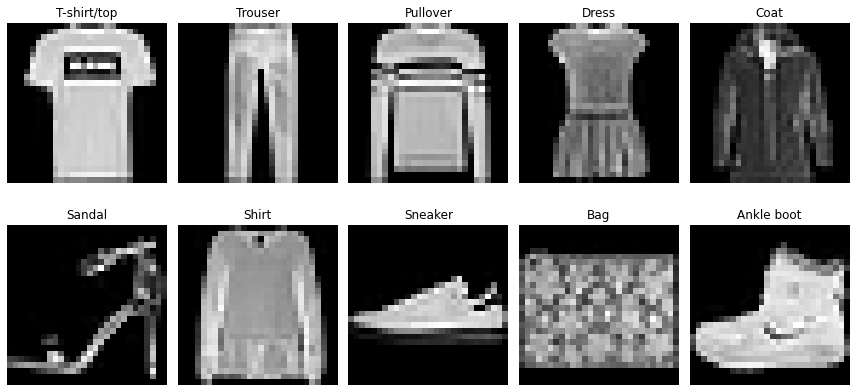

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import fashion_mnist
import wandb

# Initialize Wandb (update project and entity with your own values)
wandb.init(project="DL_Assignment_01")

# Load Fashion-MNIST data
(X_train, y_train), (_, _) = fashion_mnist.load_data()

# Define class names for Fashion-MNIST
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Create a grid plot: 2 rows, 5 columns
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

# For each class, find the first image and plot it
for i, ax in enumerate(axes.flat):
    # Find the index of the first occurrence of class i
    idx = np.where(y_train == i)[0][0]
    # Plot the image in grayscale
    ax.imshow(X_train[idx], cmap="gray")
    ax.set_title(class_names[i])
    ax.axis("off")

plt.tight_layout()

# Log the grid plot to Wandb
wandb.log({"Sample Images": wandb.Image(fig)})

# Display the plot in the notebook
plt.show()

wandb.finish()


In [8]:
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import fashion_mnist
import wandb

# Initialize Wandb with your project name
wandb.init(project="DL_Assignment_01")

# Load the Fashion-MNIST data
(X_train, y_train), (_, _) = fashion_mnist.load_data()

# Define class names for Fashion-MNIST
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# For demonstration, log the grid at multiple steps
num_steps = 3  # You can change this value as needed

for step in range(num_steps):
    # Create a grid plot: 2 rows, 5 columns
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        # Get the first sample for each class
        idx = np.where(y_train == i)[0][0]
        ax.imshow(X_train[idx], cmap="gray")
        # Set title with the class index and name
        ax.set_title(f"{i}: {class_names[i]}")
        ax.axis("off")
    
    plt.tight_layout()
    
    # Log the grid image with the current step value
    wandb.log({"Sample_Grid": wandb.Image(fig)}, step=step)
    plt.close(fig)

wandb.finish()


wandb: ERROR Control-C detected -- Run data was not synced


In [13]:
import wandb
wandb.login()

True

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import fashion_mnist
import wandb

# Initialize Wandb with your project name
wandb.init(project="DL_Assignment_01")

# Load the Fashion-MNIST dataset
(X_train, y_train), (_, _) = fashion_mnist.load_data()

# Define the class names for Fashion-MNIST
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# For demonstration, log the grid at multiple steps.
# This will create a panel with a step slider in your Wandb dashboard.
num_steps = 3  # For example, log at steps 0, 1, and 2

for step in range(num_steps):
    # Create a grid plot: 2 rows, 5 columns
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        # Select the first sample for class 'i'
        idx = np.where(y_train == i)[0][0]
        ax.imshow(X_train[idx], cmap="gray")
        # Title includes the class index and class name
        ax.set_title(f"Index: {i}\n{class_names[i]}")
        ax.axis("off")
    
    plt.tight_layout()
    
    # Log the grid image with the current step value
    wandb.log({"Fashion_MNIST_Sample": wandb.Image(fig)}, step=step)
    plt.close(fig)

wandb.finish()


In [14]:
import wandb

# Define the sweep configuration
sweep_config = {
    'method': 'random',  # using random search for efficiency
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'epochs': {'values': [5, 10]},
        'num_layers': {'values': [3, 4, 5]},
        'hidden_size': {'values': [32, 64, 128]},
        'weight_decay': {'values': [0, 0.0005, 0.5]},
        'learning_rate': {'values': [0.001, 0.0001]},
        'optimizer': {'values': ['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']},
        'batch_size': {'values': [16, 32, 64]},
        'weight_init': {'values': ['random', 'xavier']},
        'activation': {'values': ['sigmoid', 'tanh', 'relu']}
    }
}

# Create the sweep and print the sweep_id
sweep_id = wandb.sweep(sweep_config, project="DL_Assignment_01")
print("Sweep ID:", sweep_id)


Create sweep with ID: 1ztchdgb
Sweep URL: https://wandb.ai/da24m016-indian-institute-of-technology-madras/DL_Assignment_01/sweeps/1ztchdgb
Sweep ID: 1ztchdgb


In [7]:
sweep_config = {
    'method': 'bayes',  # Use Bayesian optimization instead of random search
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'epochs': {'values': [5, 10]},
        'num_layers': {'values': [3, 4, 5]},
        'hidden_size': {'values': [32, 64, 128]},
        'weight_decay': {'values': [0, 0.0005, 0.5]},
        'learning_rate': {'values': [0.001, 0.0001]},
        'optimizer': {'values': ['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']},
        'batch_size': {'values': [16, 32, 64]},
        'weight_init': {'values': ['random', 'xavier']},
        'activation': {'values': ['sigmoid', 'tanh', 'relu']}
    }
}

sweep_id = wandb.sweep(sweep_config, project="DL_Assignment_01")
print("Sweep ID:", sweep_id)


Create sweep with ID: pu8149xm
Sweep URL: https://wandb.ai/da24m016-indian-institute-of-technology-madras/DL_Assignment_01/sweeps/pu8149xm
Sweep ID: pu8149xm


In [8]:
def sweep_train():
    # Initialize the Wandb run (this pulls hyperparameters from the sweep config)
    wandb.init()
    config = wandb.config
    
    # Load the data using the standard Fashion-MNIST split
    X_train, y_train, X_val, y_val, X_test, y_test = load_data("fashion_mnist")
    input_size = X_train.shape[1]
    output_size = 10  # for 10 classes

    # Create a list of hidden layer sizes: repeat 'hidden_size' for 'num_layers' times
    hidden_sizes = [config.hidden_size] * config.num_layers

    # Initialize the neural network and optimizer
    network = NeuralNetwork(input_size, hidden_sizes, output_size, 
                            activation=config.activation, 
                            weight_init=config.weight_init, 
                            loss_func="cross_entropy")
    
    optimizer = Optimizer(network.params, config.optimizer, config.learning_rate,
                          momentum=0.9,  # you can set default values or include these in the sweep config as well
                          beta=0.9,
                          beta1=0.9,
                          beta2=0.999,
                          epsilon=1e-8,
                          weight_decay=config.weight_decay)
    
    # Train the model using the training function defined earlier
    network = train_model(network, optimizer, X_train, y_train, X_val, y_val, 
                          epochs=config.epochs, batch_size=config.batch_size)
    
    # Evaluate on the validation set
    y_val_pred, _ = network.forward(X_val)
    val_loss = network.compute_loss(y_val_pred, y_val)
    predictions_val = np.argmax(y_val_pred, axis=1)
    true_labels_val = np.argmax(y_val, axis=1)
    val_acc = np.mean(predictions_val == true_labels_val)
    
    # Log final validation metrics
    wandb.log({
        "final_val_loss": val_loss,
        "final_val_accuracy": val_acc
    })
    
    wandb.finish()


In [9]:
# Launch the sweep agent; this will run the training function with different hyperparameter configurations.
wandb.agent(sweep_id, function=sweep_train, count=20)


wandb: Agent Starting Run: p4zcxa4d with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/10: Loss=2.3026, Acc=0.0980, Val Loss=2.3027, Val Acc=0.0925
Epoch 2/10: Loss=2.3026, Acc=0.0987, Val Loss=2.3027, Val Acc=0.0925
Epoch 3/10: Loss=2.3026, Acc=0.0994, Val Loss=2.3028, Val Acc=0.0925
Epoch 4/10: Loss=2.3026, Acc=0.0989, Val Loss=2.3028, Val Acc=0.0925
Epoch 5/10: Loss=2.3026, Acc=0.0993, Val Loss=2.3028, Val Acc=0.0973
Epoch 6/10: Loss=2.3026, Acc=0.1005, Val Loss=2.3028, Val Acc=0.0925
Epoch 7/10: Loss=2.3026, Acc=0.1011, Val Loss=2.3028, Val Acc=0.0925
Epoch 8/10: Loss=2.3026, Acc=0.1011, Val Loss=2.3028, Val Acc=0.0925
Epoch 9/10: Loss=2.3026, Acc=0.1012, Val Loss=2.3028, Val Acc=0.0925
Epoch 10/10: Loss=2.3026, Acc=0.1008, Val Loss=2.3028, Val Acc=0.0925


wandb: Agent Starting Run: zeyrkk2k with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/5: Loss=2.3516, Acc=0.0990, Val Loss=2.3082, Val Acc=0.0925
Epoch 2/5: Loss=2.3035, Acc=0.0998, Val Loss=2.3024, Val Acc=0.0973
Epoch 3/5: Loss=2.3030, Acc=0.0973, Val Loss=2.3025, Val Acc=0.1055
Epoch 4/5: Loss=2.3029, Acc=0.0999, Val Loss=2.3026, Val Acc=0.1027
Epoch 5/5: Loss=2.3029, Acc=0.1010, Val Loss=2.3026, Val Acc=0.1050


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qgp8m9jh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/5: Loss=1.5599, Acc=0.5354, Val Loss=1.1588, Val Acc=0.6647
Epoch 2/5: Loss=1.0323, Acc=0.6800, Val Loss=0.9163, Val Acc=0.7023
Epoch 3/5: Loss=0.8704, Acc=0.7156, Val Loss=0.8049, Val Acc=0.7302
Epoch 4/5: Loss=0.7829, Acc=0.7417, Val Loss=0.7361, Val Acc=0.7570
Epoch 5/5: Loss=0.7245, Acc=0.7602, Val Loss=0.6879, Val Acc=0.7675


wandb: Agent Starting Run: xsm1wgz5 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/10: Loss=2.3058, Acc=0.0995, Val Loss=2.3052, Val Acc=0.1050
Epoch 2/10: Loss=2.3050, Acc=0.1003, Val Loss=2.3056, Val Acc=0.1055
Epoch 3/10: Loss=2.3047, Acc=0.1012, Val Loss=2.3054, Val Acc=0.1050
Epoch 4/10: Loss=2.3044, Acc=0.1002, Val Loss=2.3053, Val Acc=0.1027
Epoch 5/10: Loss=2.3044, Acc=0.1029, Val Loss=2.3024, Val Acc=0.1050
Epoch 6/10: Loss=2.3041, Acc=0.0999, Val Loss=2.3033, Val Acc=0.0985
Epoch 7/10: Loss=2.3035, Acc=0.1051, Val Loss=2.3047, Val Acc=0.1027
Epoch 8/10: Loss=2.3034, Acc=0.1025, Val Loss=2.3031, Val Acc=0.0985
Epoch 9/10: Loss=2.3027, Acc=0.1042, Val Loss=2.3017, Val Acc=0.0942
Epoch 10/10: Loss=2.3020, Acc=0.1054, Val Loss=2.3018, Val Acc=0.1032


wandb: Agent Starting Run: bb3ijrb9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/10: Loss=2.3026, Acc=0.0979, Val Loss=2.3026, Val Acc=0.0925
Epoch 2/10: Loss=2.3026, Acc=0.0983, Val Loss=2.3027, Val Acc=0.0925
Epoch 3/10: Loss=2.3026, Acc=0.1005, Val Loss=2.3027, Val Acc=0.0925
Epoch 4/10: Loss=2.3026, Acc=0.0996, Val Loss=2.3027, Val Acc=0.0925
Epoch 5/10: Loss=2.3026, Acc=0.0999, Val Loss=2.3027, Val Acc=0.0925
Epoch 6/10: Loss=2.3026, Acc=0.1003, Val Loss=2.3028, Val Acc=0.0925
Epoch 7/10: Loss=2.3026, Acc=0.1005, Val Loss=2.3028, Val Acc=0.0925
Epoch 8/10: Loss=2.3026, Acc=0.1001, Val Loss=2.3028, Val Acc=0.0925
Epoch 9/10: Loss=2.3026, Acc=0.1005, Val Loss=2.3028, Val Acc=0.0925
Epoch 10/10: Loss=2.3026, Acc=0.1002, Val Loss=2.3028, Val Acc=0.0925


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e9a4zmwe with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/5: Loss=2.0056, Acc=0.3787, Val Loss=1.6844, Val Acc=0.5960
Epoch 2/5: Loss=1.4128, Acc=0.6239, Val Loss=1.1644, Val Acc=0.6587
Epoch 3/5: Loss=1.0375, Acc=0.6661, Val Loss=0.9165, Val Acc=0.6923
Epoch 4/5: Loss=0.8709, Acc=0.6978, Val Loss=0.8065, Val Acc=0.7210
Epoch 5/5: Loss=0.7878, Acc=0.7211, Val Loss=0.7437, Val Acc=0.7397


wandb: Agent Starting Run: p3e0uwtz with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/5: Loss=2.3026, Acc=0.1050, Val Loss=2.3026, Val Acc=0.0948
Epoch 2/5: Loss=2.3026, Acc=0.1092, Val Loss=2.3026, Val Acc=0.0987
Epoch 3/5: Loss=2.3026, Acc=0.1314, Val Loss=2.3026, Val Acc=0.1095
Epoch 4/5: Loss=2.3026, Acc=0.1056, Val Loss=2.3026, Val Acc=0.1252
Epoch 5/5: Loss=2.3026, Acc=0.1183, Val Loss=2.3026, Val Acc=0.1417


wandb: Agent Starting Run: l5brcx7g with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/10: Loss=2.0016, Acc=0.3362, Val Loss=1.5218, Val Acc=0.5260
Epoch 2/10: Loss=1.1430, Acc=0.6355, Val Loss=0.8952, Val Acc=0.6937
Epoch 3/10: Loss=0.8205, Acc=0.7090, Val Loss=0.7415, Val Acc=0.7385
Epoch 4/10: Loss=0.7133, Acc=0.7474, Val Loss=0.6686, Val Acc=0.7563
Epoch 5/10: Loss=0.6513, Acc=0.7732, Val Loss=0.6235, Val Acc=0.7770
Epoch 6/10: Loss=0.6087, Acc=0.7879, Val Loss=0.5860, Val Acc=0.7965
Epoch 7/10: Loss=0.5775, Acc=0.8003, Val Loss=0.5587, Val Acc=0.8037
Epoch 8/10: Loss=0.5525, Acc=0.8085, Val Loss=0.5371, Val Acc=0.8125
Epoch 9/10: Loss=0.5320, Acc=0.8146, Val Loss=0.5243, Val Acc=0.8180
Epoch 10/10: Loss=0.5170, Acc=0.8202, Val Loss=0.5069, Val Acc=0.8225


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9su5rfok with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/10: Loss=2.2756, Acc=0.2617, Val Loss=2.2982, Val Acc=0.1488
Epoch 2/10: Loss=2.3019, Acc=0.1125, Val Loss=2.3028, Val Acc=0.0942
Epoch 3/10: Loss=2.3026, Acc=0.0996, Val Loss=2.3027, Val Acc=0.1003
Epoch 4/10: Loss=2.3026, Acc=0.1000, Val Loss=2.3027, Val Acc=0.1003
Epoch 5/10: Loss=2.3026, Acc=0.0999, Val Loss=2.3027, Val Acc=0.1003
Epoch 6/10: Loss=2.3026, Acc=0.0993, Val Loss=2.3027, Val Acc=0.1003
Epoch 7/10: Loss=2.3026, Acc=0.0995, Val Loss=2.3027, Val Acc=0.0925
Epoch 8/10: Loss=2.3026, Acc=0.1000, Val Loss=2.3027, Val Acc=0.0925
Epoch 9/10: Loss=2.3026, Acc=0.1005, Val Loss=2.3027, Val Acc=0.0925
Epoch 10/10: Loss=2.3026, Acc=0.1008, Val Loss=2.3028, Val Acc=0.0925


wandb: Agent Starting Run: l28oiyjw with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/5: Loss=1.6941, Acc=0.4941, Val Loss=1.1267, Val Acc=0.6755
Epoch 2/5: Loss=0.9371, Acc=0.6951, Val Loss=0.8017, Val Acc=0.7328
Epoch 3/5: Loss=0.7554, Acc=0.7432, Val Loss=0.6974, Val Acc=0.7647
Epoch 4/5: Loss=0.6734, Acc=0.7704, Val Loss=0.6358, Val Acc=0.7823
Epoch 5/5: Loss=0.6202, Acc=0.7891, Val Loss=0.5927, Val Acc=0.7930


wandb: Agent Starting Run: 97bzlwqr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/5: Loss=2.1960, Acc=0.1753, Val Loss=2.0840, Val Acc=0.2487
Epoch 2/5: Loss=1.9957, Acc=0.3135, Val Loss=1.9116, Val Acc=0.3978
Epoch 3/5: Loss=1.8412, Acc=0.4353, Val Loss=1.7707, Val Acc=0.4785
Epoch 4/5: Loss=1.7133, Acc=0.5003, Val Loss=1.6538, Val Acc=0.5258
Epoch 5/5: Loss=1.6073, Acc=0.5381, Val Loss=1.5565, Val Acc=0.5537


wandb: Agent Starting Run: qax4nvez with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/5: Loss=2.1527, Acc=0.3143, Val Loss=1.9427, Val Acc=0.4903
Epoch 2/5: Loss=1.6328, Acc=0.5507, Val Loss=1.3091, Val Acc=0.6282
Epoch 3/5: Loss=1.1279, Acc=0.6432, Val Loss=0.9700, Val Acc=0.6677
Epoch 4/5: Loss=0.9036, Acc=0.6846, Val Loss=0.8248, Val Acc=0.7008
Epoch 5/5: Loss=0.7984, Acc=0.7175, Val Loss=0.7521, Val Acc=0.7257


wandb: Agent Starting Run: n94e72ut with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/10: Loss=2.2242, Acc=0.4305, Val Loss=2.2632, Val Acc=0.5625
Epoch 2/10: Loss=2.2882, Acc=0.3440, Val Loss=2.3001, Val Acc=0.1313
Epoch 3/10: Loss=2.3018, Acc=0.1014, Val Loss=2.3027, Val Acc=0.0925
Epoch 4/10: Loss=2.3026, Acc=0.1008, Val Loss=2.3028, Val Acc=0.0925
Epoch 5/10: Loss=2.3026, Acc=0.1008, Val Loss=2.3028, Val Acc=0.0925
Epoch 6/10: Loss=2.3026, Acc=0.1009, Val Loss=2.3028, Val Acc=0.0925
Epoch 7/10: Loss=2.3026, Acc=0.1009, Val Loss=2.3028, Val Acc=0.0925
Epoch 8/10: Loss=2.3026, Acc=0.1009, Val Loss=2.3028, Val Acc=0.0925
Epoch 9/10: Loss=2.3026, Acc=0.1008, Val Loss=2.3028, Val Acc=0.0925
Epoch 10/10: Loss=2.3026, Acc=0.1009, Val Loss=2.3028, Val Acc=0.0925


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xatjpda3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/5: Loss=2.2864, Acc=0.1650, Val Loss=2.2769, Val Acc=0.1777
Epoch 2/5: Loss=2.2692, Acc=0.1978, Val Loss=2.2640, Val Acc=0.2128
Epoch 3/5: Loss=2.2604, Acc=0.2387, Val Loss=2.2578, Val Acc=0.2553
Epoch 4/5: Loss=2.2566, Acc=0.2761, Val Loss=2.2556, Val Acc=0.2913
Epoch 5/5: Loss=2.2559, Acc=0.3048, Val Loss=2.2559, Val Acc=0.3160


wandb: Agent Starting Run: uoci70xl with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/10: Loss=0.6924, Acc=0.7665, Val Loss=0.4951, Val Acc=0.8218
Epoch 2/10: Loss=0.4510, Acc=0.8400, Val Loss=0.4310, Val Acc=0.8462
Epoch 3/10: Loss=0.4049, Acc=0.8550, Val Loss=0.3902, Val Acc=0.8567
Epoch 4/10: Loss=0.3748, Acc=0.8664, Val Loss=0.3753, Val Acc=0.8638
Epoch 5/10: Loss=0.3551, Acc=0.8720, Val Loss=0.3781, Val Acc=0.8660
Epoch 6/10: Loss=0.3402, Acc=0.8772, Val Loss=0.3493, Val Acc=0.8735
Epoch 7/10: Loss=0.3265, Acc=0.8818, Val Loss=0.3453, Val Acc=0.8782
Epoch 8/10: Loss=0.3154, Acc=0.8849, Val Loss=0.3597, Val Acc=0.8673
Epoch 9/10: Loss=0.3059, Acc=0.8889, Val Loss=0.3597, Val Acc=0.8682
Epoch 10/10: Loss=0.2983, Acc=0.8921, Val Loss=0.3494, Val Acc=0.8755


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ytx8soot with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/5: Loss=1.6546, Acc=0.5269, Val Loss=1.2148, Val Acc=0.6670
Epoch 2/5: Loss=1.0538, Acc=0.6984, Val Loss=0.9246, Val Acc=0.7210
Epoch 3/5: Loss=0.8698, Acc=0.7321, Val Loss=0.8033, Val Acc=0.7448
Epoch 4/5: Loss=0.7774, Acc=0.7531, Val Loss=0.7334, Val Acc=0.7660
Epoch 5/5: Loss=0.7178, Acc=0.7676, Val Loss=0.6853, Val Acc=0.7763


wandb: Agent Starting Run: mxlfgkz9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/10: Loss=0.6404, Acc=0.7802, Val Loss=0.4511, Val Acc=0.8355
Epoch 2/10: Loss=0.4262, Acc=0.8505, Val Loss=0.4129, Val Acc=0.8532
Epoch 3/10: Loss=0.3861, Acc=0.8633, Val Loss=0.3741, Val Acc=0.8627
Epoch 4/10: Loss=0.3599, Acc=0.8721, Val Loss=0.3696, Val Acc=0.8680
Epoch 5/10: Loss=0.3406, Acc=0.8778, Val Loss=0.3558, Val Acc=0.8700
Epoch 6/10: Loss=0.3260, Acc=0.8819, Val Loss=0.3563, Val Acc=0.8727
Epoch 7/10: Loss=0.3131, Acc=0.8867, Val Loss=0.3394, Val Acc=0.8800
Epoch 8/10: Loss=0.3034, Acc=0.8882, Val Loss=0.3330, Val Acc=0.8808
Epoch 9/10: Loss=0.2925, Acc=0.8938, Val Loss=0.3293, Val Acc=0.8810
Epoch 10/10: Loss=0.2831, Acc=0.8956, Val Loss=0.3448, Val Acc=0.8737


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3xe5y2p2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/5: Loss=0.6696, Acc=0.7763, Val Loss=0.4458, Val Acc=0.8385
Epoch 2/5: Loss=0.4286, Acc=0.8481, Val Loss=0.4058, Val Acc=0.8497
Epoch 3/5: Loss=0.3913, Acc=0.8604, Val Loss=0.3955, Val Acc=0.8547
Epoch 4/5: Loss=0.3701, Acc=0.8669, Val Loss=0.3829, Val Acc=0.8588
Epoch 5/5: Loss=0.3547, Acc=0.8723, Val Loss=0.3819, Val Acc=0.8598


wandb: Agent Starting Run: zwhqyhqp with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/5: Loss=0.6522, Acc=0.7708, Val Loss=0.4775, Val Acc=0.8372
Epoch 2/5: Loss=0.4268, Acc=0.8488, Val Loss=0.4084, Val Acc=0.8565
Epoch 3/5: Loss=0.3904, Acc=0.8607, Val Loss=0.3856, Val Acc=0.8602
Epoch 4/5: Loss=0.3663, Acc=0.8679, Val Loss=0.3664, Val Acc=0.8700
Epoch 5/5: Loss=0.3463, Acc=0.8756, Val Loss=0.3546, Val Acc=0.8730


wandb: Agent Starting Run: 7wt3iqpy with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/5: Loss=0.6709, Acc=0.7713, Val Loss=0.4742, Val Acc=0.8353
Epoch 2/5: Loss=0.4394, Acc=0.8451, Val Loss=0.4106, Val Acc=0.8535
Epoch 3/5: Loss=0.3942, Acc=0.8608, Val Loss=0.3835, Val Acc=0.8625
Epoch 4/5: Loss=0.3684, Acc=0.8689, Val Loss=0.3649, Val Acc=0.8658
Epoch 5/5: Loss=0.3477, Acc=0.8752, Val Loss=0.3570, Val Acc=0.8698
